# Reverse time migration example on a 2D  acoustic model

## PDE 

The acoustic wave equation for the square slowness m and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditons to guaranty unicity of the solution

### Solve forward in time 

The wave equation with absorbing boundary conditions writes

\begin{equation}
 \eta \frac{d u(x,t)}{dt} + \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q
\end{equation}

and the adjont wave equation 

\begin{equation}
-\eta \frac{d u(x,t)}{dt} + \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q 
\end{equation}

where $ \eta$  is a damping factor for the absorbing boundary conditions equal to zero inside the physical domain and decreasing inside the absorbing layer from the pysical domain to the border.

##  Devito implementation
This two equations are trivial to implement and solve with devito as it only requires to write 

```
    wave_equation_forward = m*u.dt2 - u.laplace + damp * u.dt
    stencil_forward = solve(wave_equation,u,forward)[0]

    wave_equation_adjoint= m*u.dt2 - u.laplace - damp * u.dt
    stencil_adjoint = solve(wave_equation,u.backward)[0]
```

and can be seen in the examples folder of devito


## Set up generic Python environment.

In [1]:
# Add module path
import sys
import os

currloc = os.getcwd()

sys.path.append(currloc+'/../../devito/')
sys.path.append(currloc+'/../../examples/')
sys.path.append(currloc+'/../acoustic/')

# Add plotting, numpy, scipy
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from scipy import ndimage
import numpy as np

# Setup figure size
fig_size = [0, 0]
fig_size[0] = 18
fig_size[1] = 13
plt.rcParams["figure.figsize"] = fig_size

## Import OPESCI components.

In [2]:
from examples.containers import IShot, IGrid
from examples.acoustic.Acoustic_codegen import Acoustic_cg
from devito import clear_cache
from devito.memmap_manager import MemmapManager

# Setup number of threads, affinity and architecture
os.environ["DEVITO_ARCH"] = "intel"
os.environ["DEVITO_OPENMP"] = "1"
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["KMP_AFFINITY"] = "explicit,proclist=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]"

## Dimensions on constant initialization.

In [5]:
# Define geometry
dimensions = (1601, 401)  # Number of grid point in the velocity model file
origin = (0., 0.)  # Origin of the model in m
spacing = (7.5, 7.5)  # Grid size in m
spc_order = 10  # Spacial discretization order

x_axis = [7.5*x for x in range(0, 1601)]
z_axis = [7.5*z for z in range(0, 401)]

## Load synthetic velocity model.

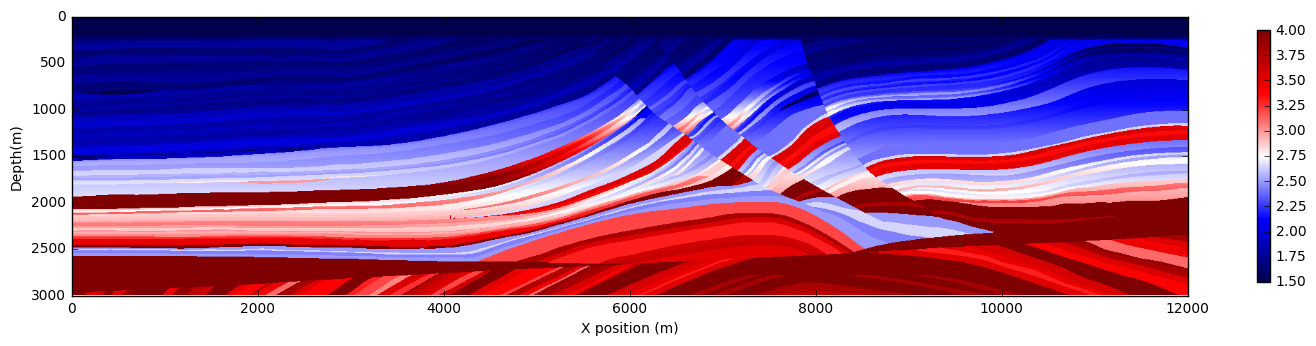

In [6]:
# Read velocity
vp = np.fromfile(currloc+'/../../../data/Simple2D/vp_marmousi_bi', dtype='float32', sep="")
# Reshape the velocity model
vp = vp.reshape(dimensions)


# Create exact model
model = IGrid()
model.create_model(origin, spacing, vp)
# Plot true velocity
fig1 = plt.figure()
l = plt.imshow(np.transpose(vp), vmin=1.5, vmax=4, cmap=cm.seismic, extent=[np.min(x_axis), np.max(x_axis), np.max(z_axis), np.min(z_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Depth(m)')
plt.axis('scaled')
plt.colorbar(l, shrink=.25)
plt.show()

## Create "initial guess" by smoothening the synthetic velocity model.

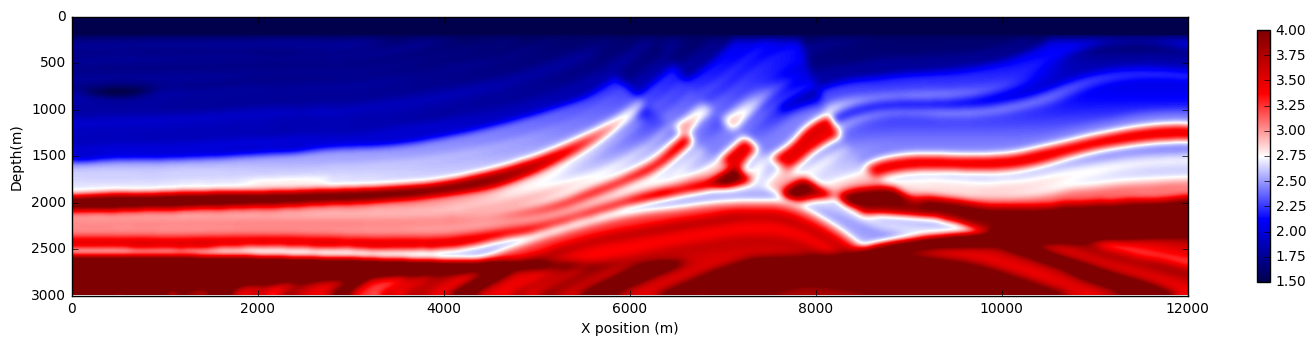

In [16]:
# Smooth velocity
smooth_vp = ndimage.gaussian_filter(vp, sigma=(6,6), order=0)

# Inforce the minimum and maximum velocity to be the same as the true model to insure both mdelling solver will use the same value for the time step dt
smooth_vp = np.max(vp)/np.max(smooth_vp)* smooth_vp
# Inforce water layer velocity
smooth_vp[:,1:29] = vp[:,1:29]

# Create the smooth background model
model0 = IGrid()
model0.create_model(origin, spacing, smooth_vp)

# Plot smooth velocity
fig2 = plt.figure()
l = plt.imshow(np.transpose(smooth_vp), vmin=1.5, vmax=4, cmap=cm.seismic, extent=[np.min(x_axis), np.max(x_axis), np.max(z_axis), np.min(z_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Depth(m)')
plt.axis('scaled')
plt.colorbar(l, shrink=.25)
plt.show()

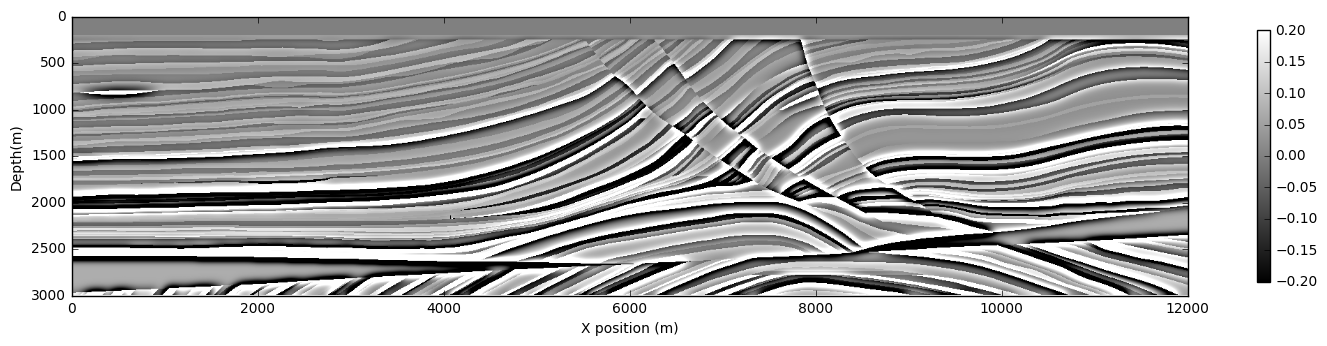

In [17]:
# True velocity difference (image) 
fig22 = plt.figure()
l = plt.imshow(np.transpose(smooth_vp-vp), vmin=-.2, vmax=.2, cmap=cm.gray, extent=[np.min(x_axis), np.max(x_axis), np.max(z_axis), np.min(z_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Depth(m)')
plt.axis('scaled')
plt.colorbar(l, shrink=.25)
plt.show()

## Acquisition geometry (i.e. set up sources and receivers)

In [18]:
# Source function: Set up the source as Ricker wavelet for f0
def source(t, f0):
    r = (np.pi * f0 * (t - 1./f0))

    return (1-2.*r**2)*np.exp(-r**2)

# Define seismic data.
data = IShot()

f0 = .025  # 15Hz peak frequency
dt = model.get_critical_dt()  # Time stepping rate as the overall sampling rate
t0 = 0.0  # Origin time (in ms)
tn = 4000  # Final time (in ms)
nt = int(1+(tn-t0)/dt)  # Number of time steps
print(dt,nt)
t_axis = [1e-3*dt*t for t in range(0, nt)]
time_series = source(np.linspace(t0, tn, nt), f0)  # Generate the source time signature

# Receiver coordinates. The receivers are located at the ocean bottom (200 grid points) and at every grid point along the x axis
receiver_coords = np.zeros((1601, 2))
receiver_coords[:, 0] = np.linspace(origin[0],
                                    origin[0] + dimensions[0] * spacing[0],
                                    num=1601)
receiver_coords[:, 1] = origin[1] + 28 * spacing[1]
data.set_receiver_pos(receiver_coords)
data.set_shape(nt, 1601)

(0.67021279315594584, 5969)


## Example of a shot record

In [19]:
# Define the source location
location = (origin[0] + dimensions[0] * spacing[0] * 0.5,
            origin[1] + 2 * spacing[1])
data.set_source(time_series, dt, location)

# Create acoustic modelling kernel.
Acoustic = Acoustic_cg(model, data, t_order=2, s_order=spc_order)

# Execute acoustic forward model
rec, u, gflopss, oi, timings = Acoustic.Forward(save=False)

# As well for the smooth model
Acoustic0 = Acoustic_cg(model0, data, t_order=2, s_order=spc_order)
rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=False, cse=True)


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cb59456e95f7ff7d0b4859118125ef39cd28fde.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d4a72f764be02a35b1369c14c4d3e5d46a88660.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71c758627d51bd8200ac6ee4798812be520c7eef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e8855002f6cd310f5638b6746fdb13cc2989e889.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0702939e130cb40ab537a2b1023913b8cfa0b643.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/afc1b49231001c703b8d0e88a2113ed27e6ead6b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1030abcf9a206582ed5d5ae6b682b76e1e362a75.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03526fa4b85148be74fc0d19110f9c91361ea359.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.824947 s (1228 MCells/s)
Stencil: 3.4

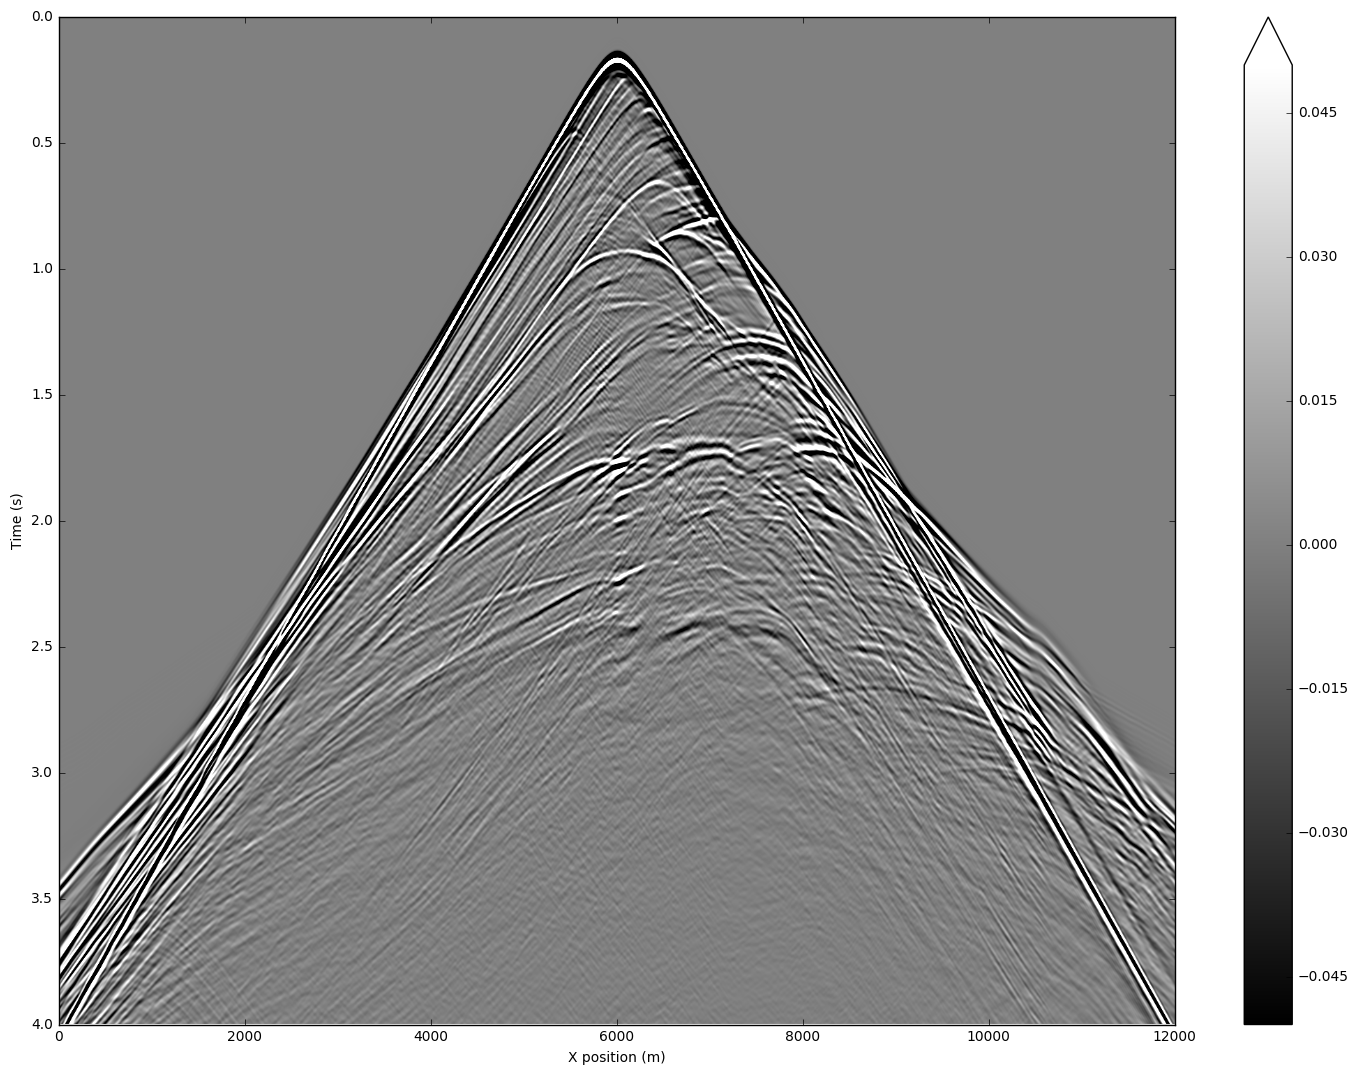

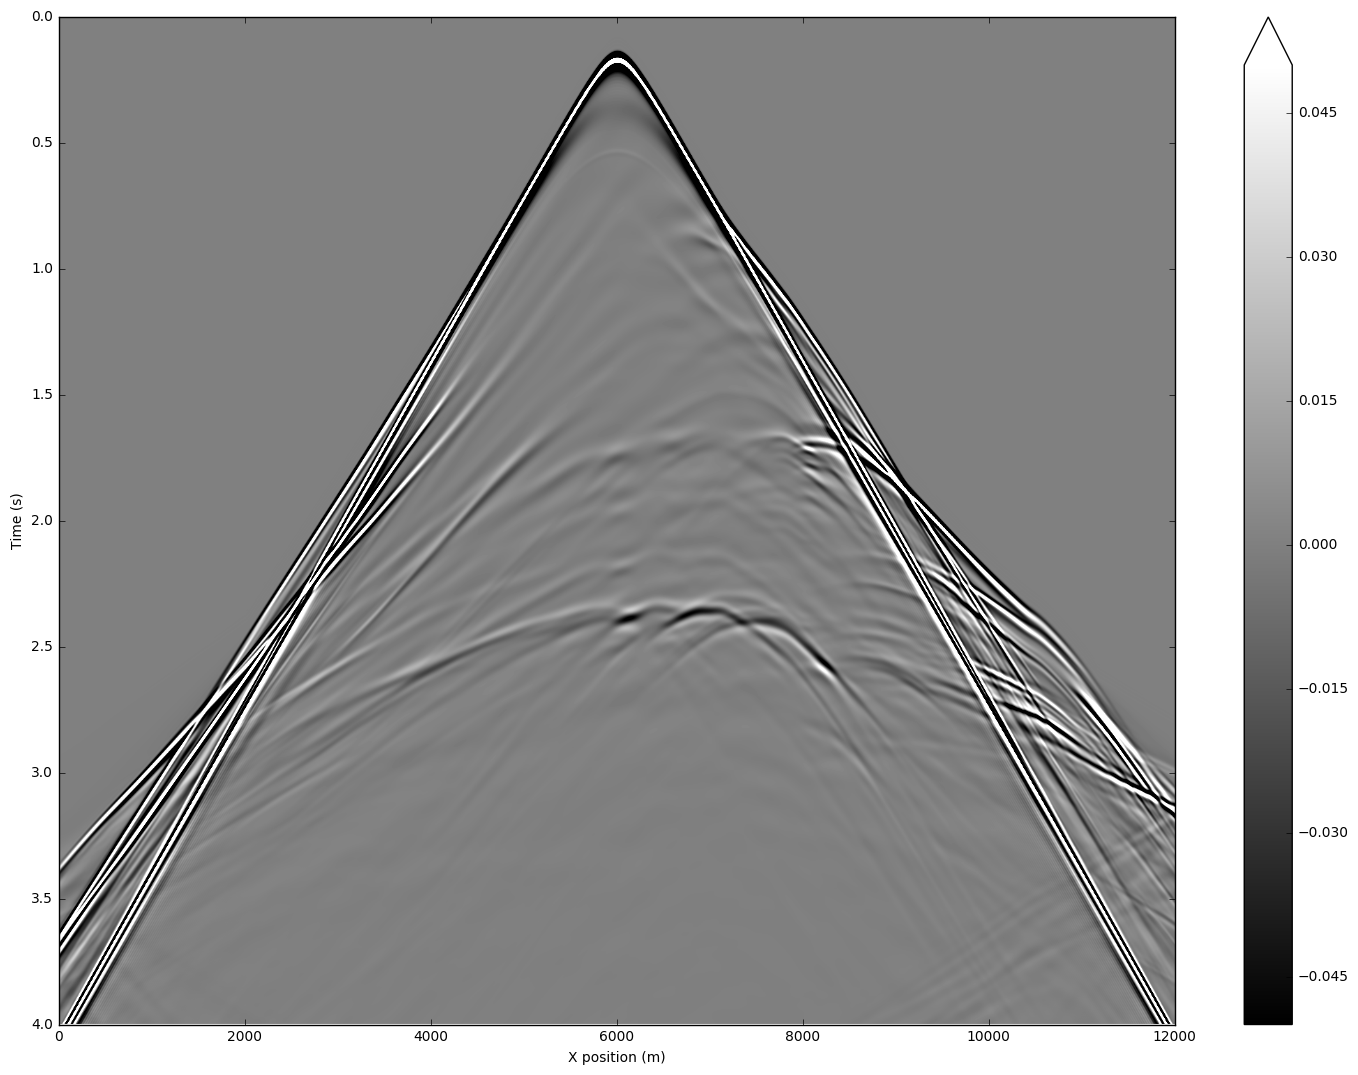

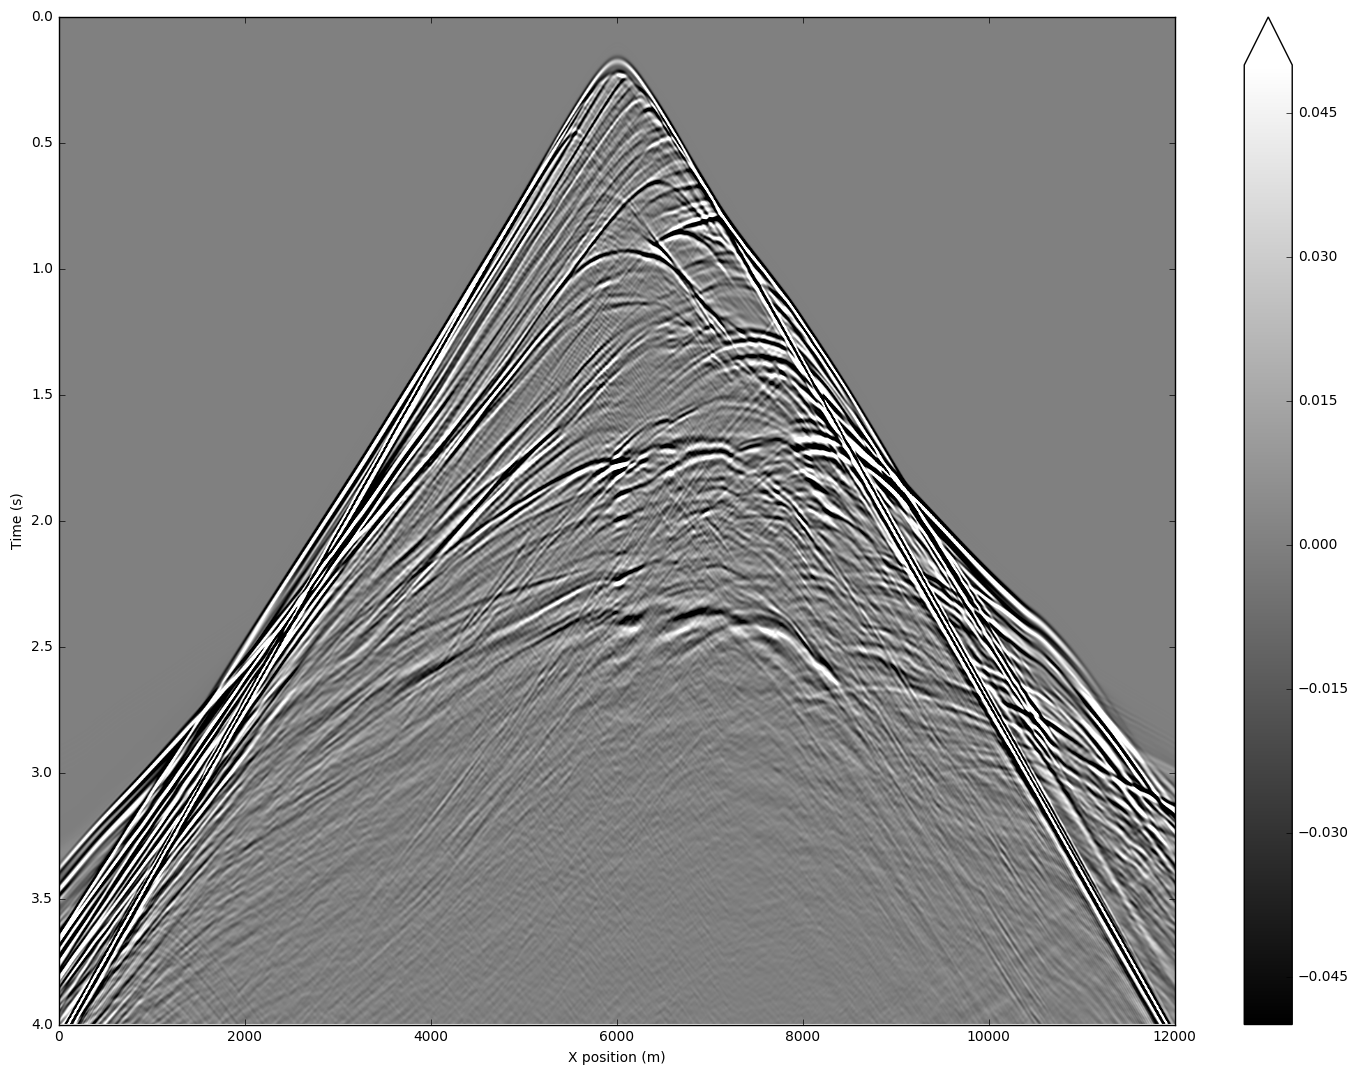

In [20]:
# Show the shot record at the receivers
fig31 = plt.figure()
l = plt.imshow(rec, vmin=-.05, vmax=0.05, cmap=cm.gray, extent=[np.min(x_axis), np.max(x_axis), np.max(t_axis), np.min(t_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Time (s)')
plt.axis('auto')
plt.colorbar(extend='max')
plt.show()

fig32 = plt.figure()
l = plt.imshow(rec0, vmin=-.05, vmax=0.05, cmap=cm.gray, extent=[np.min(x_axis), np.max(x_axis), np.max(t_axis), np.min(t_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Time (s)')
plt.axis('auto')
plt.colorbar(extend='max')
plt.show()


fig32 = plt.figure()
l = plt.imshow(rec0 - rec, vmin=-.05, vmax=0.05, cmap=cm.gray, extent=[np.min(x_axis), np.max(x_axis), np.max(t_axis), np.min(t_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Time (s)')
plt.axis('auto')
plt.colorbar(extend='max')
plt.show()

# RTM

## Least square objective Imaging condition

We will consider here the least square objective. We can writte the data fitting problem known as FWI or RTM as a leqast square problem as follows:

\begin{equation}
min_m \Phi(m) := \frac{1}{2} \| P_r A^{-1}(m) q - d\|_2^2
\end{equation}


where $m = \frac{1}{c^2}$ is the square slowness, $A^{-1}(m)$ is the time stepping operator (inverse of the discretized wave equation), $P_r $ is the measurement operator ,  $q$ is the source and $d$ is the obeserved data.

For multiple sources it becomes a simple sum over experiments as a separable problem :


\begin{equation}
 min_m \Phi(m) := \sum_{s=1}^{n_{src}} (\frac{1}{2} \| P_{r_s} A^{-1}(m) q_s - d_s\|_2^2)
\end{equation}


We can then obtain the gradient with respect to the square slowness as

\begin{equation}
\nabla_m \Phi(m) = \sum_{s=1}^{n_{src}} ( - (\frac{dA(m)u_s}{dm})^T v_s ) = \sum_{s=1}^{n_{src}} ( \nabla_m \Phi(m)_s )
\end{equation}

where $v_s$ is the soltuion if the adjoint wave equation $A^{T}(m)  v = P_{r_s}^T (P_{r_s} u_s - d_s)$ and $ u_s$ is the forward wavefield solution of $A(m)u_S = q_s$. For the simple acoustic case the  gradient can be rewritten as 
\begin{equation}
\nabla_m \Phi(m)_s = - \sum_{t=1}^{nt} \frac{d^2u_s(t)}{dt^2} .v_s(t)
\end{equation}


This last equation is the imaging condtion. Using it in an iterative method (gradient decent, Quasi-Newton,..) corresponds to FWI where the aim is to invert for the velocity model from an "not so good" inital guess. Once a good estimate of the background velocity model is obtained, this imaging condition is used to obtain an image of the subsurface known as RTM image. In te follwing we compute the RTM image on the marmousi model from an artificial background velocity model.

In [21]:
# Number of sources
nsrc = 801
# Sources locations
sources = np.linspace(spacing[0], origin[0] + dimensions[0] * spacing[0], num=nsrc)
# Initialize the image at zero
Im = np.zeros(dimensions)
# Extend it to match the gradient dimensions with the absorbing boundary layer
Im = np.pad(Im, [(40, 40),(40,40)],'edge')

# Looping over the sources
for i in range(0,nsrc):
    clear_cache()
    print("Starting source : " + str(i+1) + " of " + str(nsrc))
    # Set current source location
    location = (sources[i] ,origin[1] + 2 * spacing[1])
    data.set_source(time_series, dt, location)
    # Generate the true data (loaded from file in a real case)
    Acoustic = Acoustic_cg(model, data, t_order=2, s_order=spc_order)
    rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)
    # Generate the data and wavefield for the smooth background model
    Acoustic0 = Acoustic_cg(model0, data, t_order=2, s_order=spc_order)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, cse=True)
    # Compute the gradient from the data difference and the smooth wavefield and accumulate it in the final image
    Im =  Im +  Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68cb95202a51d9709f915d621c1feabfb9c566d7.cpp


Starting source : 1 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3c0550e1b4f7d82b2b0374628460a43e29aa5e8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/488628387f5eb97ee9399b2fdf73cbf955c81a1a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b08b9e9ff2a72c0930d4ca4c78e182e2c9ea41f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae61ff0a599b57ea0213ad6d3418c6466799eeae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a441e975bc7a9b01c9d9ac4caf1ee7a34f9408e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e42c1dafc6d9adb17c2730f68b150b937b17d8e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99616e2793930752d06e7df83d4765e48b068c3a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.497524 s (723 MCells/s)
Stencil: 3.437500 OI, 42.15 GFlops/s (time: 6.298320 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb

Starting source : 2 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad72d75170a4256bd4812297b02e9ac01fe8e917.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84046a89d5cc8774c1308bcde50f1712b366bc25.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7e0aec194eadf29a8bb7d120faf954af5c427eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/485d90d177925b334c497080a0389c842e328dac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1225a5a06ba137a913499df10c9b6028da1ad236.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41af2e3f4e59ac789953d598cbbdfed891cbbd09.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8a43d435c51ec8fe9848859b77f93f94c6b59c1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.216574 s (755 MCells/s)
Stencil: 3.437500 OI, 44.22 GFlops/s (time: 6.002899 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05

Starting source : 3 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0094b2960d8b8f7e42a92469cc95da7b9f10cd9f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f13d52c91f58a8c595a843fbfae258147814a107.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c95133307c2ddf038757cfeae18ab24d650b35ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03a0aed92fbccecb15bc51b47a8a15170215578c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce9ff6c9da10e240417fb289f48a06f42e67c083.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3620aac51aab396fc8ffed33910230063b421e21.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eab69fcf0325bd0281721b7fda6906991ebb57c6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.402334 s (733 MCells/s)
Stencil: 3.437500 OI, 42.91 GFlops/s (time: 6.186455 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05

Starting source : 4 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e95e3174aed7f8e9f73aa2f064139f0b08b785ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/57674546fe840ae19caabd367994486d12e09376.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5dd2e0dc4cf3e58752304db219a098338555d87c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e7d593adbbd9d92b88cf8a2fc055fc437bb51d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bfb2c5c55d4129bac1720f0b2de0a83d1eb95047.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8ca59f9a1ceaf18708cf1e68cd64bfadf756823.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e06b836cb0b5f76f6a967962392d71a6b984ef1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.185878 s (759 MCells/s)
Stencil: 3.437500 OI, 44.46 GFlops/s (time: 5.970125 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f

Starting source : 5 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ee97764f1f8ece08e0b2ffb1ba69c008e88c633.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b4f8d02c356aca057d8e75c1bb64ccbdf3dc564.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b8ff24e3350c867efa1716ca5fdc467968fb4c01.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e62ddbdd5389f6495427ec58a4d4d99da773c6a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c773339251c7e464b73f0fd3598aff0c7177f71b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a9f91453a736260a5b335df56af00f9335f2c41.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/04e2ef2692f94edca37d7ff9d05fd985a8ebf040.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.055593 s (775 MCells/s)
Stencil: 3.437500 OI, 45.45 GFlops/s (time: 5.839874 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24

Starting source : 6 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5c29b56d6c7d3d8bbe745f776e7acf0257dead4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af8db0826e8cd6cc755d9b2829cbb163cd0255b6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b623076cbfad65d87000699ea1b214f672b06ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/befac3a469a2819d88e5f3ca3ead3edad039f4f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22bc061ffb108cdfb3f19879572c70133f2141e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ce89367fd3e6ee0acbb1f036b0816b7aef46bfe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4bc4e2d5e36b807fccb6c9b937e18529ba3f082.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.136830 s (765 MCells/s)
Stencil: 3.437500 OI, 44.83 GFlops/s (time: 5.920849 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f

Starting source : 7 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e6c81f9288e2a0f338da4df286f1176d07a30159.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c82ce23de191a9be69e8e742fc68f435d82d52e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5e208cd6b9f2ab33e186a0f9b707027d7dab56c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b9d729e78fc7c1e4d601cace44753e064f54ed9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b79d1d7840728bf95b4313da343ff9bf22631875.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a56e7fe63b0c3e7b6c0e39b534b50a338f62a866.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/627e709d43c3cb581b6033d67f421e09fadea97b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.081138 s (772 MCells/s)
Stencil: 3.437500 OI, 45.26 GFlops/s (time: 5.865211 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3

Starting source : 8 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4bfaf4fb66a20764c0d9a96e66502ca9d98f702.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/889b110a9b61b7be057af10ea2a599239c9ea96e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c59e188677a6c7e4bc499f239236e893ed4d69c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e5ba4d1eb970a415b889778367bf4e711897b68.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b75f84e5f83388fa24d371ca5ee5af3896ea29ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd5ac8aba578cbae08f3d8aa95f6607785f78bec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2922246b8a225f7370777a7b1c2e24e9512f180.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.098637 s (770 MCells/s)
Stencil: 3.437500 OI, 45.11 GFlops/s (time: 5.885042 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ba

Starting source : 9 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11e70671ce434ee62c264f43f479fdfbb3ca3237.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4fa67ede6a843bf0e49e7d88b683b0fbbb3ca7f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/222324180ce95ae64a96dd8eada93bb2d718fe74.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/007d2be25771d7dec4dd7cd1970a8e8156b34d55.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d911ae4d249ee4d7411eb9163969537ed3aa654a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45bd499da39d9be3e79ccaa9b59d9ef8ac9313c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/88eab505770187d015f33fa5f7025c65dd9ea15a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.080335 s (772 MCells/s)
Stencil: 3.437500 OI, 45.24 GFlops/s (time: 5.866964 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35

Starting source : 10 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2eb27a9fb5afa59904393d72fccd89ea4b7f6e27.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6380b7762761db747a5a38f8bc529fbac6bd082.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/446a1d676b903cc86ae802dc298733be41970900.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9862f12dc82c074a800ac874312e7f8b4257a7d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/820f28d7f04feac90df61d3c3b3697c7702b6bfa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d19fe645489639fd04a39f128659a98bed0eef2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43f56c5b6294259744732886f08c8b3b95a96249.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.197970 s (757 MCells/s)
Stencil: 3.437500 OI, 44.36 GFlops/s (time: 5.984550 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be

Starting source : 11 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd55d027c02acbbe928fa9374f96e0dd32752abd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cdd86f95f1080bab0be9d60a6b1c3aeee3908e4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84bc4fee4eb2b0a2a179a2bf5b99e6f3b2be1102.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/158421bf8d5b6a662dcb04064ed909f88e1853b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e4b2bc2c6736131b2999f562ba57d859d7004111.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b10d4b2cf66625a572e2206e7052d83a962d4535.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1ad4cdb72f9f65a2dbcd3c5affabc1b81981188.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.095254 s (770 MCells/s)
Stencil: 3.437500 OI, 45.15 GFlops/s (time: 5.879127 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/40

Starting source : 12 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3f88db44decc3d3a9a2f775a1337d6327cf728d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d94ff9caeb7bd86ec5df6837c99fbc772cb5141.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fae0cb7f346172a08eb880f55685eef25d8ab2ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d60a19bce161bdeede6554b38e7d8f9879efcbec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6937b6e5a030a0cf91fd24e61ea0f8e38b895ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96258c1385509062099b883df5d1730ef0e18db8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce5bd5aa21532f9b77385ea3c358e99b95143cb0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.046339 s (776 MCells/s)
Stencil: 3.437500 OI, 45.53 GFlops/s (time: 5.830406 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc

Starting source : 13 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e594ebc313f9708f5e0a6b155115e13c54a7050.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f1a621703fd0b5f3471c802e919e4c779d2b5fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/813291e88b379279dc1d95cf0a27bc88ed62b87f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a842db0163d0563339e3436e03908aa9b96951ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31bc0e2fc7c37436c9a4dfa157883814e69e2f94.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d660f47086251c56e4f50005d5526c019b33817.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/214245ccd5f69294fa17d0ad2643c981529420e4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.035141 s (778 MCells/s)
Stencil: 3.437500 OI, 45.60 GFlops/s (time: 5.821563 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a

Starting source : 14 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/82dadd1d71215385311b48bf84919ac8f5c3924b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6b16cc4faf48a7fef61967baaf30b62e8e2366b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/88b9823edc9a8a1b9c721583dff80b5784975293.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/295a34798c0fc5de6ef8eb0ec02f6e676aff930d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd625247f49bff59c2000be23376aa9913228cd7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8870177bf7d4a4e5e8ad66ed3c01ca6b50c09daf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/044b20277da56faa9140fc9e4437af0c0a91baed.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.987425 s (784 MCells/s)
Stencil: 3.437500 OI, 45.97 GFlops/s (time: 5.774106 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19

Starting source : 15 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7435ce9d5a16ff99729f82adcad41890d48d6db3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd924307b0de620f9c124ff673cfc1a331b70189.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7404befed4ed78486ceab22b077df9bdecf15585.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2391871ee71e2306ac619d724e2486567e57f694.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1d6c78a2025326814e23bea78e7938fec7ba03c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf6115c2061c81777fd7d6ea4930f9d8516b1bbb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e40b0ac15dd9f11e331feefa33f5b20c1acc84d5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.090698 s (771 MCells/s)
Stencil: 3.437500 OI, 45.18 GFlops/s (time: 5.874699 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe

Starting source : 16 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7e8dcd127f1ff6638cd00b8e4490ba166cab445a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e2d25b31b4c26eacf12f83854c598804b3719b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7903241755126f7bd1c0f222eaebf96dcbefa84.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c8bc2bae710f1c28de7ccc3272064b654eda8d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16429cdd83727c1cb0840ffcc9f0279d89ff8b27.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d38587fb7e59743d43557518dfc592bf861dab37.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e8e003f25c6cfa1c3b393bd6ed0bbb61d1807640.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.999196 s (783 MCells/s)
Stencil: 3.437500 OI, 45.90 GFlops/s (time: 5.783251 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47

Starting source : 17 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c8379a89e20e35f10427432134e916ad306e62e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63b7ea8f36202803f5f460c26bd6b7c6d4727b68.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/502c5b6cfed5cea0717679a76abd08a3b88a8a2b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05e7e8e4071103f76b0e12d44223a590cd598a35.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d172fc4677caf54c01af3aa10dc1f19f605a604e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68c1cd2aac254fa10b6026f919a2216ce747310f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41b81b8f01c222f80e530d8fbc8a9a16bdea4e07.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.075564 s (773 MCells/s)
Stencil: 3.437500 OI, 45.30 GFlops/s (time: 5.859797 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6

Starting source : 18 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99d4001a7b6016d183df5c2a796ff6156ac40234.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4775a83024b594724fac39ef6f89dd0377143f4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e332cfde44dddea13feb67b568c348c736c3c4b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4997c25c23d44d6bb7bc3f2b5f24c6fca2ea80e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/929ae61b3cc0c02b67bab01fdfb8e4e42d7e10e9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/016a8c5936d7d934c5eff5e7a828a6681c2b53db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e76486c913b1d49f79fbfa3ce2e8f9ba2fb4eb36.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.090470 s (771 MCells/s)
Stencil: 3.437500 OI, 45.18 GFlops/s (time: 5.874799 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1

Starting source : 19 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/50c268624a2e2f521b2bd61a46a775d913240e8f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5adb3214d75327cbfd072760217ab44d142ba833.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41caca3cadf25b64f0efdb9e1027ed91618442e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33b29a4f380276c3a9eaf5cfacfc0edc5843e919.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a554e0f7c452ea1d0031aca5cb1407ea50243760.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/79e39ff2e177e0c7c8e989c54a829f34c16f78e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3c88c72d606240d0c599f77fb318f76687c6be4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.148831 s (764 MCells/s)
Stencil: 3.437500 OI, 44.74 GFlops/s (time: 5.932895 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4

Starting source : 20 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42780ae359d66607335d1c7927fa0727d07664de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/631e9328fe8cf956c4b86b0d93bb45eb1a96ffa8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6302d9fbbe834319b9c46c86faef954f5549d475.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/343e89a0918d9236782e5e03dccb93adb388280e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff4f3614cc3563870a91bf16b13c2a6b88326d99.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c8a2d4041b71db28f071c447a641ed38d00741a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b4bfc110191145ca256b0ab1f502bdfcee8d970.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.976419 s (786 MCells/s)
Stencil: 3.437500 OI, 46.08 GFlops/s (time: 5.760680 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76

Starting source : 21 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4994acf1d2ab04614757a2f9d9823003a163f7cd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dcc8d66016eafc6821a2a5a1ffb4d0ce507dcdbe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a84874b0d3a4100d7b2e39f3127687c228e52b9f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6b226f28c9dac4aacb764c32f6496b9cfba62e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/442fdb907b1631b0102422a232af6a90128804cd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09aba7a20f9c660b82375e0a8a6a42b570bb2cb7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36b526249e8081f5ef6a783ff4fdffe33c032439.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.254744 s (751 MCells/s)
Stencil: 3.437500 OI, 43.96 GFlops/s (time: 6.038965 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d

Starting source : 22 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eee11a17b538b788892d6090bc3cb9c67ae9336b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0041a03ae9836758432cbe99f60322c3e6a30ba1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9fdaf994546cd4e6e740c4e898ef2b83d8f3c5e0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d0abb626cf8cbdfd96bea2252d689fbd870e02d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68dbb76640b0adf2503390fbe55b3177b6db9fd7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dcb6403993033f914febd80616604c3e8de05d6b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8894a7347fe67ce7a88f6939b2a56ba9afd1bc36.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.019695 s (780 MCells/s)
Stencil: 3.437500 OI, 45.72 GFlops/s (time: 5.806240 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2

Starting source : 23 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd31d0521141575fa55a14085a769a43562ac9e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe18794bd9d9a5180d1004f2c8cccd17c78de980.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7fb74bd054ee3033accdd706ba692d921378f8d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e60a16c2dc2e0f26dd226faac6ba297cab119291.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73e365f616636c54fb7cb713a4e4b945bbbb645d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e16597b77cbd432487809f5f8130dca84ef11a1c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d390a446688eadbd25771eac0b4ad8f9a90cff1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.129499 s (766 MCells/s)
Stencil: 3.437500 OI, 44.89 GFlops/s (time: 5.913462 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56

Starting source : 24 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/297d9d18fc2495479b7d7e83ecebc91022e8e451.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75805eaffc36541a7f4f9b24aaee9506e3dde6e2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea0ede506f70c7b5584fec3757e6f77d74c77afe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/429386e11f7cb0ed8409f1b70c2943c881b64884.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52b071ca912a8557d42760e830bb24e9a5b1812c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d62ebaa8e3001405880430b0d64e7671964f267c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/283f7e3cde717d0797c8260446cea3d4bed11e84.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.100877 s (770 MCells/s)
Stencil: 3.437500 OI, 45.10 GFlops/s (time: 5.885126 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6

Starting source : 25 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/468b1da1ade43880ae292f0da8552f71dbbc71b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6725ed09df7ff323a42a848ed4f742104c3e6341.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52a63d0c64db962b262bef58321db6d681a5120a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/678064b063a379f772f38d27e9e82ab4381ec202.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9024c2e5451ad8b094ce38747ccde27e363b0b3a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99cdf666385de918f264edfb20ee744d5c62d670.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38f9f109b08bee72a4d898df7de80c0bf4703667.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.994644 s (783 MCells/s)
Stencil: 3.437500 OI, 45.94 GFlops/s (time: 5.778698 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95

Starting source : 26 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90367cc00a8c9be31d19fcac4e13bef9e861d547.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c06196159d4e1652c5b274fd9693e07beb022c64.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0148821fd897c9228f39cb772aa415191ee408a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd571ff451b48bc7c02758232605e67f11e9aae9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/009fe0c71027bab29a83b14bdfa5be2b9949738f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ac2a7a3f7aa9520f6b41fb0d3be17cc8c0d8163.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/451e222f9ac12d781de6aaeb62ae64419aa7eb95.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.064251 s (774 MCells/s)
Stencil: 3.437500 OI, 45.37 GFlops/s (time: 5.851132 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19

Starting source : 27 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56ddc3253bd39fd965cdfee78e9a24414b425dec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76eb0dcc13c722066b1470e1014d7c386ec5dec1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b917f6e394abb93509f98e1beeb3c3ce8369da93.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f48b47aeaca5d84644bd54d1108b201a3d57e4aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea321553f3dce8d31f525bc5c97ccb84e4311696.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1e29a1b6d1410234a1f731ffcc7ba745496b51d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc921856afadac497af05ca181b23340230addac.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.944932 s (790 MCells/s)
Stencil: 3.437500 OI, 46.33 GFlops/s (time: 5.729399 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83

Starting source : 28 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cffaa11614b279a69e0d4c12884a6fab9a4c9b95.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/506e85eef8b0c9592ab5dbe621ce8c7947dfb949.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0649e550808ca3ae06e2b4d9082733f2eeed072a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9cec0f3d9550e2d9f6e16fd3610638c7619104ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84717c19f65664d147db10ebe3af940386cf691e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/678d50880c2099e1e1451eb1866ff34f7efa355a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c46d6ce7fa2394e8c987619bd67e4911c331f0d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.278946 s (748 MCells/s)
Stencil: 3.437500 OI, 43.78 GFlops/s (time: 6.063426 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53

Starting source : 29 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62fcede582c379abc9a171e10fec7c327ab69815.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f58a9d3733a33fd2a2840860085dc583e1b71887.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d738d5f3df586e1a8143e3cc659a1bf6adeee49b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b8ddfae09dd314c10de5603c840950b6ef92e42c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef60eeea7bf37f63514a46a30f46a0c0d6f885d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d34d7364dc487b28cfd20b90240a216fdf66645.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c0ea58bf7947e91bb78efdc880bdeb81e4a42ea7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.998706 s (783 MCells/s)
Stencil: 3.437500 OI, 45.90 GFlops/s (time: 5.783242 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d

Starting source : 30 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb30c247ede68262f088e66d8f9f5ff887941481.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c0a7b731fb2478588cc7f4690fe22e8181ffc31.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fed7d94021be96f4c1dd890eee608824190f19aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6d8a2c5360ae6c70f1a507a32e40e6aa76ffe17.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2737559b48a38d778bdf2262635912a341fbf3a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a98c0d46a51980861baaa6d24a933649fe53b990.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a2b0b48a3b4f17cd53299dd0552109ec575cfdd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.635878 s (707 MCells/s)
Stencil: 3.437500 OI, 41.33 GFlops/s (time: 6.422892 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97

Starting source : 31 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/177888b58e4ee178c2c2da924d3d1ced68e38ac8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8cd0ab3fecb64ae2fa5879b770f1eceb0c31058.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1bb13c8992c64536b10ca48e41e2d7eeae1dc403.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5407a1aa736068088d1bc2228cee2ad8c6374757.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a9838c5728951fd51476294b2f6506f7c9f013e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52ba9481d1449d27dadb89f13fb3f0551125b02d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eafe2d641c4d5195c117a081ff135a2f2bc720ca.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.939847 s (790 MCells/s)
Stencil: 3.437500 OI, 46.37 GFlops/s (time: 5.724181 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2

Starting source : 32 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dfe183a4ae289b4e2979a3e019fc91b0a14ba7c0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bdaafd73fa5a32bc1945177c4e327a259c5731e0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ba24455a0c4ad6e352bfd77f441a9ec9b72766c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f9706914cb75db20b5fe5097ef6912590cf6a51c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55232345c44f8b0fcc141d2dff2af7434d80a222.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b17e50d5d0f3b20d851222110eb65b8da5e3dbe9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3651e5411de800c3e4c9a608cdbad9aef347ae2d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.028161 s (779 MCells/s)
Stencil: 3.437500 OI, 45.67 GFlops/s (time: 5.812465 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23

Starting source : 33 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9c09183cdfbf7ff4ca2c991600db4f29ba877ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49dd3010a27412b7d91885bc1ec3609af587939b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e0543212ccfa8e9283703329b969c85298042d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/904c07c4c7c32e052e59bb221ef9b2f728a9e21b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e0d756686a41485e56304f370573871ec81e670.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d80ee8d82a4ad814fa546efa5a6068051a3691bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d2ba1308ae0a810b48a6dae2eaa009153a9bc9e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.910418 s (794 MCells/s)
Stencil: 3.437500 OI, 46.61 GFlops/s (time: 5.694475 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c

Starting source : 34 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d346b2d97ad96969cf9c6908e8d0a308fb648eb3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85304a7671a579c75ef06967fbf4f2faac0dcbc0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b189e1e9ce334c6b52958186da54057e340073c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/020263e659d688cfdd16c5f4f5f56ccdcb57ce19.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41ea8440c8fdfbb944341aa117f3b006d20b56a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fd889cecb70578f4d7841f846d2be324b1552d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c7984c3550ec7920c2ac865108d2a24b0cd1a02.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.880714 s (682 MCells/s)
Stencil: 3.437500 OI, 39.81 GFlops/s (time: 6.667072 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7e

Starting source : 35 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6cd05d53fa3c1871d45dc8de9a80296df27fde19.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db96e905c112c59b7051a51f636e51818bc742f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5c3506d90ef1ddc2c8aa77a5f7b5f85ae8a55a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d320002d7a590a7e90f2cabc70658b29c040df0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b211973c6f55a3539b50620cd894470b208b47af.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec044e8c4f402880a86c77e806ec87fa1c1edd82.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3168235aee8764fe37ccd6c95309fe0c3daddb5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.140561 s (765 MCells/s)
Stencil: 3.437500 OI, 44.80 GFlops/s (time: 5.924594 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce

Starting source : 36 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f9b49889089ac8de250a977fa8f8180e09f33ef7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1e2630711eb3cb19be935f3d5994ab6784035ec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e4449dd048807283d83f00909a57e67f6b3502f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/696aa9189ea494bbc2a9cbc02726627504f81837.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff71f0da70903f0a40333f0d6327fcf565798811.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c907d15a0c03418ede2035d6005ec3749c7fc546.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d666de6b312ad6002b52a20c8c60d70f7d882e47.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.900740 s (796 MCells/s)
Stencil: 3.437500 OI, 46.70 GFlops/s (time: 5.684648 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74

Starting source : 37 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e9abd2d6ebde17589fb3ddad245e94ee2d54e66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2a7eacc01c1eca3d05b2f224837f6c0c522815c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44a876b5406bb44c3258baaf343e8d85a00ff483.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af2f52ee400b3888479177c14ddd69b1dbad0bb2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/88dfb8a3de74d3d06b8fc5979391406c3c36f09e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc75f4a7823efacf98f9b6e29defdffe1bc797b8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49a4188e39f8c74d21d98402dc6172b9cb7c3359.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.983374 s (785 MCells/s)
Stencil: 3.437500 OI, 46.03 GFlops/s (time: 5.767431 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/88

Starting source : 38 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/78df91c71fcabc620362f78324cd1828200770db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a70a828f2d5f7245675d78f6c496402eefe83299.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c294561304739cf943fd74c179d28c3b229a681.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d89c4ce345928dc1ae6de81ff4767c0f465c6330.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27ff2e6741d7398872c6fee7ff1e0625182c5974.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9594194518503b741381255ad93f9b4763c2cbc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/336c93475c6d0de0754bb03105d69f1485718f5c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.106504 s (769 MCells/s)
Stencil: 3.437500 OI, 45.04 GFlops/s (time: 5.893157 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca

Starting source : 39 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/332df0f27db7aa6b530b8231ee7570b5e96894ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea113004575880f33de302c331d8521757249acb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2d8212192946eda1b04676775aa7d6bad657625.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5e8d6c90a167b4cc45188463d61fab216cb49ee6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/202f4a63d5b7ec6052b752e3e19ef38d416b9bcf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/57b9182f48a96b0db2720326b3c6916b18545139.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e10a73cd66cdda2b08ae00fee7d81a6bb015228.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.233510 s (753 MCells/s)
Stencil: 3.437500 OI, 44.11 GFlops/s (time: 6.017492 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24

Starting source : 40 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5bfdbd1c520d48b2af74d04b4af5fd63f087563.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32af517e02f46b1038428c003f9288caf5faecae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/446a9ae87045dbe383d7c01bcec482eb77e34160.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42c95918aec0e697a568a3360a2b2ff23e1e1d0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec1534881ec4098c138d1a7ea4e673b3f9dc99ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eef877eb17ffa5720c0917125995bba45e97591d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a140a70c0838a9cff2275cdc49be2619c46a288c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.988188 s (784 MCells/s)
Stencil: 3.437500 OI, 45.99 GFlops/s (time: 5.772234 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c

Starting source : 41 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f17a2dcc6d86f1e390df0aacb1b3cd21bc2a9b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4dea21dd06c2d63d79be8b2d7b69eef681ed34a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14896663acffa2f8c445963f32522ff90552ccc6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7be1d00dbf171ce1e9254f73397a293dcb83ca0f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/efd7692cc1e919b0292761cc610d62150b53a2d4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4eca5ab573cd17ad511481b3253cbc6f135e3a6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e7060a487e60ee7235a081e68547d23eab8f955.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.854400 s (802 MCells/s)
Stencil: 3.437500 OI, 47.08 GFlops/s (time: 5.638487 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7

Starting source : 42 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f408a68adb7433047f996ba6dbe4f9685692bd1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de4eebde9bbd342615bd6d79d7c01dc664dd7adf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/598e69543be5bbc20f21a644052a030ab4948290.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a0dc421a2ba9ebc38e68574b77658a2784deb8a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30df164cab4ac7eeb55a81829ffa99af9530252a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f2ce6d9f210abc836d56428df397ea313007c65.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/610cac60b682c928d8e1c42d01578acd5001b652.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.990174 s (784 MCells/s)
Stencil: 3.437500 OI, 45.95 GFlops/s (time: 5.776787 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be

Starting source : 43 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55c16381d010248bdb1407a3633e0f0f3566bff4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c05a69c8156a619121b8ae9d8cb95375f17db77.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f60179f211d2b33d95d98960fd658f17eaa8d11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23ce3380bc12dcf5da5dd03559b9ea891da5b7e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/50a3fef7ee024fcec94ebf107f083fefc988c7ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/639a74b0c1476c2b667194a8d9b6258a17b12fba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83aac93c40a723d501a9ef874fdde75fc1ba030f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.821598 s (806 MCells/s)
Stencil: 3.437500 OI, 47.36 GFlops/s (time: 5.605354 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c

Starting source : 44 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a81a27fab841f3355f0fc74ccf16a4c670bb8472.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/606271df266652b2633d18d45a9969fbd5f8123c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43bac29f265afe5c5a55f0695e7b1358560b5f31.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8da941e3ea46465de8fc1ceb360a534a7a3345d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ece2915a7112b86cd381c5f9bdfcece31c157c0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a44a3012a46c28e68dca0bfa1233cc745a560ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/184ea0f1774185094545d1e68de04d03178916b5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.825729 s (806 MCells/s)
Stencil: 3.437500 OI, 47.32 GFlops/s (time: 5.609999 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4f

Starting source : 45 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/848991a040e616459a369485ee7be59aa9959a88.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d780a074f716dc005b5f9f43e960285d87842b70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/502cd9e6505a9091efb929ab01d8f110b62e3d5c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/458c5ab97786b14d83be85533ea01ff2dc6a6ee7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/261299acb6da9a3257100c3d38b807d081778869.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e1a35a9c64e87dc1cd786bb2d5f97e8a2813f59.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e331f8a1f192b9bbc5803687c8c593e650ace43.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.847456 s (803 MCells/s)
Stencil: 3.437500 OI, 47.14 GFlops/s (time: 5.631442 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63

Starting source : 46 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c9f5a15eb1f2ce62fa5bf117935692f31889fb2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/987fed05621f2ac724027b56659a64f77044d12d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a82ed79c341299dc0b3f4486bea13b4e5d288c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3019d3d90fcd02c651d15aa495294be8e2dadc99.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff3ff2058c3659701121e0119c4cf2a1efb9df57.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bbe24b8c719e8aded062af949fe678958d14222e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e05f668d83e49643c32ba28766d2da693e1a0cd9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.828741 s (805 MCells/s)
Stencil: 3.437500 OI, 47.27 GFlops/s (time: 5.615135 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec

Starting source : 47 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1dddfdb384f6b82837a39c4afde20b7d6f03a4e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/72a627d6110c38bf42d9e7ac2cee8f32f4152d22.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74a31d66c619806843c89dd8ca73fb0a433b37a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76ca992bbc3931bd8659144e5f94c402ac633471.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7cbddd86da7364bd4b795f037f0eb814f9bb029.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcbc48a45480610afea3034b740e222fb01d6436.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4b7f9fe34a85f07b5d4f40e5385ba8f6fb4d6a5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.856457 s (802 MCells/s)
Stencil: 3.437500 OI, 47.06 GFlops/s (time: 5.640666 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fa

Starting source : 48 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b02c9bb0b93ebe7aac2412627b84d1efee29ca09.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc4ca5ebd5665d4036d81106167ee9ec6a3d911b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12f13094df2398e90a40fef0aa46934b33c517f1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e76800a317f04ecae5c5c8bf56c09f8a4f5016e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0165b1f9c08c2f227bd13fe9f920eb323769675f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20d7cb84cad78a6efd71c8f5b780d2211fd6a6bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7fae9a3db8356065fa3581e9cec2e07000000892.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.902681 s (795 MCells/s)
Stencil: 3.437500 OI, 46.68 GFlops/s (time: 5.686535 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5

Starting source : 49 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64f7d8febfb778af321a598a19ce73c76623b7b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c4fc277616492db533525e543f6162df210af07.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eef1f36ce78809df520f7af62f37f09a347e3c60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f76376b6e37991353f787242bb2c07b3eb56fb2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8149db49d966896733048f1b3d60993bd190f0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/823f6fd27b05b5985f6f87a8848a01833dc2b7e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49e7fb1a5d4b464df4d87c87160aa92a6d1b97ed.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.916851 s (793 MCells/s)
Stencil: 3.437500 OI, 46.56 GFlops/s (time: 5.701084 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6

Starting source : 50 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5824cf79191968e1f92746e862d69f88b104bcc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5fa3894ff0ed8d59089f592360988afd31e36ffc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b83bbb32e0c394760c0e463bce3e087e3736d229.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a8706bdfbe5679747ce0bb27bd2fcb77b12c5ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/065f52444f6fbccd5a37411ccb3ce7020be9b680.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20dc11e57deed7569a33b0e671a2bfe41d6e9b97.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6eb9c72c80a38d81a1637613699e089697c4ca77.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.264113 s (749 MCells/s)
Stencil: 3.437500 OI, 43.87 GFlops/s (time: 6.050747 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83

Starting source : 51 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17fc57da23bc706b01b716c4e59a57142a38a20a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c50790ed210eb93d0ed3605d26fc4b4d320482c7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1be39fc1c77dc16cd37a00e7e51d1c8506324fbf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94b08ec1227cda7fd152cada2c771b8d1c1faf7c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b58aa21c493669f3227cd24e1ca84dd1f66724d4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49a79a6aaadf2a5f3d0cb2aeab7a71ec165aa0e9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/25d684dd3641f7085cc64dc64af2e410ff52ff50.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.905190 s (795 MCells/s)
Stencil: 3.437500 OI, 46.66 GFlops/s (time: 5.689182 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10

Starting source : 52 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/494a8bfcd622902456274d255531bdd8528581e0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e43b18baea0c1fa4a004ffb9a358cd74c1a29469.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea73c0ca9fb724558a9e80c6d97809cf21a17aa2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38d4f67c5426fedbecf726b0ab8f0dd88ff775b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cfe975e74fa2a7dc309d4b98d16fd9d74d0011c0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b0415a9b61464d2640fce0241ed9175a06385c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/82e3b988ee6e0bbc43ab73e97542e5ee52add999.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.138609 s (765 MCells/s)
Stencil: 3.437500 OI, 44.82 GFlops/s (time: 5.922978 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e

Starting source : 53 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98123e249fb961de743393919d0c11e031893fb4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98f26771e3b960aec0d1f780e241829d55603720.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa80a929be55ed4e5040fcb9e429f910a89c77b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/792e494eb0e924bf598eed21cddff20c1f749919.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7db1287623b9e6e254904a60df8b591b7da39c7b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a1bf16f0d41225f2f6abeefff3d603fcd936861.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbe35fea20f60a12bf4a965c201550549b7c7ef1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.952635 s (789 MCells/s)
Stencil: 3.437500 OI, 46.27 GFlops/s (time: 5.736661 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84

Starting source : 54 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b04d0565bb76704f95097d450a6f3f27c9f41833.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/977a1ed81e6e97297ec17175b3644be7a8ca4c97.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8067b134f3c525386497b2266509ae8bd7065f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3215e87fb88349e17b5025ccb60a8f5b048366e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1536ad94934abb10587e53a369723a585976e981.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16fbc79aa05c69797ac56bbdfd2503f90e437c25.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a405aec6eafe833b96011d2d05b81e9a39b162c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.110812 s (768 MCells/s)
Stencil: 3.437500 OI, 45.01 GFlops/s (time: 5.897487 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f9

Starting source : 55 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e74b6b0817e894da2cf45755f04db63944dd2e3a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c701b5b5c0aa468d0df814d48895539cd0a0e535.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/abc11c2df7dbaadf9403896d97011a79fbe4d414.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0109e540e22463961078a18a993cf8d782296e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e2f0811f2f0c3e22627126d10fad70f615d1720.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8288f4ca1317fa02f058a6a126e411bde19cf436.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6fe11415d849357ad07559185a68292014daff0d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.042374 s (777 MCells/s)
Stencil: 3.437500 OI, 45.56 GFlops/s (time: 5.826112 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d

Starting source : 56 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1385c6596f040b522d9979b742fd64379e52726.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e5385427d1a2a2deaff0491456934053453e11a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e9286d5aa0c6c159f0d2113582e1efad8390e78.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e0f77fb0450792294a1f3e13e69a10f6c09a81a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d038a310b7fbafabf1e587b80e30138a922c9cb6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74cd7b3d879f9e0c13efb649b5644925b7da5754.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a2097a81207d1612f14a80c438c141579639d46.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.831406 s (805 MCells/s)
Stencil: 3.437500 OI, 47.27 GFlops/s (time: 5.615434 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/40

Starting source : 57 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e92f2b6e33af34ab675cc6a4cd0570fa96b4f43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/02835ebc77e1e22ab9f606e919810a094dc8afed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/039454c992c15882a2adbcc61e7d110cff2988c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12140dc5533a4fad88f32083b0fc95ed6ba02b30.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd9dd79a7c3b4794521efeefe5de5d501ded6bf2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbdbb1c28aacba7123d932c4f618d0264d67f156.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4fe4c517d861765de75740724ce25beef7a82c64.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.978400 s (785 MCells/s)
Stencil: 3.437500 OI, 46.07 GFlops/s (time: 5.762052 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a

Starting source : 58 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4db9426deca3e1580b472b0ff15cbadaed50a68d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5312e0a34650c2a3f97af6a72f5f70e761dad802.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46c3a12168e1a64576e9e2ce8886ae46be1126b8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c9334c56659e2cc17a2fcc09b262a49895ec2dc5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1ff53207a581653317d93106520b8594e879b84.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea9f3e2e95d7ccc3318c46408d8e46df9b342a78.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3244d6af299be9fc964ab11533fcaef0c4f3add1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.747291 s (817 MCells/s)
Stencil: 3.437500 OI, 47.97 GFlops/s (time: 5.533378 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b

Starting source : 59 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f30ae599c619923f6e5cca4825d9b867a44083c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47d8ac19f1452bfda27b0941cbb255946b238a51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d66483bc18647fa15d626e4bb429a5397d1474f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41b7bdb98cc5424e2bbdb7962281c9b967e78d15.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d9426a7fb09c71f1da1c821369d8cba047c8fdb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89f5e5508d4202ba87f4eb08362635ed65cffe9d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e93135916123de7fdc6d772cc006f60443c5f64b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.809750 s (808 MCells/s)
Stencil: 3.437500 OI, 47.45 GFlops/s (time: 5.593681 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91

Starting source : 60 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/709f96c1c727ef93e99daae4af1579d228b0f2c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0188b2ca1ce268c01ae14f000e8de7b014984a9e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b97fabdbcf84c963796842cf0a4bd29f65fed609.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db11d00b13030dc199c7288757516c87f7f28a4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/abefe2cd71d58b3b9ca46a6379a2542e5888da45.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae128cd3035d8978e6efc8953d0b8e47f7808149.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66f7b64a2e31b73363f97ed7277cd2e8260cd5fc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.796952 s (810 MCells/s)
Stencil: 3.437500 OI, 47.57 GFlops/s (time: 5.580605 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8

Starting source : 61 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f93ccb06424609fcac7fc2fb6c8742dbdcbaba27.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ec5425357ef6af1b1ac4f5b951b3e7a5103bb9f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4bc4d38fbe115a2de24f32ca17dafa01af4800f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c513579ae2191b862af8a5312da0604df231dfc9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a85e1deb037dc667d7aa768d13523d3feafdb182.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bfe29af8043a6ea0b155d87352c83665fb5e9bab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43e505a305c7f6ba3628f5c154e4a721c43236c2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.024795 s (779 MCells/s)
Stencil: 3.437500 OI, 45.70 GFlops/s (time: 5.808324 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48

Starting source : 62 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00626eaecf89d69ff5ba8df930e95f449197c26d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64bf8cd447dd5f3adcb4e3509dfcd247154a9632.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d3f7473d8ceae32a01c7a5780ae1137cdfb689f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b067433faaed1c0097f1b9b79dcae2a172d453c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ad4b46060ae42a7da96d88164a7da4743aa9768.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27760fae98a59d1da91941802b13f900cedfed54.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/15372b6cce9e16ae1a70a87592e315a6739c88e3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.848847 s (803 MCells/s)
Stencil: 3.437500 OI, 47.11 GFlops/s (time: 5.635117 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af

Starting source : 63 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/071f2360d0c964f8598f6bbb79f76e0368c09d7a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/edd17f9ee1d751da9ac0def643854031a3383864.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/82b4dd8f33a4675db3e7029f2e12a0d81ef0fd31.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/04fa9ccde79d40d4a980ace038bd03c571c5b4c7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d44d741cd985e41cf9032a72af9d88793d57ec5a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a37f6c9380f38c001e747956e51a26d0cf708fe8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17ae848c47d690dc25878146a487c5df1142dadc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.824079 s (806 MCells/s)
Stencil: 3.437500 OI, 47.33 GFlops/s (time: 5.608282 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb

Starting source : 64 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4403e318e128d990d2bffb68f0982ff755244d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b41836a0cd2472794021f973da36820339ada9e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94f0cb355013febb0621735aea55d552807b7886.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ec89a57891706c2f99093090775e719e7eed0e8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b1226e7a96d755999384b6b6d49eb2b10294e18.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8006d2eac6319c404314a5dd5d8416d347e75f2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f66a7b147c957d128bdb881060ac14d8da2acb62.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.789923 s (811 MCells/s)
Stencil: 3.437500 OI, 47.62 GFlops/s (time: 5.573707 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da

Starting source : 65 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f0c499a5dd60b325cc224c6ec0b46808a61a30d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1eb0b61b3e76ef0f6409ead6e6fd79c9466d51b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67006f04c7f98756c0b47514e7eb3bd67a46a037.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/86fa6446e54b6bbb783d6bb3a250225360fe75fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8240241eabc87bde4399f9870346ca10abdcb36e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f39d4ab495286c2326f7f5437ed9cc64c5d0641.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d163cbb83922399e4c4e4d31f35ef98b0ab87aad.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.015216 s (780 MCells/s)
Stencil: 3.437500 OI, 45.77 GFlops/s (time: 5.799474 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69

Starting source : 66 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68e15c8906667118852fb937e19b5f13ab1d19e9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31cf1bd40658973c3ddc2e279ed9b7a2582ed62b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6fd90e682ea17ff16de13c84e5c8caafabee7814.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d06ae78de88ac024e113de48f7976c81e080d556.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e357d61e6cfdca1f7b14c1fcd2e131628b43ed02.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e0509cdbe63cf1b6e3f0079a5a9cdc36650ed51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b0fd90f57f31252d6628ceaa13bffecdf29702b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.882064 s (798 MCells/s)
Stencil: 3.437500 OI, 46.83 GFlops/s (time: 5.668446 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03

Starting source : 67 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3fac6c8286ac3c169cb2c2e887ee04a3602bd9fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90911ade70550ba4115c7528f95fb1c4fd31ef75.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c6facedde4819d26df2460da8ae454ec151e17a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06157c45d6ce78ecf6e077b650d4c32c7d378de6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f6110a11c2ba2d3f692b3b8a0dbcbd24c9a1102.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/369ff84a127a22f545513761aa94698478351af0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/578c373a8de93339761945541d66e91614d43a00.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.814215 s (807 MCells/s)
Stencil: 3.437500 OI, 47.41 GFlops/s (time: 5.598579 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc

Starting source : 68 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e0f5dae67772472d08152a195ad1fa0f022d8b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/339cd86a11f8aba77d67c254334161efc67f3df7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb36a1d0e4d3e37217f504f32d6c12cf98f4e501.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6613b7cb0519d8a3a2cbb9e9a2dd3493a4c81d46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b85ee5220f9196a923ada549594090d81254019.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2732ac86c4b20daff78f3aec8c7400618507d4a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0d30fa638598b4e0a13266a9b38acb3c891184f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.767866 s (814 MCells/s)
Stencil: 3.437500 OI, 47.63 GFlops/s (time: 5.572597 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3

Starting source : 69 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6403af38e76e443f1eb1eb2def35d3f535acb98c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c08e5e613da12186beb1f79ee0c3099a8114a253.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3fe442e4d6c56339a62ed6258a57678dfd926c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9e61f31cad5e4ff38ffc1d307a1dbe3b4952e13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3eed0adf28618cbadaf51263e2c4d2829d9698b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7f54e2ffeae0f492de638426a88e5c52c210c60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66d69d9e2819a0eca9afa57ddf49e0954dd16d90.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.882938 s (798 MCells/s)
Stencil: 3.437500 OI, 46.84 GFlops/s (time: 5.666712 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7

Starting source : 70 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b0d8284d53866a20d10e29521db99ea869c676ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f1ed9d6351cc733db34c866c7ce6f73a2117aec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7122dd489ee99854baff30d138efb0f1d8cc62f8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c0bd1d08cfb165e29e8cc35311c5e9716107ff83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/005988ba9fc197ce871f9b06a732c7dce2d2a6b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c6ab20f08c534377e8116f1569154e8991d9e55.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c4383e212e10ad7895e2b304ddd4ee7b5ac18d6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.892896 s (797 MCells/s)
Stencil: 3.437500 OI, 46.57 GFlops/s (time: 5.699760 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc

Starting source : 71 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e0a931b0c2b460dde35e30af8155e91ef65e4537.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f4e3151c2a475d85f6105545c3d2ae7eb8779c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9c4057dd57b0832a6acf71bb6937e5209caa2ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1d199d249a0ebd1bbc5a734673903a0a0ee3709.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/099ecbe2f5b4115b029b893f6b1cd4192f5c86cd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c32e6d4ad2584713ed82f4e526bec6a63fc29b7d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76f2be35c71486b8be9bfe546aed33dfefe33ac7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.761886 s (815 MCells/s)
Stencil: 3.437500 OI, 47.86 GFlops/s (time: 5.545928 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/25

Starting source : 72 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c0f0cdc12b1e1cc233b9d263665bbce61bd8c82f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a6d420a87029f9b507a2b793d534cb58a071ba4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/367408dee7ebba32b18ab28c230ed28027d5ce96.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08a7da8ccb4b892037a154fa1ce3a74895f185bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ee80b4fc21db38fc8840335737f62005338f7a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bcb3bc084ecefacca1b11fe8fef61fa2b5938138.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/988e8c462141f203d920f80ce52ee47167525988.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.830286 s (805 MCells/s)
Stencil: 3.437500 OI, 47.11 GFlops/s (time: 5.635035 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67

Starting source : 73 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a0e4d8e5485b6327f5a745d483ef00e54d414ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/166817ba224e3c598156a6ff0af74a8370a5aebd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/741e0c2280515048b668f28e18b651bec0fb6423.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e6027683d788a401cf251e97b24f3f69fd59c72.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e3d5b9684128ed2f50b3a49553877b417c332c7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/409f4aad87c8271aaaf8fbaec38c39811430a455.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95352c06997aaaf1a70fe2855e3ebcfdafe68ccc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.794922 s (810 MCells/s)
Stencil: 3.437500 OI, 47.58 GFlops/s (time: 5.579055 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee

Starting source : 74 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bea6f628d52d7cf7ac7df03e296e9b4f86fff18.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b0d39fec0cca860cf8623e6e8f7cb6add0b4763b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c27b6d926393388abf7c92df07d134beee44a70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9b628d7af91dca64ddf1db6f453779b2a606b01.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b9d1bf95007ef99f4455b244578b9e94bced8174.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0cdadb8165e6b58c267661adaad9cd24679211c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/acbf8c921b8b08f4723743911ab437e580d99daa.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.803459 s (809 MCells/s)
Stencil: 3.437500 OI, 47.31 GFlops/s (time: 5.610478 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38

Starting source : 75 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ff8323d9f024f4ab49e7651ed37e29beff467ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43ad3bef512a22c5a6f137148d88b6a0f2602520.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f73c4a0aa6aceedad504ba3222c9a9ebb7883c62.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb43eaf3965dc7d7bb0d1a12cfc7b226fe59de66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b16871f098503a91ed368683110943ffecbcc2ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/797bafdd9c785d975ddac8dd9d5d08576c2dc7f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/146329db4f4726b7501f368decae2ae8338bc80d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.825570 s (806 MCells/s)
Stencil: 3.437500 OI, 47.32 GFlops/s (time: 5.609621 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1

Starting source : 76 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bdf823e4dc2353a085d1a382f64e1c4da23f6dc7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f9461e49010eaa290e28ff902f41827a8602180d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5590b1566f2cba96f1ca32aabbbfaa5c794e1e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27b4a5e257cb515670c82453475179d9e6bde6c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5a665b4ffbb9d77e76e0c5da6fc1df9a7c1b1ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eaf626b590c876cbd306a46146ece06330a2eed6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d5984d046032e5fa84e95281704cdde84a7b00e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.762704 s (815 MCells/s)
Stencil: 3.437500 OI, 47.68 GFlops/s (time: 5.567403 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d

Starting source : 77 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fefbe2d9303f0d22115780e74410647318691e34.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fb15de364cdb60c9bea319d56380375af7f8eee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/680e36202efe5579141b4070f4835715ac9a6f18.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a52dfd40d8873f165f3d78bce2d974544d64d755.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6162d9bf305a024c11ec4a43792098273478340b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19e9fa0f27f34914fadc73d1ec0c26aec89488c7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c6a5326ffdd2b5f5734f619bd262dcce7f7845b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.733819 s (819 MCells/s)
Stencil: 3.437500 OI, 48.11 GFlops/s (time: 5.517878 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10

Starting source : 78 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/849e249417c4eb43445ccce65e1dd960253b50d9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d2a2fa2997224ba0f90c1832268125ce8efaa6f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a6c0905d9c01b16fd72d26061a920a0f41e6c32.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8e62ad40ab83c2069d8d87acbeaf23ff64d45f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1dbd887820f23b07c6895ddfe27f854c144d252.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80c777add3c0f4b215e790bf48e422781ab9d955.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ceb91907438ac72cc802a09c99333025afe6b47.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.720078 s (821 MCells/s)
Stencil: 3.437500 OI, 48.03 GFlops/s (time: 5.527208 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf

Starting source : 79 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f46e22e518f61f5d3cb12943597a6bd3d22a85d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20e7f94a398e089834e994f6eb8f1bb5d573abf8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69827a3d500fc48ea993f2bf8ff0804fc686d757.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80c61b1bb8165284ec1701c0abaad0fe7027947b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/790351b46d8574c970ad773b1a5a8d99c9581004.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db101096fe5d4541f4508b05d0e2f607310d788f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6eecc0350fea5d7f8168e8a7a62c63cbe1789fc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.805996 s (809 MCells/s)
Stencil: 3.437500 OI, 47.48 GFlops/s (time: 5.590193 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71

Starting source : 80 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0cbea57fc5dcbe618ff30fb58b787cbc297104f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/04ea5d7ebfea991115f3a9a31e7e3bdd9f2b22be.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f26d040ed26c0e432fe6baf2f1faad2f5b4c7c39.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bca6f9a295155bf1e43a6eb514a8f81bfc7c3d9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aca8bb5a0fe55f967b3f5cfbc7cdfbe6c029c57f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f0a24eb9861651aaa034b77576cd7711edf7600.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a1eb4ca45d6bec9fff7fef694107e9383c5b8594.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.808764 s (808 MCells/s)
Stencil: 3.437500 OI, 47.29 GFlops/s (time: 5.613606 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98

Starting source : 81 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/265f8ba9bfe47a79b5a636c86e895d5b78ffb43f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ab3e2fec06f1917a748d64ad0b74e60e795b387.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1741690c20583fd69ef617f425c49c86978d39db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4dedcb2718ea7a55eecae4c0afee734ca11dfedd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48b967485e94f7870c357f18a96c8e861ba58dcd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20b98e59dfe877cb06335be99814b90fcf96adaf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/461392bc5c1d7e6a9621642ba6cfcf1e99cd35b0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.803652 s (809 MCells/s)
Stencil: 3.437500 OI, 47.51 GFlops/s (time: 5.587738 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b

Starting source : 82 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14cc8e834d61331b545034f89a39bfaa2f1b453f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2067576ea0554b834439ea987ce951584c6fa5ac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67c18202196b1e57f3af6631d820d26190a185a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22ac07ca867d3007ad2bd9cd6c6da4b2803d7d8f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eea27d4775f1ef98cd73810007dd68b4e8ea9c22.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17b08003a787daab5f7eaccddb693df3c2059445.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2c9a1397d7542b04d1041846580c454bdc067ce.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.679669 s (827 MCells/s)
Stencil: 3.437500 OI, 48.38 GFlops/s (time: 5.487169 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1

Starting source : 83 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e5ab520bc5aa9afd53a45a5871769f0dc37806d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5cac00882394b40323a94411e9cc3a88a455681c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb5dde1a45d0bda5aeb8997af668c92239b44afa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6220110a3045314124deb2433501c88a0fa208d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2745d9642f3cb9d4ade65c7f74076a956f56b933.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d13c9699714b551d858fc50425a656a09f8f71b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/61085445a39a33569dbf61bb6e31b0b030e6ec05.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.759165 s (815 MCells/s)
Stencil: 3.437500 OI, 47.89 GFlops/s (time: 5.542669 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a

Starting source : 84 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/575b718ed977fd5052e6349040872191bd9d7e10.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/adbfac176cbaec74ee51135772f32fbef07630bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/737632f7447afdfa986640b049d7e54526c40fbc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6980f66e9e22c948fbfa6ed20268d3c109b1f839.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bbd94b24c7dae92531494872551164e857b26c58.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cca3c976d2ca1e7e6f37c9b0a6678ace076a63bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c669ba31a6d7dd9e2df5975c9decc390de77d0bc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.139920 s (765 MCells/s)
Stencil: 3.437500 OI, 44.76 GFlops/s (time: 5.930055 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29

Starting source : 85 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11a608c3bbfa41b8289204a056c6edc0414ff551.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db9d92a00780857063d78f222e3a061ec26459e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbaf48c22422b98b228387dedd6812edff2f4594.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5bdd738629e73f727a730413733d7d9c2288544.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e73ed46900fd4463080abacdcf4fda16b808936d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b2aee5f48ee68a470bf351026c92e83bf08d36c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b6d49de6e918d700fb1a177f6ab07cd7c5f4dbc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.729077 s (820 MCells/s)
Stencil: 3.437500 OI, 47.96 GFlops/s (time: 5.534240 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5

Starting source : 86 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/953f4caae40fa951ede4d5683c643054bf73ab0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c68a1afa8ca76732f3512888a2e200a4b97faaf9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28ace37800c6066298152b13be97a8701b705c62.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/251a360c5bb46f74c1e9655ea45838d40e1321c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d4220487b3278a1feb734a2adb09e77ed83a80b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9be30058730f41b9ca5b5918419c872b1eb964bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e784a2df6daf209a2d82f57b020fed362ccf2872.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.697291 s (824 MCells/s)
Stencil: 3.437500 OI, 48.37 GFlops/s (time: 5.487787 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f

Starting source : 87 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c54095c0ba99bf18e233cfdcf68440f019379661.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd6a95c11d24f15b1d2c3ba3952ce0a7ffa7505f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b680d16cc27dd1c78da470034cc8fea9bcc1829.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70bc704e8eb8338e1f79f6ca55c2a823f28436a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/51c350bb5dae8ce374207ce8ff9d38afcedca6df.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/226d04e66e2f6efc3d240c37f335679e8d8d961e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d0b2ac7051e3ed409460113280ee96b354c0088.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.686802 s (826 MCells/s)
Stencil: 3.437500 OI, 48.52 GFlops/s (time: 5.470446 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db

Starting source : 88 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3039226ac2d6ea3d8408def7432da17df7b9d22f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d8fb42f1a55fb7cef3dcd6b24b67b39b63c0a6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/555843a20cbe8583b49fabbb6d48d4db40d072c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83aa30883439349e4b16887526214599d2258a03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/72f8e45611597b484e4fe4e3c8ffa950dd7484b8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44fb1455a328270bdad65449e78fec594261814a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ccbc69247f7cd9afc47da0eb8e5508327b5d4676.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.820057 s (807 MCells/s)
Stencil: 3.437500 OI, 47.32 GFlops/s (time: 5.610083 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91

Starting source : 89 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a04aa4cb9d90fe0415e326901e805a37603b0f7b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/354e05f72e536c97f19d45b610692068b736add5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e719e3a985417747ca1b00fa9acbe34b2c4511b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/613cfd6ca353a36084f128cc52d581d8344678b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c594b89cbf1925f02883f5398a3da2827914eeb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c0ad89dd1395b67bd42f0ac0e9432b27da8907e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74eb877aca8df08d26334221cf290bd171729e42.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.669093 s (828 MCells/s)
Stencil: 3.437500 OI, 48.49 GFlops/s (time: 5.474410 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f

Starting source : 90 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6cb1e76d68171223a5bd50aa4da3b995f5f620e9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20829b4c02674d37d4d891a2f16129c322de4e13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a403f16d67a4871cea2ee38233736bc379efd810.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7560fd01ec45e63e6b47a7f6f7b9bada4fba16dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63cebcc6bfc8dd8150f05e805f028500e27ff650.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44ccdc25184ce34b6019fb04c85b00c6dba8fe83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00fc7f0c06d48c5dd5db6f6b467a6a8b6e89295c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.867135 s (800 MCells/s)
Stencil: 3.437500 OI, 46.92 GFlops/s (time: 5.657307 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d

Starting source : 91 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3af27ff57baad374f89302b9c3e1f5f9c853436e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63536f4beaeaf4fa7c578a53879b8249ec7bb313.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/51c7fc987575a1fac4888917d2401a38a2a34ddb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4053d5603625b6eb8f8dfc634a5b053329a81863.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca72fef44a7b71c59a36e0325f2420ec1fe751b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3063ed1760f46cf3d6db6841e8f1da8ad6d45869.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ca2b7e56826c7222c7d25e060914e3a7bef1ade.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.816799 s (807 MCells/s)
Stencil: 3.437500 OI, 47.37 GFlops/s (time: 5.603328 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c

Starting source : 92 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd91754e8f9ae43accbf9d69ec2970da01e59b0c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f61f4a6ffd6c7d99f3d1d2ed803a5e0c1e1e9d58.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5bacdccf1b59a5d8406dbe1497165dcc2c08d14a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6d57504e64a5584f2b87c03ac35f457bcc02c9c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b0da4c2f69e5d4e911a873957fc2f47d54fed30.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1bfac2d19f644762000c6fb44740ab82ecfe342.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d66010e893d397034c735090bb79ed3030f251b8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.910328 s (794 MCells/s)
Stencil: 3.437500 OI, 46.56 GFlops/s (time: 5.700597 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76

Starting source : 93 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/103f502f6586c680131cda3e0d7bb8b1e0f1102c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a46b33e421a9fa8692ff9dcf37ecdb8c81919b65.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cec3d9cb9ef8a79648d6df4095ee0f81d2a61ac1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f14adbbb5738dc51b03d1823ddb86dd37fbae829.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2463d4c86c5d91f2e346f2b403a39dccf9a87bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d306f6ab6cc31bf6104ebf8ae7872a4124d354fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca670646c8f4cdfd91aa23eab45b458fb3a6035d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.672097 s (828 MCells/s)
Stencil: 3.437500 OI, 48.46 GFlops/s (time: 5.477473 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4

Starting source : 94 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dfe34f6f24f7e9a1f1ba492a99e873c3dcf621f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d77d42c1e4fefb88d3d13260432b6862e2966888.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/02965a8941ea9f840707e7e70fd35dfb7fcb2877.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cd7b8e3e8c6a199bf1a7a63f1acf5a9dd4cd26c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/326e08b26acf593558a9a5a14f3fb64b3f260e53.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2ce772580f370e37bb796ffc7c4085fa59302ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eeffb0c1d38b136e2f8b4bbad3362fda90ed7291.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.847295 s (803 MCells/s)
Stencil: 3.437500 OI, 47.09 GFlops/s (time: 5.637597 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b

Starting source : 95 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/642ccaf9d83270288a85d1a87a4e0ed1fdb36767.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30114ad14871001ff32d9275b18b334f9f07eb27.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1da11bde52a2fc1e7aaf2005df96ca63548d85b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b405ddbfb37a67b57030c4a3d8a6f70ae8beb7f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8689041ba15319b9a19ace51e146e679775713e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9fcfe5819456f5e3f4e2bc923eb59c01aeab566a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3fd1ec6e7bf9326b975e67f325541009092224b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.916192 s (794 MCells/s)
Stencil: 3.437500 OI, 46.49 GFlops/s (time: 5.710014 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e8

Starting source : 96 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a5256aa2ec18c501133b4684174f36fc8656d1f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2654e88c582e23cf311db1186a17dd2c8e7cea8c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a62f1356fa91e42a66e958e269f5ed2cf69ac8c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/310bc0640d9dfb2ad70c53e8d5e50f9d143919d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e88290674365ff55768fbfa593d1b9e1f018d0b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9381d648afa33612bd4b9c20f16019812a9ec53.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7570a0eda85f6ee1f7f66057a4eb94cb6711e2d8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.913383 s (794 MCells/s)
Stencil: 3.437500 OI, 46.54 GFlops/s (time: 5.703356 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43

Starting source : 97 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7e0863df2c13fa424888ae62a563594b2d80199f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb3a5fe66d02491eb3af34ce3446b117fdf07b9b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff73566ca3a396ba5975f3faf0b52297ec657678.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f356055c75554c20ed8997e894c0a91b9905b2e2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd19f28e3a4ac97fe60830fff89ef74607e3b86e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe7e4dc1575e4f4177dfb5198cd411a791a9ffa0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/39e8cc39008cccaeab9b6a413a33de1d13a494fa.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.632391 s (834 MCells/s)
Stencil: 3.437500 OI, 48.82 GFlops/s (time: 5.437389 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa

Starting source : 98 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dfb9d4a1fa94128443b9a6ce3a7f2e18dd3311b8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0242626fac3dd7e83c9ff20cfc208964084a8501.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/51f419c466de4fbeb15cbec55d6387c42ab0ba36.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ebb9cbfa602a997d12e702baadd14c240cfefa32.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4bd4e2440034be63f2f80d6951cbac13ddf7f9b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2491e5bdb315c8fa5b894db9fef8483573bd29e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ea0b916ea3ea9daec2ba21b98df29b254419e81.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.698290 s (824 MCells/s)
Stencil: 3.437500 OI, 48.36 GFlops/s (time: 5.488905 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35

Starting source : 99 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3114e31c9ad34af11e8e7064177162ad80f3c21d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7cf8c1fd3f10d5f79c4e6241ac93e19fff85e864.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/175ebb9b7e3fcd58050947c3ef2ca02006ffb164.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06da4910ee0eb73cc6de5988d6d50dc0fe5fe131.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9c6ed1fbba2fc0627c4410441d5ab9b6b57badd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4076fc11c90b0806abe5076054a7fff050e44320.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/935fcbab3575bd5d0ec1affd38712ec239f96cb5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.809714 s (808 MCells/s)
Stencil: 3.437500 OI, 47.37 GFlops/s (time: 5.603642 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a

Starting source : 100 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c8e1e17c9fa466766021c645561d5600f5fd6de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/51150f617dfed87ba57eb1dbe5c0cc26f792abc5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3d0ed5bcab5b4905641f5dcdee5d7c4abd9d7eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f4f107630ab387e6a1ea88592aa0ee33cf2b124.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5141f3d2e8e3d12f402f29d35a370d75c34eef8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5984e6e61d74fd59efae12156c7546ba8712106.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/886eccad75c75ebfb00b8b21faeb6d554a049ac3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.678579 s (827 MCells/s)
Stencil: 3.437500 OI, 48.52 GFlops/s (time: 5.470412 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f

Starting source : 101 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aee16cc790c87017c2924b707bd4d53778896634.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6fc04a970bf05e00765c05af408902d6213df7bc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3523b1267895622744d6b37d407489f6f2cdf935.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80fea4d879302c02394a3889354db8eac9067299.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d38d6ff94f1c3ee5a06a137d66dca399c062a7a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75dc7e58840246199307ee95f25f770666f33797.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca802dbb0d69aea4da5392b3e2183cb38d5b2fd5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.089269 s (771 MCells/s)
Stencil: 3.437500 OI, 45.03 GFlops/s (time: 5.894739 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08

Starting source : 102 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28266edc94b4e546994b3e9991eab179d3bc82f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76a02d2bf4418a20dd88b5eb78cbeff4ef1098d3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d120ae9b296fa3e02f1f64d7ce692f0a03d77f67.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f9ef81c82b350ea78ed84789a9e2c2ce7950a24.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c677afc73715d410c83117fff19b807ae7577404.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/561c985fb390ad0cda41805ae15dcac252e8ed21.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2f9821f033c9955fcf6e7a66b17482c5044d6d2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.879143 s (799 MCells/s)
Stencil: 3.437500 OI, 46.82 GFlops/s (time: 5.669177 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1

Starting source : 103 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6fe51ef2d1a6991f4d68b6b84c74f518c3464162.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1625ecbed7128e114c2ea3329ec3a58c65ffe8cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5e3c1dca6ca25dbacf73484dd6102b3782bfeba3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b3eb093f93de2a385956da3303feeecdb9a5da4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99f329e49fd6535ea041911ebff88adba614afff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee9fe9a8c8a9d11e352525b9307406bfaefd7a7f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70a87cfd1121e9b5359090fbaa382c9f4d1cd1e7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.641286 s (832 MCells/s)
Stencil: 3.437500 OI, 48.72 GFlops/s (time: 5.448113 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6

Starting source : 104 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4716597f9caa64e35dec52fa7b219bb30937c050.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1f6424ac5ee305a530bdafb3502bf8bdbaa85d06.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2a0548ad11f46f4e233abf2fa7bb48a3b994c79.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef633e8c5ca290069f60af0ab23674c22e949010.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b3151dbe7b97585e5f7db63d843f4a92ccd53e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f9788d16f532b838b7c51cef16998cf533d7b63.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/735c5045d525c04b42e5ed8ede273dc642832d32.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.874763 s (683 MCells/s)
Stencil: 3.437500 OI, 39.74 GFlops/s (time: 6.679995 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28

Starting source : 105 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea6c71b6665f1aa720b075eef9d1d7f96a46d411.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e120cc9627d69dcafd3216ca7e03103278901fe9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/428f0b224f8fe6188326f31d987b075d0b370630.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b0bdb4122a2e5849b07a2ca8fd5696d0893855a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10b444172b433e01e0042e8308406fe055b38ab6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66a539de2d6d12a1ce5ad0662de91159e8724972.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/289a971d0eca8b9da56782143c7b023ffb7f40c3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.708069 s (823 MCells/s)
Stencil: 3.437500 OI, 48.15 GFlops/s (time: 5.512752 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31

Starting source : 106 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fabd3b902f9848137ca6edb905529c5e8298c46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf34850ec153bd3868419cae55eb9d9862430ae5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98a4ac3dbd1f29805f492d2a3a1f12539adb70a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2caa9fc649b22a1f1a7ea89f5d7c633df8e62dfa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c46372a735013e6d55df3e448059d72de6f42bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f6ff1f2288b5bf27085a028bec2f3e1627209da.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab6b2ddbb154a5b87973b81bc7cfcc62dd428d9b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.716513 s (821 MCells/s)
Stencil: 3.437500 OI, 48.08 GFlops/s (time: 5.521305 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49

Starting source : 107 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd51873ad9270ab19a03227f3f1600c772873e85.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/655b657b4c0a129fe8e51d914e4bd46b28612358.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b9f90e1f1950bcd743d2be462acd643c7910b7e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/513fa725aac27efec0d016bbbcb20c2bf84b01a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/59fa8b6d4ef822636abb62f9128172d840e4bcf5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/959af75f1f34325824060226ac04eb0af9c10007.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed79ae869a1643d18d1da26ff052d4e86443fb3d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.175842 s (760 MCells/s)
Stencil: 3.437500 OI, 44.37 GFlops/s (time: 5.983087 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a8

Starting source : 108 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69ccbd6cb9e7b7a52f4837f88cdcb728c6a19a6d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13cd3469102b31a47be21af4f1ffd05de4cf883c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3820cbf6eeb88bc9fdaa81a3cf76f8d34d8d7d15.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/763ee7d6fd540f834e8797d4d60d2726134f3433.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a50c3111c4994ecccccea836cdcf8efdcdf004ec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d7a28d6d4f7705955e8ea976edf122d9bbb898b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6cce2b62dc17a9a163fdb9330918fe6fe2b615c7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.639556 s (833 MCells/s)
Stencil: 3.437500 OI, 48.76 GFlops/s (time: 5.444386 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f

Starting source : 109 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec1cb89cdb77be2942556576e7051b66354600c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55e8ee9b0804149175d1b7df349c09fb88c4bd53.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4e973388bdbf16538d47f3580fc6cbb4bdca567.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3471f38387caaa118a5f33cab6b55c8db3d420b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff9a411a903e11504bffd6a52f861a465ef52441.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e30d5873ef325fcf48e8e6123b442ef8b02eef1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee3bce7445aad911e5e11ac9e6b2475282a9d16e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.719596 s (821 MCells/s)
Stencil: 3.437500 OI, 48.05 GFlops/s (time: 5.524317 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a

Starting source : 110 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38ceeed9cf7c20d609b15f36446828ea7da1f2db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ae5e3e403ba5484664fa6ca395af82a44953c69.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf7dd5a7c2eb472e65ece531c033ddff8f0648ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a20682be4899c6e3e16b28523a0d3e77ab02e90.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55485f80c7c7174bd773668337772d80a0e93145.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4930ed3f1c092b6bfa0823f92b7815560827918d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a616f63be4e0aa51c7c6a196229392e16a9d92b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.052333 s (776 MCells/s)
Stencil: 3.437500 OI, 45.32 GFlops/s (time: 5.857088 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38

Starting source : 111 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1f87bde109007e21b3e0281bb7160395b2904c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f85932f2c1aae0a330ef83bc9426ed81aad08fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7370040a6334f1951394cade235d45e850f4d7c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa2a12591d6409d10158d99c58dd9224f39e1967.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/250879aa9ec5e244a08ffd7c2dacb5c628b300b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46119839f1fe6700205b7143bf635984915bdccc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3916acc8cb4432d374ce20ef3e8ef1e687faa685.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.668771 s (828 MCells/s)
Stencil: 3.437500 OI, 48.47 GFlops/s (time: 5.475970 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce

Starting source : 112 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df5b9a488df305e069759ad9cac7972ec6da607d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4d399510a655795cbee12a88e66242779dcf15a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2147ebd1c47a85ba7b318d32b14b2cac50e67059.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb523468c4beff77260799cc215a6e4b5e5f8f00.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2d131fae528642d734c10a01a6b2116f25e5395.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95e6484fcb63e87d98186bcc498152c2a332726d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33b0c94d04a7ebec2a86f3394c3c74b6fca048c5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.733818 s (819 MCells/s)
Stencil: 3.437500 OI, 47.93 GFlops/s (time: 5.538560 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9

Starting source : 113 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e8121e568c3d7f2d9b48674aa2d01898c07e967.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2684c163cf0f01b32e604e287b7f94377cc95244.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3839d54a825deccc6fbf780d46905e72d0f36cb7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bee212b369b14d526ff18dfe37d2a3f732f7bf3a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62927afb69d40adce25e44230dec46f94f33ce84.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f153e5028a06a21fcec8983b6c580a70b9969ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ea3440c84af50bed49ebb9e1af91fdff2262d33.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.669183 s (828 MCells/s)
Stencil: 3.437500 OI, 48.49 GFlops/s (time: 5.473801 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97

Starting source : 114 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bdc7a650d0709c3e7a70e277661a0f43191b8084.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/345b7c014782b36da7927d7f9c0545c2d48cc226.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9fe75ee25871d95aa61bfbdbc7e995c651af8084.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b2025279e5b810c553268f29a5318f875e71d32.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4011609456da0f2d8cba72ed45f16e44ae039825.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a47b6fa7b770e2f0661feb172000861c91ec908.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc68752f1c9c8443f3072c5e8076b5514e238b5a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.841660 s (804 MCells/s)
Stencil: 3.437500 OI, 47.01 GFlops/s (time: 5.646202 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7

Starting source : 115 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35488e87ddd4269bc44adc5ae68bf1bcb367e25d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd2d1e78cee31c84fd0e749b9d902d7179f23921.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b15dd856d632f9bef542e28f904679ecbdbef695.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/924082bc19c33c00d6496ece8d2a46165ed52be4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31a04d1a16dc9e340357ae400f67b085178f5c83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/51bad55fef2225a25e1fabe963509edc018ea765.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c448eb84bc2ee2d1a2c6a9e2a446233dce0df035.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.763629 s (815 MCells/s)
Stencil: 3.437500 OI, 47.65 GFlops/s (time: 5.570748 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f

Starting source : 116 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c82c5f244a24646f2fd09c61de074bcda2972e2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0eca5d8c44d3d955018d813f8c0e0958c7655ada.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3824e2ce1a9bc1452e02fa1d2b680057ca5576eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bf4ec78029d7aca9d458be0db9e3172bd4a7b4b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e55b386c8baa128c74d0afde2d519f4499e0fd4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28a85cf63ab2bf65da0b3b534a6d93b450e6c53b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/814a8a87b0b244c06ad222d7c9fd43b0dabbdc80.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.771631 s (813 MCells/s)
Stencil: 3.437500 OI, 47.60 GFlops/s (time: 5.576197 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf

Starting source : 117 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97bd3f594dd1d62e70e065974afc603726135a57.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03d5d628ac3c5b3f84769a8a42f18c761046a04b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c615df75cd9e27f41e91e59ceb78f39b2dcac44.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20543a8fecbcdf921fd26fd62f8e135ab321291d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3fa6f281c60d77654453ea4adf6e865c24fa3325.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d420252b0e8aa545f096aad16ac97e8ec96953e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db93d6ba3f8a6d63134dd04d773a2642ec328ac2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.639794 s (832 MCells/s)
Stencil: 3.437500 OI, 48.75 GFlops/s (time: 5.444574 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d

Starting source : 118 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eac642eba810f50422dbffd38a10d0588bf6819c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95e4a6c7f8033fe2ef688a8a9121de67f0abbc60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/014596610902693bb1cdc0161190fce9a47be0b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93953f3d4b1f2702ddd29e255b31b158b1b119a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0aab6a780bf7e99c19bdf0bebfdbd930b8d8306e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d70acbbb78e1e0dc9b0a18f4c35bfafc67d874b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5320ccd8078fa68ff1e490b5f801b459af30912.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.740637 s (818 MCells/s)
Stencil: 3.437500 OI, 47.87 GFlops/s (time: 5.545340 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01

Starting source : 119 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28c83158f23cf6589971ecd80dee8fe2b3bffb26.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ae551c7f75fb9a2c1b096c25adbdef40b79b0d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/473c14d3bf0752705ddabefea41705bc069fc650.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b5a29b9fdc978e7f93481c717ed9588cebba9a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ba2a606b258927bec47c38afacd7ac45a6385cf3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6112f9a59c10bff99c86cb6f7725746dde810048.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1232ffec085ce5e4749307f93f522f9b9139592.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.757497 s (815 MCells/s)
Stencil: 3.437500 OI, 47.70 GFlops/s (time: 5.564601 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb

Starting source : 120 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80e98969fb1a2fb3dcd83deb1466cde2ae374185.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8afe5e2ae6d84b0a745a39ffe931ffc7d136dd65.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a8d69b718fd584b630fd51e8c59ab1fdae1a517e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8701893ef61ec363fa013cadcfec8b912a4ebe60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/26a84230dcb98bf8d0266c12fa1ce309955fde3b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5812f7fce1f03ec78ec9de5787b48845bb367dd1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20817e7c38cd9cc2b85180e97b8b1cac614922d3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.921247 s (793 MCells/s)
Stencil: 3.437500 OI, 46.36 GFlops/s (time: 5.726150 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/37

Starting source : 121 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7afbaa9b11f73158a32d816af59c5a930dedfd1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22d3bfd67d972865d217b5bd10396b7062965a50.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11e6213279c01f6f5eea166759d1daf11deadffc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/306818c3bcaca26293fcede598fdf2934cf99ddc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3fb57c35c4471ab35d4e71689f035fd28bd342fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/842ebc0cdedf2dab876a6f8910f9fe7dd396c037.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d679a90cab79762f401fe70a0d029dd6f964f2d2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.912785 s (794 MCells/s)
Stencil: 3.437500 OI, 46.42 GFlops/s (time: 5.718205 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f

Starting source : 122 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/240a665e446f1c47899cb7b035746fddee0c790d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2bce37804c335d0399a5be6a1c407aa177d59823.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f0f665778f777feadbeae0620e5bbb90dd0a5ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07ee5551c99fee5a8e64fb45c14ac4f8366cee0a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42a1df120a41207b7107a93844db2e1523f3d976.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1de180e74b39f16f2c16f2ccc7a76a13f3980a27.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23309f68e388cddd8d6c4390afde1c2919c47042.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.663607 s (829 MCells/s)
Stencil: 3.437500 OI, 48.54 GFlops/s (time: 5.468620 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d

Starting source : 123 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1af72a2ff77b074fe90d1c5b386061edb49a80cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98c14cd4bc004f26666c30ca56883100638e3704.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6cc8a1edc50bd8cb3a132c99b51a18871d85fc83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c7900d77b663a29b5ab9a5602ee0f4efca51569.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/012d578756585cce03a5d636e2fff27cfb217aa5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1db7ebfe0abe31b2fdd06786dddeb711429d2d0b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1937ca7aec28f5293a70a33b3e0bb0ae599bf95.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.662675 s (829 MCells/s)
Stencil: 3.437500 OI, 48.53 GFlops/s (time: 5.469785 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6

Starting source : 124 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/65a2edb27edc85ad7ee0b75b8a8ccb54fe887652.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd360bb4bc53c2eef9136b451d456f3665c16fd7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/904dc232174ff9e7b67989a521d2a496e0a68314.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7e45c030743a47014efeda391ec6eb0c433e437.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/59134208ddb5cea44b331d9812ca339f2a8715f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85537aaa0a58aa9eb13ce68a434ee6df7d8c0091.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e28de0909320689a42fd915aa928516b1778c619.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.960319 s (788 MCells/s)
Stencil: 3.437500 OI, 46.04 GFlops/s (time: 5.765872 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03

Starting source : 125 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a200022398313e079bea45b6f2f9474ca7025065.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/316a1d4846620a5abc497aaed97561b8e83e836a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/024feb00e379829412ceb9dc2483d650faf5f503.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cfb8d0ade2e169aff1b3b23fdba198ba23b5b77f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c0b11bcc20748b55b05a22a1c96b56622594f59.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8744dd774d75bcc0eb60d3a673c83de72aa66726.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ffc87a6e9c1f122197912979a094d8f15ff0a679.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.720833 s (821 MCells/s)
Stencil: 3.437500 OI, 48.04 GFlops/s (time: 5.526105 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5

Starting source : 126 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9028b0eef5e9deda50f6b198dfcee2bf7cf22086.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7cf63e1df03bee29d44d3448603bdbd4db6c07f1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c55ec56464aabf99b97aeb1f893334f4e740020a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b677c5019d28205849ec10e660a2830b51996905.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/702157a24622ec559f180ede681e05789570bad1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95f936da623fb10099473570f2271d1a98851eda.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1dd1a10d21a22cd5cd291d70bfd840bbfd365b9c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.644562 s (832 MCells/s)
Stencil: 3.437500 OI, 48.71 GFlops/s (time: 5.449720 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4f

Starting source : 127 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd13658d44fde3155483d1b3fe225b2245c025b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/885034d580d7f97af2261325bf530402fee68495.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b868eda01e4be1ce42885542cfa8c582082287e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f46e1b847f72bb87fb1c2b7087be2794fffd15c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ebbf318626a062a0ee6c33cc727ac0574bb296f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b038f398b10cf1b1e85d7fd16ec0b007f4d0a67.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/679431ab371c42ada415f206added12cd94372e9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.605999 s (838 MCells/s)
Stencil: 3.437500 OI, 49.04 GFlops/s (time: 5.413325 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35

Starting source : 128 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/998f144b4b5ba40259944aa18df1fe9061b5af98.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07ae810c4976fdd550021e07e2960ab3f1802cff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b4869a1f4e93a5e4f5331dd7ca1111badda81b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f4ee603b640c4f3cd169c340257991c2a5aa886.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/21f8dde81fd32ae09b9e1cfb66b8ad120285bd6b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c146bc1d07a74b24e8a9a53454637329daace42.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5415a9f71c3eb71fe8a7ec01be96f7602ae3040f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.833989 s (805 MCells/s)
Stencil: 3.437500 OI, 47.17 GFlops/s (time: 5.627857 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53

Starting source : 129 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b509856824c648df820c77ac63beff2e4b3496be.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/72f42b4049f20b0799cb579385e99471a0f5e9c7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e4e7ec6214f28de404d5f7139cb19532f1afa60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13b12dce956137dba87fb0eaa682857262dbcfe8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38c62f66fcb3dad320e934368f34e69590559e7e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b00bf1b481d7a7eebe7c51f0a73ef921c3b2784d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42d09c01fa232fc1792404f14c255f647af8d225.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.738850 s (818 MCells/s)
Stencil: 3.437500 OI, 47.98 GFlops/s (time: 5.532739 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c0

Starting source : 130 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9561169f5a4085c1d00d84e263c657a2e140bac2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3714553c7c61ee9294ac9e6d341554b4daea620b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a28f474d2c0deb0c362fa778150f83c36d5105d4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ddf62b42f8d229f58967a855a47e52f00c52f451.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f78e0f0077ba1152073c9b3e4fd332de71b271eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47d87ac4a9e85a336bddbf7a3c85086f3472cb7d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9919fbf268241209aaeea8781cf6cfa487bbb972.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.841276 s (804 MCells/s)
Stencil: 3.437500 OI, 47.10 GFlops/s (time: 5.635576 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d

Starting source : 131 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3625964ddb6decbd498e60ed6b9bf146a77c34b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af909b0047f6f382921e32f0e430fd37412ab1ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16a2b0900353f1069036294681764e758d6e13c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7a01b98c7cc63760e8f2d13ab757a614be62bfe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/325a49aaa51213811f47db4f1a185460070a6be3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ab96b18dca4cf56818a2f9738232c3ec3c1f59d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d55bbba69004f9d299a5620bfdf238117d4550b1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.984440 s (785 MCells/s)
Stencil: 3.437500 OI, 45.92 GFlops/s (time: 5.780775 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c

Starting source : 132 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ddbd891f3214ccf2b6d9daf034386d41ac9086d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee4e0cb411a6381c9886c6abe18a61b18fe45779.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c86546bde7973ef767882c183b2fe37d333679e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b367bffa417b66196e8a26f2061c57f287fa33b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c3e218dab9b22bae815aecb4dd8d3ed14badd41a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f239045c28cb46cb67d32aa8d77304c7b7e997f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ce7f45da70b17385f46874674198266aeaeb580.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.767035 s (814 MCells/s)
Stencil: 3.437500 OI, 47.73 GFlops/s (time: 5.560990 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19

Starting source : 133 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/282be7c4bbbf10cb4486d830615fb240000f3a11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d912b06e921056bc14735e8d7f326c24b47d7d58.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9736a7571b9212d3289e174e5ac039177111dbe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/517e0cffa112625a47b50aeafde39615b88db70e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5bc3018aa94a12f439dc1bc4889ccc38603629fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/011cd2dd9498a97bebbc7a26416d9c9bc8e856f2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca2e45f6a4d20b35c853dd2f0da6faa3913cc378.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.925336 s (792 MCells/s)
Stencil: 3.437500 OI, 46.41 GFlops/s (time: 5.719391 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c

Starting source : 134 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f74e1f71e8927ed98111ef561cf767391a3fd219.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bdd914790a81ddad8d4a62d75605998931777f33.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/164625d5484ead932bf7f98dbf77a9aae9c8dc5c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b09fea0315e7f333e95207b96272b73e9b32e439.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b420fa0672777dfbb40e190fab9dc2d27e7403e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd67e1b4ecb9a03ee86a3a34a191dbf7a6ee3651.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70f092f6f84b86e0bfb7b3e8e3edcc8a6511e38f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.674043 s (827 MCells/s)
Stencil: 3.437500 OI, 48.54 GFlops/s (time: 5.468288 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31

Starting source : 135 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/116ace558a2819e9a6eb84ac0b4181b39da1f4d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/006fd2c8bae48f5998eed13b8928d174760c3554.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc459e8c2d8742e28779b56b4a401e88ed794b2d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/79e4a2b449456191a88fb3c0f1c519ee746c835c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f145667d08172949780013a70f78cb9a58e6204a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc5b76ec5b51d4610c94ea0d58b06e15de375653.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32d1cbfc3e282a3abca5d746e1217c3cafc8486d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.615247 s (710 MCells/s)
Stencil: 3.437500 OI, 41.40 GFlops/s (time: 6.411725 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60

Starting source : 136 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f50563ada188054aa20d7b4dc72b6f0b8dfb7a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2603b89b7e8f79bdc636db6441bf9e75661825c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e05c11072f285c1e2690a57974782a6b8ace9e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2aaad75f322820824bca774eccf7f648176b4eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d244054e3fe67777d2a0c59cc0e3b5b66dd7e55.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9a58e11b1d981b12841bb0ad2682070693f4215.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb43978f956e5b670c92ff813b6afee98a4c2be9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.819416 s (807 MCells/s)
Stencil: 3.437500 OI, 47.29 GFlops/s (time: 5.613348 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d4

Starting source : 137 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36b250947485fb74a7dae44aeab2200930cce7eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/139215a19d902a675c2c6fbe60e1b73fa76d39ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74df37b970b273cde3ac00a05fd4eb926a840626.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a73a4ce10874ab198d4ee204a547e53c76650ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1c0b6b5cae9b8615015bba720eab58d637c2e77.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee587940779a1ce60abf6b67867901b78f8e6ceb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75800df2d34a8ffbf1f2f175313ceb16255c483c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.602359 s (838 MCells/s)
Stencil: 3.437500 OI, 49.19 GFlops/s (time: 5.396332 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07

Starting source : 138 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a17baa2ead4cc89f742f313f3dcdbd58cccaa8c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af988e24c0f52d38edaf4697339a4c139c6e944d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3626f808c24948fdcf45a92b5a8abdabba6e75b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/768709556160f6494e18d739b0679e990a4fe277.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ad368448b8dab38d72289ccb4011a12e02aefda.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6a45dabdb124241fdb6939f646a7b4c0509b53d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ef559073463942f688ce007bfea66d8bd39cdbe.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.630125 s (834 MCells/s)
Stencil: 3.437500 OI, 48.94 GFlops/s (time: 5.424050 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9

Starting source : 139 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be667b8cd58445a6f2ada8e4c345d95c9ec45ac7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4917b63607fea35babb43dcdb41dcdfc22f4220f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a4c31375f38685a067a27d829fdd226dc64c810.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87a7bc2ecf851436f16d40512375ea46026c7af3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/abc999f9409aef1328d7cc5183808e428eba7466.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e56c382d480c98718763a32360578eea8d9a4afa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a2d440b5defef420741c7a4ed125d09f4f965e5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.595827 s (839 MCells/s)
Stencil: 3.437500 OI, 49.23 GFlops/s (time: 5.392084 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7

Starting source : 140 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b2eeb0eef06c4746bdcf456e4ea2db454f452fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f4f017d6347a9f847fab0b514e394810fef61fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de9f2ed487713ca3c92842f4e63f4ee27f89a69f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f2f67643ad222b7d267d6406e6451ba01dd823b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08c17e29940b8018cc44faa16f5c7a3771fe5a67.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f9013e6dfc6a7d73a99aa5b718f9c562c4afe47.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31e14a7cdbf459501b282e14beac540c5843dd78.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.602483 s (838 MCells/s)
Stencil: 3.437500 OI, 49.19 GFlops/s (time: 5.396804 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46

Starting source : 141 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e346ec6fde5b1e572ca1f0c8147696e1901fb7b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96893b8e9f18d0c8fd4719784f38209496136808.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea02cdf087dc1e82abc18156379c624398e72254.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/26b47f4a486435ad834e4a6774995204f5a28bc3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ccaa8265cc62615bdf230d6935e5593fbb0ca40c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55a9b98d478fccc3fe09ef048de915c10f19a41a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/50743cc76c63a0fcb63f5210098ae924293029c4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.553380 s (845 MCells/s)
Stencil: 3.437500 OI, 49.64 GFlops/s (time: 5.347789 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22

Starting source : 142 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e826c7410bbca27766d0d904ec1ef4900f514f9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85f5c9362d0449d44b0317c70743665d05b369ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81c16421a48fb7bd40e8af77387bdf09f184f038.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6de74582ae83c2d725096d1891335831ff7e837.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6fca2fff965f31343609369b22aab7d7880ade47.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e32da14a3d90090e3f49651cd7b22b18b6c3d1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c1e2afa6ab1adb0117f1f57c7b3d293f19c63e6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.764483 s (814 MCells/s)
Stencil: 3.437500 OI, 47.75 GFlops/s (time: 5.559177 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a

Starting source : 143 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47288cc8a195caaa945a5d8f1e4a4edf5c3f5fd9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/849dc56982bd319cbc207fa815cca6c779b3e146.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05e927e80f55eb1f800899552934ab7f3f3550b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ed87fff4996ddee4cdea1cdaf1d54b602def630.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a226ccfbd4aebd82ceddec6f21cec296768861e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5e373818903d7a60278e52cfa6cbd65b015e8955.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/adaf9796dccc969a1ff8b0117224fd97b2d4ffb5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.588227 s (840 MCells/s)
Stencil: 3.437500 OI, 49.29 GFlops/s (time: 5.385330 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/51

Starting source : 144 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8399c0bb3700d3b75ae1b7e7cfe2403665ab906d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74fb9ba37afc73f9ae5f9f6b287fbdf5f17d944f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb560022d6be2a56387f72cd4251c611a82fb0c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef033331259b54590fb15eb468670fcff85a93f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ba83d951a9c39d1d59fa3e007392c4a7a28731ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55747f452ab284677df17f4218848d3e49ce9ab4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f60aa5a315740137e93641d6f8fade49d09cbb7a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.665530 s (829 MCells/s)
Stencil: 3.437500 OI, 48.61 GFlops/s (time: 5.460408 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e

Starting source : 145 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98ca007dc1fda145308da67c92f5703ec743f093.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13284628678a9febdeb8feab4a90871122e5ae53.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9be9260f6b9f867f9cb72e0fd28b67db1799b949.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3cd577b21c23ac1b48a48a7c8d253d556cad06fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f25ea7739def04bae0ae9e8e56ad5bc23e5df641.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96653661eec78e3470c9220ea36a2051cd871369.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1068205b90fc33dfdc4d18611aeed1ebd37d6428.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.549763 s (846 MCells/s)
Stencil: 3.437500 OI, 49.66 GFlops/s (time: 5.344741 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf

Starting source : 146 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c9b6e75602e0e75c9a62573bbf49b96932d05f96.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73e573b20d4bd1962484b5edba674e4a9da7ffcf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0dc0fc3f3bdaf03dd4c4481be728521b2efe1268.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52a155f1a1fff833d625470ffc606e0fb5b2cdaa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d45b64aab6bf9b7295a9f4ab81a6473c848d5320.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2655bd3bcb75765c6c7f947c634d628527e02805.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63ab26dbc968828a2d79e9735444976b9fc9d753.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.711202 s (822 MCells/s)
Stencil: 3.437500 OI, 48.21 GFlops/s (time: 5.505597 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/04

Starting source : 147 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5e11ab3f6dd91bedfc975a4ee2984af39d267fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eea7cf5febd5d31771f15fe343a5c82752c1f8fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/447ef5adbd2d98ce0ec012824a2d3e2ad49c85c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd6ec074b73e4ae0c4a2889508ef63a61ca811f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf2f85430a3cbbd7acca7f24305af906a4c0ede3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f7a531c333a9211838241b871936f154c02d1d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5a551b70625858401464288f4161feaf87b0e4c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.682757 s (826 MCells/s)
Stencil: 3.437500 OI, 48.44 GFlops/s (time: 5.479962 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16

Starting source : 148 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1bdc464489078df59e4ca0c768712b4e6fb2e3e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62b9d8541f4d2dcb6d4a0b0a9c91990981e537af.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9f4f65962fc4cd935cb74a15dbe01bc8e114ee6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f28c2416b13ee133d5b84c46d4bc59bece62c8c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/92f85b1e9afc967a6f8f81cd1cdeb6eb01a84388.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/897a09f26e4b9d5f1042c294ad537973cf25cedf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/671e3579cf619ab88494223a5dc64923bead5a54.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.959022 s (788 MCells/s)
Stencil: 3.437500 OI, 46.13 GFlops/s (time: 5.753797 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5e

Starting source : 149 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee908dfc983b04e69b40eaa4eb126140af61b3cd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff96c84d2828db291f989e00098d8dba3b4bb774.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0915b413cd9fe972641e036f188fcf2a035ccaac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6926eab2f0a0134c33d7de688587cc65d6d3db03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28d4c3d9b782a9c42c388b22115a6fbe0ae7a5a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dce59fc032d2ae9a64c608131fe86d0bffde2d40.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e625b06a2f8ee13d47778b788030ed6a88cf61f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.534777 s (848 MCells/s)
Stencil: 3.437500 OI, 49.81 GFlops/s (time: 5.329415 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20

Starting source : 150 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b2000240730376281a6ec3e2513392b5702cc4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd5e9b0532b4cfdbc210de48bc4289bcfc0dffbc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b89a727421f74a5fa170703e55bb8b7c774b44b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ee05c78a555e9e809fdf15ca529204b20f14c6e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/333e1415c66876ba168af9ccea991d59fcfc3f32.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1f6c7b66f344b36216aea20e2551483d3da09618.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12ffb9c5513df7da4f03fc060a58bcec55be8286.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.743817 s (817 MCells/s)
Stencil: 3.437500 OI, 47.93 GFlops/s (time: 5.538558 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46

Starting source : 151 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de3ffa7d595e8e728fd328627335d88a5704dde7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/adca0e04f7adc2624283c3941e16a893fd3fe3f2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d521d11496032a583a112617490f7a8fec646a46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d7d3a0994e6117cb2cdf76a539ae25ce5f69db8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a4c5bca3f4c4ffc1aa3012ec0d1dfc82947f37c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0ab51c59772efdec571f300f934a682ee438688.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07a19cf25c880453793bb912cab6045c57dd1456.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.498103 s (854 MCells/s)
Stencil: 3.437500 OI, 50.13 GFlops/s (time: 5.295253 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a

Starting source : 152 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64393a1668391b55e96449996b085ea115dddc1c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ab3d6724a8af8d30c1a6706cd3d2b214fed87c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/900abb7c36e1d1644c37c4b9f5b49e716ff032f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33e72a7d3060d82600da7001abe544c162cbea03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35e201814ec0a4d6e7a4f1d0a34e439444eeabc7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ebb58bc52963003a0c1698db0a54cb333c0bc5d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b41852b1223d5389438c57eba3ca3192d3ce7c77.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.729380 s (819 MCells/s)
Stencil: 3.437500 OI, 48.05 GFlops/s (time: 5.524179 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee

Starting source : 153 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2c2f64b86e1f14aa26a919da69b74aa8766e1a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ec28ee63e6c4e0fbcf9df9308b753d051c913b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2c21930a350057f1dc85ab11bbec3d1602391e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2cf2c6dac2200b10a25ecb1254306293e8787750.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee48e8c84a07abb1ca96dd55fc89401e514845d4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/017ad1ede4385df7474bccbe9de25bf82de79230.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44b93b6e072e9eebf05f1c4fcf911d35cb125c25.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.505756 s (853 MCells/s)
Stencil: 3.437500 OI, 50.08 GFlops/s (time: 5.300321 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80

Starting source : 154 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b857347ffcb5289a61b144fe5108793533521e99.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fdc25198e25051360cee933aebaded22d138298.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62c36ead195b70863956dabecc63aa9d5c4c720b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a24acb2a50bb03994cb1435155cd636b23dcf0c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f52f741b2922f45684a3fe4c80e75e408fda80d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a0262f3e3cb11fbbc37112715a3067c46c59bc9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/630601e016fa5ad59d0993fd0776f0b531b28eeb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.497749 s (854 MCells/s)
Stencil: 3.437500 OI, 50.16 GFlops/s (time: 5.291537 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93

Starting source : 155 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8cc26b02dad78dbce5f0c067a773441c5db7e332.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fa552406d21e5b6bcc20f6c194a7cf81a421bbf4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44a8d7023a396a2807215b97f0b28008ec7855c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2479f314d48a9aa773ecdca689e969d64e951196.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7985238e2069f9bf90fb9d9c1df9e9d3db27df5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e5df75ae99d953d4325cdffa70507ab69b1a471.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e2b4b3da4281b9dc0292924bd737c1b510c9563.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.575764 s (842 MCells/s)
Stencil: 3.437500 OI, 49.41 GFlops/s (time: 5.371979 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55

Starting source : 156 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44b3312d0f668f8688fdb7d7caaff88e97e0051a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/327845030d423be65c706c09cd78bbaf69a2a5c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8eb91a8e9d30a82e9dadef9646111ae7d29a79b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1574ac4621b5f473c21182ee39dee6067e3107d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/34e8a75d26a318bc53158651ce308555c9269fe1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7585d9c7d91ec950c9892d471715475e3bca7c90.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89355be9988dddffc0691e7179e6c62ec8a05e36.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.995461 s (783 MCells/s)
Stencil: 3.437500 OI, 45.85 GFlops/s (time: 5.789478 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d

Starting source : 157 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13b7b40ceb3afb364db03139439c1389366d17cd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dce1f89b0406804fc84a66aa4701c77d71e91288.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55687bc354b5d56fd228bd4e5a0657fefde88117.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80ebf61de041730320705f4c4f35bda0952af170.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7abdbdfaac1b26d624d9300c7c875ae21f40f67.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f8dc8a49b9b600158715e2dfdb8012b80c4cd68.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/055e9f93500b7c6f11f03611f96b6c8816ea37a6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.000056 s (782 MCells/s)
Stencil: 3.437500 OI, 45.81 GFlops/s (time: 5.793900 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a1

Starting source : 158 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e23b3a0906f3fd9890bd8e8e5ba0af92973e5edf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93c83f5b64433b1eab5a96c8db4f198e26c53834.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89e3f7f10ba6b7af826872d9f4cc90aa043b7822.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b90fb1aebf32cdcfae2cbd431de49fcef523aa4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9a8c74ed673d6afba8285144d8b0518297d61a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e0d61ef8e24561f9b10d350f638806d053147a78.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d2883bc2f0f2dc80f388425baaad1315ba4c952.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.666701 s (829 MCells/s)
Stencil: 3.437500 OI, 48.61 GFlops/s (time: 5.460628 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17

Starting source : 159 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/174206c5252d2fd89384fa606d9e908b424a7823.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb3dbf1a56db27a71f225f49fbda060b79d0c21c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a110de3a82b628f3187775618fb79149e4b5f2b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85440aff7a84329390fc01b13fcf97578a8d4ae4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6afda1dd075f898eb78ec4691ed32e0f89bc2a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/183c20a4b1b59d6aa84dac8521708675865554a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e823cdf6418e36b5da45614ec2c6307fa4d18bcd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.775730 s (813 MCells/s)
Stencil: 3.437500 OI, 47.64 GFlops/s (time: 5.571827 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69

Starting source : 160 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/559be56949651b4b43b64c25bae4bf46b86d21d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0ff5ec89d69f0bc29d802e5ec19f1f5793ba0de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56c32d14430f4b7406461433f974429c5456aa89.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30dce0c64ff0a376ae9fe75520eda247f3e8f2c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9ce711d3ca57a1ebfc17b414e95ec8043f50db3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45d5b396cf3ebb91749dc9a5b7b22662f4909663.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de8c357f5083fb13b3ebfd8d5a63223e0eab40cb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.583495 s (841 MCells/s)
Stencil: 3.437500 OI, 49.37 GFlops/s (time: 5.377134 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10

Starting source : 161 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d088822a9c91e7b82298a23e960bbd755a2a960.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ccc632005f02f010aa6d25f24bbb1e44e9e3ee8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae5d791f314a56d1692f47ee59c1cabc9cff3e60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/acb59dbd4b06c76393e3fbc4bd500927198969a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4157a27db4687ee4ecaa9855214170adeba6fcd7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83733dd3a9e45b82943a357e64e6946749f20870.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ed69180b026394baf70941595bfcb2dacecf204.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.758684 s (815 MCells/s)
Stencil: 3.437500 OI, 47.80 GFlops/s (time: 5.552830 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e

Starting source : 162 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54b29dce04f6f1e36f4d4a746b71dcc098db42a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/936b9f7865461c96247f17a3f064de89280e6619.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11e5590a2dc37d7641b199d68f644780a4a4f68d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4b8aa18f5de88beca507bffd56068fa6e0f7037.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da5db4bbf64909ad26072cdd2f97ea991f7d7569.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32dba03adac78b7de226ba666e4dbd05f0bd5275.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1347421d56f6861d70d2653fc8a97b3067d37ad8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.781596 s (812 MCells/s)
Stencil: 3.437500 OI, 47.61 GFlops/s (time: 5.575657 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d

Starting source : 163 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/804bae17b38d90863f6cfd379c2b97e6b1c135e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/61682bf297237eb7b36738ff5825921419378fd7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/503246cb2dc3f3d53dfe54907a05bcc764cf5d1a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8c0191aca31cb8ba405523a98e93e844755f567.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09a358a1f3ed323e0ae16b139ecb23d5b695fc33.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f365bf88fddf05b2d7415a94b5a9a7a8b9f30cb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e2dc5e514cdaab9d481e2b168951b3d69f18f48.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.630448 s (834 MCells/s)
Stencil: 3.437500 OI, 48.92 GFlops/s (time: 5.426496 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5

Starting source : 164 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7027735f229e3332bbcc5fac8080a7308e4c8499.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7385b2f211c8e40c0440c42282e905541500a2e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e126f190a4938e7727a17f1761c3a381562d2ae5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7e8cebaf0fd6fe029dbafec85fa15aa5c62b7adb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14768cbb0210b50fb95d988e839bee550a3273ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/502aaf7f6889dcbb5c3f43568cc45b9099aa90a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4cb06b4562f2cc9d137a6f05c6b0e74d31f769fc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.764369 s (814 MCells/s)
Stencil: 3.437500 OI, 47.76 GFlops/s (time: 5.558326 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c

Starting source : 165 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0c1710f2a5100ba8aecadc2a0538900e0f42e6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64498cbe16900721d959950873eff43a0b0bfc0b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/119dbc72ea01820a8ee3eb3869c8dcc299aa536f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28c39e50a50d25980ee95a9109908d0ff5badd71.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d4295a07ca7e625c3168aaca5dbdd3fa5df67e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/470b5fd14e2ecdb03aa0bf5c096175cf5934001a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/351a795cf74b3bdeb1a5a2ab8138d9cc41a0f652.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.612773 s (836 MCells/s)
Stencil: 3.437500 OI, 49.10 GFlops/s (time: 5.406651 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6

Starting source : 166 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4620464f91dc6fb7775fdb9451fa386b074997df.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7be5f805288930d8665cb19b0062faac3020945.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c0c92bbceefc8883f42bbc5a5cf5b0ff6612e9bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74a7a4db6e84e850dc0153dc5e9fa589df43c859.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7737c983d64e186dcc305541c9f50b3277ba5d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cf2a763efc3ef89a91c6493b2131e93aad135cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/237fd80802d1f1fffb2420a9f4ec4953946c5cf2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.860449 s (801 MCells/s)
Stencil: 3.437500 OI, 46.95 GFlops/s (time: 5.654312 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb

Starting source : 167 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8120714dc9b52e5caddf418ac76de3539c5e134.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f15185f3c7f5da5a12a2464bdf60588dd39f257.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ded084cf2ed18c66aa59259e9ca49ee8c81a032.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05de75843c2f57a118db56ed00d6c94a6fa7cf11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6471dcd74cd258a75a318f08363c04c1d94ac9a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b964ff8101a7bee5819b6924bed1be2479999fa3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fdc43ad7c25c74f6136ef34a831320e6dc016ef0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.767202 s (814 MCells/s)
Stencil: 3.437500 OI, 47.71 GFlops/s (time: 5.563435 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95

Starting source : 168 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/61bb3721fb52f79949884bc88c416e1e797c9766.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6653270ace54b193894100c6c9de265a1970414.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec1011e12346dacbf2d6080e6fed1bb1c191f93d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fceec128ec24c9811b22905bb824e32e795185b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9e80a5c805f9f451945588012e6f7ade1d14088.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db97c48b7b3de438eb1b3bf2835efd9c6aee74c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63b4d73f4b84e0efdfe8401d7cadf7f638052247.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.514620 s (851 MCells/s)
Stencil: 3.437500 OI, 50.00 GFlops/s (time: 5.308637 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b

Starting source : 169 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f1b25535e0c0f8918d7420b8efab154ec187d1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bfb6b0752e7cb3e98d45edd944d366000c57c1ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/558644c8e84fc07a4112498715a7d8f9e477895b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d03b09681480d3b6439b277e737dee1a498857a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b43e1170b9552d0810906f7214d742a3217822e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/267ff038df7a8a4ebb19770f1a2c0edf90eb01ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f972d91f7de24c0b1c785c302f93a8f2826bdbba.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.466971 s (859 MCells/s)
Stencil: 3.437500 OI, 50.46 GFlops/s (time: 5.260913 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab

Starting source : 170 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/734abce1abf2b8aef83e66209b3138e028d59f0a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b3b95e834219e234eed8a0048dc26e15559f11a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a878a346f8e726bcfc79c7d45cdeb720efab140.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb76091fdc300fe37a0bfd95d7ec428b600f38a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a78128298e33731cfef7fa15c8a2bced6f9bc98.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01ecf9a16d1ffe7487258996c932f67586e37b7a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f41f6c9b0b729fa23e0d234f4b9e4a12e60bef52.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.397751 s (870 MCells/s)
Stencil: 3.437500 OI, 51.13 GFlops/s (time: 5.191862 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3

Starting source : 171 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d175216f17805ac4694a0b3970af0d1589178aac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2068fbfc0fbcec07030b74281114cd65d719a2fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bfc26ea335f2ff256cf1e5bb183e07635c4db5dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e42fbd73c92b363334f6ec33ac00b19177a62ac6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ed41bb3038b4c407fb301e1a7a8039e5fa7ad1c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9cd962e0508d5ab9f03e1748615943c6f3971c24.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e8f70afea3b104434023e5d0c11cdda7fb132844.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.768549 s (814 MCells/s)
Stencil: 3.437500 OI, 47.71 GFlops/s (time: 5.564272 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03

Starting source : 172 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9463f4e2b63661ed8e685714621365e5085c238d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/777fac167dd08fe398c5dc8481bff61fda9439a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/063d2c94b9deb22d116230fb5cf01985cb4efa6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c72a273dd95d8be0723633a3ef5b701e718c589.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0166f0542bdf3a9821c45cccbb73e82d243e3bc0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e91f08e79258b6449f0ade7074b61d3a0fa7478.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5689cfd75ef7e552dbe8eee87290a8fdc19955b7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.512629 s (852 MCells/s)
Stencil: 3.437500 OI, 50.03 GFlops/s (time: 5.306231 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52

Starting source : 173 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52d338a08a53b3579b379a22eda973e0c1ef8a77.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/853aca6c7f2c81420ebd8b281622dcbf1d721847.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18f7db8cc18522e7f7c0f95852aae9bc3b136d5a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ba1e84a9480128d6f744035862d2d8a0530e8fd1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c9667fba397702e07b867e5efc41f8b368e01245.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ccfab936c89380976c5a388202044c83d231ad9f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ad0cdfabb0deab34475fb75224bf2ec96a637b1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.390025 s (871 MCells/s)
Stencil: 3.437500 OI, 51.21 GFlops/s (time: 5.183485 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33

Starting source : 174 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/627fa1c89c4da7623702d9d69d3addf06ae4ec00.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d3761264585bf56cf988fa458e40957a5bdf57f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca1a6dac1840d4323eacf749a387b417e42e15b6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be8cc7394ff5c3c6dd8538d96ae7f77b6707e251.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4fbbb34f1cc1f352207e1dfce573ad752333281.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24b127aa9d7ede096674e137a5988dd616666b8f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d03ee26bfa111886917f24248b000c42854e9408.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.673027 s (828 MCells/s)
Stencil: 3.437500 OI, 48.56 GFlops/s (time: 5.466791 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63

Starting source : 175 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c1bbc3b8c03ae392277832137a0d576ce722491.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2cd4d0880b19b3438055bc690a49025cfbf90d1f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76c3851c4554b4bae55389832b05742bad30d3d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d5e2b145b4549edffa08b6d15e1df53b1f504b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/621514a030caa535fb8346fafe55ee5202e5c764.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a1c63aca9b8171f4dde46e55ec137ee4130bf8ec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbc52a60c4c2b056a31566f6a716d493e54cb022.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.800158 s (809 MCells/s)
Stencil: 3.437500 OI, 47.44 GFlops/s (time: 5.595825 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd

Starting source : 176 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64daabc5dcd2259f99867ffe6b5c7efad0371d7e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e17ec090bb058b3071b8ab594b38fe3458f3fd68.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da7b5ab60d65983e3ddc93bb4b3c7bba39374ce6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bfc0e83cb95b8a7d678b311ad707cff1caf035b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32e5f4c87a87e102f0e1fcd021a0041c12ed93ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7fa19ac660a6d36a448bde8ceaf529c1bcc85e8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64c9e49eb29cf6c7f18a4b8170768678c6143cfd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.688620 s (825 MCells/s)
Stencil: 3.437500 OI, 48.42 GFlops/s (time: 5.482077 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96

Starting source : 177 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0403348fb71ffec9d8ef988ba448bfad0efcacf6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/044123b03f22459851031f39ac394a83e06c915b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ba94d15515b279e755a8bd3800d931fb8804488.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c31f9448d424fb581b81c902b0cd5bb975358c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6d2cce4b05f1be3364c36b8a7b6116c30ffdde8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6150e0ae137f8e932368fccabd38d733793746a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e80ad27e5e03e78b8f2addcab03ec93a3b181522.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.614014 s (836 MCells/s)
Stencil: 3.437500 OI, 49.09 GFlops/s (time: 5.407760 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4

Starting source : 178 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fdfac74ca0fd2c3f7e177436211f1ad6087dda07.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/782097eb40678ef27de3622941ad5409e8da8fcb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/385a7b0a7bafca35ffb3ac97fc090560671bd813.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/271fbeed70df94308a08e6367441000f2da3ed1c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc3faa66dd68c32c60406c377d40bf1e1467b1ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c07fee1d9d7b77a5fb2bba6d5abd44ae15a385d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b32b161215e05df46a4705612da91af1873e7dc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.469800 s (858 MCells/s)
Stencil: 3.437500 OI, 50.43 GFlops/s (time: 5.263838 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31

Starting source : 179 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/854e516d8f71055067fe078ea368272658327785.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8efce9452af399a4fac013c9df596a991e156322.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a68d703ce027c652256ea140037616943de2780.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4846afe7920d83e5ba5714ede2628657451ed0d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbb74c3f242b80539b5f660faa3c423886c55f1f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6aa31d754ab4c7483d15a5b3db4b353c0d4a0ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d031c797cf35ba01a5e43de75624d18859f0a5ba.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.710445 s (822 MCells/s)
Stencil: 3.437500 OI, 48.21 GFlops/s (time: 5.506550 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6

Starting source : 180 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d206ee530a00b489d4f33f237e6a1cef0c9aa893.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3980c0ccf8a08f2a296fe7a179de62f491983321.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a79db64d78dd79efd03c094142cf8567ed33744b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e385e92797c71c5489fec66bc092aa6cad3dab29.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1174af7b997388efc0516bda99aee7f922cfa5d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91a38e60c86bc45d6a49175d78d25e68fed198e9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05128a6ae54fdc899e8932cf3837e67bdb62f9a3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.582537 s (841 MCells/s)
Stencil: 3.437500 OI, 49.37 GFlops/s (time: 5.376419 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af

Starting source : 181 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/724b5b8225245b1a6a9a24e24458ac818cb86b85.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23e34dedf292d865ecf5fe7c9e1e66ff3ecc0bf7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cccccf0c6ffd1602ef08d2027e2ca191e1663b03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc7d98b43d02b662fe52b4de0da9bc460f1972d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2dda7e3287786c2b0b28756ed4bc5a23f228ce49.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52194b9102f16626e3a0c1355865500a937ed2d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/34d701a1d88c9b539e4150a8256c644e18304241.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.849277 s (803 MCells/s)
Stencil: 3.437500 OI, 47.04 GFlops/s (time: 5.643202 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07

Starting source : 182 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48e7c1ae803f34e6c286eff0c71f87e681dae298.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55f32663276233314566e17d0e0f45063670f81d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1bb44402de4dcd0d37ec98441e1f24ea28b39bdd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/114c717bbc7534197d56123fe55734386892ec74.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e2a480005a6c3b0f45ecce097ca015333048980.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b6f2a6857a18ea859fe61a57ab78e46923fee70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9348f98eb9cc5fa41422ab96048b122d5d6ce096.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.495679 s (854 MCells/s)
Stencil: 3.437500 OI, 50.18 GFlops/s (time: 5.289547 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7

Starting source : 183 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0c055b2085baf7c9df0340665d6c3a255631f57.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63aa2cae5effd9deae05380bf6046bdc54bb2159.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36f7a5ab79279bfa22d480d41acfe0435bc91bab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/696d40a8d5d3f5ea50c21efb6c1785cddb5962d3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47f337b9e7de24c7647ec8a3993fdcdedd61d94f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/013de7706b29a745bad47a241578b244e62cfb61.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a8aab2fc747d8b2be1900ddb20c87c0569a0e140.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.496167 s (854 MCells/s)
Stencil: 3.437500 OI, 50.16 GFlops/s (time: 5.292166 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b

Starting source : 184 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb4b069b67c1deab40f991d32f48a5699d4dc7e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eda9859be0ec1b824bace8982ac0f61be82370c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce47063152694a7d7270403764be15c2c0c7a61b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c2799120d2541084c3025307ac715e0ead20d16.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c3fffa9c7de2106dd4f430576224ee181210fa0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0649257ef3a43e14c890a13eb68898e233e2cbeb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b949d2720cd2103e30577c17b74bb73ece61367.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.639100 s (833 MCells/s)
Stencil: 3.437500 OI, 48.86 GFlops/s (time: 5.433270 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29

Starting source : 185 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/316380de32761a7eba01c193c649017410e5cce9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe3d8160764c04a3683c89e9cd699c364a1e0c50.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/04090efc449f8d068d866a3f87078e449a70e91f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32689d4e46366121e7c65d18c10f1b1f26eb2ae3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f7bb363190e3820195dcabc9ac6b6e58c4485be.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/001314f8ce352a7d62c8349c7a4eee309868d778.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4bb0bb223782b9a7d7ce475bc7bd2afec16aaf90.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.348060 s (878 MCells/s)
Stencil: 3.437500 OI, 51.62 GFlops/s (time: 5.142228 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e

Starting source : 186 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eec6e2841cb7da2e24f2dcc9c7baba4957b60223.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27a2ca154fa74c16548163260755f989eefa2585.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ab969fc4c22b87872e51ed7c31f4ce0cadced51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9664edde1a71fccf06699717195275887946a132.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45490b16ed663d039c91f3172747d42f77d17400.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6acba1726c7b9ee83b8d41a35360071848ffb35f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f83aed0d0c00f0697d4e58e12a43c426aaa904d0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.427798 s (865 MCells/s)
Stencil: 3.437500 OI, 50.83 GFlops/s (time: 5.221948 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2

Starting source : 187 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9aeac0250a44410421b54d1e7d09e2360a0f1b35.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e6880c8f0c558af9a8a60402d551cbc7cfe0138b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b54f737aa5c4588ce7208feccc9681964b3b550.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54f1c614e93bcdd5dc43a029ee0118c88e61dd50.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd132c201c59ac97f1d2266d0a5e7c73077d59f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e25db05135b05eaa767b3c7853f9106e2dcb99e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0ce68b11cdad6aef8cb2c34135f247b940cbad7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.364461 s (875 MCells/s)
Stencil: 3.437500 OI, 51.44 GFlops/s (time: 5.160635 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e

Starting source : 188 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6d0e612c497654cc22c7517051c9ff7e0cf4c4f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec0bcd57f30b0929231d072fa7a5b8eb95ebfdfc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa83918646e239773c0619f60546651579de8b03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2537724bc8584242f232b34c68a26fbc40b7537.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/365e8c71a91a20c254f0cd80c798a28d4835905b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e11d08a21c1b0ed00663e2d89d7c73cfbf36727.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f580aa2d97f3b56b01e54dc7a3de7ac58af2c8c8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.288971 s (888 MCells/s)
Stencil: 3.437500 OI, 52.22 GFlops/s (time: 5.082947 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b

Starting source : 189 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/381099a1f6a355a850fd173bbc7fa8b9ea80502e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b042a8022333925ad8fd6b2511c4693f422e03d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3668b9df62b35de44948dd6ca0c3b700da2ff8fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c2e299bd254067082b1ddae405be9d05e1d3546.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8899731dc91b0efdb97c19e3ab11235f6cd986d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/237225b637ba853c10565703cd6df19823a80a24.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2637eafe1fc858466908f2efe1da725e43b41a22.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.312390 s (884 MCells/s)
Stencil: 3.437500 OI, 51.98 GFlops/s (time: 5.106696 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c

Starting source : 190 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1ce4156bcb80a6060f7b1380f00c5ed6635e9f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ae913565ab2bf34f36db78e75926b5fd26c633b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/081a54ee81b6bece6a12122e0f965995c43e164c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9cfa13e75b8703bcb923fdd341f80284c6ebedbd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85a4dee034956d245c54e27032c2be6632c3ebcc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df9570c82f8f339c3930425595083b0f9a9d11c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f575ee20d52528ded5c102059bc6208a754f66f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.390778 s (871 MCells/s)
Stencil: 3.437500 OI, 51.19 GFlops/s (time: 5.185102 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96

Starting source : 191 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/39bb36c4dd633bdf208f11704b54cf5b5754b07d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42f9d7a7d4a0b5603909cee10e0dc20c39f5f701.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ba5ed4057a3b07a7cf88e6ad719514a13020e0c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70ff0fe852e81bc5ddc6e39fdfd7e4be56fed635.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5186d080d697dcc459fe716d30d369a07bab3a01.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1867c06e7ae609b6c09d6981a85aafc3fc98463d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c3f57f5a45f4a8af498812ac491d198d42f13a45.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.521410 s (850 MCells/s)
Stencil: 3.437500 OI, 49.92 GFlops/s (time: 5.317916 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75

Starting source : 192 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2b314baab6a5e6d6eac84524a01404129adc1a76.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17b7ebb78077850a92346cf34184cdf703dda6ac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70c98ec90120cefe6ea040df6171c721c06a1037.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/58498721f1c3359e21d77d6ba0a8b959fb595d5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71e0e9833330299991991a8ee282964d62ee410c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5e57854c5a70cacde9496dac42b38bd4228587a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6a46e287a992535d68795f94816f976c0d946d5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.395822 s (870 MCells/s)
Stencil: 3.437500 OI, 51.15 GFlops/s (time: 5.190053 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/34

Starting source : 193 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d39b41614cf3755d2f6e16feaca34aeab940383.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/937ca45e8d265f92b0af562004b43eccf89f3c70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe7f79946b54523061b18ff14504b6de5ea9ecaf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab8273ae8fb366453bd7b24cf00a3e17747631ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/72abdbd866ba071549cdddee0a1a3abef28f20b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31d17c0a30e081414eb4c240a48d69c17cb6c186.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ac0dea1a76b1542573ee805c43126c3bd4f345a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.177351 s (907 MCells/s)
Stencil: 3.437500 OI, 53.39 GFlops/s (time: 4.971454 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b

Starting source : 194 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6280936b464e016a159295c088b52f72f636d7d3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ecee76897ff73fd402bf4d20dcc22d7e95831cfe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ad082917ff7520c0551e5c2cac50380fd579552.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5086255cd8c1a2543e68366ae7ae5d2c69aec5c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0aacfbda2941dd07ade0cb5faa4a57024686c365.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/296ecf2eb3a8f80f0318678252bbd409b6c704b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf5974b5e7200b5e7955d1d627229675339ec4ef.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.513204 s (852 MCells/s)
Stencil: 3.437500 OI, 50.01 GFlops/s (time: 5.307487 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb

Starting source : 195 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f6a7eadb15aee1cde0ebade2640a2b487c58380.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b8e83db2d770076cc45e4b90e281e314342e026.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/190b30c51b2915af5e6306e7b8adb2d53b568ef9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9bd9dd7919fa8b450799afbd925b9b26727af743.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ccff32b213b26f5d769a0cb37d335a93f898b7f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06d3b88759bd8dd802ba919583ac8b6cbcf6349e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e53657cbc149086e38a770a721d1d58b0ad70bdf.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.353518 s (877 MCells/s)
Stencil: 3.437500 OI, 51.54 GFlops/s (time: 5.149866 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b

Starting source : 196 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24dd5a2f7f5fa0dd7f6971dc2a48b62e8f8b5447.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/269b0a429179f1107a823a3c80c7d8f6875eb9e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/79f41bb0326dcd002539784a8099fd0dfa316bb7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cfdcbc90bce0a1a1dbf509fea20241580fdd9b54.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a23fcf68d90b84b97040fa8587aa3c453888d0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90f981eb665161a51cbe3e5133476bf7d9b30125.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60d0a0745247bd93d65dcb999ffe911ef3919a1c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.315438 s (883 MCells/s)
Stencil: 3.437500 OI, 51.95 GFlops/s (time: 5.109527 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb

Starting source : 197 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4f7a7a4eba7a7275b49efb0b529ff4ed8f6789d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2829e3e38be57f1a17bdc4c3ab5068880f188596.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bca5c18bc1b605e5794344ff5e5165396ff7edab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b27aeadc81a256bf828571bde76edd9d82c81cac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9adaf6c228a80b87ece91b613aae2e1103682ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/819abd65284f5d8b3ec8a572128db923fdb1f504.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb71c3b7e995fd2f561bf7c52b4b1a5c11666dd0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.163149 s (909 MCells/s)
Stencil: 3.437500 OI, 53.55 GFlops/s (time: 4.957346 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb

Starting source : 198 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a7e993ed1f479c8c9fe4a746389b9b8c19d5104.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/190579bcb32b20d0529cad7ee339967cd15a292f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ae6ed51c8a6416f298330a7354e6981a43c8244.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84d9d8b8b688dcda95c3793ac2a88bbcba90a33c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f11a194a4630a54f405a9b272536dabacf8acd0c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1debd310215c20fc075f46ceef5b62c3d1f3b097.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb35a7127e0604aabba55c9111a2133fd5a3e2a6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.126169 s (916 MCells/s)
Stencil: 3.437500 OI, 53.95 GFlops/s (time: 4.920164 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a

Starting source : 199 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a24f2b23abdadf21e7a95c8b6434f633eee3ca1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36276b14f02d682c89e011273051c3e941002673.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d895b6abbb15139a0dc76350855f88634fcb274a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2bd889bb3691c33c2a17a3c030320cd3b434bc2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31d8b99fa503468780ba92c3a85abdccf1979cd9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1312af677936346b55ecbed07d554cbbebeab833.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec82cc8827df7a717984c681c45bfa9b760a3a92.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.112313 s (918 MCells/s)
Stencil: 3.437500 OI, 54.08 GFlops/s (time: 4.908827 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f

Starting source : 200 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43d6e9d1a727725764f7328f7ce3b510364b70f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/288868ff9304bd514a7ba905101154230c96fb9d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8876cae3e51707f3a3a948d0d35db242501a0261.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2d493f4e98ae7d60f74e2303e244f54721ec4b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c419f0735dcccc69f88bdbf43fbdb7932027c6e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4fb1cbc065ff096b33e62807c3eadec419635bb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9390acef4efecc6c597c7506ed2549eb78ebcece.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.217820 s (900 MCells/s)
Stencil: 3.437500 OI, 52.96 GFlops/s (time: 5.011894 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae

Starting source : 201 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b82a660ababa70431b30aea9172fadbfeacac25f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7bebc6ca31a0f40db17c0c0e3543170bc0eb5e00.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef8c65b0bf00b89e85e2b0fca0a6b95ffd94bc11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ecdd5433f28aa08c58ecbfc36790ed74082a3f4f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd6b4780d397b2ad4db96bcb785fba45102a2d49.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1af93df7318d704c9b9f86a2f70dcbebeb39e7a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b3bbd6098e2eec27015194b961954c212bebd23.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.149657 s (912 MCells/s)
Stencil: 3.437500 OI, 53.69 GFlops/s (time: 4.944070 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90

Starting source : 202 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/333fda715b990ad855a52ad31f79d463a34e0ad3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2b5a4e03a9301ecb51a9a10aa8a6d29a0fd74e40.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6100c84571cfbb8be62b81a48fcab2a58b99694d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53da04ed5680577ec6c65a767d535f8b6ec00abc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0aeac308dcb586eef82986e9d1ee087a8baacca2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6fa28253f7164c76a18d790cfa64e9111184fa9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1921ab09bf2a383e812716d7c539581c97b9e0cc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.217843 s (900 MCells/s)
Stencil: 3.437500 OI, 52.96 GFlops/s (time: 5.012138 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60

Starting source : 203 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/254815ae03d32841520a5b1257bf4d3ad73c48ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7d9d9532ff33f1d7338064a4e61d78acb777e91.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ead118c10ba457ce63c8036dc2e0e9c8758d86dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/02654685ab3f1126b67bf0b9970b27bd913ee7a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67607509738d90e9e77e352d11fdd67b281603ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31a7c0d5e04eca7ae8a102abd9c007e0cec38c12.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73ce00549c14e6a8904c0ad7c201c57778e297af.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.399412 s (870 MCells/s)
Stencil: 3.437500 OI, 51.09 GFlops/s (time: 5.195768 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80

Starting source : 204 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6302fc7ae314818b4612ae6c301c6e89b13f6fe0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87cdaafcdeeb0e6ffa33d3e71896f8fcf040bfb6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/428128c749a6d26d2270bdcd7350496cd3a6a163.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a4f4aa321fa6c58d22b76d92ed97057b0aad7d4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eaa4d845df71990c8d06695e1d57833c3acf44bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f7c54a134ef786272a5f14d4bd4ceacfda19ff7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33d27d4c967a622f4d8c2b7c93bcbdbf0e288219.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.122724 s (917 MCells/s)
Stencil: 3.437500 OI, 53.99 GFlops/s (time: 4.916818 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f4

Starting source : 205 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c312719b591c27e7a8dd9a4be7c4aa3b59479201.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db0be6ea6b82d7c1bee5c152911f4ed58cd5fe4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/097bf24bd4f1e44a7ac5c7bdd5eda99bfe981d77.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54ee7107f58d303bab20691d2607dc9d942bba2d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d57ec88d71dd4836af7ea77f4be05fef1994a7dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e94601b7e4a641f248add94524fd5ece566312c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b9d18228fae7d926795ed365344f6b6a648b706.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.101888 s (920 MCells/s)
Stencil: 3.437500 OI, 54.22 GFlops/s (time: 4.895994 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/02

Starting source : 206 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5909bb54471ce9cc5d99b2856d738973f68b37a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee851b5134b5f88d3609173b740e2136e91b26f8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64e70f31f58baa222617e5008b9ac53069e8b899.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/160c1127c479616bd6c497da5ef046df1aeb54ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3dea6bec59478abda6407356570b5bf232d0fee4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/afad040b562c73313ae25787cc63e4a010ce0260.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36b104f3d68fef0ebd755d353a7ce340eb679e01.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.221149 s (899 MCells/s)
Stencil: 3.437500 OI, 52.93 GFlops/s (time: 5.015350 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/39

Starting source : 207 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee92f31e752d7b50e4d435b7926784b2192ed5cd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/468dea3c081b2173a58013756379d6c9a495a189.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6906132178e07281e81dde668709a1d3c3866271.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/876e4e726496cff793e03c1c0bc5fe0534e72b49.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/276ed7b876c58cfeca3549e9610217c4cde54329.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e54c8027e3cca38c8874e12257128cbc36f73141.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a79d04f37bb67c8e748e217bb73bad0f3ed2697.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.105629 s (920 MCells/s)
Stencil: 3.437500 OI, 54.15 GFlops/s (time: 4.901986 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f

Starting source : 208 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3f2a2686e895ff4118e85108160e7948aea6a85.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4adbff5e9edb2b156ef6150d725ca299f431381f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b039d8cb5ecaec28ce1f1f8b63d0df8e8b07a6f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0a7d05ea67f50ef45979c9a63fd214365fdfe44.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc701e90cfc58a25c4f2ab52819f92dc0d1af71c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/324c073cbce1e4b239d86eb125c1a12d0b404d7d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c92b52ef67cc99c7d1d0242ff860ea0a0b20b40.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.048805 s (930 MCells/s)
Stencil: 3.437500 OI, 54.81 GFlops/s (time: 4.843135 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/59

Starting source : 209 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a7c7f89605a8034fa3b78a1ac55e135dcef2148.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1f031d3938e07e8933ddc72ee9359fe9f3285e2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64c5b1861f8033a3be73f80210a408876fc5ec52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf1a075f509f422d368adf06a4b03e7f96f30d0f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a350697b00d6661fd20ec8fb51366cb721411ea9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ee5669c84241f364c5a12ec35b17c9cf4969f24.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/669d3b1253bbd2f4543b4ba25e720dc8631fe969.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.059413 s (928 MCells/s)
Stencil: 3.437500 OI, 54.62 GFlops/s (time: 4.860106 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66

Starting source : 210 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b90147162f66c3c555eb74c72bc928e0f6a08622.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd931c7fd0be132cca43cadc96e141c6385f242a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ad26bb8dedc1b8e4bff8ccae2cc5c69d55fb73d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb75842429da5df322c25698266ec2396f1a5f4e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c11961d7d71fdd246cda869198b64566ac4497f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/489ae9be16c5df1d664b57810f7322f66d4660f8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2b93a4209aab3c22d0f796f1a80a005891fb401e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.200256 s (903 MCells/s)
Stencil: 3.437500 OI, 53.07 GFlops/s (time: 5.001415 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84

Starting source : 211 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/255d666ce512393246934ae7f4a2953c0b24afcd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9bcc3c38f5f30cb5607d5868d912c5ea346e3e13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c3c8a0c34aa311494e6c48dd35b8a3b3378ba7b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16fd0d40478f1cdcf45222b12af9b7c277d7f5a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93948c15c63090df2b1782ccc711be8a70618b94.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eabea271405b6ffe0d766be48440cb0be3d1d6f9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05139299e7ab21c558468e88f9aec21c278f06b9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.187070 s (905 MCells/s)
Stencil: 3.437500 OI, 53.15 GFlops/s (time: 4.994077 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62

Starting source : 212 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1ebe849d822b6377fd6cf4f8b5d3b1c9f1c5563.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0bacb089b37207eb3823d4bf7b5a2fa2b17440e8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d4ed1c2340f209458b16275af8719bd5906f545.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98be9bcba76d25e8f46929918a9deea8aaa04423.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8834f512b57ab270a02636ae62de0a66c98e94c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/179af89973abc3a93f81f85396e340d47c6a8502.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bcc9ac5d61c400e7b00b454592dd275ddcfc06ee.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.227470 s (898 MCells/s)
Stencil: 3.437500 OI, 52.79 GFlops/s (time: 5.028640 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9

Starting source : 213 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fc6ef6ccc1eee5d1cf551ae1b67774adcc92b0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff5eef68bed8f2d9f5e5ef3dfaa2aca519060d9c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5e7d2af84ffa4332dd9c377f7bb8208c1ebbe464.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc8d4cf69217920633898fdac864ec246e5279a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9d7550a61d119f18b58bde6cb50011ee246af1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/918f7287643f5bb8d5e42d60b25b63cd5cf4344b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b69e2f1d1b0344a1e69d64b385e2246cd94ea51b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.984628 s (942 MCells/s)
Stencil: 3.437500 OI, 55.43 GFlops/s (time: 4.789266 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a

Starting source : 214 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9613c1b2eb82f13e7ac94ac6a0c07661bf6ccd6f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0541cc5b4a3b458ce8b4f0b4babfabf7d1eb0274.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b3755388c4d980539029ca858068906cbfde6f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20584300e9d3c86ee7d6cdda717c6ee26e937352.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46cc53be5e6fe10bf8f415c9f4217d4963743690.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8992281f1228fb78089ec912246692b1cf02e639.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9723d7880f4c8cf88e35cf651547e12f4e4e8767.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.950922 s (948 MCells/s)
Stencil: 3.437500 OI, 55.86 GFlops/s (time: 4.752206 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b

Starting source : 215 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b07075b2025e298723c1408669772657c660488c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d8e615c2214cc25e3b9e851d774a1a62bbf03d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3bee00efcec009d966b1fe4c40372d9797efd4e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6cbc7587c6cb65db089da9036ef18a77feb8be02.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/34d2e931f0462ccb1702cf10979ebb8d2dc33680.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ed4cf2f6aba87f950cef01f0b4489244b364c53.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac909a43c43cc882a324c93dd29f23ea36fcd2c8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.914845 s (955 MCells/s)
Stencil: 3.437500 OI, 56.25 GFlops/s (time: 4.719231 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/50

Starting source : 216 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0bc32c5661104469d6a613d6e23da8d68b59c242.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07ba25d4a8d2398a48a4829cb65746164837ecca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/051eb9a04bfecddaedf477b10275245e4d6bd760.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1aa9f92bc22d40468f69f8d012cf9c10b8a6c29.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33a4392d4745769fd5079cdb196821faf3f1519d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0796d19f02c508cb1e128670f4d0dfc470193c06.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87e20b0563a2ea26a8af551788bf026bccfa9535.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.950875 s (948 MCells/s)
Stencil: 3.437500 OI, 55.82 GFlops/s (time: 4.755339 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f

Starting source : 217 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a99a6fa0740be5bfdd13124142895ca48e67a859.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef487c0d36a70088fdd953d5e230f9a6da6ef6b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d9a19c1fc6b9e0eec42d426714bf148213db1de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a6ba5dd9e03bdabcc0ba55621df74164dc0afc9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e500bfcacf1885093078a5958664cbd85fb5943a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54037538de698b8dc5121a724195f5f2154c8761.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/710bf06a18470269aaecbd86dc3eed6bb3f48844.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.933295 s (952 MCells/s)
Stencil: 3.437500 OI, 56.03 GFlops/s (time: 4.737782 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd

Starting source : 218 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38aecb9ee841946dc52ecbe31345d583a4074c45.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/838536187a051c40183e48ce8028404161469194.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/15dac339b68a31fbd5d800965cd3202eec6d60b8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/165b9de520f1cb25d8e8c74713e2b2a8632b0dee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/450682de46bc33c1e08e7e552147751bf65c1b01.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bae0e12026ad1e3324b8e0ca63842031050d37ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a5d7c6b0fb20cdcc22cc3aa50565f75debbe643.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.965426 s (946 MCells/s)
Stencil: 3.437500 OI, 55.65 GFlops/s (time: 4.770144 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/51

Starting source : 219 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/efcf159bc6f3ca061547542218e2ed71d4800875.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e608ae15aaf6ade620266ca6a5cf1d19b7787a43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c6f73a27ae11d85c59a0e237eb34aeaa44573a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb9772a5d0c291b180aa54ca6ccf7c7be0d14d44.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/635c054619d8bde937bc545119babc9221bff99f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e88b5315f2ce767af9257b2ff12e546c8701aef4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c43242c681750476bed024d88ef5fe1627db0523.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.949671 s (949 MCells/s)
Stencil: 3.437500 OI, 55.84 GFlops/s (time: 4.754016 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c

Starting source : 220 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7a38de2c78022976cd05e70753dadac14584ee2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a36f4ef6b4b39bb4a6297eae9847e11dff3b06d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1728bb6213e582dc345f47730fe4397fa281a333.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/feb18c7d041595ca1dfd160bddbe0409a4ae4656.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e817c3f64cf21964e99caa10ff86d1b8a629dc71.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ff98f32d9fe8dd2dfe9ed7e8c438feb5cb5a3aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/945a9fc383597b333f25eefa0caf3091a95d322f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.009205 s (937 MCells/s)
Stencil: 3.437500 OI, 55.14 GFlops/s (time: 4.813818 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0

Starting source : 221 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4904c1f89acdba6994f14c6a8586fbe4d79a1eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e0105097084dda128603d7f699f5411fcc5675c7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4c9d01206a5aaaa1b6d1617730b908705e911d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2b796cf5c055ee10626bb6a78059ba4fe688505.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9fac572b397adbd1ddba4fc04b3c161b7475e693.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45e7f120ec6858945851dd81aa46abc7c89c1030.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83b07a7dd39ee23b81285fb98e98a85a67149933.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.393160 s (871 MCells/s)
Stencil: 3.437500 OI, 51.06 GFlops/s (time: 5.198354 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc

Starting source : 222 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1273ee126161d871b425a6b25a64b8b45281e04.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f906261b5ce015a0918e8d8110fc8ebb53ff0426.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b5646780c6bd540a993a4e65d669fdddf0b518b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dfbb071fdba3ce7f277586df0e6d8480e9921ace.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b558c844e2b5f232a62187d2c5bb4acac4e0f87.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32c3b00f5fcf796d0d83b64961ee22fc4edc7b69.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be585c422ebe0bb99f3c0a9896b16fd26874265a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.020227 s (935 MCells/s)
Stencil: 3.437500 OI, 55.00 GFlops/s (time: 4.826331 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f

Starting source : 223 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96cd014db0d6d0fee6818af2bd3bf793d5884928.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f34bb81d7fa1c7f8720b3ad734a19d1db374ae3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f32e3adbc0013d6bc40231bd787112ac39b4e508.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/629b1cc95c19f1fcc39cb9280f8e9988f2c68e3b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f4f6a649804b28f9c0a7c0e8c246f0424b16972a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d062db8fa22f1cb2789fadecd9d08cc22090199.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b41771f2493a92787b4618c9da6c204fe57a37a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.326012 s (882 MCells/s)
Stencil: 3.437500 OI, 51.72 GFlops/s (time: 5.132351 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2

Starting source : 224 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98585c2b2e59261f748def6f607c50dba4bdfca3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/426b37b3f05d95ba0507d85d3ddd47861e916ab6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2502545171c54d3d734e8f9797ec325a3b8ac59e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2655c70c3bd0dc9004c858c2b66c572fbb4fb25.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/771aaacf0429bb767b3a15b24291c959a450deb1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e6dcd9efd5b4d4ef513c0308751c817f5206894.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b40d1bea90b421bc72be69535a81a1362e3401c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.065500 s (927 MCells/s)
Stencil: 3.437500 OI, 54.46 GFlops/s (time: 4.874278 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12

Starting source : 225 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f952660c970fb4464a729571f93adddeca18f07d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31d6921325032ecc7b924968fd58e50845e2473f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5095737cca1eaf9662415ccb61d0523bf66f42cb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0fa1202931956e295ae71a5e233522eac9cda932.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a69c6aae3169a65523e722b8936f6a28ad1daee4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3bba520b465048461963c40c73ce1a4ccc09ef8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63b727207320b8d872267598f513f1461ef8b077.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.115150 s (918 MCells/s)
Stencil: 3.437500 OI, 53.93 GFlops/s (time: 4.921699 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97

Starting source : 226 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/139406c2d50dd8dfb8589f964db0c0f3a096269b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aaebea3349766165ac2c8f7cd923a4fa0f933b87.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09ba8fe03c2dc3bf119df0d01b5f99cd6ab39d57.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66a4de2d2049b92fa4e0879ab90f7d514d3c83d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e8f1b3acd05a24ae71b2b47a08b6c5f1b075c57.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb8bc972ea5e47dd6b6dbfd0648d56b8daa60079.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a32bafa4d094bc7e584df28125ebcb37ca5cf56.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.160890 s (910 MCells/s)
Stencil: 3.437500 OI, 53.44 GFlops/s (time: 4.967352 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47

Starting source : 227 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16ae0278714e6a5a5842e128b8dc8e60bfbe7ff8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/418ce303d92382257db456f68efead6f4d9590e2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/783fa9272b4525c77fbc2573955e6ef147413208.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b5045a89092271c7adace8d68561e7bf1f6e474.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c366c2f4791480d81e0e2b594e0455a51a94e15.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d06fcccdf601ca5faba540e05fea0096c3353a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4416eefbe18353a8cfa8d26989d4ff9bb39d6ae.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.013972 s (936 MCells/s)
Stencil: 3.437500 OI, 55.07 GFlops/s (time: 4.820377 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c

Starting source : 228 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9dedddcd337ada11e4ea0edf45431c4bc56b95b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/058ab6bffa774384f99d8f4a6d7fbcacb356b26a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41d061f76065699d690b62f629abc0c3d4de3090.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb07b4192fe7ba62f83826b883a7adb6c7633de4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f554e8d3654bb5cd39ee3ec8b927be4da4ce6931.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ae5f55b808a833a2a7af131e10d87d357789cf7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb9a90949baa9a129ce97ed74637cfe55b39759b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.278014 s (890 MCells/s)
Stencil: 3.437500 OI, 52.19 GFlops/s (time: 5.086506 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96

Starting source : 229 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cefb3fdd26f8ba466c461c72732914aca7b76371.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c67f411ca28288a6e42494e64bdc0380194e0cef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7bfa9d517cffcd061a892ff1addc1449cfda098.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d73ff3b18a90f37e799c69a4ba86c0f3eff51fdd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5f1de025044da6d2258cdbbf0b893e7a90efeac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a3f5762ef7c2ba45eac1a29eddbeaa025460973.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e0d3ecf202f76b26c73c2dfb0ae123b43c0a4bc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.989150 s (941 MCells/s)
Stencil: 3.437500 OI, 55.35 GFlops/s (time: 4.795520 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48

Starting source : 230 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/716ba236e81492e43345b0f9e23402b830fd555d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2423a5ac36f351fb341858e0237fbc4b64dfb7a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab08802d3a52b6b180a4b300cdbebc7bb1384539.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e54ee7172b628396ed269310a710c4f4f2fa817.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d0ea11e372365c5037a3e5da3f511d2a0a7785b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31feea50de4046e946fc6d70f4e786fbf4849365.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec26a20ad6bb931efdb6f5143b1676d9879c8c76.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.241964 s (896 MCells/s)
Stencil: 3.437500 OI, 52.58 GFlops/s (time: 5.048251 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27

Starting source : 231 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d10bb1e29518612014a8a83e5aedfcddcd107172.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27ebbbcb95ccaaef34080d16d37405a2765aa20a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91c1c8d8cbdc32bb45e1456cebf72c455fb000d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9574ce8ef257dfd72613378ff0d477517da5958.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b5ffa429f6a26cd5a8c35c0997fb27228374ecc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0131f0489df5969ba6a5bc8ef0565f38add3df6b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d076ba54b50af74ff99f22e9241051e3d5a64ec1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.911693 s (956 MCells/s)
Stencil: 3.437500 OI, 56.28 GFlops/s (time: 4.716255 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41

Starting source : 232 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d6a75e56ecbadfd850ceaa2ec1990d83154aaf3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ff4defcd8a3ea52614cbef5d9921da3d6c6c718.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06af0e7741f45de9d7f40b2a7bef3e2721d4b386.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01bcd161a49220c1d72b9a157cc26446c9b43fbc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73b7a5349d023b9a50f52b434b7c5d4b57eda023.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8561ef2e4aace89f59f2aa3c0834d45170b02725.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66f191f592fdedf4d8f531284515c1174ce69023.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.883285 s (962 MCells/s)
Stencil: 3.437500 OI, 56.59 GFlops/s (time: 4.690629 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1

Starting source : 233 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/089d79eb8617824609ce335e8eba962b116ae15a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c947db6d055242dcc14da95163d01283702e8d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1064450ef4b03e3170430620f2ff043c24c055d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/40b2bde4e8aaea5859d3af01f8590daeedb326fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d57315e6ada7c9fa2f775e335d77beba1a19aa2f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/023384322318070725e2271afd595573e6f483a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7d59876e9ffbf462579c8711ae4b182286c3771.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.873633 s (963 MCells/s)
Stencil: 3.437500 OI, 56.74 GFlops/s (time: 4.677975 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd

Starting source : 234 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/679567d2472c8366cf4022ed6c8d7b4590378878.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62a384efd03da1831ee37bd7fdba544296f2915c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/21e2cf3a5fe2a4ac7470d83bc769e07cc0983c6e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d552cba6ec038bc2ec1f6b3d43ecc07b2de77b0a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ceba7f0382a7793355e4c8e09170beb1260067e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d656cee01b32fa85f992b8607fd7c95583536a39.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dabaaf73e53a469a478bb0e5abad79f408d467fc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.019850 s (935 MCells/s)
Stencil: 3.437500 OI, 55.02 GFlops/s (time: 4.824714 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c0

Starting source : 235 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/472530f6cbf9ac5b2d8443364d4e7d7ad514a33f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef941e2bf9c0fae371d5edaa9c3f37fe4444f4b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0fd25375a92558ceeb47b7a86176e9ace1ee752c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/623a2c76ff8535537685d091d1376e2f0ff1ba32.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1f1ceca2b265e60b668017aa87af5f3ef449ba20.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7c9da7f935973607540118e77936c4e8cacfe13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6046821309d95d6904d8b706b4c23ce6a0546654.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.804036 s (977 MCells/s)
Stencil: 3.437500 OI, 57.58 GFlops/s (time: 4.610366 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e6

Starting source : 236 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f542f1fce94e7e77a8e233257b16a2ef07858a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f96b0c4dd53d7239eca8a88695389babab9808e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e27b60c3ed9b19a146bde0440f626b0eba749ef3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/264a80fc560e374a2aad34dee9bdf1f5129e41c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1b7f05eff8e984a3f5060e03c6187664807a132.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94b1729dde299db287162e50a18fb0ab285475cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/59a8289b5f4671833d1d0505632eb9eacfc683fe.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.810646 s (976 MCells/s)
Stencil: 3.437500 OI, 57.47 GFlops/s (time: 4.618545 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14

Starting source : 237 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e6a7fbd33b063fce95b7f8cd7a02cc49f6fa8644.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7320779f549ba38d28cc77100fb5362ef71e630a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/455cb6272f1275aa6f4de2d1001fccb6f0e585a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b397064e66e72e766ac7638cdfba531d3b8949a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45d5fbb14bba3afb7b69a57fddcbbff53e3c44c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2103c4c0a3849a4781eafccd5c533a15410810c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc7744550a21b89e0f62dabd8b1db72a0e11835a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.802276 s (978 MCells/s)
Stencil: 3.437500 OI, 57.61 GFlops/s (time: 4.608046 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a

Starting source : 238 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae36fc17b0e693ed872c79017ce0db7d1b548d66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/240e58f9360cc0ae449f521afa6f0fdb85aaa690.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87807ab24c8c7ea2d4509dc64b72fc262ecf7ec5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3ce801d91964be4c14b715e57c28840cb4dd1dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/162964f0f9bf46c64ca1f7e494585b8b8776da00.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b170974b37abd934bc40ce81c36ac44750cff26a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7e5d60be5fcbe71e7b7d5fc9655b1857dd468020.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.830743 s (972 MCells/s)
Stencil: 3.437500 OI, 57.35 GFlops/s (time: 4.628373 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03

Starting source : 239 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23e8e6338cd8604e761cf5c46aa35da8d2fc75a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7986b31626bf79751cab4e31e11f4bfe7e8593da.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/febdd41e4e462855845b451c9b9b4451b1be7df3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac78194fa74bcc9a7e4a6ad4a3af3ed2879d18f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b18ba3030cf311c85249aee29b417c1b6345d89.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/61a2e8a796ed911fca019c92d5c20753c5d42af0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97ebeebb9c648b764d015acccac13c93b0f15f61.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.005547 s (938 MCells/s)
Stencil: 3.437500 OI, 55.26 GFlops/s (time: 4.803616 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35

Starting source : 240 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d7c18aecf5ab8af2bec9d565d848aab8bdebcc7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62a32cf81c76ba5402a529fc3bf72e96a00e01f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b70b6d086dd993f1ac77373f50b0b9697622429.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4998ac75c5664f4462814893fcbd4f04bc2e551e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c388961d7560ee02dbcca0fc0116aa435fabe0e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0d2f4d117b1a2e8a37e573beaf0516c59060e08.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3aafc21ce16bda25fa4075722ab4ee4ecd92edd7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.859589 s (966 MCells/s)
Stencil: 3.437500 OI, 56.87 GFlops/s (time: 4.667724 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f

Starting source : 241 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/463c828ed1c0816528b87ede50f46570977edd8a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a8a937d306558e69d08a3a5d4a0946a657b891d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/330b630e28650311cc4415c22799ee63e8fb1111.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2963347cc3375ee0a05988ebccc5aa50555bfa9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/58bb2ad3fab0283f757fbdfcc165ea0bdb0bc78f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd405deffabd82f6b229063f779b5a508994058d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b41b9d4eabdb0b87fa2ad8970805bc2db328da0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.957387 s (947 MCells/s)
Stencil: 3.437500 OI, 55.73 GFlops/s (time: 4.763249 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43

Starting source : 242 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0df049a585051894f5744eff7f8c58cce82d02a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4dae01fccce06faecd907e4e52a8f180a872e96f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bee477eb43311af0ed8b24be43ce760fe1e5f9c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73dbd6de903e23a0a4ca925651f83053611afe60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7ab4c499bdc1c6d5820fb8541396ae07ff63045.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80b72bd40e095a4694352a90b007de7d33331b0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ae43fc32ef8fb1addf72d88b075377b2ad0c3a3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.871810 s (964 MCells/s)
Stencil: 3.437500 OI, 56.75 GFlops/s (time: 4.677277 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a

Starting source : 243 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa73fc445f47579e405cc6baa658a0b74e4e2d9d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee8cd81b6144c94727d55024b956d6f003541c57.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91c29593b9757889a008a04a78c8e10eebf54877.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a09a7c338d48e7a137ec273420bd9ebb7c37ea55.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf2615b760e6e24f7014f2e42481f9584fe13af0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0dea592966f6194acbd41b06300eeed384803bef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca750fa2295dd7b13217f97dc1e717b379adf6e4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.045505 s (931 MCells/s)
Stencil: 3.437500 OI, 54.72 GFlops/s (time: 4.851287 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff

Starting source : 244 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/50b1434946e842b5474c0eae31b2e486763501fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/091c49a6e294721fea3ef087358b7aef03580ac3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/279a0c3df9485df891b83053c3f3c30075be6085.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46f9a5e6da0a37653df05514153f4aca337528af.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad3259678d3bc239edfec0d6a431ba1a050bf721.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4830903e7117d953f421e59c917b6521a2b927ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/348ab007475f0be04f9a742675be643519f0b7e4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.865880 s (965 MCells/s)
Stencil: 3.437500 OI, 56.79 GFlops/s (time: 4.673905 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31

Starting source : 245 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed977db453d4e7afbd055ed48ed40e02b1dc5380.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0f0ad1fad2feb116f72095099a72df84f418869.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e4fb6340aeb0ba4ffecdf5d2b9c1006f6156620.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d05e05d37db9d656a2897ec4fe6ea6860175da6f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c9220978e5a11c951682c829fc295411578a576.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/277a043cc19ce8dc92f3d440dc4a74a27af70f83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b387e725d0b68a58a62cd0b6b28abb834bc8ec6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.851873 s (968 MCells/s)
Stencil: 3.437500 OI, 56.99 GFlops/s (time: 4.657600 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1

Starting source : 246 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28489358ebf8a16406e83d827a90273af92500bc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/50b330bcb790b4f79d02f4048445f26ff39a3065.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d53c1d2d0e1fee9b519d7e6c278efde679b1c76.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62361e8054561059fcfa4c2dda78b2073f2a4c6b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b29019921427f29747543a70d17af8d59b71cf6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/377bc8c6cc46afa356827f818e4826eac94e9f5c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/265c347790c9e62b6b73b7b4b9ff9510e74f05c9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.909431 s (956 MCells/s)
Stencil: 3.437500 OI, 56.30 GFlops/s (time: 4.715009 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4

Starting source : 247 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad9dee67d2b8aa62dca9087ae09a9d930cabfd73.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f8e459c8e793bc892b200274760ff09ed78679a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/213b304f905832f6e191a7bbea9dffe87bd8afd5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1f97beacb2b6425616c6b4b8731ecd1d6e9e3dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0de75d1a4109912fb5e342aa23cd96177de31a87.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d563676508af276a2c90ef391ce06b35005afcb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d78a17e6dd42b52da301030ee0fafa6f838ba95c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.925057 s (953 MCells/s)
Stencil: 3.437500 OI, 56.12 GFlops/s (time: 4.730232 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85

Starting source : 248 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8013d3adf8b5f125e8226e4f31ed4c911b6b6c42.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a653debf2f5bfbccc601d31cfd1e230c90daaa83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/374e07fe4955121ee54546f4401676d1f630056a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5cf0e0eccc609f6fb9cf3881e449bac02d2c8709.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/991d44cb1bf39c6600a2babf6f0364251a98880e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47098f787c79ed42960b31fcc42a530a9d6e8cd8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/322bc79c6c8bf9de4322b247a4c92efbf5f1a1e4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.868616 s (964 MCells/s)
Stencil: 3.437500 OI, 56.75 GFlops/s (time: 4.677467 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01

Starting source : 249 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/61cba3a6dea66607b88ca1e1707c4a720a961048.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/157ece0fa47e890f7c8002caa44e90b79422aaf5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d314ef07d1c56b71486afe6fbca8422a00e2491f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05b9c9f90ecf93ac5f53134093cab1b1aec69d00.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b589329189e6ca6825f6a9de5119cba77721c1d9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/061c880a88c1f27554c5f6f28f279c78276e5e97.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ece6189d9fff5c23bc311040a6782d0abdb7d7a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.844670 s (969 MCells/s)
Stencil: 3.437500 OI, 57.07 GFlops/s (time: 4.650946 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe

Starting source : 250 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9834162bf5359d4ee65e5474556cad20edc872b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb1c71b044e9def401ace612ddb79f391b7854a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98008f09fb0e946c77314d474707bbccb656924d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f65bc8fe4a165a613e841e638e41e7cdf5f26879.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54f0192adfd1777d2accaf456a02a5968e560e6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b70f63b545284853c53bc42888ae59e65c7e476.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6dd04d8fa9fe0236e6693344e7febfa4f39fbe76.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.869577 s (964 MCells/s)
Stencil: 3.437500 OI, 56.77 GFlops/s (time: 4.675941 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5

Starting source : 251 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d930ad2b9f2474357da151799dea0158b9efac37.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55c88d9705b9705cdb54958bc1fab3a6acc79797.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f89516789a4cec9f15896e9913f0788d51be8cb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0a852a9cd4c42557154344027da1eb462f4a160.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f282981bceb4a077f10a8720f65821cc158c0aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f9de73d6051d6001da5f331c733bd9fa05c66bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ac990c272bc54e6d6056a45e39176b127cdf82d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.942165 s (950 MCells/s)
Stencil: 3.437500 OI, 55.90 GFlops/s (time: 4.748356 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b

Starting source : 252 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8599af44c1d92ca823c8c6da9467c6f525bfabf3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ecfaa3f0c1bcc8c4de137a8ac9d62674807b9a3f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60ea5bb9c2c2aca59eb7a346b237abd732535f8b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41fb97024a2d9ba94a0120087cbc3de390acb151.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/393a773306fb19278274ab947b81e2e16807b4b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df57c479aba3fd5c8243bd323f18b765e71368da.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe267577ee6b74fd24d6764abe690243d702081e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.064515 s (927 MCells/s)
Stencil: 3.437500 OI, 54.47 GFlops/s (time: 4.873425 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3

Starting source : 253 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3298e58a12004c62697cd67900f025a31ee02647.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/edca095b6cd749601f894573a15a5fcb4c09c290.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/edb12649656855c08d49c7c4a3c91d5a1914f2ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/92e56bc64b792f52c252acc7bea53c806fa7b9d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/009af75173a88d545159d589c0ba70483fa6972a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a81e04e03ed64bb3e8dc1c757f790a6796960f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56fae838631269c1ff6747aea9f9c61be9ab3c43.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.814391 s (975 MCells/s)
Stencil: 3.437500 OI, 57.45 GFlops/s (time: 4.620637 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81

Starting source : 254 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e70b5bc00fb0c31edf7e3452a2cda5c466c0bdbf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0e0dc4c234866222acf82b84d2ff020e3cb12bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e1b72800f420067ef1d2540f8bffa8cf42ad360.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c42e0cf4e445801ea539998b9ce1bea25409ece0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ef441b206dfc389eec065d14ca5dc9604a0a8e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/72228dfd515b961a2a705d8ec93e15cdcbdaa09d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea80170ed052b9957296e01bd32c184b1ba39ad1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.700562 s (999 MCells/s)
Stencil: 3.437500 OI, 58.90 GFlops/s (time: 4.506875 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69

Starting source : 255 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6791aa60c22f91825334ed1968ecfb18feb1f7f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5738dd6022e7a6916b364b6ad24a67b761cab44.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98b1e575a9b8612c665bd5ab638683dd3baf8c39.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb38acffa19aa4614f20882c9ef00c8a0d51dcf2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b4cfaaed4e58feb84dfb8e8a1c7aae49ed77a82.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae0b98a7abb49dd4a8eb1aa48c0e190d36c7e2ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f3075dd5211fd0d3d6682d1942bce10aa0601d0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.743588 s (990 MCells/s)
Stencil: 3.437500 OI, 58.34 GFlops/s (time: 4.549971 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e

Starting source : 256 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e35a187630452b2bad40d58809fb5b28c1a5ea2f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c9166a4a0b6cccc7b859106a07c6d5017eb338ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ea073a3ce7a7a5406427e440aab5a9e6f07127e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d69567c764e275f85ac9367119243dd51b01a3e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bddc87e8646784c46620bfb1d66fa7065cb12a70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ffea6872b48fd17098fd859ed33d432b2f44aa4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a45b882c30314f3239d2b26f003ff58c0c3660b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.964656 s (946 MCells/s)
Stencil: 3.437500 OI, 55.61 GFlops/s (time: 4.772981 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a

Starting source : 257 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7de87db6d0f187d9c8da7c6154c3489152a4c7b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec971deb320d5d785010f1c7f53d05d81c90b09f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b25e798d650e944a157878c591c53bdde90cf23c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/152218448490af906c30606aa42a6ac271de3aed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/281114d69f20659c283a9c089699b5c69828e58f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/510ecad2e981b112e9c8523eb07c52ce587cef03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e61eb9250225444345e5c76eb4ef81b09f09e724.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.907183 s (957 MCells/s)
Stencil: 3.437500 OI, 56.32 GFlops/s (time: 4.713465 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb

Starting source : 258 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e607d5be8346108f4c7fc15853d2968d752ae1cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b6a1cb07851db427fcc820cf3fc45c2444d7d77.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/600f748df47a15d97d364b9d1260c13d223a66fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed6ea52325689cd90c3228a427990827033f129c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/175be48b82ce3ce4106b8dc6bea64166d749361b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd7022ea0066f685c21e7d2095f1b77a1557b9cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fa6cc3aeadacd3bb1c6e25a5c48eaf5605f1fc29.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.769421 s (984 MCells/s)
Stencil: 3.437500 OI, 58.01 GFlops/s (time: 4.575966 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27

Starting source : 259 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b8607e9527303662af3dcdc7300fd8162468287.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/faeb6ce6c553c97e9a84e204a42b698c3b8a68f8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32b5b591b05603eaf5e2c5c6939472d907118988.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa19ca5cb827e643427af448e5d0d51432eaed2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30e7b78e3c93060046d9fce2ea87445b3d962dde.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32f38c85da2f9ee3e3f4c01444086a46650ea410.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81a11033bd07e925ed083f05743ec607fcbbf423.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.747350 s (989 MCells/s)
Stencil: 3.437500 OI, 58.29 GFlops/s (time: 4.553698 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4

Starting source : 260 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0042920d506276f6bee2c352f28e36c5ea8eee20.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75d3d443102d1f38ee8f2cd02b95cab461192485.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be032f31e069783c7a2d866ee05d5ebe018448e0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e201ab98290482369e04944f763068b8dcb9ad51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ceeb84089535e14ce41f9210157ef29cef1be88.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c7545acc194dd038d35a19ad9076cc1dfeedc88.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/400e16fa6e41e1732d6b913be74a226e2ec53f8c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.206915 s (902 MCells/s)
Stencil: 3.437500 OI, 52.93 GFlops/s (time: 5.015410 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c

Starting source : 261 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16b038d105510f784aa528fd28fed805d57a5b63.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/490968ef0d37f3dcba2a6830c07dd063dd34b1ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/861bc98686dd93d7eb670cfbed418648d05d53fe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1461253a134f1e17c848d14166bca989520e7c7f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/354309fd50cb64c1419abc621f3aac9dd57efdf8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5fe30fb8e5e4e0c4e5e53d661052ab49ad17dd24.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ea4bf1608cfc2f776886450ccaac8e0d0d690cd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.873210 s (964 MCells/s)
Stencil: 3.437500 OI, 56.72 GFlops/s (time: 4.679650 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe

Starting source : 262 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/290dc17e463184d0f213b3005bf7560627c31c5e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/077abbd5ec8a6cd40f088608c177f3837c2593c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/772265facca1ec192faeb66d9a3a6b48804f6d10.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4d0668dcebb6ca44fc57d2594f30211d519af46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16e4e9b0a7d540c0628979be6772c389ab5fae40.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c825ea4e77cda1366b51e033f306ad38a52f1368.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8518633291a44a3881bda93f1fdbcb3469c08584.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.975898 s (944 MCells/s)
Stencil: 3.437500 OI, 55.51 GFlops/s (time: 4.782057 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6

Starting source : 263 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91b843cce6dab2898d1d4e360eb6fc7d64f4adda.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e3e3301febdb71296f4283a88d48517eadd44bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5636f64c7dd2bcaa4fa436c6e5a29e26c1cf519b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4638bc8e6456f260328e0ef0cf386adcdd90a3fe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d78b9e015c8fc0fdc86c75e6e2c8ba42e30d74bc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a2fd3da32f7192331fc8ab516304ad58195df3e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bad235e1041b18a8646ec85bf7d79da1085fd482.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.842614 s (970 MCells/s)
Stencil: 3.437500 OI, 57.10 GFlops/s (time: 4.648861 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e

Starting source : 264 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1b6724df7f9863c9ed6fe7fefa53406e03f6ff2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f09d83e35a932aa1c4e1331b88b0373701085b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/faf68e2db973a107780008cb8dba754b67d52eb7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b944ae47499612b2ae7631d31dba6816b9bf955e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f77ba027c1bed4745ef867380ee02ee5fd13631.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/86feb45894e8d5b17dd2a31e98506fb58d0370c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/252b5195ac8367fc8797365afcd9b534191fa207.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.956518 s (947 MCells/s)
Stencil: 3.437500 OI, 55.72 GFlops/s (time: 4.763972 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c

Starting source : 265 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5092c4d16069662b096860c2a9c2e534d4f5625c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a2ce9fef408e0ec12b558e9bf2d730550f5d5ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42feb641bb1442bd22f609f82b38f62f424a2138.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/682b88e02296d1f38a90a283a47b2388688c60b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ca7916aea08a5b82acc310062c81fb6db50ddb4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c010f74d5e47153593de1b8a2d00387a8ff6978a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/57a0a01444325ccfd4354712042d56a6b0e5820b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.801770 s (978 MCells/s)
Stencil: 3.437500 OI, 57.63 GFlops/s (time: 4.606179 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47

Starting source : 266 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2d208b0e253cbbcb70d74dd234327484bc1d8b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/402fbf580b74a2a7812a610b3e3d7161938bcee8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e196426cfe964b7927df6ce4dd284ffbcc493f86.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08b5e89161f034331ab97e0ebc7b7cd7d5026d89.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c66522a0ba49b4bb88d4842d39186159613d8399.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3834cd8cd81fa9ecbc478b6fe3fb1ec23b3f8a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b57cfbe11f7f62648552e662fcf6c648278f9bf.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.050007 s (930 MCells/s)
Stencil: 3.437500 OI, 54.68 GFlops/s (time: 4.854808 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95

Starting source : 267 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eefb43c2d89c0f4eada0c7abf01c29f8cbdc1933.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/553e36206458519728c53eae4d880d4f63fd1072.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/748c883af3d60346b782edc56ffca448d3782efe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e871323ddcd7ed959c3f892c7bab077866c86d11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d75be7b6b186e9aff72b0fd51be49d62c81bc91d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cbd69f99fff5457c17493c454e7b5ff1097bdf4d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27df427ae1d388d90a1885c22614b4ed250a7067.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.764378 s (986 MCells/s)
Stencil: 3.437500 OI, 58.09 GFlops/s (time: 4.569508 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31

Starting source : 268 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5fa25cf533eea1a9c91756f3547daa588e06ba7a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4b09eb0ebdcacb4375fa9df9b704d88cbb71333.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a7f398e079ec4553a3bba23318f385954a5a57d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48a96cd1db68d61d4c3c64fbc9b7f011b018e82e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed16ae7fed4d595027eeb2daaa22a2f3ce7b248a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43a8efc7437d641e13edb20d9b1f951627faa5b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/497f03b0fdbeb7dc31e73769dddd44637b879726.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.950842 s (948 MCells/s)
Stencil: 3.437500 OI, 55.81 GFlops/s (time: 4.756298 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e4

Starting source : 269 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bc287424f7f870b071265700fc9071d430602ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a0c27ed3a3179d5f91424efed8ec221f1984f85.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28788ebbd51134e9595a8542ab947d6aaf5e3d88.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ffd0ac99a0e778a68faac4ba0d4f3063f3b648b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc19ec667a32369f59280abde49196afff77e91f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00cea536ab594fc8a29a576601a851c591e5aa71.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7e1961e593ba2db1630804b9ad93d44430bfc33.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.943922 s (950 MCells/s)
Stencil: 3.437500 OI, 55.89 GFlops/s (time: 4.749737 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc

Starting source : 270 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f41ebdc6097711c04db62a2765532916fd14bb8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c73879a597f2a5d537db43ca54af7a64aaa5875c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1c620befd555cbf23ccc8800f5a19e59e82f114.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e18d0136a6329b820aaf0170b6dad7ba3ffa1cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d64625316d884fc27ec3254c1f9588d252d1c48.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e9a85e2411ad13f5780cc342fee036118df3068.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ebdba9a04998dfe08ce09f1d3082e910cf1d4dca.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.862458 s (966 MCells/s)
Stencil: 3.437500 OI, 56.88 GFlops/s (time: 4.666971 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00

Starting source : 271 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0dfb8a54a8d99ba9db330b3558ab9344cefec60b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1026133a7dd5e70146346d9c0bb15cbcac567f2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69cc17014bb2edc60be56f63e66d93167f32995a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d36575ad8417e4eeb46e67e6cfa3cdb940d317fe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d1c98f12e22600e5ee74c141d4a645de86d51db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c594fe22984cd08679287ca1c12553dac04f33b8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5aa264cc7f2ce96616474d25036cb3bfd921a91.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.932086 s (952 MCells/s)
Stencil: 3.437500 OI, 56.04 GFlops/s (time: 4.737151 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2

Starting source : 272 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bfcd3dd5a27e36b41ba2ca961a1b06165ba8214c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8de8b2f7050b0218a958310d6cffb09b25b434fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2cd3a6aa35703e13de5e1cf708b96007b41f0a9d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9709bcf2e9d5f58b7f87e566566d761a65fbf3de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54c530d8f8bddf06115e40fba4337125c069c8cd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b0b38d65fa36b775d22d49f33b911b6a4d80e857.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a793833c0a7a189feded81d97f9b2758126a379.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.671553 s (1005 MCells/s)
Stencil: 3.437500 OI, 59.29 GFlops/s (time: 4.477073 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 273 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4134385ee4169754ce2e0074cbebe8d37e9b7291.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b896a33e6bc4983354f09aeda2a3f1f9cc8f1045.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a824b05b88e06db8613e2e5e7dea0e2272d5735.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc923cc10ed3cf2375d7cb4118e35d6c4319faae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24b7efa178a00c97a17481729894f32803d4d74a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49ba2bc66b328f21e7e7c3d6d128680503a0896e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95603f4c1df8d399ceea1307e259ee56b6b8c785.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.624499 s (1015 MCells/s)
Stencil: 3.437500 OI, 59.94 GFlops/s (time: 4.428324 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 274 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7c5faa1447437b5acb1bbc21bd8114bfb6fc0cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/980d252e6361d4ec84495e78725d913d373bfbab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87c7a0e374dbe513180900cf76f78c75d634c8e2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a8571fce7f1c6a4f77bc903fe15f8be2bed41605.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11c7119262dd7e3258cc0e5f3cc564570e5e0e06.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b2a8b54ed9c866273695a1865f17749a528cb76.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a36db1a117270c2d673436c2f87b61b002dc6778.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.622523 s (1016 MCells/s)
Stencil: 3.437500 OI, 59.97 GFlops/s (time: 4.426512 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 275 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcc459cf519aa59cd25f7eddb6832d6488d8e32a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff0e5426b97881585bb9c82389f717351ff671da.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7caaed02ac31d507a916359a81205b385be2966.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d32477f9a444bb9d04b5716f7a00791c9872e90.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fb7ed6b6e89a6472f1d644d217217fbc1f330cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e750339f37c4dfa9d94d277f14c0c4ab0a93e859.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ce282c27df75590e721464793617ea4cabe6733.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.676008 s (1004 MCells/s)
Stencil: 3.437500 OI, 59.26 GFlops/s (time: 4.479644 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 276 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d870dd5e7bc6258e7e4e0cf4bcb9884bedecf96.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5fe00353c760e90b35a45c12177e88375c40533c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/acb857409fc91869ecee19356be793054aba5c9e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f721e659f3a1ea945d9d0167a574bb88179bdc9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/048fbb2395e7a42b4d0f59a443be1352db045d33.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84dbd9cb32e9617818482adad8029aa6428d8a36.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73f806789554b49bc47fb7cabaacb003d116ff1b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.830017 s (972 MCells/s)
Stencil: 3.437500 OI, 57.24 GFlops/s (time: 4.637200 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03

Starting source : 277 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cf85abfa1e840219650fa1143c7415df51be3ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0c56dfe3583d62467ed4d5c82292cc8a3647879.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5857e79d55033fcf31d0d2b857079fe2c65698f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b12dd7c6c36593de1f257089107ebeb4cc87708.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6880906f63e7f7ab48841e7f22679eadc76de586.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d144d41bbd28cd434e8e5fb3e705e0ff9299ce86.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f422e901865fc2de0b1a16626e260135c0a2070.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.887755 s (961 MCells/s)
Stencil: 3.437500 OI, 56.56 GFlops/s (time: 4.693216 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab

Starting source : 278 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd4d277e0964e2e537a356da65d2b15173ae53dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c20a98bfa5c43bfcf9e7496613e18e773827a824.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60ccd761be8e540f87b918a66490fa17024386e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93ee0c157b42eaa6da53d16d60eb4a1e53086add.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e075cff6f919b951d9b6e747d71bee20714a7cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13ed2e0af8b25f843ffab0a83e8d2b4a8a931b0a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3661e574b826d679791f4379cc63a28e88f5da1d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.582905 s (1025 MCells/s)
Stencil: 3.437500 OI, 60.50 GFlops/s (time: 4.387813 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 279 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3676eeb1b7d91fe8be9fbfac3c592487b84f750.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa14e86e07947ba6e95eb07412777b1cd53e1713.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc1cc6238f37d0172699de87bb71dadcda8c80aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ed6aeea18031884fb4322ab18c5364f59ee0d0f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06293692daee6bfb28987618cffdbb02c8b8824e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8201426cf72c6e7f3ed366e84b3719c095706c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05aa210278d180e86e343f2efac751e08c06b9ab.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.594718 s (1022 MCells/s)
Stencil: 3.437500 OI, 60.33 GFlops/s (time: 4.400208 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 280 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1f3470fedb6dd29e94ce82f6e743ef9832d2bcc3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ca2fe7b82c6ae20029d2a805b14155ec84751f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f3713f334e372d7d94a0610c322c08c68008f78.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62123c9e7c6c48c99e2b0d1da22967878105ee2b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/298a5676939b2e107f83822e7ea311df85de866a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d2baff3be51449ae60b5dcad2f5fbfede6b670a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/310a71bd4a7e6dc6e7baa4cd717156c97980e8fe.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.853594 s (967 MCells/s)
Stencil: 3.437500 OI, 56.95 GFlops/s (time: 4.660756 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66

Starting source : 281 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f44bf96f667d63a758cb4747421451c545d90c80.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a26d4d6ddae1f970a8466d7fb3dbdcd908b02c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd98ff3efbccb51207706f1abc7dbc971c1a71d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01b74d186bb74b3e3c370fabec753c6c69643d9d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5be398e4f152e42176a825d26b5da20800896ad3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/78e8f61372825aa65dc1021f56bcc11a20433b92.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/982b0c8ded82d13318a7156cbf97b4bcd4e3ac5d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.611438 s (1018 MCells/s)
Stencil: 3.437500 OI, 60.10 GFlops/s (time: 4.416927 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 282 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a78a0211b56689b74f083a686d93fe14c1f1f8eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dde6385cb8f402d6ca248c0a870079b3921075e0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b0d45e26201c16fd81d152a5e4f66f4c09225fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19bf688049d872dc5f5185499fb27f985263f2c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e42b4ec728db97f98c80c16c02ee730c2bb6812f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0126fa862dd7dd2af8914d95e2ab49cdf5242c9d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7036b8c455e8be137294672d6cf438eeaa4abd90.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.806421 s (977 MCells/s)
Stencil: 3.437500 OI, 57.56 GFlops/s (time: 4.611269 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d

Starting source : 283 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd4013ba546c108e8c6d37235a3eee40ea68e9cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2543a6eccd9add0a4858ddbd8e1e5aea8cb11fa6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc7046331baac0499580f547683bc32979722b50.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b35562f458cd68ff49515112abf3faebbcb8e97.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd692045fece8c579584bd6d111d26cba64a0d04.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/329d1c2833eb9b28ad45f90946475d7bf8182ae4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/40290ec2d4321ba1e391e42257a0b402bc6c77f1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.814117 s (975 MCells/s)
Stencil: 3.437500 OI, 57.46 GFlops/s (time: 4.619833 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1

Starting source : 284 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33cccdfbfbe175a6a236b79ed45985a06f15385e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56c504c36c32429ac9ced48524e8b4fd32466941.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b55da7760b4e794f45665c7930afb6cf0514a446.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb9659a9e7479a3d80bf380cfcc5abef39dc3bb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/474804232bd78f22d62943a46ffdd965c3e99c96.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7fe6681d85afbeb73a9d7673694cae011d1b099a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9528460025614acc779f25a30db414ee384d0a18.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.694150 s (1000 MCells/s)
Stencil: 3.437500 OI, 58.97 GFlops/s (time: 4.501542 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 285 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7f0bf69bf970b0549f29ef912fec52173e0cccc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c9aa33a2811e8ce4863b553676d4256d9ada4d46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b9e5a087e76db24f72e153c4a4dca1cb6d773dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8bf295731ca22bfd753342ea3c8cce1c850affec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4dbbb22755a016850aee7cb0a47e0f57be30be79.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/79ab44fb0e8d8264e0d3f2feea04a4d291e0cc70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0f0196a78c46a1c2eaf7ae1a7bae98667339555.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.671063 s (1005 MCells/s)
Stencil: 3.437500 OI, 59.30 GFlops/s (time: 4.476530 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 286 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0dad32ac4d70a0e64924f3a7cfb55d08b36bf0b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03dc79dea04e7e6ac74fdbbd911cc7d63aa2df46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22ec6b3838b2b7a62d9c3aa9314108d0feaeecfa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d4c5fe49a7e46572af2f54a4594aae32a8c8deba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36e9283c1e4541a6f5cf3e5cd58eb16cec64173a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0535db621a79b8611270c551a1f465d863a92e9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3dd0df1e020a524452906de711d42072e81cb3c9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.676298 s (1004 MCells/s)
Stencil: 3.437500 OI, 59.23 GFlops/s (time: 4.481311 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 287 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/018c0888bbd34ddc93126290d969cf82c14d01b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f0cdab06caa1719861004a4c390c14805b64635.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a10fa9f9458662c41a9de2558ef600be46db1ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bce13a4aeed5c93970f8c8c264cfc8df862092f1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/59a873d21997e36cc11ab3ed1bb743f7a605a99d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc23766ba05ef27ea3d88b9924d3be1eb93d71b8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11b35ddf924a2975ac4c555bd84088ce2787b3bd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.665691 s (1006 MCells/s)
Stencil: 3.437500 OI, 59.37 GFlops/s (time: 4.471187 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 288 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a162b9a7c2775878bc6f5d0048df2c7f964e556.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ff0a4a4826bba2df5de498d9007ed4920aaedb8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f1f11b0545d8513bae0bac5accdae06a30a34a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/109fb32db9ffac2a3dac634c4328b29d19245c3c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c5d0a94e0499fc368704a0022b4f4fc8f7eaf9e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb81a70f1846230558befc27337d53b1fc1a91ec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cccbc5b3f5dcc3144edad601f38849c4209963dd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.855346 s (967 MCells/s)
Stencil: 3.437500 OI, 56.93 GFlops/s (time: 4.662655 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43

Starting source : 289 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3aaf491ea3a641c9b77b28d0b5ebb33c6103597b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74e13fef422f91ae9c8f03c5d2a3eef8a70ec22d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/412d0590e4d8761fd31c4d137d24f3f25a9a1e75.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbdc2535a2e0289a4522cf5e3865e742a548978c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55eec555d8de1655ea7af4951993ff2f6506da99.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b9aee6c01334cad3f769776023c53cf105faeb40.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95748e33410a25eb3758ff89d04c75bcdf1606a7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.636125 s (1013 MCells/s)
Stencil: 3.437500 OI, 59.76 GFlops/s (time: 4.441964 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 290 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b70b0e3889e42a7702b9c7a739c9b5e1eb54aba3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97f6293a36cff37d978e56b180854bb2be962968.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a9ebfdc313b945c753e27a0966dcd136adfd6c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c17f255781b8c7939643589dffb9cd120221728a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7f26554bd819086ee3aa01bca66db44cd9734bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ecddc5778d2f42062630b8a4327ca3839cf12c10.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d30e2520b8f40e05b0cbe1648c248ab819b9404.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.611826 s (1018 MCells/s)
Stencil: 3.437500 OI, 60.09 GFlops/s (time: 4.417247 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 291 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/220e61cd299166a01f63877f994e5fad8d63488a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b638b21a93a1f731f1a043be98fb17c7e81b77f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4f2bfb2ba6360212e3678ea97fa198d7f54ce78.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f34c625d332eaaa9098a37ef31e14414fbdcf7c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b610c6e922a419dfe6d90e6552803986b34091fe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23bddd29db274fd8f80724bea63fa530d2e68f0b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/650eba0755b05fb782415e6e017b781d7c18327d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.539726 s (1034 MCells/s)
Stencil: 3.437500 OI, 61.09 GFlops/s (time: 4.345436 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 292 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c50e926290f4d48f053224efe5a7db63b63c018.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95df6afd94774d2004aa7d768a5364f6a27f55cb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d33997e6dc8d51c8dd5cad352326604af3fa1bab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/862f8e73456c706d0cb62af08ffc9e983768a1eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b78d2ee07c738650ccae03051d87628bba82806.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0940ac7a0d572db4edafb4f30cb76f2c403ee7d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dad98699463becca3fbaae079b3bd7750cbac260.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.823710 s (973 MCells/s)
Stencil: 3.437500 OI, 57.32 GFlops/s (time: 4.630891 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d

Starting source : 293 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d897f392cf0f957b9fa3980e01f2d9e6a883655.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0ec3160de6ce844070be1bb7345de69331a4c8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2b8c583c83912906567c753a92d0ef9126290b18.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eff2760bdde7b3e79abeea74334e4a15a1fd2473.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bb6e28a3e72b0b2855ceb7ebb1e1d74e8cb7345.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5652c22655474cdbdeb3434bd21dc9369524ab84.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5fc83bdedcc373eedcf895f921b66b19bb8f79a3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.772110 s (984 MCells/s)
Stencil: 3.437500 OI, 57.99 GFlops/s (time: 4.577503 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db

Starting source : 294 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b5d2bed54c6eb114fbea60b9fe7198bdb4602f9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b68120bd625da032c479abfda748e585df1bfc2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23985032d914312c601d791dcb312502ec939b4b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e041154e6361fbe45a1163a6b5959d62c40a44eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17219b031ac23a827c8f17f6201d66ac046e9e6d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e1dc7f38382807e472101139d492f24dea00fc0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae5c3f7023c259ab7ac5ce505ff6203a54eb63a0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.501923 s (1043 MCells/s)
Stencil: 3.437500 OI, 61.63 GFlops/s (time: 4.306847 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 295 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/668fe958bb61824840b390faaeaa3196e4ccaaee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f9692892f7bb8eb6f05974523b7252f7e016ad3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3267ee383bb93ba9d6688c42551d93a34450fd30.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac6901a8347a181acd4371a9ed505e85a600cac7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11f5cb15d4e934971711aa095a5be6609ee34ee2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f90e3775432ad7f3ffe2423cfd497021270d0c69.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/78a3e76f97b99b8ad2d2938a92b9aef2db513390.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.506678 s (1042 MCells/s)
Stencil: 3.437500 OI, 61.56 GFlops/s (time: 4.312164 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 296 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f94fd8fd7d331eca46944478d888cee13dff026d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ccbf5f1dae829bab43a83b0d412d12ecddc5cbb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29a8693db0d613ec9a709da77017fe98b0b2de33.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4433c9e19a8a74265e324db9c7848a9d43a87efd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/067e7020f6aaf5c6becfcdf1bcd5a698199f7eec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0904ef02de614ba87d2de43367f988b48f7e9353.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a2638e3658885efa372c013c0a1bdb33907674a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.716858 s (995 MCells/s)
Stencil: 3.437500 OI, 58.67 GFlops/s (time: 4.524030 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e

Starting source : 297 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e813790618962ed7973f802d79cbf512aa22170d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f27d317b55748a84ed472ff1e8f65b2b9e5c0eea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b8fdec82a276f7d685ae7762b49907d285528f8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1a05266296d63607c511104778daeb728c286ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42f3d9b297fb5dd6b64b17f9cb38ceece431173c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a872cd3cb0ff9e2fd1363e8b10d34213344cfe6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aecde972d2229e04e8fa235192a415330bbb6341.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.644293 s (1011 MCells/s)
Stencil: 3.437500 OI, 59.65 GFlops/s (time: 4.449987 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 298 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8053581f2a6e0d174837d0c32bc4b43fe368bf66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30b987f167ea30185fac376e87fbdb12a67186ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ffc1ff30632fb48840797f68a532956bf9d44f04.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f75f57f5027a677fbafa5985fa77fbddb55bc75d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c73414fc135c66312f74fb4b5e75b2a3e354af8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3829091d83ac3f475ec08cc07ec5cddf8a9daef5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f4fdf2c671706853b3afc248cf210267b8700142.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.481992 s (1048 MCells/s)
Stencil: 3.437500 OI, 61.92 GFlops/s (time: 4.286863 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 299 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98d9033e199c96461b2426d54a79ead95846f3d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/080d9af31ed30a50c40af79c69584af1980aac84.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0d643f02444b6ceb168e4b1c95e39f75ef90288.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0d98f40663c975581390cef2a465b3c884aeba5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71a2fb8360e1795c20296129750b6c539a579da5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b17f208b7b72c2fe4d58a857042db0e90a7c38b6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/773bb1b0304a05e3dade257fb9295a5e4c5f58b8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.722791 s (994 MCells/s)
Stencil: 3.437500 OI, 58.62 GFlops/s (time: 4.528250 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7

Starting source : 300 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c0e45c02eddb951e1b5f48c40838476873eb825.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71c6bcce3e07a4f695d8898b4a05e09d4f0b18f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b966cdeab436360dcebcec5363d26bf78093b81.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cfd927ddd0419a74a9db0ef711673b226674f61.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/347bdbd1cd0ca05b7c6b7585d91aaf5ccee26c7a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8f620f8757ce5e5d6f92c86d5b39259218f60f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc308349eb2e3af95aba983a386db3057a460c06.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.468537 s (1051 MCells/s)
Stencil: 3.437500 OI, 62.08 GFlops/s (time: 4.275603 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 301 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f2e97c50ba78cb3c71bfa5e7e18421e9f977c66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2589d25a9e645ddfc747e709d5363c742fdf29aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c35f557b67d2f9a6cfb3435ca3c3b0c70c83663.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6f8935d804b8d245aae445d8e300ea6ea5316bc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/025ee12b001ecf1495d532f344eb1acc60310df1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ef45ac08d0864991fca4cb62f574c61e71a53b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe299eef26c69d4945492c66bd362e7c64ec430e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.650582 s (1010 MCells/s)
Stencil: 3.437500 OI, 59.57 GFlops/s (time: 4.456237 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 302 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9069cfdebecfb417fae25598d72444981ac32bbd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae4526689c0cbc1c54ab3e33730a94f0339c119f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/864610275a4022a85467ef538e3cbab495c88686.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/410879b35e1aaf429bebf7fb3a528fbc3378d9de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a2f93e4edd106e2f6902241119e62b57e678a07.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9603fce9e92094b041c2d329555ceaece68d69e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df8c769cd48b00696b6eeff56eff68f5c147c3d1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.804378 s (977 MCells/s)
Stencil: 3.437500 OI, 57.59 GFlops/s (time: 4.609365 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43

Starting source : 303 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b5afb48e31478e864976e283e62f35f488d28a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/053edba9913c05beaef55573b127c0a856edf311.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4695f28e976646484edcde759149d1d80fb7e9cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1bb376d2aefcf0ffde7121fce9a37b0d92b5899d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca92c8fcf61fab3364e8d246a2c9cd87f71aa0ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/773f5da75c0d81587ccebb717b1b81ad2b199168.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bbbddbfcf537593097e4f6c65e21f7d4868546cd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.734910 s (992 MCells/s)
Stencil: 3.437500 OI, 58.47 GFlops/s (time: 4.540249 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad

Starting source : 304 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df47fb4e299fa19f095257391917b39d30bfcc9e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b421a7e0cd039a0287a75fd8f2c1b343fd30763d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a80ad8f6330a59fed970acbb2688b440116467a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/978ed8cef66ea95f072c49301c5d910fe6868aa9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc9549357596776f7537ef18094f736d32478a47.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ea87a7bd1b9f672c960c04d03579b5bf5a8d2c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5feb8b3744cdbcaeb85d23ea41fae8253b41e28f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.472729 s (1050 MCells/s)
Stencil: 3.437500 OI, 62.02 GFlops/s (time: 4.279692 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 305 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b731ad98371e64dfc57bdf1d89a7f23dc01f5a98.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a5564453e854e5f79fca0c188bc4d936047a817.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dfec3aab30db6179fe19025f68ea83afbf25132d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a25d493df0550d1ab6acd5c71f3fb9cd9033baa5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f4c4cd210e9f3e28a92dbb0fa551d6e5129f7d8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3395a8659c963e2cff43d68b28f6f36ca4fa7b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1bd467109484efe26d28dbf71b1bc8f1087b78b3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.532424 s (1036 MCells/s)
Stencil: 3.437500 OI, 61.19 GFlops/s (time: 4.337794 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 306 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2326f31f05c59cdfac6570b6d13fda45dc7aed6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e50a0bd4e5e165bd2cb9b03c60626eb37e06c564.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68488ca861b38b60e3584f69eff0db4039f1bee3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7ab0021daa6f3f7e2842032fca9953c6b40cc37.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd4c87f8f7b5260f6bd100cb8260c27158f19948.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3714f327fb98171afecb3aa24ec23bb30080ef43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4aa2d5383c1b825918b55a088c32df2ad5c01c03.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.493460 s (1045 MCells/s)
Stencil: 3.437500 OI, 61.75 GFlops/s (time: 4.298412 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 307 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d2f3b7e6c50de30257cbbb02586589eaed6956d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/336bc8552e9298eb0f6d034813157865e13de634.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a4ef6a3e9aef38195a2d5047da23ae97ead41f8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48609601e75bc0052889bf86458030e7af695446.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c3f977f5f48db1adb12ea190731b00dc94bc311.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eef2d70b2ebd7407ce413f968e7e7a964871f10a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e160a48685ea14735e4b797df440cf85db96cf01.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.766839 s (985 MCells/s)
Stencil: 3.437500 OI, 58.06 GFlops/s (time: 4.572209 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1

Starting source : 308 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae284a6e74e761c479cd9b6a404edb8f351b7fcf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32e1e369d3bbf66f952d19b38671d5639f25357a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d57c1e9a710dfd0e3d134c09c27e1e4d30eab49e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20804a41c7fc0f83b8067d9c27bb590b2b5a6fe6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e03f165e6e6fa5f8539ee8c4aeff96dff1efa51c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/892fab6eda680bdb73157813f526df6df5a5b771.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d51ec090f7df2edd79d8cc498d872e1cc733fe99.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.669587 s (1006 MCells/s)
Stencil: 3.437500 OI, 59.28 GFlops/s (time: 4.477573 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 309 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7a9f72f04915eed05d6197ed77273f185a4ed50.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89ba9d35c24bbcd28c2569fc4c24b3becca7b88b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e0d3e15e9745ea684c315b7164e7e647dcc9d4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a59cced919be933f3dd9e9d96fd153eaca3f7953.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca28f4ce25d29ed67caa77a061b0aa7f81f60e58.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ee4d311861b34e87622c3c2d335870747226050.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ddb65ea4b21ce71d0e9ffa300c169fdaec29f565.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.797240 s (979 MCells/s)
Stencil: 3.437500 OI, 57.68 GFlops/s (time: 4.601861 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc

Starting source : 310 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d076d39ca19402e64c36ef303bbcbeba9123b24c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/367aad1203ad0b4a4732fedd5e4d1be45283972f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/21fecbf1237e1d1141c28d440e102d237f017950.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e7b5581aff371ea571a297f7896a35e0333e26d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28bf4647e046b3b3b90d0cc2b8c90ecf9a7c774a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/504115110deda193a9dca6e67397fc8bdce55df8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4cc2e1b9bb3ed634787e6cc411c4197d6f29d562.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.420644 s (1062 MCells/s)
Stencil: 3.437500 OI, 62.82 GFlops/s (time: 4.225530 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 311 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d522c1f9f076bc88cec85f288b6528bc4a5a961.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41da2ecb5207ff2b6d0c00ef9fbc0cb4db890604.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb283a593430494deff3041c6d55f065a6b23297.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/602cc738e30ae3fc2715753901e35ffefda1a274.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b574b24b0c9560a47d15e84f2fe5db6433cd043.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/270f74e3d05a7005602bfb082f17fcb36ad0019d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3791e1dca07efd1aeefc02828030bc922d05fff9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.698074 s (999 MCells/s)
Stencil: 3.437500 OI, 58.95 GFlops/s (time: 4.502678 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9

Starting source : 312 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a63f33c24ce309bd1af292139a324882652fa552.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/82e244df1b9e2003e0acd13932f0206321e176df.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c39e2a09ca79d84a2c5933be923b8f0db47e115.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb9515831a0f61263da083183a2a463942c597a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1bfbc734778a795b1e2b3a23d84144e8f9240c7e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5735366fe4f4bd2be5644ae2dee2fcbce50f5c40.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ebb222ca628ac83a5048d9486a9fe6f36ef5502.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.416833 s (1063 MCells/s)
Stencil: 3.437500 OI, 62.85 GFlops/s (time: 4.223567 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 313 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10de80f408fbf17da14843cefca1062d8e24113a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e115ff38d7fe3c1f8442bd028c29cfab1d4c5f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56dd8f5ac5037510a916f2d9c9de2af9ab4ffa68.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2236c7009907729a28d05825cb2db0eac44209a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/186e50beac76dca14cfd8848c79bace41bb8cea6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52b564c53b5f4a23040ca3896ccd53e1cdafd495.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7731bfa1c6e028410154749c820f7120ea9da3f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.570660 s (1027 MCells/s)
Stencil: 3.437500 OI, 60.77 GFlops/s (time: 4.368367 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 314 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8217a2208b08772828ad2e77a94f66eb8e82cfa2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5914aa0f95d610afe072832bf211ff87171ac626.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/739f8b709efe1fff9ebe4c531c41db045173bcf6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de8cce1dc2602999477a48129c63877aec233fac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1079289647af74f0ee472b05900d23c085140ff7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17e99722ef4ca0d5417f5683b03f315ead292dcf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aaf07c10ac1a428c8b6ff0a04c6c433f7ba0d8d7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.586249 s (1024 MCells/s)
Stencil: 3.437500 OI, 60.45 GFlops/s (time: 4.391290 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 315 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b642cdc48131e7ecb9d71e6812de8374060b3be8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2263a7ff43b812a546036062d5ec68993286f269.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5aec6403f0a833d911d30d38e87cce1821c92ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0cefe70b01277dc15d24164b8e4a674ff9f52ebe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b9b8d102834adf82febd0836f39b53cddad6260.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/065cc3b599766d6b8fe7f6e1d730c08dac3dc76d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70b1953a317493af3572bf525c29bccf8fa9cbd1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.432830 s (1059 MCells/s)
Stencil: 3.437500 OI, 62.85 GFlops/s (time: 4.223341 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 316 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5fcaf8df41c1ea96b7d415bd9c7ddf6859ebb2c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07f0c5b8053f117432f175bc1235f46fa7d45019.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f933bec03946e6132b7f3050bbdd2a8ca99260d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fd7f40b584737276a59cd47e6a542766eafbdda.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cca6fb45f14c0b951d0514565fd062f10415ca56.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12c2a7e88f9bf1853b3ebe74733eb0d32e84b975.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12004851bbbb68c39590ef020dffa30bedc56ef2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.373330 s (1074 MCells/s)
Stencil: 3.437500 OI, 63.49 GFlops/s (time: 4.180697 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 317 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd13377f11e918408e34ebbf946838473777de86.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1036c8104564b1353fb4a0b3bfa293d53f8c7be2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/715fcf47c7991de28be2f4c2abf24752e0aa71c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad26908713445f59f03ede1b5b081f1eff034783.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f56564410fbd543c1394c53e308b57e197003c2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64791198ef8a5fd4db2059e71951d627aa44734a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5030736fa78ed242385564549caaa4f956a00e01.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.533812 s (1036 MCells/s)
Stencil: 3.437500 OI, 61.34 GFlops/s (time: 4.327422 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 318 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2d901d8150f3cb07a7a513bfadac765b160140c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/072c00d350ad24341229f469c99773fe6620ab6a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af51e934aea2952159ef9e8a803c1b9cfe248131.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/04c36c76ded993862c60a355cc8754e01ef06c7f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22e459637eb46855422ce624db8ca99493fa084b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2940f460cc3f7e160e8f5ced4ae4a5c95d91915e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fcf8ef6f2cbd785fdc5e417214f998e88cf2d22.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.321096 s (1087 MCells/s)
Stencil: 3.437500 OI, 64.33 GFlops/s (time: 4.126144 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 319 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c2fbe3f7addf92ae8fa1ab169487489be5bff27.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/080e00d435363cc363ed28de492ac439281d6a1f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d096f336b44e224b38f93418c61387b3265e0fa8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3aa308ef96896eb35c24241f814da91767d6dc16.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42ef2b1a0e7a64b57bfced57854309de7f00551d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80adfa7ffd3a43d8fa20529e772fd0b11c3d7dcf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/726fa138a7eda8e555e0039f65b5d7ff959972e1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.354007 s (1078 MCells/s)
Stencil: 3.437500 OI, 64.00 GFlops/s (time: 4.147347 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 320 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a13b1da42bad6865f65741bae0863779ddab3f87.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ddf32d4c3990313664146d5114bdb523bd2628da.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11d3d9a29cb88fd1793d1acabe4d772e0856b733.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4b07b88ceeb1f677020f471f185e5a05664d55c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/743c5e859be97945ee14834c0761276a358c366f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c904aac087a5c521becc7b7df441e0d8189fd5c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3dd0357eefe9be8f9ff8ab9e1bfd3056405f76a9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.353927 s (1078 MCells/s)
Stencil: 3.437500 OI, 63.78 GFlops/s (time: 4.161730 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 321 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6dc51f7ab6299100696c7b20e7cbad8335125cad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32a6098a146dafc64ab0432f33b2389bff0067d3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87c03cd1feda2a57eae7600dabde3f73feb5f7be.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93e8646eb14f551b0f539f80db6f973a537c2a03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8bec7abe9d74ce32d8a280c990c962016a59634f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7aabb744e2e43c88f22545a3a45d45460a554966.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fa91aa7b58317392ae2c884ce50a85d23694ccb1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.372969 s (1074 MCells/s)
Stencil: 3.437500 OI, 63.53 GFlops/s (time: 4.178595 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 322 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dcc5d63e6e410bb5b311f859cf25444c03ffe32c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c60ebebe35ce1f6e7501508e42596a0737883301.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e30bc76fafac6a491e8c5ee2305fe1469fe55cbd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d52fd726039d0a2685b9ff85222c3d87a8fe8fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/39c5b8b8e2c47422ae85450523d856e677bfa759.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96d3d278d48bcb9b63a9837ffa9556e6158644aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98a34a0b71e134435d1eb9689b0229dbada5f49e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.688381 s (1002 MCells/s)
Stencil: 3.437500 OI, 59.06 GFlops/s (time: 4.494207 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 323 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12ba7b782d2f8d8aeac872d6fd906ee0ae902ca2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0fdba08afbc1b16e241142a64c55f1be9f4582c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2456eb16e5b638383b7a0c93c8c16158a36421a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3dcc53e4d87cb5362773a0eaa4c5b49ebaf2278.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14a94a1345803d36c41782a8e5705baad65fd00d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3dbe6e3e7f4ce9d25898de90e1d37c4f863d0bc9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7dbbd08a00f6c043292e97b49ec4e97610e619b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.349944 s (1079 MCells/s)
Stencil: 3.437500 OI, 63.88 GFlops/s (time: 4.155326 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 324 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/147fb53e08e3a54859bd3ae0916bb4d834fb3977.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cb93092086107604e9061e50e830a8ee3c79d05.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5712bf4a5f88b16de40e04cf10ff7898687b407.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95c346769167fd45a4e8e7bb84ad2405b87dc86b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70966ed504e9609b8ff4da64c10f9d2f5fd3e85b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18cce3710312df20baeff0057887d896a186ef23.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53fffa61ae4f300f987762d5ed4d8f4eea5e3ebf.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.766584 s (985 MCells/s)
Stencil: 3.437500 OI, 58.03 GFlops/s (time: 4.574427 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b

Starting source : 325 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07c1aacd420b51d06e7a74842ac7e03ca9da3eb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fdd1f0dd5fddce9bace71a18cbeb8edcd8ced40a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4de9574f13f0cd01515e3363db736beae0e16844.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d101efa4811dc457859ff0feb9d33ec3fc23f889.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/685d5d8291dd6cb44d7e2d2fe29aafea979ecfd5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/644587f2e123e2821b0ec5295ae568f1d7ae5336.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/497ad36fc016b93c7f2b632ef901784e586f2e79.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.376402 s (1073 MCells/s)
Stencil: 3.437500 OI, 63.59 GFlops/s (time: 4.174517 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 326 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b8e83c8ab4bd2cdcbf66b893151b946c30a5372d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60c7e61a244066d15bfa22256098f4ac74e9046c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/58c8283a68a2266fae98d3f8d567c17485260511.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6ac8cf7d6cec1ca7dc924e20c9c90238fb7b6a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea9b06c5ea6352ffa5825281a54fa80e8cafc4f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/25a3b69327acfb9997e5217a7e3b9f31250b4310.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20b502c9def1244bd637ee7f14ae70e78df5ba9a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.361714 s (1077 MCells/s)
Stencil: 3.437500 OI, 63.70 GFlops/s (time: 4.167459 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 327 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5943aba396b51075c55c9d0ccd02ba3488729868.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/701a321f265e8fa73708f5504eb43bb8b25c6ab3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec35fd91f5b1444a9573115e95b121d8258361f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46e5fea1aed455c8c9ea1711d7cd2f1c6b702bdd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13184bba089241537019738ea1cbe730b50ba70e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/209c06d274eff43e7603dd733d4126f569b72dc2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7bce1e14d705e62a425796ae4af852794be9adb5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.383980 s (1071 MCells/s)
Stencil: 3.437500 OI, 63.36 GFlops/s (time: 4.189439 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 328 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7e87526e3e57ba85c6ab5205f08989a0301838c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/283f65412f05459ad921bf26d995fc34d9b73755.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2203f0a15caf175bfe8da796e1a750339d31057.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17ab8ffe750bca1f7c86733dd16b6ea300d991f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4cb5e19481cc4bbe3b3d9f97ae52ad34c626ae5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b449ba83535de42b9ec542f372805a9cd872f20b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d3111688d7fa91035c441c95f7fe092c70efd5f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.517762 s (1039 MCells/s)
Stencil: 3.437500 OI, 61.37 GFlops/s (time: 4.325594 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 329 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b987067e91cf10fa03b138ec38a7c70d6ef283a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0538cbab2ce5269191797961deb7c28c5327988a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac76c0ece1b5030aa4af9108647212bdc194f681.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80366458e1b1e9dbbf780b0d290c54d414e84ad8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b462d71949e4e1e858e191de61c7a81a24ecc21.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d0a6ffdb22f865a6432f76c6d5a0632f5bf1f8e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9cbb7c7cab436ffc157874cd86e668e12ed74a96.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.364757 s (1076 MCells/s)
Stencil: 3.437500 OI, 63.76 GFlops/s (time: 4.163304 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 330 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f600e3d4075fac395ee607b7365d7d21b1fd7d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/025082d6f7a265cfec653f4894b4bebe9f3d512e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a4f60aeac4bc34474f04df0595a99f71e6dc340.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48163b406539299d030ade4de16421622f722080.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4da7ad2af0a5049d849277eb1f59d9d0488165db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bbf98bcb1fee940a65c968967cf69d659dd289e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ddbb15273a48a78b8925f755a2f93280caa6e8c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.297799 s (1093 MCells/s)
Stencil: 3.437500 OI, 64.69 GFlops/s (time: 4.103530 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 331 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a32a8c43f4afec6ed3e826dc912173a34f28c251.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce9ad6aadf3d3d05379940e71e5e7fe03d77f5ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ae5d560c5d7396d3fe60bf2c176e23d278cdcd0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d59442ec1f4da8b428910fa2ab81087d55db7f23.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a7da7b1190362f349d2ae420b9d191a54eea6ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb6dbbdfe77cd380c977d0af947f328a1ddae956.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd8bd54f8aa99420af9ad11bbbe7e740dee8d5df.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.282086 s (1097 MCells/s)
Stencil: 3.437500 OI, 65.05 GFlops/s (time: 4.080636 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 332 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ebbb4b43edeca1aa87683f4ff9606fc233db5c0f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8cc9ea794edab8b32f11ca90bc183595b6d5ad33.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b6722540121e19de81e81add8e48c42ad3abe21.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f938abb3a5038735fe32202856cbfd1f1b78719f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91a8adc3ea9fdf78c9d96da42001c34fb0a3dc5a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a03ee089ffb3406910ebd390f1defd81168d899.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07d5b006acb119c276c06b8de36ac39408fa0db8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.259939 s (1102 MCells/s)
Stencil: 3.437500 OI, 65.26 GFlops/s (time: 4.067222 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 333 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63ffc759c890d72f87b6541377759e884404fb99.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2187a17c81ff1a92b408d0ba8857e4f4c56377d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/202587e50f7a13a1aab0c5dff0a457e5d5da7880.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e457fdcf8086389b440a2710973254ad32e0547.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/defcfc627055e1c74e1350c4de9c717c080f5136.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75a4e60e2919b801afeab3391a3ddc8234bf7239.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbbc900d7e042840c3be971e6eae2491bbbaacf2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.220914 s (1112 MCells/s)
Stencil: 3.437500 OI, 65.93 GFlops/s (time: 4.026292 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 334 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13894d3c73ea45c7f062ddd529fecc506afb9563.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a131cbec9f8422382dc64445a2afebad17c81343.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63292039ce6b9051da64244b51e481a86cfcd03e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bcea46ecb9d6dcacb7569a9141f0229c4ddede74.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d01953432bbad58306b941d414e247feca78e099.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4cf2ec4ad4d7327b455a32c9a81cfd92c794e4a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63d9afd061aabebe47b765b20e9fa2dbed934555.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.211000 s (1115 MCells/s)
Stencil: 3.437500 OI, 66.28 GFlops/s (time: 4.004872 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 335 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cad496fe6ccf80456ae3f6ecd957f6c17f4506c0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8aaf3f77c1970a2fec6244deae1d0b3fe893f162.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e51d7e59f3aa5390a36ed0407684d8557b06a5b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ece552d1e709f977895668b8b8989fb4cc204fe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/029ba0e9d6c5cb8588ab38b396227c613e6ac241.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c7b70a56fe569ba57f462fb6a041956d3bc5de2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/933dbd0aa1a162deffc1e387c813394298e5fad9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.256403 s (1103 MCells/s)
Stencil: 3.437500 OI, 65.36 GFlops/s (time: 4.061415 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 336 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62bb585cd22805db50db0d2fc3098c594a27999b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7e6e2b406b14f881a1c0bb6ab375fc36e053049.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5d0fa6d6b273a27b84fa082bb79ba5d3702abbb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b602cf5b86e8867a83ce6e682969ae8d0cc822e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64a91a6ee67bb8c364baec03bc8d88652b35530a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b062b02f774d0139063b4b036a81f530e2099ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da7bc134702660fd6684bb2c9844b451851e27d0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.335037 s (1083 MCells/s)
Stencil: 3.437500 OI, 64.25 GFlops/s (time: 4.131225 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 337 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a7389e0d19a65eb11a2586e861fec930fd3ae70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a22382eff64bd0c8853e6dba96f2dfa5ebc1b0e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/abbd5dd9b15f0070ea5b2176a659007ce00dc97a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62405c3cf17535e4997e18ddc0969e007ef028ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4496c2430ed364bb6b990933cae2672e00b88868.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e67b935d7b5e9def025ac36937c86a810eb383a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0bbe3864d2f276fbde2649360848d310307124a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.202964 s (1117 MCells/s)
Stencil: 3.437500 OI, 66.23 GFlops/s (time: 4.007995 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 338 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52492173fba1d5b76f6a3af47ed4e9496bd773b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/618aa0fa09b1e37f43b2aaeef74ffa4f69d00a11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/304d2d3340d80c739ae6f1e8c3a7b6adfbf96159.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bcad87816f171fe67fcf7937cf3cb97b70d808f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44753dbf28a72b15e11e397e88075cf1f7ebaca0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17f60347eec775a32e64240b12840d0b69866c6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf8ed55dffe06d49fec303104394b0ceabf059de.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.330987 s (1084 MCells/s)
Stencil: 3.437500 OI, 64.35 GFlops/s (time: 4.124837 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 339 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7106a72651fcedbe68f6dd589032d51cca147e9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d36d043a6eeedb5db62a9d8610aeb66f72c4b6a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a6a4483942f8da7df115be8fe6d010a125b4729.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab1d76dcce15853e36e79c4c37a2ef659b1c5dc3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66b45509a25e7de09b366764a95029b07e4b1511.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb9e17c946acc45f3818cbb62696906d13f5e871.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d7ed1095de6849a2158cce83ced5ee33694b6bc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.353362 s (1079 MCells/s)
Stencil: 3.437500 OI, 63.84 GFlops/s (time: 4.158161 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 340 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4bc7c5434e82bcb2dbe5166cc4f7eb20c645c321.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a68331dde73f630e4308a262aa4bf7963715f4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3946a6710f80714b4efac476b9da845a07cda1b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01764e4028791ec3c6935c7efd8ae5ef2f4a47e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4623f57731edb88eeba0a47cdb458421c32c8f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33a0ffc622b5396207da3a17bc4e7f37307dcc62.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62039a4d8befdfe445be3ccffa9d6b464b22775d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.198997 s (1118 MCells/s)
Stencil: 3.437500 OI, 66.44 GFlops/s (time: 3.995125 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 341 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bfd5665196b7f12505203573fdd39a02decc16e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7675177923944cd3758be29cd6de7b7e485faf2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93b03863afe7f17d30754745b248d47ff8fb0e2f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1448dfa97fecd656d56a815b02f12c320fae6c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c96778badb10c24fe115f5d41e9360b7a4cd769.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/842e066fdcc8540caaaedf4ec4f15e9bae143f96.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99701d52730baf51905b5431f94e8ddb40034e34.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.359812 s (1077 MCells/s)
Stencil: 3.437500 OI, 63.74 GFlops/s (time: 4.164682 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 342 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d492c49f0c37f148ef309e75ba75390a3c0f6014.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b9f68a36d8ccb04f4411b9ea8e9af1fc7c98c605.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/04c505dc8b9e6e6a57760fbb0cd6a4e528d857f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/428295a08c0a7f357460682e0dad46489eaf3f19.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31a1d04e534d5a13c279724e8e75cadf5e8a2d9c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/350b1bf84c16400f167e48c5620482c4af67c266.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/529f262436ee22db451da118fbb6faa23a86bc1e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.171119 s (1126 MCells/s)
Stencil: 3.437500 OI, 66.95 GFlops/s (time: 3.965122 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 343 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49e12b1acb91337b6f6e56e99ab2aaff2c590f72.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e99a907c91be09f4b53ce6a92c24f41f787279f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5ef845fc0630307bb96259be93f44266bf096ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7e301c78f899faf9944147661afeed0e6271f659.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ee4246ea71a4d6bbeb1c0650e890ea88e093389.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32af8a09b5a3ee649163885c3cfd8ade5c0734ec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e67b64419464e25465d733db5b1b2a691168cd5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.218775 s (1113 MCells/s)
Stencil: 3.437500 OI, 65.97 GFlops/s (time: 4.024032 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 344 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71203c9904417f8eb6b3783454fa5e16db86e8bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ddc7dc695933f795b161abda347c46b8b831dad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a3bf7b041aee206adf287e60fcceac7abc4c161.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/929dd37ecace807c894ee3197a5d2f9953d0efa3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/59c4f01ddab7479b023914f439f497eaa73ac7c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5eb51fd565589af3cb1c7ce78e70d5afff2fc2c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a12f6c4cf4e536965f18a6bb508aaba981bf71fc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.214554 s (1114 MCells/s)
Stencil: 3.437500 OI, 66.22 GFlops/s (time: 4.008613 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 345 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/582a9e5883d57ca36dd6089a1900fce32c6e6283.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fea712eb966d00e952877fa57010c3f7165954f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d0f3f3bda9c67eb05108df6ef3fefa01a9ef1f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/207c07f1828b58089e6d5fbfefd88e58b51246a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7140b05ddcb6b6340ceac704696ae84c565adcc8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f747575da0a2cb989e498b438b5b1297cebe8ace.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/57f6e7dc92c68f2a9275596b6eeadd8dabeaa991.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.341923 s (1081 MCells/s)
Stencil: 3.437500 OI, 64.01 GFlops/s (time: 4.147102 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 346 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/acd6975559ade0994ce66abd5b7a151ce936f95a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b46deae168d02c0d94b335c43afb9abd6a994b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd2509c13127ec62038b63f5c52531d7dec0e2bc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dede6c598f07c4868071905376d8fb5722b300f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/abe7641af23e8a87e5828ab19a7539cf06179444.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d060da80a06f3d15dcab56c5363c6368a95b0795.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d9013483f3c70ebc138878400954e8b5af3324b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.168176 s (1127 MCells/s)
Stencil: 3.437500 OI, 66.99 GFlops/s (time: 3.962350 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 347 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4530bd6a709c328eab57bafa480dc11a858ea6a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a888e4939f111b4ce1cdaddebef6595dcc3ce9a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/266eb29a0b22a37302e6199d0884d5d84b07d9a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b741f82821cc861d8d35ae3afeb247d5e999ca82.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e591f341d934b772f5cdaf5316f4a46d3c51451.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6697c1e9324963102872e522cbbf710e1ec13c35.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b45770b9536656938a9a670623ede09daa87fbe7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.148703 s (1132 MCells/s)
Stencil: 3.437500 OI, 67.15 GFlops/s (time: 3.953295 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 348 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c81819fa486e76a1d5da0999986fa7c3c61f4063.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1d70559f94570c5b9aef70968add1c4d97bb703.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aecda9b38d395276542c625332e5bac1328cf0fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9133f74de559f2080319619e5b11c0ad957f0088.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a8efe68c2660e4979ebc57b0634f0297fbd0ea0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9e610414983316ca8970ef74a7d0cd7d773b0de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7ede8476bf1f2545d3f59d6a97a5e83d4d4d7cb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.176538 s (1124 MCells/s)
Stencil: 3.437500 OI, 66.67 GFlops/s (time: 3.981363 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 349 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48fda97cc7a3f5d3e1b863637fda0fc81417a0f2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0af56341756c6b43258e75ebd19d0567f73ca99a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/395b7e7e8e06e07ac6c9efb0b185889578d27e04.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/120d21b0bfaee813b2fefce552cdb3ea14e05f67.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6cca8c76898d535bd253a4dabbd5b7087339dfc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d940269a39b0a3b2c53b920aef0eb0faa6a427f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db0cefa0ca1f2f8326b91a6dea80c0d168cd330e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.168329 s (1127 MCells/s)
Stencil: 3.437500 OI, 66.86 GFlops/s (time: 3.970138 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 350 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94094442c63901b9285247278d68f0b3c46f2617.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/419331c61e58a1db668ff99e05363c7a6041cd4d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24a3a3d6923aec95a56e4de7d0625c7917470a94.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3af8c3eed6d0d331a33d111aa62876a9f55225ec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2664bbf4eccf5b3dbe0a789e5f481d4be39c49d9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0727187934bf80ee55e93a489b7a0aadf5113d1e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ccd7c9ff35e259685282e1b23d798f30fc5724b2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.405926 s (1066 MCells/s)
Stencil: 3.437500 OI, 63.04 GFlops/s (time: 4.210840 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 351 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b5e2695675116cc39b4f3a843dec71b4d2590b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c53500759df947938faa3b907baf4f9ba6c0876d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8120d64a3a5b2b66940781f4d8f9006b507c058f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83178be1a9bf1ddaede589d5b7756ea9a2bb893e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12d9798c9d28e62b0921a7c7a75dd6cfd7d9ea07.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6180dd56b2463c3a5f03602904e09665938a086d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef92b1e2ee48385e24b29608a4ab4d5c5bd2ce07.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.150854 s (1131 MCells/s)
Stencil: 3.437500 OI, 67.36 GFlops/s (time: 3.940987 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 352 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab5706f5a3b74734d9433123b0bab02cb01004bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10a57c0f58b00cef3ad2051d49018511f51c9e1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f85bddb6a3829479c87d7fab36746b56ba5b3c79.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6803f6b2a2931b0f7f5b65eed12466e3a12c3415.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2395d16962ecfa33e22e0fa9eaaf760921501677.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5dd76c9e0dbed228a5265b8c434648226584442.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ffd4b9a2a884af0e856b9641b0c15c30f7cd9345.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.148551 s (1132 MCells/s)
Stencil: 3.437500 OI, 67.40 GFlops/s (time: 3.938483 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 353 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c68898ee34f3239c2ab7ba1dd3212fb54ba18020.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/15be4b51a2f11cd647745273be893725d2e67014.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f9e24be248bd9edb02ad4aeeecaf92d2c271a94.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3e3d4eb066105c5ca7cccfedbff1aaa35400525.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/931c6b32938387cca759c5a9040d1b8749f11dbf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10d6d6fc23d32f99b0a832e23ada1518b11baff9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b9e97238d0f363cb4c88ac3fa1d97895b9ee1fb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.311167 s (1089 MCells/s)
Stencil: 3.437500 OI, 64.69 GFlops/s (time: 4.103461 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 354 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35e9d6a6b7f10efaac81e807772213a31571a2f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1df5b12d6c8a50d96422c6ec9fda36e720bd14d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/edf22cbb1e04241edb7f04d9b024fb01e4f5174a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a1ab1300114ec7ea6558215c7ba7dbe035040e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/267f75b962748187b1a6a210263a93292cc77d98.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20f3d90dc492f9f9e30ad95a899476d33b1c4c6a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9bec837b8defe3331ca17646193ab2e613f900e4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.104857 s (1144 MCells/s)
Stencil: 3.437500 OI, 67.90 GFlops/s (time: 3.909414 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 355 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dca8b64717e2b1eeb80cba249d4c7f2bde8c7e09.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd79b958a0e21ffa7e1898fecf1559a003c47262.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d3e684525ec1f2d60321f2a736fa280fe6c81f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c56be0abd8def52155ce6e3ff5782ca9595ebfa6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c95968b2e7f869fb0410be49bba44e046226c3c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/57a9e1a6eb404f9610ac26e92b6c241cfaa9b637.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcd192aa225da4cb572e803f59377e546996be24.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.071250 s (1153 MCells/s)
Stencil: 3.437500 OI, 68.49 GFlops/s (time: 3.875844 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 356 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/023db188ae9956aad693f93d3bc4d7721b4ca38e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27718b9c92fed025b1b89ff122bc2835381de477.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56997ecc97dfea8a3ca14e6403c07ffd56e251de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2727200dd8777233cad66936e0361e7a48b7a778.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c28cca1c717bccf071c7041f41f79b4a03127308.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b5bb076b9b4d7c3406206ed53dab75d802d1550.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7a89b712adb4c35553508039e960c9c21ba8863.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.123318 s (1139 MCells/s)
Stencil: 3.437500 OI, 67.83 GFlops/s (time: 3.913326 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 357 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ea3937a7b05a081f450c09edda8e24aa64503de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a91066745de49a916f55c1218450a4d2b7fa5a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3899b08997cbdd65ffae4eb3d3851eccf873e838.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad31a6b3c60f3cb022312610e62a390b3218bd3f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28c6b5f260880d7bde4719b40369d97c3e08178c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4f35c450bc04ed899dc0714e7227c70719e4435c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b1749e975eecd5dfab99af7f359362402e4ed9b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.103435 s (1144 MCells/s)
Stencil: 3.437500 OI, 68.14 GFlops/s (time: 3.895474 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 358 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e04fb2fcce212ad71a50f59a8c3e07450ef17213.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e7bf0f74d63307be851bb949321fb1ecd3bf878.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35e1a33f72c65dbff3020cabb5cac9524a5bed71.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb0ff826a12c698709f819e38f0c67821936caee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d9dc7636bf409a41951f06fa9fb6c26898acbbb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0339d50b1a28d4cbf8367b07606c36577bfcc88c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c352c9d5279a42825bfdc724e50b460d4f4ec2c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.263850 s (1101 MCells/s)
Stencil: 3.437500 OI, 65.23 GFlops/s (time: 4.069605 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 359 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/931138000f7aba578c93a411ab24840cb8aff434.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af0a8c4314a304456163c746413e082175dc10ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3cc756918c24f283b7eb6ad41132f4e5a5f1f281.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8768224a0189eabd6d5a0f69aa1c35e863fcaf39.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/548a19faff2e1ef00729f6ad1e93e87bb9b8183d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14c6a08ce313e0ea7d2c6a7d551add7ab850710b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7a0559fd68b3f6ea513623fee27da51ee973c22.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.136976 s (1135 MCells/s)
Stencil: 3.437500 OI, 67.34 GFlops/s (time: 3.941775 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 360 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ddb695472637874684f281b9886382cb664fb345.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/368e2a7a7113ef71a445c9d3864e4cb5114997c7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d51bfbbb0a93baced65d49295e77e36f6f83bad7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b0b21feb84b8911af4973d85f83c8b0ecfbd6f99.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89bbbe0893e00c5502e8814b70833fc4481c52fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66fcfe11b94cec75912b83bec5ab9b8c7b61b575.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b8a41d99929b3daec14601124a30f5350bb4e79.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.154968 s (1130 MCells/s)
Stencil: 3.437500 OI, 67.07 GFlops/s (time: 3.957653 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 361 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f292721437038cdb25be84da496d01e3e362260.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f4410c6a7334d4bc89c4ee398ae222cf7328757.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41012629f32d25bce474ff03f5ffa7cb83eba2a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0acc21861fe14c89a06597570be26b032b9bfe4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b07bc5eebb1404690ffbaa349225a6ba444a0ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/acd4c036a08ab1c46cef9ea4a1551fff2474e7fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/991a5b2f2df0fdf737817f27b84222c03d8d13e6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.060209 s (1157 MCells/s)
Stencil: 3.437500 OI, 68.63 GFlops/s (time: 3.867578 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 362 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35a4a6ae611d51670dd9f40926c3089413260d6d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42cf594abac1445954cb73540eec464fad4c04c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/048ee10be6aca89280878abd4c20818c5ab5ea94.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd6f48e205f16ec8b0108dc70ef44871ddd1f794.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6195ed34feb8ea195db69778e8d4d0210cdca9a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/65641b352dca54193127986d2bc3cb2f3de23eb5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7049bfb231d0d14f593dac2ccd4edb0d0209cd54.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.013907 s (1170 MCells/s)
Stencil: 3.437500 OI, 69.50 GFlops/s (time: 3.819350 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 363 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b7e4feb4cafe96a846cf2a6456f04a304d927b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4fd80966fc6514667bc7587d6a1f62736ddd6c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3cd87cac16787338e3b7906736b97a0ff560c5cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94f2394e30531ea762a945dcb9f5641ae906d667.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/019cb7050082ab928ff5eee92c30bb2d020e17df.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11d84a0616e88d31914f31ba2018dcee49e18bc4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e00548123dbe544fa12f1ffcce2849999b51ac41.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.010248 s (1171 MCells/s)
Stencil: 3.437500 OI, 69.58 GFlops/s (time: 3.814979 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 364 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e0f6f1ffe634a7f0649863144743ddfa60aeede8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de6f0c5367185b0b508e102167b4473f635a9b41.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c0d66c124ac35a8bb4a6bc3c22b6ed8585b395cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4a169dc76c4ed46c420fdfc9abb22eef0f108e8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55d6173a6bc797ab7713e3683f8442e6743500c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91d40088a810f98a2649addf866a117946abb6c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b8dddf7b8585008ba05f0f836769c9e1e5f5a35f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.173742 s (1125 MCells/s)
Stencil: 3.437500 OI, 66.72 GFlops/s (time: 3.978703 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 365 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/930ee85f9d0b5a0f22948d83ab015959b893e025.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b93482f106a11c3debd3a9ce78be5222eb9af417.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5da386ccb18364f41e638959f58fe7bdaf24f9ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/492ab05bc2cb83b86eed530037019d10a01c60e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc54055e608af3e7e66ab41f7370090f71fc3a35.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2604d8bf4d8e9df16da6f2a45c51a45a5a82283f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cfec3159bd47d369e287dac25443659d141b7c58.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.160567 s (1129 MCells/s)
Stencil: 3.437500 OI, 67.03 GFlops/s (time: 3.959853 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 366 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3766e0c421d193f5d482d7d6dda3187bccf7203.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/123536721d0a3c9921386181972e39ba451180ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/699e1d7a250bf74c7791fa7c8e5f5b18f1175115.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6fd7450f98c95dec83f533fa1cd1645a7ad01a93.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f979ed85e9d78089d81a68cd25d43c988d9c06d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44447a124107f2cd101ebafd2406aaf9bf64d175.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2481ef2e8a3705323f31252629a9074598032a2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.034266 s (1164 MCells/s)
Stencil: 3.437500 OI, 69.13 GFlops/s (time: 3.839691 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 367 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4846d89975f3cc0c51c18122be9b431069281cf6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/173791706063085f291149633173ea5a1c35779a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/063d103058e626cfc711040c92f05b97742eb406.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/432de64c51e1fbb4a1f26aca6cfc19a0084a03ff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19c123acedd47fa1e96121901bcfe23abed89bae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43599d7e0707bdc26d2f5deca2000bcfe67dc080.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8951e9af60bd0e8ab5c78ac4b3c87f87206fc9de.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.046814 s (1160 MCells/s)
Stencil: 3.437500 OI, 69.07 GFlops/s (time: 3.843179 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 368 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1239a667c1f418ee7804c2d605c4aee0973078b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90c4d667b3961ffc957ca432c10736b791905165.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b21acc6892c18182d5063d9ae173926c6cc418d4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/50470b67f89f63a0c8f1b5466059d5819663cc41.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e18a0da6a62c1e9b23f1d132a60799e4955a556.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e5d69116b191d9e26b665c0dabc4857b0cfd458.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c60a1be73b6565f2ec8453e761995f74c8ae9e5f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.057032 s (1157 MCells/s)
Stencil: 3.437500 OI, 68.74 GFlops/s (time: 3.861867 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 369 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d54aee3634699a065f5a1fb607788a87e802ad9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5648ff3d176496e7539883a89766ec60918453e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f661f251b92a6a1efa98b80ed1a1d5e90d7939ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/430ed123202db4ec643d7ab54ea6532eb3927e47.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16ea0c1bec93d87257340d0ac1aa7de26d9ef975.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47d7cd8cd8f21122c82c04552a22be777188d0b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a936797b77687e25d66348479a876067eb681ba.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.057897 s (1157 MCells/s)
Stencil: 3.437500 OI, 68.84 GFlops/s (time: 3.856270 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 370 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a737b374e1c8c28b72521403ae4d220fe28f00da.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/deed77018d7e9435f6eb6e1a0054ded0c16d7121.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dad77cce648425a1bd1b339e7db38a458cfa840a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d620667033e0458d0cf3be1af580fb7746982583.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0bf9736d4744fa331c509e0ac9ed31e79139aa05.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/72f15dbcb860e46aed0139ca7462f3515b1c99ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/77b787b5de2a974437bcd6520940ab2be6b67a73.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.107188 s (1143 MCells/s)
Stencil: 3.437500 OI, 67.86 GFlops/s (time: 3.911951 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 371 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f2c2206ed80e6169e59a8f26d631278cbfc2ffc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23a5fb2a1fdb6d5caa5c49a6956d119a50e21424.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f9250fc6f4bd721a7fca885f73356672f046757.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce0e4de5e98009a440e7907b29176be206e4d4c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b46b9af58162e028b4735f3429e6401f8b5e4ba1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1056ae4cb60f9da2106bde19169489ef8f7f7cc7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ffe43f64567b226ba5490c92ceaa0c2022183eb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.051178 s (1159 MCells/s)
Stencil: 3.437500 OI, 69.00 GFlops/s (time: 3.847057 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 372 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec126963e9afdf5911ed6a98db5063679501611b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4cc4efed9ca07e4febc62bc59c2eda57ea65865.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1e4a4dc5f521eeda040531a5107360a621c8aa0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/330aa802014283995da10db50663ea7239fe1fc5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c0c556c041d8592578bccc3101ac61da72121a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce947c898ccfcbb3730d3843267ae247b366654d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5869801e70356bb5758af14bd25c8a37e6b52ee.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.030779 s (1165 MCells/s)
Stencil: 3.437500 OI, 69.21 GFlops/s (time: 3.835430 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 373 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6dffe86fb06201a60edcd53c30d0e57ae7adbcf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f261fb4a21f9dc91b006b85825c3854cc015d2d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/859fa37d249c8042976bada60567996aa11dd4b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2f565b434a54433a9c117bf4b31c6fe97a0c11f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9410382817d032cf52e9bf891e7f03ffca4b993d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f201506ace97c2803847051b7c2126f711110006.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec29c836059535d1ab27c61ad82c9bb52f485175.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.004941 s (1173 MCells/s)
Stencil: 3.437500 OI, 69.80 GFlops/s (time: 3.803216 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 374 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fad241319af046404888c1c7b6e4a9576dfc27e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5789e8e164c8af326a1e8191edb8ef07efc302b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3857c533ed9d1722a63ac2b07757b45c2d4c467b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/557a51f87bc5a4d32d70d2568c2fdc4e1d1a48bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09f1307c68350675fda87fe1bb72b95110a4d946.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9308b5c11fcd31e7bd3a5409cff535578979cb79.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49e419fb8e668bbb236a546e7021b5f0e5615014.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.022566 s (1167 MCells/s)
Stencil: 3.437500 OI, 69.51 GFlops/s (time: 3.818565 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 375 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3cd15826703f76625d018ddd226c53b70f536dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ca8dbd0d691f24e5d86ad10b241179028b56bb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14a5132abaa6b103246517bfbd7ab1c6d7bac616.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67a18633ac7ab165b6eabaf46a02663d392d2e52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc4677ce4600357d4a93fb46f2fec8a11eefe6ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/202ed00ff82be412307c581978f8b88db6f3e28c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2f22c2d74f1d4b1c8c90d8228566706d5fd4128.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.079037 s (1151 MCells/s)
Stencil: 3.437500 OI, 68.35 GFlops/s (time: 3.883471 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 376 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94c4a8d192a42a3c16e6591ce72326219aab1efc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a48372112cb1c449a5fec08e4ae1c6c717b81a3e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4757c311c11ce11429665c46a9f43e777c462ff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/34d1bdad633bcd583767b7ac4313cb1b7f4abeb1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00d69e970c40f0d187b596e4565f7eb048ebe0f1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f68156d39a1fd86a80add00e990ab3e1fa440dd7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48ade4969bdaa1be3befb61c5f388490f7aacd58.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.024731 s (1167 MCells/s)
Stencil: 3.437500 OI, 69.29 GFlops/s (time: 3.830824 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 377 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/580132252201b1341ace9eec4848f66c5b428081.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/987cc27b90271271b028afd513adeae73fab8c9d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c26eddb8e05eb2a42350df9f033af23f82b52c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/702226e090b765f047ca7cbcd992baa8417d9265.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b99d89b126b433eda6a32fe10f8dd08d1b0a7cff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0e0e42ea67c1b04ace27ea2a24ae198e4d84bb5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85dc02943b5d2fc49f553cf94d73a2b54c1f7b39.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.045804 s (1161 MCells/s)
Stencil: 3.437500 OI, 69.15 GFlops/s (time: 3.838734 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 378 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67517f7015569ee98b21c3ab6490da12389837de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eaf16cead2eb50d8ffbd211a5a1a7db25dea4f24.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e92b1d5a67358205befbaa165ad8372f47cae1c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a8e13717e500f5a6b83b3ff1d754647050fc56c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ede2b130c4d705b2ed31b3fd4241af23e4a96cfd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/21ef0395799b075c30978aa370a373c2a7a1791c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73fef55da5de59958f52bfcf3b4436c5511acbe5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.165064 s (1127 MCells/s)
Stencil: 3.437500 OI, 66.83 GFlops/s (time: 3.971884 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 379 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44af6ba4e5ccf51efd0873aafcc5c823a4972859.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8718805bc7433ea99685b01952fd0aaea60268ff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/21309f41251d7c836583578417ce052fd928534c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/274746d608cbc4b9ecd80797c34dc74d1cae71f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d673433b96f6acf55898d986b75309c83df5600.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c391b0d644b82ed6d3ffbdf91fe79abf89fcd35.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83b07bec8df1e9fddb09aa011b892f508f416d45.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.053901 s (1158 MCells/s)
Stencil: 3.437500 OI, 69.05 GFlops/s (time: 3.844465 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 380 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ba8c52bd6bd96a34634bc7ebec69a1b4c37fa4f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a50189d4f31f469d52f37210096cec6560d79bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4439f2df29454a5842834f2d5d0c3875c33eafc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce7f2400e0857164ca4b6a900538ee2ea6c0ca36.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8dfd23ac2321fc236fbaaafa59d1a9dbaa803441.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/046d5a6b92e65551c5967dfccadc6c3355e54a88.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bdbcc882a19328f289e3f7231014aab0403561dd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.055708 s (1158 MCells/s)
Stencil: 3.437500 OI, 68.76 GFlops/s (time: 3.860305 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 381 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/555c68b70076a645ac57e407433ac7fa670fca86.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42280815cc19677dd5c529f48f65312e54f5907a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/abb7f0b8654187f8b2734b74442dd32521d72dc7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f74e9a814243035ca685976aa00caa79833be32c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06fe90dfd02ebf6fd98c18db3defcf1540062dc9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2940f765e486d215ca5ca39b5b5dc7c2b056d03e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63010d3c8fe08f99b220d51cd7c8d698f74b03a8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.195878 s (1119 MCells/s)
Stencil: 3.437500 OI, 66.55 GFlops/s (time: 3.988839 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 382 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b094c4021c9671a6d0491bc770e46f87faa9543.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d703af262023fdf3699cd10c9db0720d65d3879.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9280d7489ea7d0675992b9cfccd585e68c7e3b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/875d0941225a53d02fca68c97696f5218814ca6a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2cb6849c00790c8c2fe60c22650e9203bb373baa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3cba2140fb4d806520b530bab81a9c19078d68b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24febc4e7f600fb51ea867200d36a0a37302004c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.970163 s (1183 MCells/s)
Stencil: 3.437500 OI, 70.32 GFlops/s (time: 3.774767 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 383 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ab87235a44653cef376521efdd2dc470ccf99e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e78e67b29fec7b59dea9ff7280388bc243087dca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6e23c55786d9c63b230f99d682901e2d0f65ab1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/471635084bdab1b00ca6022ddd4534f69c58bc63.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63fc7217e487a368a3cecd4a2b20993e2d9993d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f18ccec8dd0b97cd94d0def250bc530b75198c5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7719c1cb2768a4b074de09b3f5e7de7405b9339c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.956956 s (1187 MCells/s)
Stencil: 3.437500 OI, 70.83 GFlops/s (time: 3.747876 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 384 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16fbe2056cbe2535f72c5e091d22bae7035b15fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1fd6f675eadfc923dabfe653fc65ce1be6036d43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8560a740b9afbd2f250b26608b69070d9767ce70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5cc18345e739964e13caa1c25a8ce75aa3f93aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66eaea3a2684c0e8886748f1c630c30ea34c4606.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1bb5ad2427fd988c2e654f8b2cfde129c11afcde.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb130f5bebbad959fb33acb2cc43508bfd1ea446.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.059951 s (1157 MCells/s)
Stencil: 3.437500 OI, 68.65 GFlops/s (time: 3.866600 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 385 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd47d9e702d51a244f7253bf49a35d7b863cd6c0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9d4e95a5c05713c42072a1284f0cec03b43bb78.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2432d6c7ac40c2c31439ced7e4f2b3c536982b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76a0d3112574d2056e719725727320c124bda9b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89021e6a8af26f06fd07346f5c42c9fc1eaa7649.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a05f16840cd1941b9f0b4100634883d7d2dc2b3f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00ded0d5a134b46d8699867afa804ab64f85f6aa.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.975455 s (1181 MCells/s)
Stencil: 3.437500 OI, 70.44 GFlops/s (time: 3.768160 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 386 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2607fc40d32832204ccc5955dac02a79c29d31b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2674f92c9a0aa5e59318e8cdc5d075bbecc7e6cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/edcf1b59eb22da56f228716078ab8de26e73c19f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e85e1c92193be76b29813804d992726b5465017.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e33c88479fdc40dd07a943a9d746195d4dd3bdcc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66451b70398259a51c184a6fc3a874e6fc361276.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/873e8011fa12d806c2859696c6328907d2f6acaf.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.929785 s (1195 MCells/s)
Stencil: 3.437500 OI, 71.09 GFlops/s (time: 3.733895 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 387 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1baec3d047050512d8da51f1a98e16928bd6f1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/878014c05212d1710a6b2863301fc535e92ed674.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c29145fb682d7b66b8b5c10a0f1e95a4b0bcb17.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c1d0edb6124855063b1070be385e695868cc25c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03df28b8ef93329ef05fc536fd74a5a4fec1625d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e1ddd0c63fdf57bc87fee3ca896c918b1a26880.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fa5413cd19e1bdeef24d6f06d18cc4d3986c731f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.978836 s (1180 MCells/s)
Stencil: 3.437500 OI, 70.41 GFlops/s (time: 3.769908 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 388 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5860cfa8d1c417f9afb3fea76cf18381a16d872d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8cc86ac9f9076be4fda1a5a7f30559067472120.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f72ee509b5785e3f6a0219aa7baa3f05c5b5503.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/037bd46f2ffee981f7d6f3920882e5e050931bae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/608b5725eca31e64ed75b3b32e4ced7fe3f94695.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb75feca1cd51a53797331237329a1b53e588bac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/161d74a73fda0c07dde1c2482b7c0ba49acc4fc8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.924471 s (1197 MCells/s)
Stencil: 3.437500 OI, 71.18 GFlops/s (time: 3.729038 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 389 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a362eaab270b88e6c231bdeef25b8516bbb8175b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/068da73a65b2be5db43c22409565fbc05ffb4a97.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8c11359c2489501aa2a0d5b46628708635aa2b6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2d586ff54808395f8b68851e5106f535f55b899.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f1df4aae2235362d4c1fb537b37c83521912157.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3915efb7a2bd22535f62aa191b0cdece4c929ee0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/feba95279814532a704438c602a7293f8b7e6306.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.927468 s (1196 MCells/s)
Stencil: 3.437500 OI, 71.34 GFlops/s (time: 3.720752 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 390 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a335da8b8a83e2aa4baaf77299ca0c66132ef534.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55cd1d32e416177f372302e53a02ab345520c13d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4907426b7e6ed228d9f69e709673b6cdedb7a95c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3f9880807151b509a3632310a1acf7672cc0bdd0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c8cf9ab6491d0df6cabbbccb9fe1fbb71e41d42.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe1c0eb22083bb32635cb2fe39ab79a5560d0479.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9fc3295e3c3ad2a7a3534ddfb703a503cd223686.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.100740 s (1145 MCells/s)
Stencil: 3.437500 OI, 67.93 GFlops/s (time: 3.907464 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 391 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/096823f8a31c4df71f484eb05820ac73ef712ac9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/820483b29f8c2ed4b1d96e2ec62cef8ca822dd0a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29b73cca5adcab6fe2eeade0f769ac588418a00f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/165cd0a9c96f62b9e25f9fdbc0fb26da77a53477.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1caf674bd2211231cdda7b3fe6d0f2c5d447b615.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ad8208be733df9a5940ea110b42f4f00e21f599.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fff8c5cd667a87ec6bb11a5091235028edc1b5e1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.040583 s (1162 MCells/s)
Stencil: 3.437500 OI, 69.28 GFlops/s (time: 3.831469 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 392 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f68468c222743dd0f0bc41f80093465788f13113.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f4478e56adf31b97e9af42cbcc2266773e0c336.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b9afe6bf938a486c3adb0b1fbb90ee688829f9a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90c466feda14a3cfaa6b1177af7e1f9c51fbdac4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3c8304b43ee724abe40a6ccde7e7668e7fd303a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3466877e826a56f0da59e7a132e51901b5e012a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd4134cb52d78558f616ec94cc2262264daff67d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.890643 s (1207 MCells/s)
Stencil: 3.437500 OI, 71.84 GFlops/s (time: 3.695224 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 393 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b82f436655c7bac46619f73b1a5e8c202cd4468.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe5cd48c9d0948efe4839b8fa20459bb1ca11cf0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc869e4b2543c790f983ecf4a2d513fb5b0fb9c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee869430e34aca6694275dc46f1cfcbf4b629f20.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6de687b05cc2221ac1562bbdb759249e94c03771.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c22bac9b1ed00e16a09d1d8fde7d6cd445f531c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52c28558c3301ffb3ab8f97f4f5cf19ab9a45c89.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.957561 s (1187 MCells/s)
Stencil: 3.437500 OI, 70.76 GFlops/s (time: 3.751119 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 394 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a1dd8b16359080bf964b633ae0185609f73b6a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c7222a5823978a8ceb7b4be583fd9356366cdd8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9efb6720c11517b56120dd8191724312202ff924.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/412ad0ce5f72f897e6f6fe34b93a7bb6b7162271.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ee2cb5a69e856ba07e807bcfa6a47c4b23a2174.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20aca8821545714d8a2b3acf5ac0e1f80a1a0535.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/faf333a0cd0f594069a2a28e0bdcfab91581daec.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.839137 s (1223 MCells/s)
Stencil: 3.437500 OI, 72.85 GFlops/s (time: 3.643814 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 395 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/916c00939cde9710c4a4adfe080396a48cfdfab6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8add8ecdcfcdf32db218044c7509457b33d5ef22.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ef61dd120df73c444977b22dc62b32168f766e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7831dc32fa1b2661b314f84535f0425869eb8d3c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b90015157539215066c0508f035851ca73d8df04.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bff68ec55c62cd61cf6af19c025246b36780bc36.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c8b5b4fe03a0f1803e6507a0d01ce548c87ee7b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.909001 s (1201 MCells/s)
Stencil: 3.437500 OI, 71.74 GFlops/s (time: 3.700196 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 396 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4f2abcd819dc3472ea80a244c3bd03da34e1961b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ffe19cd96afe9a129b53817b73a9a3b00033981.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f1b8d5e9e7ab8f6d78ee16fbae915de155bd695.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0ec70eb2665cc7b2c752364b3ae3bf7dbeb851a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e109d8aa103e4851becebbf171c84000f87a8b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3520b5e6938242868ba544fa8f287dabffc0e0fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ad4b1209d2c3db6bd00b571d3d8ad78623e84e5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.965340 s (1184 MCells/s)
Stencil: 3.437500 OI, 70.37 GFlops/s (time: 3.772260 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 397 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ec0f7162ab883c0d1d0c4fe92ce340e74a38fb1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c249f21a91f42e7063f017180bdfebc2ba4a2c3a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b03ce79c19a34ebaedeef4c1e2420ce977933358.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d0c8c8c10a4ad725725086c517e2b63de332bf7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d6f3a2ce21eec2fcf45e00539e764a9aead32d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d36a36aff58c49d3fbbe24221311b33d76277be.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc500392eda7844c6201f8e3b354f2299a8daf1a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.037555 s (1163 MCells/s)
Stencil: 3.437500 OI, 69.30 GFlops/s (time: 3.830632 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 398 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aad0036bbe9934d223f87cb309c15b99ebbdf8e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43f0bdb6c5d8d0afaac03b98ff84a90f4a66a597.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/37793ab351838c56941c5ecb0723b31b4da27a21.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e35f777035043297a5aebd9b458b6d6b9252dd6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b61c6798f6d224c534cc7b0fecf69facbebc3c68.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bada8edbc6851519ba32300144aab0984defe309.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7ea55133cf2c8a5876a21df2c5b5fc95a5849a1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.841805 s (1222 MCells/s)
Stencil: 3.437500 OI, 72.80 GFlops/s (time: 3.646489 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 399 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3dded622160bd7b9b60dec7842959269b81ae081.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c38b608a7e394fb13d0106fee85909de090c789.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41c1f76c740893e5a486d3a0e868999760184165.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc96e82c0b74e2972b96deb4f19d89625095cf69.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2496a6df5099ca7600172e3495c83f9258cc5aae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75df6ce03463690b189d2725ed81883b8b13df43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da3cfed662afff281e76b13fb4ee6a2c129da47d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.852171 s (1219 MCells/s)
Stencil: 3.437500 OI, 72.85 GFlops/s (time: 3.643575 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 400 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1373bc30c02e812dac1b5c3a4c570bf8bcaaa8c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fa226bb4dd6e657df098e96e4de3bc98f4f24c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/583bb7b5e8b2aee7e60c911ca0d40e5dc2b93371.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6af89ec08664397e968f9d58d120b02dc2421f05.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63447812faa38aa601d35333f7a9f0c51fd8c4fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f852ca31dd31334ba62b64f5b18d4ead20f56b4e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f47f7f4bc21c6860ca197325383c0859fbf5f83.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.858131 s (1217 MCells/s)
Stencil: 3.437500 OI, 72.48 GFlops/s (time: 3.662586 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 401 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f125c3902432c1b18fe63b187dbe2ee34cf6033f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4a5151c1b13500993c9e051febad9c7e427a042.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/757842d03a69385c3b48a7110c9d5026135c248f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b6f06b513b1b92e500cc5947430cf03e3d9f1c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81a2e7d248a4d7915b8b9a1f89746c5e0dd90f61.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1f412a7207cada21de58897f8ca7e4416b036894.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52c74d772f407f7dde4184a1b9c367c7b05834d7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.950249 s (1189 MCells/s)
Stencil: 3.437500 OI, 70.91 GFlops/s (time: 3.743678 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 402 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c71927414bf7816bcacc45d27732fd187eea0c1a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70b048b798921cdc130dcaa2c3cd06077cd2fc11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5874a0bde86010ec3ee052f05a71c9dc5eb5fd40.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ceda4a06637ff50428d2b586cad448053bc4814.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1facf1e78b758d5a23d035d374cb8fd198c3c82.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef5654ae4e5f6fd86bdae1731adcf9b983d2d227.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df2f032682bf05255c3a1fe9c549f855d3c4c946.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.807799 s (1233 MCells/s)
Stencil: 3.437500 OI, 73.44 GFlops/s (time: 3.614452 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 403 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/087f107fa1b9cdad061f4b66a599d6f180fa0a3e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ad70d0785b9bd7fd3b924d208aee0cdd29b5c60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dcf285bd38ebca91770305981ffbc9f9a0e32685.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47eae67e2d569b8a507314cfbf16108e1e123d5b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4cc3b988482659add694812435b08d6b437bc4a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be2304586d17e41f86bd53071212b13dd809812b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a642439618690a3ade5555b08b6f49b29672db1c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.852740 s (1219 MCells/s)
Stencil: 3.437500 OI, 72.86 GFlops/s (time: 3.643308 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 404 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/769236a8acacf1eada48b4ae4edc72f3376798a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6fc039a9fc855f36637d6001f296bb76b0d6c5c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf244c70bd716ab1535a3bc582abe17f63bc4715.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5679962c5da6bad0df851398e48768cff5e6cd49.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54578d9dae1340ab4486dfde2db46f9aee74b4f2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed95a09db4f5ae3d2977157df64706d6ae092211.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b42285ea30d5699c3ceb472effbdf8105e62e135.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.833959 s (1225 MCells/s)
Stencil: 3.437500 OI, 72.95 GFlops/s (time: 3.638720 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 405 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a043bc47aba2d61c361140c3899cae7bd563d70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cbf579e7d359a258ada862e799a6173963eb251e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ce09ceb7fa45f8ed807ff14ed196ff3e2434054.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0855b5bf0ddb7e04005a964d6aadf3582cfa9e8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a104058dfe64b644a5a65537c152d5ee7bf48e9c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5b1c5916fbc8fa4e36d299ac32bc3b3085231d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1584caf6501f1312a28951a1a0133b6bcd5e6261.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.068264 s (1154 MCells/s)
Stencil: 3.437500 OI, 68.74 GFlops/s (time: 3.861566 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 406 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/393d28168b2cb8bf3165d7c1cdd8f83272ae5c9f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2322a75ff52a0dc55eaacd60d35ec6a032f33a66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16cb10b2b2f36cd564ba5013f0c69bc1095c623a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d2f320c3e40aee95852f84174ee92ede67bcd52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b457102856e23100a4110d29dba1c38637375ffc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48dadc8274de3d00406aac42ad3364f56580c75a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/79dec7ef07d0986d72a74aeab239349ce7437cd1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.831730 s (1226 MCells/s)
Stencil: 3.437500 OI, 72.99 GFlops/s (time: 3.636511 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 407 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f91a81c3f83084d31ed6f7c7a50db313bdcd6e1c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18e55e232698a320ac67616e155b06072b701b3f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c828e84bf77387bf41cfbc2b8904feb2af0fc83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc046b7e65b7a738056985e5cf572d7945e46d0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cc29b37ce5d3235d20f97efebdc5c689503f821.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ec554d092a229aa09faba575b9d761de3902d12.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd45a31a1350d88eb26c61c43e9ea3822b60454a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.881235 s (1210 MCells/s)
Stencil: 3.437500 OI, 72.28 GFlops/s (time: 3.672364 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 408 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8837aa8b70e819ff39d0021bf6bd9b6a6366132.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e0dd0f8627d5bf3e3f949a27be3137a9afc3c0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2346a2425ba3ece043a0b9f32e03f309e848c06.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5727b1cffb848487b7c9a046be1f60c7c2e0ca14.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d9b0c5d0d7f2760fbaf8af94678d8d21c660f13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/650853180e5ec6b63b49bd7a2a84f7c3b4cb7309.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d54af68dd947525f1e76599b1ba984228f5270c7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.836247 s (1224 MCells/s)
Stencil: 3.437500 OI, 72.87 GFlops/s (time: 3.642942 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 409 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a06a101be914c037612b4bcf615ec187efc2ee8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/293afbc2d9f8f07e14df3973f5dffe91ba6cc536.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5610dcb5ff4333357506a37f59af3fdefe3c2cc1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be2659a6e2e60d5e7753eb73d1bb36e501d49649.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea109efb1ca6489256f1526d4a8e7310e9bc9580.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e706e255c95f8c520466aa9849997880daf4e9b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/adfcdcc63497ceabe931742aed39740400a59bfe.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.835747 s (1224 MCells/s)
Stencil: 3.437500 OI, 73.14 GFlops/s (time: 3.629330 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 410 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/773da2311109cad6cbb52878d23b78327640e5a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e9a126c1cc5a09a6119005353af504445188b34.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e0b02768505ceda89ced39f5fbb188ab26e11a59.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcc304a55ec3a3ecee5d6445fc3d5f51e54ce4ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd3f81c478a4a52fc7b32a4b9b2a867ff4748cb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16f9e32d780fe6480de523d9f08682339c37e41c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec8e6d76e67d459db75811f149b0b8dfd4945468.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.876556 s (1211 MCells/s)
Stencil: 3.437500 OI, 72.10 GFlops/s (time: 3.681579 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 411 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f05d2b5e2068c1fa914fe5f1d22d1ea1f3fd694.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/601c2b2c5c26dd82fcbc33e109b62e1e801ef7d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/463b196b33e6152ef0a2c4172ec16542530dbc41.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b0bc930a5a9507b81ab48128392b45d26799fc61.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94ebc209823e0bb4df228786ef03c6f8e80637ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74a8a4203b6acb2b2f72acb988ca30badb34d2f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb0c50c541d5606957541f3fd8201e19d5830f9f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.870506 s (1213 MCells/s)
Stencil: 3.437500 OI, 72.48 GFlops/s (time: 3.662192 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 412 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf8cdb6644af0b6f55226bc22791c9285dfa4f1b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14c36f3ae57a9b5bfe04533e4c45008e63172762.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73d4184c3ba6cad32d7222867338d660be7c9ef6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f9e960b91795a488ba05334ac990fd02515adbf0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46a152af97b603e2d6bd563b8636ed24f3f8431a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dcf8a1b1e72297cdf3128acb63cc9d9e71236091.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9b3ad3c9988462872b07e956d369a52a563b056.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.858978 s (1217 MCells/s)
Stencil: 3.437500 OI, 72.45 GFlops/s (time: 3.663958 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 413 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8021510339f8a1cf0321be207deb0ef2878511ac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9be8dd8e907c3d8e4c02d38a211148a9aa3c56db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a4a04a80d3c08e3821f5cf6d0b88fd55d67ba4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a164c5486844ac965e2caa0c1e0d70aaf6e174e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99f3086f608a2c03fbff87511413332b1b30e800.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c419730659534c0e2735554542491d7b31d3e933.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e21cbef5c9938076de5d0ed7716f1cf25821ff8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.860030 s (1217 MCells/s)
Stencil: 3.437500 OI, 72.64 GFlops/s (time: 3.654092 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 414 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ac32ce1ace844add273e22d1c80b70479c62149.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/58578bcb5f09a588bda3499ebb46665496cb8ef2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca456f4752176b3e929ce332c129b27a98303928.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e5f90e1d82a07a497114f5c183d1f46d1ff873db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13be6d08996fd6cd5de0be529483ea80d2456119.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29b946de77c049ba978c81aa7536a9aa1538ac57.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b35d3a34a3d57bf6f3643a57ee4715ca7608dff.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.867792 s (1214 MCells/s)
Stencil: 3.437500 OI, 72.23 GFlops/s (time: 3.674777 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 415 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc5aeea22b35e3244bf3cf71844ee532d15922b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c14747b3c30b82930657601363eb2090de940dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/caa32980023dbba28ce89f979fe7fff7173040f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11c0c4c31b92cd55597cc112ac7e10e38a736e8a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3fb5caf56dea6b1b4bdd77bd53d1e9efdddcc0df.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ce64a3385a1ca2babf847440d2bcf35e89df16e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c771d42eee9e73db79e9d5e4ceb953957d91db4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.868414 s (1214 MCells/s)
Stencil: 3.437500 OI, 72.53 GFlops/s (time: 3.659641 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 416 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6f98dcb044d5bdd7997791ae5bc776b53cb69ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0db45f5fe9d6721f38cf2bafb18de8f73c5fd10.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/115f274a9fa3e2552905d4da3c6a75779c632480.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01fcf5aaf075e42868dace7ed5d9775264e35980.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af87bee1b2e9555d3b31b38ae4bc2c01dbfb61df.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3c89de0ba810ac7c5f794218fa6290beb32a84d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7cfebaacff4bdf1b8fa0e6262c8f9e3349219ab9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.848503 s (1220 MCells/s)
Stencil: 3.437500 OI, 72.66 GFlops/s (time: 3.653501 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 417 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6605b2728420ec5a9097d6ebebb0dbcbb7ea63a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c71d988114be3c36f3737749664e5691f361c93f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c143e8e265a6279785274020da549b8b84a2b93e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6491568e29cc3f2d603065feff5fd8aa47a57dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9972866fb84c5364ba45975eea2fb5fdb99170dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e32f7de1be8e8131db4b3b702e478597f3eee0de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/57be390db54ad2c3174026b5986de3f2f3085463.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.913132 s (1200 MCells/s)
Stencil: 3.437500 OI, 71.62 GFlops/s (time: 3.706576 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 418 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9707dee5cd72a66c0553511eb6706b198766aa0c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81424376b05f35f499456dd2a2322237aa3da4c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b67774e8c6216eab8ebc608145545eaca57a8e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31e138a39e269501bb669cf992df52fcd652662e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/240782c1604f38362bea9f3ae2b7593d8f32e109.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2717699fb4dddfc1d39e6a9a505456d7feacdf41.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cc80e92221d34b7a7bcc68b498a90bd065fd048.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.849612 s (1220 MCells/s)
Stencil: 3.437500 OI, 72.63 GFlops/s (time: 3.654534 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 419 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60039123604d2fa8792a3d157657d534b599a649.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06505f4ffd6e7b5dbe5b2925b288437221b3fba3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3701e6436e8051e5ed93bc939ff205cda2d2658a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74543cd07a469e2f2ba7dfa08a870aedad1a2133.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d717e5f8f24c6bee1d1c6a50174e58905247f62f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e84b7c5b68f3d03707f7b71eeaef97af2debe5ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73f1753fe9d786b87ae533fae23e0ab73dcfdf02.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.851735 s (1219 MCells/s)
Stencil: 3.437500 OI, 72.87 GFlops/s (time: 3.642685 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 420 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c36112cbbcf3af8da99595fc08d148f764fd9f31.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3d152e20a48aaf1fe6357cdc26cd636d21b6bf5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90085748df305e2efad741bec74189d8a62fb1a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ad3c60350c9d40d2c571664ca9aa04c8d70eb57.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d695e7d28acad189a28f257adc0d111fa38f41c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7f56061db83c0de119b70f5449875d6ba5ff000.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a258100f3d1237b7d86d476e5fce4d34a543d28.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.885912 s (1208 MCells/s)
Stencil: 3.437500 OI, 71.89 GFlops/s (time: 3.692576 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 421 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb30f5407ca5f0e6aff64324d27158c83faf3b8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7e206494abae215fa0533e356048117be2b45d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a571a223e115510a45bc37472541e7722d81f298.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aaa285158b0633f59a191764cbff61c5e920243b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a0f216a8a821523a394dd266f55d415b7863a7e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b25a1c9ddd32450c8884a27d31f1b8c2a875f6d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b20e59a20fdc3ad175ccce1e4d5e834a38c9d9a5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.851556 s (1219 MCells/s)
Stencil: 3.437500 OI, 72.83 GFlops/s (time: 3.644673 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 422 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c863de4c515f3fb15445e35ddd5d8feb9f58762.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e3c3c40f34865d752ddd71db3ffbcc5923ffbda.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2415fe3f47b1538218c81214df4ad3a7f110ca9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f390fbd9bc356cc45d0869418dee803d067735fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b1237bd7be2797216c1c562f8dc0f9a3611f392.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a9f80fb510490aea1a82e4229e4542d9faddc94.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/26ef152445205a01cd20d97f49a866570c3a0b90.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.854904 s (1218 MCells/s)
Stencil: 3.437500 OI, 72.54 GFlops/s (time: 3.659370 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 423 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad1d83971fb5b8e2f5588bc7ca2dff7a47b9a986.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/feae30a4179c0b5d9f4ef49fc7ba4d3d51a3df34.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9450d67c793630c82ca30b2e7c540fb95ca0e563.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8466339a3f83baa9bd13d004104c3e94ae39fb3a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4aeca4623c49418262bd8e1c41c94cb4fcb42538.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/563d5aae8ee01d642e0964a4ca6399edda1c8a80.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d05c57743292f73627656c70f9cbd208e82e0a80.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.901043 s (1204 MCells/s)
Stencil: 3.437500 OI, 71.90 GFlops/s (time: 3.691774 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 424 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3d07b33c5452dd91a8b24783f05bf0a20ae38a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db9fc2a3e52b16d19a3dbf66989bed82e1828f6b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5bac7688125e6d75b2ec1dfe66d000a91c33d24e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ffbd4ae26d2385302245e2030b3caf08203052f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73fd00f6e648ff35b5aa04b886fb7847dba41abd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1443b8a15319ef398ecccce30d4bef8045c5857b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eadc3fd6f80eab861d3e3da6c6b5df2506885b76.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.879388 s (1210 MCells/s)
Stencil: 3.437500 OI, 72.04 GFlops/s (time: 3.684486 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 425 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f28256ac8caef56a3ca53c00cb3d1cea112e730f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7217c9c1e646860bd1dcf58e5e3c81fb873ba29.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/37b163501995cf33facd2513b71cf8893e68e4d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c267d938cf86d808267bd46fb5e46c3ebc4d096.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d561e469b8f1b927dc371759e0c1ca6b9f29331.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32364e615304b2645df60b36b20bb4ef8eaa905c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7d1b325b95c982c0f91033bb3c548bb0c91df5e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.138151 s (1135 MCells/s)
Stencil: 3.437500 OI, 67.51 GFlops/s (time: 3.931811 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 426 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08bd440577984767afc715db41cabdfea49b75a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/422a02d697cef7f879abfec1dff84891fa93c20c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74be300e47bfb7c7077b290de53679b5705e47f2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87fa5c79c47035c3585192e311790d0f6ac1d92c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44f90b7ad323433993a12e2ae9db94f0d451de11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/825897103f6e9c15c80b95142b06e95fd4211d11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96762f247e39a71533585e3903d9e7290defa6d9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.948703 s (1189 MCells/s)
Stencil: 3.437500 OI, 70.68 GFlops/s (time: 3.755457 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 427 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af7351dd0e7ce4b8d840836f54414b0f958ab218.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eaa897d277b404ddfe36938834061b50d4818849.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d90e46b56486193cd74993077a619237cb8b1ec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9bf1a89a083abb9ce976c7890d27a54551923468.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c61828b735d5fb36e18ade7d2ecdbcb65561a4a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1c345e3ffc37298f4685da9495a3a256958fafc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ddf517035bf70773fee071126b41679f21bc1ef6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.960226 s (1186 MCells/s)
Stencil: 3.437500 OI, 70.76 GFlops/s (time: 3.751316 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 428 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a66f1a9cd195684ec352dc8f29fa87516cd4fdfe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c45455a66cfccc3b59bc1cb5e73d24a55397f23.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67b85088ba97868c2b5d6806e867233671953ade.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7132caae3b9e5b513bfc230939900c176f1c925f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5ea926fa35353d6f2a34b7179a656f07ec81751.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc787db63c64e6a8d522d3ee8fd71084c2e4f4dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/217920a63b789b76acc9dd6ca52e032c45fd0c84.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.005596 s (1172 MCells/s)
Stencil: 3.437500 OI, 69.66 GFlops/s (time: 3.810421 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 429 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d3a99a91f48e4d2726f4b97c9f444815399aa14.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e46d2434563b6087f1c7de2a54ac8801ebc262c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7e00b7c5a881e788ba946276f6b6543b4cd953c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6423de94372c0385d7c7f2b5eb951721882d0d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/101e845dc34f5ed1f34f648aa3c4ec7f62707e77.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2f7ec739b09d7d8ffecec4e514339620d58ac7e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2f91ec3f512a5e6932774a4912e1ad342ed253a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.928351 s (1195 MCells/s)
Stencil: 3.437500 OI, 71.37 GFlops/s (time: 3.719169 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 430 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56d146cfad367d2c1637a01f75e5df103a9aea55.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aaefff889ba81146bda386459d21ff46dd64887d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89740a7f5e8d23d331229cddb34e8fdd2245dd35.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bdef88732455d8892886f0515b106a45f2b01d20.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e05750353bd99e002c17b071cf746f493bee6385.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e71b91b333c0d45e2ef6bd3d59bca3a316d71a93.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00598d75d3a9a214a5ce73a46f82bd05fc369a6f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.883545 s (1209 MCells/s)
Stencil: 3.437500 OI, 71.97 GFlops/s (time: 3.688532 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 431 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/beac0533e6017b448dd4409931f1bce6babb24f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5573b08d1ac1e9fa8f589a949d8f7c2873cb0462.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c8954e98bbb1add7f14d7f8723fb60a723d2821.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64b8b829fbc5c46a219546d4facbd5d73cf0795f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7d6a9a0bf2051ffb55e751f6287c36f521b5b49.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ceea499eba2017838a807782dfe214b704429ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36dd204cbe3c6cba26b5205d3807bb7aa5f3f0e5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.941601 s (1191 MCells/s)
Stencil: 3.437500 OI, 71.10 GFlops/s (time: 3.733215 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 432 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27fa032e809016b85289b244d2b73cebd5e637f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b36c226204632a316520687678af175951acdcb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff45f92b6cb769632fde61d803acd92619c12fa5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e75d9a1a474c2da64dd3e155348b4552a4be8990.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d4bac7ef04c090b1366272ac88e8114b7676aa8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c69b2faae80ce33934af8bba36cfc4400675c6ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1e78004c1c4aaf742eeebb4192b8c2f6e29ad77.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.100709 s (1145 MCells/s)
Stencil: 3.437500 OI, 67.92 GFlops/s (time: 3.907963 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 433 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5ddb5c94234602adafe9f5376ee42670e01a878.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc71cfe337e6d0324bd902175e5fba45775b22a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ac9a77daaade43cbd0d07cfa2ca6034db0e1db5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05db755d9c6f69a2d35590278a1cfa82913a9641.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7cc0cce92f71db18ed49aecd0ff9e8e1aa68af31.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2cf73ae5f7c2d1e415643fbda321533bdd705947.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a193c7efd6065aad54df09ab0bcf6c0a9079487.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.946788 s (1190 MCells/s)
Stencil: 3.437500 OI, 71.02 GFlops/s (time: 3.737653 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 434 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63eb624e282afa2223524e2836a8261a76c0bf4b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e329caf6aefca060f03503fa16d613d8b2b5b3c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/59619447b6e0fa1f13c8d05247b0cda19a9cbdd5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2c0e8ae7fd364c75bd2baefaaf05c700378e062.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ed8693a89138f44c2f18894dcace31cb68efc01.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b963b6d5edcf41b247baa8c3832edb28276c6ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c9c2629f6e8d858c9de96d3a286727bff8f3e646.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.907481 s (1202 MCells/s)
Stencil: 3.437500 OI, 71.45 GFlops/s (time: 3.714885 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 435 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/104de65089caeb4991313d851614ad004e21d63e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d483b6aa954fc92ce737413240bba74d5052e406.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d4a7e09444e5e1eaf1303e034a43ac7724c55e52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d3ffd800221afc1233614513e49e4d0c8d15457.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db42850ada3dfec8d17a00189f0ec3fd8a63b8f2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9110e14327e77b20bd5e09bdef9ca93fa5a3ae3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd8922ecc00e33aa3d6071dc2e15299a64919faa.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.916655 s (1199 MCells/s)
Stencil: 3.437500 OI, 71.59 GFlops/s (time: 3.708082 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 436 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/82b9e59fa3bd1ecb31a76175831a9dbba789850b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c92fe45b8ee8836346f0131a2ef64f78e737ef00.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bb5f898afa6304f0fde0725fdd34e0b4ed05f3b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/58a03141e1801b273501199f0401f38ef103851a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0e1bb60b2ba4d494053874a3b10a4ebc25a4a37.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/369d712110a1ca73f63aa136bf17da96376d759f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3e88c79373cc16d8176aaa605fe0497cab43a72.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.908046 s (1202 MCells/s)
Stencil: 3.437500 OI, 71.49 GFlops/s (time: 3.713083 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 437 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fb7afde34d58a6e2b1ce021b00be7b84aec884e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6af28a9c022364e69cba671c347903a52440d26.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c513eeb0efb29035f62e317953093afefd0ceff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff4b74d6c32332680a83950811f60db67a48d163.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4bafa62fad4a64314df7b5c698eaa6f4859e51ac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d56a1eee527006d9f1b274e1e8694aa1ddb1a7c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/931152837ff3544a1b242f0750f96715e9539e49.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.939949 s (1192 MCells/s)
Stencil: 3.437500 OI, 71.10 GFlops/s (time: 3.733582 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 438 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0778491b744de5ff15fcd735e33ab59b812cae03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af6b95a523ff37fc23004c89905f6a169cc03e68.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4269076160f9939232477295aecac0a9967a43da.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9b8808c1eb0492ceb3bc6857b44e67dc3b08615.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c434b3046d350cfeae7eeabc196646ef65f63197.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4f306dc7ffd25d4994e591f6596472c4af6bc70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c114e8aa508f054e0241a28670911b2d600a233b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.895507 s (1205 MCells/s)
Stencil: 3.437500 OI, 71.70 GFlops/s (time: 3.702333 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 439 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b3115f97c1118a5941f1f84e5e41286f9c58f30.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75486093e0ab7bf156c88fdcaa4b9eccfa16985c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/393cf514cf57c38d710f9df5575ae25b601a2a5e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c75f82b90013497a11e63795010d68b065caba26.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d91c8a80e11841a10404a37596562e0eb109726f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf646bda23820af3461ccaf967d05b2b1bbe0390.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aae1e8979e525828dd6b9a8a3c917600c3d4a6ed.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.897188 s (1205 MCells/s)
Stencil: 3.437500 OI, 71.96 GFlops/s (time: 3.688564 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 440 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fa6d3aba433ae9993bdaae88770ef19b9a4ac355.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb1c57eaec1c0940f3baca7f855f73bbac8a33cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/496067728f3c4bc0c4b2300f9c8cb95a0f360601.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab520d927ae00f60231c698fb1fec80c03725c52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7f1dba89e37d4676f4e8f624bcc65f85093bd3d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dfaea879881d2362472d0472e273dd28c409be60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/360eb7532ed41a3ffb685be9e6e92aff6f237cf4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.879161 s (1211 MCells/s)
Stencil: 3.437500 OI, 72.04 GFlops/s (time: 3.684503 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 441 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b290317a72a3684981dfc4a15d403bc4d3352b11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bad5a485c4ea6f496e14e9c4aa978102dd71d41a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7570a867e6e720e476dcb34304ec3b86f6f7258c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b6e04c5500e4317b487d78ffd8ce9e28d5b60bc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f89a0262319e7ebf9f900c90421d757814570296.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1897b7a6052e68e02a45116a0c1385c27f2df46a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6db3fc1ae01fd85e1290aca34655c7e39500877.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.896127 s (1205 MCells/s)
Stencil: 3.437500 OI, 71.94 GFlops/s (time: 3.689869 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 442 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9141f3d4f28a321c5946ef66e77fe9b8f2be11e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c4013110b15da3343cf698df4141c105e21fc3b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64a1a4d2d51a10b8c2129667ed4d35af5cffc3ec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dcf7dfcfe3e04dfcb690b737a206f778967109d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43612c16b999501e44c9bae5b2ce38269b22968f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c295719fc4e2f1b0a8978c93348d9a52356adc7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7e6c0e94e777f417028d12ac853be1de3471455c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.877471 s (1211 MCells/s)
Stencil: 3.437500 OI, 72.08 GFlops/s (time: 3.682423 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 443 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea6cf938ae74cd44a663ee470656b8bcb6a72d55.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c508875294a2f62039f95e27ee0f7edbee56e07a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a800ca71d89d253b7eeb64f263000b29b71827e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06f17e62aad7f7ca01e98d871c7197456d4e0269.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/710e293e79b2c395da62a26dfb77661d7ae41876.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f9b7a1a5faffc97f8471e88bffb2e6e16240c493.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2bcd5de552eab22868e828c27277cc0d1eae553.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.891709 s (1207 MCells/s)
Stencil: 3.437500 OI, 72.07 GFlops/s (time: 3.683292 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 444 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2d6997ff2c1e13a3ea068f0cfcbc07bd478f64e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e866e21199e1c00109298fe45fdf54a05ea07953.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d20a04faa69e0fcc007be77d35bb11e958831fa5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d4d83795ec9008a3917038a5883c1d77b9ca9de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/034c35ec248a455f6c8df77ceaf09d35185748ff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81f06f193ccc36fba544dec8cdf5fb86b439f932.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd7c7f72955c307e93b1a7c6dda3527e49f4ebe3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.874011 s (1212 MCells/s)
Stencil: 3.437500 OI, 72.12 GFlops/s (time: 3.680820 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 445 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c8f1b96df2a6eba092d75d84bc5f490f3fa319e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06ac84f25062ccd4691a1dad87e5fb38322a722b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53a14188a566ef4fadea536ffc46624ba16b264e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16319ffcbddfdcf1a2013175daab7ed87de68e84.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05b24c0edfd437ab97a5075f6905341615c54efb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c24108bd22af11c413d44a2285a28903e5d810a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44b9973f3ca0751e2616b73ccad0c42dcc7fb078.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.916759 s (1199 MCells/s)
Stencil: 3.437500 OI, 71.54 GFlops/s (time: 3.710457 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 446 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3bd7cfd520e4e068f41690defcddbb0cf94c0165.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c48052852082630f34561f1e3566a96904f60fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d4d0cb815f6319fb184f543b016a991e240e0a4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ca32e867327d4bbeaa453511a65142d7c1e502e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eefdc0897b88eb3e6a5507cb76dc5d7f87edc06c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85ddb656ee1cab788979209fe125933eee0aa5e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14bc988db490e6567bfa6d879ea48ea14e36f5b0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.962284 s (1185 MCells/s)
Stencil: 3.437500 OI, 70.46 GFlops/s (time: 3.767319 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 447 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/869f0cffb2b3d7bb65ec1568c50701c80d4f36bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/341152c7de85224a7877a90a3e6e0c96db093384.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6d7f14b90f1528cda03c866c6cb9e4a7d5fe8f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96148e19046846075f0abb4d5670a6f85bbaea59.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a4c7f5bb5db168df29c13b2236b6c1e0777e760.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/698df866291e5c3201eb9b586e61b76a944dd1e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa6c1a4e9f660937ef9d904b0813b3c7e4a5d20f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.953968 s (1188 MCells/s)
Stencil: 3.437500 OI, 70.87 GFlops/s (time: 3.745750 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 448 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e54558a465c159551a6c274f649f4ea0f1b33174.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4fec01a732f844e75d0754d26d3b70fd14f3c3f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d36b5338e6012f5577229f6a2f034109239417b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d156ed5b4989aba61be28fd1712c4c0409c9187.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2dabd8049371ca6d881a95d03b1e00b4c6acd071.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43517ea0d118d8234981bde09e33e47d35cfad61.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63c15fd741ea083aaef06a50c3c9557ba5b11c35.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.936634 s (1193 MCells/s)
Stencil: 3.437500 OI, 70.95 GFlops/s (time: 3.741548 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 449 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2352b359d8e2632af910479b0262af66827459ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc2a7cff43cb021938afe9a9b71c82b9fed6e78c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/86f99907d49a27262e5f8912df8e0baa04507248.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1bd50b0b72312c3c6eed09b0d43f81a7bad2117.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06707fc1f0f1cd4d8b8e0dbc992ba749856f1213.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/949545f75a353aee3e8225e8b59376a58f1ff505.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce8b7b1f2a06e35af1a085908099830ff1e8768c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.947081 s (1190 MCells/s)
Stencil: 3.437500 OI, 70.95 GFlops/s (time: 3.741111 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 450 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64a4ef5b7ff70aa028ddb4f5bd8f92b4ab7278d3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e062552174499a5183d7d62a78f8e76e051393e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24b43be37281f7c599bf39b211aaceaad88d1952.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b03ecae70c4f487de0a629c236733a7e2c4be204.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/906eec8ac3d92d9065fefd18e83c6d0fd7247eee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17c264e700ae7fc942ae3e25603e22300bcd8aba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0010e7681670ff4c97036767605821a01ec736a2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.898967 s (1204 MCells/s)
Stencil: 3.437500 OI, 71.62 GFlops/s (time: 3.706251 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 451 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b4c527975493530d338e0f441188e06fea065b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/815c32b062275fe32acc588c66e473fca1ebdc93.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4bc2a013a55c54bf248d8d3ddcdb9de750e78be.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b296327f05a6d0d8801796da4edd092f353ee40a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/761e0054fc9a8f9a3f633d68445caef22c86827e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73a6d51d3db74c8355db8bc293646637643cd8cb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7350e012979dcc91aacb56565591761f89b1558.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.962436 s (1185 MCells/s)
Stencil: 3.437500 OI, 70.71 GFlops/s (time: 3.753964 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 452 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94fa8324951da86f4ca96aa2966d076b1060b13a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb3b7782fab47d2f2998acf74affd1a0916c7775.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ceca55a93bde39f4b171d3f3a7fc4b6a18c45879.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4963d5b2b1ad2c1b79429fa0036f06dc9e73266c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6537d4dd68d50c9362634fc8388d1ceb8f674362.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/37df5a8aefd57fff39103ae611214de6c839cb3c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/581ce1088c7da7d3bf457764444548874ced18cc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.949427 s (1189 MCells/s)
Stencil: 3.437500 OI, 70.70 GFlops/s (time: 3.754416 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 453 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4bb8a08c72b67fc839f1386bd2dab748dd154676.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f12d792f0ee3c01be6f4aea2041f72ac91880c66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24f3b8f83a58599c040dbee20c3f49da99fe51fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/884324e65faac843ceb96e5dc58b13c3239ce8b6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09948a4a5bde643f4da1ed3b64df116c2c564978.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4fb39e23c3d47af5db769ae8cc4f3026bf54c7e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e46111c6b460c47bcd442c8153eee63692ccd0ce.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.982731 s (1179 MCells/s)
Stencil: 3.437500 OI, 70.29 GFlops/s (time: 3.776514 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 454 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/57866c1c7acef831c15a83b4ffb2c7bb665ba461.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8de2357610f7905a1b191ef714953c6c6a6e1dad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/414d357ed2940669bba6ec478b1ecfe34594c4bc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cb2bbfb7d8f36db9274ed8caff75acbed0ff1c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6d5756904aa3e9189919c476f2e7e85539841a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a6364b34e5562ed18576113bd96f625e55f0a65.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2af44725514f3fb6952f025d6a0d6e1db58ecda.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.996547 s (1175 MCells/s)
Stencil: 3.437500 OI, 69.82 GFlops/s (time: 3.801927 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 455 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df66dca21e8923894e648e451a25b71667410940.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a559ee46e9633b186620fd718604eeb538e9c785.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/170f50b05196a4121643327d6aab95ae6e3c33d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6958eecf4fa0023ef637f1140a279debe43189b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/883001be196ba34b52b9f75766af63bd45a64ab4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2d4720fda2b16b66ac60c92d6f50fcf0a614d47.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1349557cbf1e4580d9f469a1c92240c3c9cabdeb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.965380 s (1184 MCells/s)
Stencil: 3.437500 OI, 70.65 GFlops/s (time: 3.757409 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 456 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8327a384a535103c95c5c05c07fcadadd178d58.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce59c6c7133a0cf10e78982cc79173f0e2679931.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/298cb1f951139afde00bb7a5581312baafb634e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc88c37cb6856f0e11a69b84e287858db01c4abb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bcb64628500511eaee9f7056f116e31f860d9195.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06f8585075b201e2bbe20a39ff5b138be320b8d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/280995f553fcba7c0b35362517e5e9e90eab7d4a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.966286 s (1184 MCells/s)
Stencil: 3.437500 OI, 70.34 GFlops/s (time: 3.773630 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 457 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a4c07c8d933a965b79645f9f9ed9411a6a630c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a70053c975a9ee953ce6606fb291f436d2284d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6223ae5be1550b2026c85abe16bfec077f1005d3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32b20fef4ea48bf1c17bec7d340657e58a9195db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e5478a99b3ff688af58f5af122fa1c6f8d715a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1faa6fc305dc964c601f2f8148698775dced9b5a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ab0c447d7b40615ab6764d05b7def21fa8c3c20.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.114754 s (1141 MCells/s)
Stencil: 3.437500 OI, 67.92 GFlops/s (time: 3.908377 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 458 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dfefba51f33f235e7fec2da19219e1ecc1a0dec5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d389a2b0dc22c37cda2b9f32edddc31ca72af790.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/018eb2fbbb5c7b2fa6b8609b4622b51c3c9583c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1252070c0eb1888ec5490db15f387c76aeb7588.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c9e487d0c0cd0a34e241cc49ad133179511d058a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a25bbaa67ed94978c9166525363e30a496dc87b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/21e330c9e55a3d4cc7327600207a4daf3b50bc1d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.974822 s (1181 MCells/s)
Stencil: 3.437500 OI, 70.23 GFlops/s (time: 3.779781 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 459 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b43ccd8f1a122d575b15ef9caf3a339ba8e600e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76a71fe5f3c944f3b566f1de3ac6549a00948d74.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db6e43640bdd96c1c2ce7e98e335335f4e157b25.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53b4cb222504d9f7c88ea0dfb089896486452f3d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9fb8d056fead290e23fe25e551e7f65aba3f5bcc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b297725d54e8617cf5f71e044d20d9d68c7b1c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c7922d579e637473e3706280fe2f62f4bcd8584.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.009023 s (1171 MCells/s)
Stencil: 3.437500 OI, 69.85 GFlops/s (time: 3.800340 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 460 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0770ca1bc3b5ced2844d160edabc9d2ecf935ab1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ccfedc00a829bde925d119bb64833ec5be5cc46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99fe15cfd14e644b836b986e0fd02cd9e703dc61.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0122520df704653d2608eef95670e10587399d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/860c002d97d1b9998cfb7df3fbdeb19a27c7f002.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b37590deb4d487e14ec03fee2d821860a29fc1e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e6873b520b32c0ddcb13269513368e853575699f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.977871 s (1180 MCells/s)
Stencil: 3.437500 OI, 70.17 GFlops/s (time: 3.782983 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 461 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dfb72d566a4403c921e2192a68968b260f8ce957.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76e3e8e719745babf14286686c9006b269e9d5f1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce1d1df7c4cc1f9cd43b01a4e83a9c84c2da17ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d6c33c3dd975697274064dddb59a9672dcfc8c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e07dcc064625fb1cc99d152212b6bc23ccffb461.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/126d377d260efd100f2885433e04eb610ce8d13f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8554cdde480e34142c2f2eedd27f1af8d0c6530b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.031068 s (1165 MCells/s)
Stencil: 3.437500 OI, 69.41 GFlops/s (time: 3.824482 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 462 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6cb0503d6813d127c769a54a87471438b89a93e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c71759861710365a1c827afae16769fbb0d351e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2264afad9fe6e0d45c5a7603216881b789c1093b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99035a4b923899cea3f9d27e81a01845385d49e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/403455b1faa37fc289373aac9a8179e753baef3c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ce1d36271986b6c4165541e4558b82893df66fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/002044efbd1b10c06d8f7feca2ea55d441c94a15.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.001683 s (1173 MCells/s)
Stencil: 3.437500 OI, 69.69 GFlops/s (time: 3.808958 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 463 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e52969f9d67e22d795284a1ecc513449412bbe2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5be20c8ef3fdf6de6667cad5d8a42056de00be36.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f033ca0887a1ffd61f63e9368ce5381cc3c20711.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d18f178eff8fce7cb5b0756c07e9388e2be54663.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2da179b2f9555a66d357e8695dd9c28d177e08ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dcf507a930d68af4a7fca4998912de79b072b54c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2df848421b98ca5ab549ce12c9713b72a0f3592b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.979552 s (1180 MCells/s)
Stencil: 3.437500 OI, 70.40 GFlops/s (time: 3.770809 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 464 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8dbb0dddc3be27200efc997036e2ab319a0862b8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/545d6ad7f93e93a1f5cada8167757a7f3f2afabb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81c53c121f647e8d4a02745dfa28346dafe6dba6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4532e0106258b6970dbb99e747101f7167226f8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83027e7d3dedbd321553b2687882444b32331f22.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2789a1cb8f4aec8678e1dc294808ab7abb6003a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/512e9fd2f1c54039c6c2a7228e3e5abb2d2a6604.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 3.976418 s (1181 MCells/s)
Stencil: 3.437500 OI, 70.20 GFlops/s (time: 3.781435 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 465 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eac776447c28987a5d88a61068f464a35f94a12b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36eecfb83769f99de93faccffbfa88d2440d8e9b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb8ca4d02ac5713be25e89e63bba4569cba55788.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eca56b12f65e53b48c42d92b110b76f62d0ae990.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c36e1c324e21c543014f404b98c5cd9430af8e53.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/afb2adade1cfbfb5155e9fd9b5906f42d8eb32ac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/577b3e9a4237f0abe2d8bead882632f4bdd1febd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.020398 s (1168 MCells/s)
Stencil: 3.437500 OI, 69.60 GFlops/s (time: 3.814152 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 466 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9277d33ac48b04014318b8b6a14a3f1df374694a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d34a65ca02fdb8b30e97c8eeb50e0113bc53ba7f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea0fafef735750ee9300c0f665089d8a2ae36f70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14c4a477e722b02b8273064793198cf190e42875.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08f476419c7f6499ce14563bad4985f83690f0e2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c53941402500c922f9fccfd405bb950eb657603d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9dc98190bf617633f97c1afb9e82027b3bf83a01.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.066222 s (1155 MCells/s)
Stencil: 3.437500 OI, 68.57 GFlops/s (time: 3.871005 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 467 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/411f34598e2774d57b889154d54c2fa27d54fb2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/65efc5d698de37cf0b66d1696c07d95b684dc178.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18496f18954456caa4a88f374b6da49739ce02db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d8caea1f5e09c7af96a229406aa9d8fbc3359d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/078aa6d464a104599f5704461ea6c65cac853414.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/50f53a9e97234d86c78725898b455031b6d043ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed90b70f3b01165282a906cb659d6eea8859b2aa.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.099801 s (1145 MCells/s)
Stencil: 3.437500 OI, 68.21 GFlops/s (time: 3.891721 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 468 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c726bd5d21af383e6d4d1af8017062e16ed46fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9832470d7d65d290328b80d6114507e7adea0425.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc20bde7d547cb3525564e8a5d743f38b58e95c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b376c5916ab6eff5653b3288220dfc07b622e364.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fc0ec320c37a4ae8c093d9937d4731fa517c7d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c23620a1149bb090ee02b8b4db631921d6a212c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae2aa6b9d9e56fb142970f3f6fd2a76ad29b18a0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.079786 s (1151 MCells/s)
Stencil: 3.437500 OI, 68.29 GFlops/s (time: 3.887124 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 469 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee6e1b288a2c91e0b47197921f0a70ed6c771f30.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f56cb5da80b18f45cc184cd02401c3d30949c1b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1bbaecbae4e547da7e3d54cb53fbfb47bcfa3e5b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe14b7851693ab926f765828b0065c5a5e405cdf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d644b2d3788bcec38c0e3cdfa65cfcd4c6818f9f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83b2cf4497b219695572a225630067eda9f095ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fc9ffed0b996c884c11a1ad96b647de3409c1cc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.102086 s (1145 MCells/s)
Stencil: 3.437500 OI, 68.14 GFlops/s (time: 3.895599 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 470 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d09ebdc4ebcaa252c829f8681e4e840c12f64021.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b453fea41e8a354975986967c1f1a2d6d2aa630.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1898eb006d87e7ae09841d52fd3c93c604461d4d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be7e85addbe083d70fa1134d4f0463afaeb7c809.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5815f5f1ca64588ae02428ff51e2b4610bae0653.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c479e77fa1030a5ccfa588b54ab57e978cbe973c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/402ac51e82bae79e3b600b1e3ca87ed1bc943e45.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.135579 s (1135 MCells/s)
Stencil: 3.437500 OI, 67.36 GFlops/s (time: 3.940507 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 471 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1eb87ead3117e0a9c218a0011877b8626081c85.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52a8ff8ce85a9b4d13d67f9dc95de26e348b33ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e8be800dbb14c0896d8547c3949d407f4035e81b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7948a2723f49a158f897401135cc492da95b02bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9414bcce663847411027bb961ebad86da5b2c244.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/433291ff599b0dd2d7685cfc647eedb240cc7b4e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/37ec4977017b0e03a1b58e7859ca5e0bc884acc1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.150109 s (1131 MCells/s)
Stencil: 3.437500 OI, 67.34 GFlops/s (time: 3.941871 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 472 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e69726c9f5ae6549d9de5c4290d5d0e8d126d893.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f472e8419ef9a3b009dfecdaeece85ab86f2276b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5437ed0cbb6d6951cd9cb374ea0e2c72460c2931.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96552110b88296adf07ce4eb0c92932d0ebf55b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/117b3cbaa466048693d857c8cf7f8c5e0f862c97.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/973be9a480750b90d5df1f5c3e9721f664f2fec3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/02c9a6b1f7cddf02c04acd3703456dd4dd2b66f8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.132554 s (1136 MCells/s)
Stencil: 3.437500 OI, 67.41 GFlops/s (time: 3.937630 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 473 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/819b6be1a76b6afe981db86d4d82d30b5f7e6b6e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3dc0f2041f6910ea8881b8410e7b1aeb409a2f3a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/281743d5b4bf487e03d4e63289858d90e8c8c4e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbfb0ecd6869691465bf0e843349fd917010a7e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd14c4f1f0a1d299e4abb291124ab6bd44789182.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec43a6f64a8f8666fa1756b0fac33e60b2a3af91.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83c408888d0fd7dc7d232c1794e44c73d6ec1cbb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.146554 s (1132 MCells/s)
Stencil: 3.437500 OI, 67.37 GFlops/s (time: 3.940347 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 474 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9501a5d6d6b08fce119e2776be3ed7ff15312431.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4987967efc6d4186e04f4e072dcb89f7335f42a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b8021411931199736af958e645303ed98eab1586.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc85cf724ed6486d5b01dee8722e6b1c1513e4e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/522233bc4f6b7c321616c1264bbaeb4040b59e29.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc02546b5cfe7b329d7577d79eb9d10b8382f62a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/82c3f1515d2487f28476ff054c9467a5b4918782.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.146730 s (1132 MCells/s)
Stencil: 3.437500 OI, 67.13 GFlops/s (time: 3.954100 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 475 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d1856c9a3ad5cc67bd76060026cc47c330a823d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ab98c4150563c807d89da80b914db51765d71e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f0213dd5222bcc0f44c9ee3245051223949e363.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7fc2b7c448bbdb57a94a5259972394b339f804a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89cf81f88364022e94f64efb6fe51d90f3952711.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c86f225cd3f921a96c24d52e63ef619314a2285a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0807f163e5ebe5271a852b2f9e303a05e10bab2f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.173852 s (1125 MCells/s)
Stencil: 3.437500 OI, 66.94 GFlops/s (time: 3.965347 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 476 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9cddca0f035162ca1de2baa489f7d3ef6dec1d28.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/941fb4261aa5f6827056a1432dcee9827398a143.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c069caa3183b2f7f7eed3aabd5db83a1a7d587bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d87fd0fdb19aab5f3d7e1dff5ea0c976e36c5775.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45852e988e288ccd47ad9d24528a468aa5d88a49.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d351a2479d8cff99c38a70537347f0974b2e0944.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be53cf5fbf5c2a827ff023df8c01f5ef1a63cd0f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.195319 s (1119 MCells/s)
Stencil: 3.437500 OI, 66.36 GFlops/s (time: 4.000236 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 477 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4cc3623be89a07aaa98561b2f4bfa3f464c7279c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09e8aafc888175a4eaf32321aa12f0a457ebafa1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab334281d34916ffa560173ffc4de7a319a75c5c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/226f84f7747d33347accd3b2aad4eafecdbba58c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f320860869abcf075a07b385faf04aad188eb2a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc3643df6b90fe7f553da4492961d0736bf22769.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8cc74a7c897cb6f3f2a05b63190be635b92769c9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.216151 s (1114 MCells/s)
Stencil: 3.437500 OI, 66.24 GFlops/s (time: 4.007622 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 478 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d229b8e47e7c08acaf3288f78c3df427d90e679.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99f9904311f372ff8ba4ee666bcc8000b4fbe0b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/adfc32dae1437e386179c4ba27e752b709b85383.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2cdc8fef9961c80746bc77ea82269220bc4dc1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67dbc2947fdff022207d6d6a2af6598ea45d8f03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/708586178bf0720cbdddac785691e6eccb9157f8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ab0251a36d842921a5fdd043f7d4ced38381ddb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.125618 s (1138 MCells/s)
Stencil: 3.437500 OI, 67.53 GFlops/s (time: 3.930870 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 479 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db0ca7ae9b33dcb33e544bb937eab31f124e1d00.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5847170d534211e0b914c8d7795b9c2e043b6a2e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c989b432269ed6dcad4c86b9d664009c429dab6b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1afc04618e8f8e64e19ce8e1b05e7e075b7d2c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64dee3857c395e395e1c890c61b9ad6001aa2de0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da233e8fb0374ee7f6ff4d9fcf9966801a70746e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f612b10789e49a2f5f6740d7f70f1f41ff3d490.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.137402 s (1135 MCells/s)
Stencil: 3.437500 OI, 67.56 GFlops/s (time: 3.928964 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 480 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/86d0900b22726cfd123c141ae353e1d3338b07b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c46e159f9eb2192dee2e8b091946f7b5554dad7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84108a43b1c2f5fbe7effc3e12a44b8698a621bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/170a7f99b6d9aa9caabfddfd729afe062672ebd1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2dd084975ae5663de6ea2cfa583b38a6d40d061d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3fa01fdae91bc86f3aeb7e1f6db6a3021e837116.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f89b49406193f12188367c09a222320abd9e5c46.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.233825 s (1109 MCells/s)
Stencil: 3.437500 OI, 65.69 GFlops/s (time: 4.041023 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 481 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab9bfdc539db2cbac5462e58f97bc67833b1e02e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c4b073a4d16f44f9e1b2b9ea02ca2b4722f5c80.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d12555508fdee6f31e0e0e7cbda8878b62a5ab70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/160c142693bb663b492a70499f6a7390be118c1e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52b6df04300022d37a2cfb8ef5ed19d94e056671.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7df6ff46abeb89b8df14085a1101b9eab48b5fd5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ba9607a8fbc79c0208bc05d6c75a6f59601026c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.098859 s (1146 MCells/s)
Stencil: 3.437500 OI, 68.24 GFlops/s (time: 3.890125 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 482 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ec4c525cbcb1fdc82fc8ef06fdc889110f7a4e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e0cdba07af16fa0dd3ee1285ce2d8da4317266eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f760f0abef0fe3a652309f3c0ccfce2ab8b75a86.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1596bd2569c3614a0637f398fd14c1e45b190aca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8a58b4f1f4945b07c9129f82fdaf2abdc6fddc7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f7ba6151c148dc7b06f96e4146afb92064cefaf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10e5e438b1e517883a7c02043c4883972a66cb57.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.102132 s (1145 MCells/s)
Stencil: 3.437500 OI, 67.94 GFlops/s (time: 3.907041 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 483 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a16e3bded1b5a3bad9925b1ad67f51dba0c4a98.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5948e9e05b66f32eb6266c8205245633824db42.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35544c22fc90ab8664b79feb5c3f3d58a39928c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/091cb88c0c08afcfa0c34c6375f96f0bf0271638.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e659cdcc6fba2a80e6b79de1bd08c731f443e46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d547c05991f523394c27e93848a040b58690e23.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42c12b04eb9db3a61225b0b7f3899b4a1ce46bef.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.076230 s (1152 MCells/s)
Stencil: 3.437500 OI, 68.64 GFlops/s (time: 3.867430 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 484 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a60068d166a486040a33d94e225d1becc16aa71.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/02aed584fe455a9a911e5b8a047219ce3859ac51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d4e1a65c2bf284dbf62554e4a2464b16cfe4d03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5cbe18a4ff70546627fdd96d9b505cadcceb1abc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6822dda0d0f6d5df52c4572467c5cf5e1455153d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c035c957e56ab0bfc15f06f0844fd76cda233d3c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7cf0cba5f723ee0617b25cb06fcfdf48494e83cd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.041104 s (1162 MCells/s)
Stencil: 3.437500 OI, 69.01 GFlops/s (time: 3.846371 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 485 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ad3e32bf0a9b9a7f849dd792a58c316fe04cea2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1406d4a54eb19bc75a8507afac0669868da2f074.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fab13eb6f92c569cf8b6adb19708a02c9223efe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0e3d498b2dbc15471e8d0f8f9c0e41c0d228c7e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e02843c447655cc64012df9c35e638828ea50edf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f83cf5be1ee3da8f072949c6f6127d0943f9fa8b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18a2377c31497294907cbdebb1d146aecb0f9740.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.065784 s (1155 MCells/s)
Stencil: 3.437500 OI, 68.81 GFlops/s (time: 3.857465 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 486 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0dc85a473233867e4499c904d137268e29ad6e2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6625cbb66178451c5b423b89facd6b8438766632.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc93f4bc491260831c01a6e78e2d7796aeefcee1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca5eb9deaacb94434f3c6fe89766ce12a64def3a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fec135b24f1ae815b995c37a2d2372a6e7ba11f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16d3442f419ebaf1e302851d7167fb42b3bdc93d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fd2970591f7415cc44e18b683512e601973b48f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.030284 s (1165 MCells/s)
Stencil: 3.437500 OI, 69.13 GFlops/s (time: 3.839879 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 487 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2638de59d14eaf2b641b0446f06cdcc75b68fffd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd10f25db8fa018597812bb18204292258711061.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c68b06112b602c76e218c2f3a8637271179a40d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/433e99371c0ae4882bb8246894231f2f476129c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2665c3619cd4f0484080ed1d8a4eec54ebca6249.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b61ed76cc6de1243f4fd309d496ac0daccb39d38.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c590deba50763dec90ff231b35a5cd46e0626e2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.060296 s (1157 MCells/s)
Stencil: 3.437500 OI, 68.92 GFlops/s (time: 3.851675 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 488 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/851529fdaf541a34616e2175d94d36f2467c9fa2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/39075687992d49e165c0cb4fb296013cf0699c56.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7d6043dd141896025ac2ff2468b575dec0812ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1c2a8ef95f30803c25a20480f075e85dc3005ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/378253772ea1f2231c0e28385d619d9695a4efa2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dae6b859401d3827de2c10bebd718c15d288dfb7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c42fa5c61160ec10d63590cc6ea9d8bbbaac789.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.047653 s (1160 MCells/s)
Stencil: 3.437500 OI, 68.90 GFlops/s (time: 3.852478 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 489 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38b49e3949fe8e68ccb39063cf20b6edc11e8297.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d7e78bfc516e5497120ded8296b02726bb8d483.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06b4a1468a929b9183bf12808e4d0aaf3077dc35.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b668509e5825f38ba39262380d22c90054a9c12.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9172125cb508cfcf93ba86301c793da71021a112.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e12250a933d0df8f3d244f95ae30c8c4c141976.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2b507c67d80fe995413252e71ee30b06860964c3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.182093 s (1123 MCells/s)
Stencil: 3.437500 OI, 66.80 GFlops/s (time: 3.973782 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 490 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c274a75b804f4d98bc2848e275b9fcdd2b94ffaf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2f775580dafedfb4bf1ed803826b2874781df50.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a0741f1166a3fde7f25ee0cc31725a481eb37f9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ffea23eea826dbcb28dfd30a97b9d3614140854f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf96c6df04a4dccd715d3e92f35989bf90c67fc5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc2b01cfe90ed238c94709db651114a3d155950e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cbc787b4bc576bfc8d79a65c6566329e5c19aa6f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.115243 s (1141 MCells/s)
Stencil: 3.437500 OI, 67.67 GFlops/s (time: 3.922784 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 491 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3acd0a0f30f2518784120082b414e2f45638381b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd6ca2d353e8d50262f6fb16d34fa50a851fe7a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1662ad3d314b980140395ca05db0c3eb2e9d130a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3244bcd7794adcb6956721ad23d6fd5482d0b15f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/471df24490636a1c487aa500f721df65d1d35278.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76d9167c8970baa6e8ca0a990c999502ff3fe896.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/963ddc49abb21f6b28766690ea771339ac365157.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.150896 s (1131 MCells/s)
Stencil: 3.437500 OI, 67.33 GFlops/s (time: 3.942533 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 492 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18cb4ae5e7d46436689da54aeaf3fa2d5c3542d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f4844b495157e63a588ca31e21fcc585bfe8037.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/86e09292ddfe80e55b8cb44361d685348bd895c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cb3134503936aec8903b9438c383e41dde5bc52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4392a212b59f2891de435813120cea49dbbae3d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/035521994489406e309edd75cbf3b8147c46b429.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09d02d58cfd389ce2e4bb4778543d85f5d58fe01.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.280611 s (1097 MCells/s)
Stencil: 3.437500 OI, 64.93 GFlops/s (time: 4.088052 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 493 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e70d80291ffa08bf3af274a4f45192a822ed66ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/831a59ea3f8ed190e374b9386d47541f4454ec2c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/984a9c95ed94b686ec4033da21ab3c655337cf16.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05fac326218bc3cf130fee2c798de1ec9d69c405.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1d4637594b37bf9779657458cd1d904113fef13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b68c56f6a4a6edc6eb4dd79967723aed9b3e3c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce0ee64e971012ce74b6ed224a96f5d1e5da032b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.172436 s (1125 MCells/s)
Stencil: 3.437500 OI, 66.96 GFlops/s (time: 3.964190 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 494 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f44b39c3783876f436e6d2242e86b045af1aa18f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3adbfc7987159261c410be875cb5c17391b088f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6871bfbe4935a3e44ab010d2e6be3e2dd1b149f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2949d1037293305347c4a4aa69bfc280b8af26c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/150a2da7a44d6e8c2b488b1656d1b5f2574011a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ed693a3ceeb85626516748a4c5bf8a5f6aeab06.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f8e7924c31250b390d2739949ed6703db18e336.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.203628 s (1117 MCells/s)
Stencil: 3.437500 OI, 66.18 GFlops/s (time: 4.011190 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 495 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/79ab9039ba71628547cf0c2bc8468658fd801dd7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7acfd3ceb00458d5bfd5126bc898b18c030c1fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fa27cb1e250b7dfb0e948bf91c2097a06bc82d4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c4634f0d4845168b43337b6bdd595955ea46af6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad68a97be6a817bc71345d72f2ee104ecedc87a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0352535159099083c5a737ebc06ef436832e5a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28788c7127b3c4c4aeea08f3312b2abab52201e5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.207276 s (1116 MCells/s)
Stencil: 3.437500 OI, 66.39 GFlops/s (time: 3.998591 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4

Starting source : 496 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/baba59ec8a261cb330d0729de8a2b5d15f33c05a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24ec673d1ede7d1e2269bc083ec3766a2189c2ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c07c3271b01adce70136f4fac7c6114ba85ff7f1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e3882a3dcaa46b15dd833df758994983fcc6286.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c29361db138f80379251ba0848c0149ac5664738.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ebfaf10c07c82118861d58ad4fb724ed9a05058.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f83750079f14bf25a666f966cf70615b1998560c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.211417 s (1115 MCells/s)
Stencil: 3.437500 OI, 66.08 GFlops/s (time: 4.016890 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 497 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43cc0c4a4f2299d282ee4c771d1bd8d8c0c32c84.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9400103c9c04996209fcd6e3aafdef793449d26f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8de6804ed8deb3d3ac7386d16dd7f544d86d5f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b965f21a6519ba3e7cd388780ce81b72c6fc5a3a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ca641af3091e736faf2650428f716199d2c289a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29fea47461f294901e2f06b1fed0a6673e94536f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9043eaea2c7dc8eb5a93bf6371542faf7a08597.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.242476 s (1107 MCells/s)
Stencil: 3.437500 OI, 65.80 GFlops/s (time: 4.034082 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 498 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20dc6f34fda7dcb5d5f4c3b9f823f19301fd0bb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0693460d5dc7604a38b53deb42feacfff5b28525.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/745987479c03233809df6dbb92312e71479d56af.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2768003c724b39d7b7f5c6b63749a3021a6cb627.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce04b202cd5399963f2caeef4749c052658305c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ff3aadfcab42d13d483957a40a28d45df7545bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/58382dc95f7230bb8bd5ef5e1f07f0e8a34bea81.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.217175 s (1113 MCells/s)
Stencil: 3.437500 OI, 65.92 GFlops/s (time: 4.026889 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 499 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca7a4bdf4b819dcf566b706ecfee97f962f47611.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/509dec409e7de7e8e0d6d3fa2afe3eefa50aef83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c0ba90ee0d9d29af8b9eb14a72619a120418729.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c3b58364b2e938731e21dff8e67d9211f218c23d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c48e263f15572f12b96d4db8358ad46a7989950.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d39522c6193fbfa35860415e125cc0a583d9230.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e014159ee218c15eab82c6fafe8f05ae419b008a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.251028 s (1105 MCells/s)
Stencil: 3.437500 OI, 65.67 GFlops/s (time: 4.042426 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 500 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/592aeb8ade450ca95b500af4a31c4ba81dd6376c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ff1eb0fda85aa11b2e753324ed0f76719299bc6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b056dcbe4b9ac0a694b33cd3fcc19ff21c33d88.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11c53d00200cb38cee04c81835afa94e0a333906.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62f93a35b1b7297a6a2be57a6323dd93f61b0a21.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/121caada5065caf2d8c8997e650c43d5adf647d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3e59a5bed41dc42584cd5136f9b6a0966cd1305.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.226110 s (1111 MCells/s)
Stencil: 3.437500 OI, 65.85 GFlops/s (time: 4.030834 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 501 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71b0ff1873c10c2305cb48eb05702cbd8edbd4cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e6ef4448483b46a1db6b9776370137d5afeaf79.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af2b5d68b10581baab885a5a360a7b33d0e6f220.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d3fda966eaa461e10db3a06576ab8e6d5bf479b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c3e5f962b23b29db7b4dde74da8640f62187c00b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32ea24ff0820d5ddbfad6fbb3f81af0dcf5b2b42.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2f644aa4dbef15ed0233cfbeaaf2678ffb69ad3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.243892 s (1106 MCells/s)
Stencil: 3.437500 OI, 65.78 GFlops/s (time: 4.035657 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 502 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99cc713e8410a6eb9416d353fe7f6a591cbe6c38.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18903681daf3de55d36abbf9a452ade0d369c92b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/784dc0d0f74523c5f31cba371e57c09276bf817b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84e96a4461cbc45b5e8b28b0ab06523d74ddd537.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac70b7d1870d65f71cf92354eea5244f18b29c46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36fa769fcf7c471dbcfa2ff23e23f4a06ef2ae32.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e063b6bc8b9b428762a89a1b72dc4237cb10f99.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.229642 s (1110 MCells/s)
Stencil: 3.437500 OI, 65.75 GFlops/s (time: 4.037175 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 503 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/adac3a53cc2c40983bbe039e29f59782b331572a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87bdd1a6db2ef4b6f10a403937aabc0feee053ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae7e83998eb214ec448ed6f1fd86570a0643d015.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d56f6bbb3cfe28b65d14015073bf50993c19c8c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0adbe0e70143ff56d75314404ad7cfe09bffb81c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54ea6ea54af7817a73ad955f9f89f25e8e3c4226.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2464cc7ed931cf572cd6facd73736c4047a6e52f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.244095 s (1106 MCells/s)
Stencil: 3.437500 OI, 65.77 GFlops/s (time: 4.035845 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 504 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6248621cf067e725912279e52886b22cb28fd336.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d20ffd5dc487f588437b6c5eb3635412e4a5421.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e14c8c22798d227c6d8a7bad14043968260f3f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de198ae5044b44cecfcd905fc5df47fb21224663.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/baab14c19c39074a1bdb7339d617b197ccc706a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d896f01ecf96c7411ba17fd2f051b482509ac891.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/278d8bc65ba580a21036528df860994dc4869c3b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.202596 s (1117 MCells/s)
Stencil: 3.437500 OI, 66.20 GFlops/s (time: 4.009861 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 505 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95bb4b5cae9ff72aa37870dec08be182ae905560.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c417619663a530c7bc10f64bd87e8241d5754c31.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a712f1fbe131c1734e860b2936fab3e8819a9b19.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/878b0a46e4a8809c1d49fd5393be28d669dc9fff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a09ccaaa12153e0a1a366331366b040a210a32e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73ab4c99b6d650405cf41b086ef6d6f76f5355cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7398513b006cc8069846998aba7fd43ac9784fc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.233365 s (1109 MCells/s)
Stencil: 3.437500 OI, 65.95 GFlops/s (time: 4.024895 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 506 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80bcabade967c9000dfb796e0d6b848257f0b274.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f22e012f65d7ea727af8dc2e3dbbd14913d057d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8007fe60acf64aacf10608643fdc412d5576f6a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32bbbb4203de60efe23b97313ca1a6fd53289b16.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69f6e95ade224d697c2ee476426d95e98a1cb00c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/019b08edc047f45bea8578ab2cd5484b99dd38b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27e8b41dc33305f95c9bd792f0917bcb7f4af314.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.231634 s (1110 MCells/s)
Stencil: 3.437500 OI, 65.72 GFlops/s (time: 4.039046 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 507 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc1328809cb7107bcd1aa6c269246ccde0890ec7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bee4f1d9f6d7eaf5f19d5f85050f51c6644a0fab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ffeb1ba52118d59566302e44e5c0dc573f7d2f96.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/219f6b8907481eebe054b2e7264fe93310275f54.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6676423cb927c1a2fec81b44ebcaae91cf9cf623.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c7b0e45b8ab568fd2ecd4d011379ecdb444399e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0add6ce39b15cb9c8b8e6d4161bc60aa0beb4a28.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.293847 s (1094 MCells/s)
Stencil: 3.437500 OI, 64.98 GFlops/s (time: 4.085350 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 508 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45188c3f30a7a932baf4c10c36258ca8ec667715.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1359681216ac48f3b2131ea9da8521ef1edf3f83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aadeb5c5a8ed3cddee843ee160db2c6b759da6d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/592166c75c948b91a64f6a451fa4d4613ee5547a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/469d5dc2c0915eb70538e6b4219730be33966fef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11fdfccdcf5eb91f42b53100d5da898b28bff02e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/350a09d0d8caada73bd12f5038090adac72c3167.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.250048 s (1105 MCells/s)
Stencil: 3.437500 OI, 65.46 GFlops/s (time: 4.055327 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b

Starting source : 509 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b02a8951c6e5ba21167246c1817de4f02fa63a66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5caf22c0c46ee46524b4af7d292536e72f038bb3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96be7faa00d3cbaebbb1e198257c734f50a063e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7436beb855d916ff3d3ac640469fbc547370cf5b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/761bb919ba9df635d3a76db1ef66c44dce796600.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b21bcf9c92414b23dbd024a093ce3d852f7ae51b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4aac9d73325c076dc08bf4e96b1b692d12fd0c62.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.302765 s (1091 MCells/s)
Stencil: 3.437500 OI, 64.83 GFlops/s (time: 4.094631 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 510 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/270a42a29010ef1a6558e68406c763d2e147fe93.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/21511c0cced3641d3b0f78d55176f165444cd76a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22234030c70c2eb9b5c2f469cab23809cba5f730.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da6ee37e2e4195c35fec7a129ccd0f1734e4d908.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cd68fd2d5860aee230f147f26c1d48b6b432fd8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f65ffdda432dfd92654af23584edb7e02da8f9a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6de437f647b28f080afcb8fdb8b23ad23190e7eb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.322568 s (1086 MCells/s)
Stencil: 3.437500 OI, 64.24 GFlops/s (time: 4.131980 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 511 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/053681283ab59ee9659dc83ac61e29361b00e393.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/523da0db64bef58296e7a3af950983ce353cea81.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/481e1c22fb1a7d850449bf5ca89dc2d6880ab955.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d890f0f8bc27f28675095d34fffc6629ac21a1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56cc6cb44a0d1574bdc7941a45bd5dc677a4d9a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da0cd75299996488b1c7de178384b1b0c2f7243a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fc14c6a06a2c2ce1a4e83cb06aa7cc6ab9825fa.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.363948 s (1076 MCells/s)
Stencil: 3.437500 OI, 63.88 GFlops/s (time: 4.155685 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 512 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2e14bcb52bf0f22bc8194dfbb1670d48122cafb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a8a85296b3dc2413b181dd05650b29c567a5b71c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/962160826819c69bb7958de8ae720c9b4aff5626.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13f233f9039f9cc0946380b44cbe6cc3ccfd700c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5af4c33cb4409039261299d94309140696ea0af.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3cc56d93bf43ae31de3c6f81563058f55e41dc0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/151cc44bce87ea32f34aa57ea548d6a5d6910064.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.369834 s (1075 MCells/s)
Stencil: 3.437500 OI, 63.58 GFlops/s (time: 4.174864 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8

Starting source : 513 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/760ee0a532bc67b2538a7b0322c980681b75625a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a83eb6b9e06501d0cf53533950b6bddea55716d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89988195fac8bf18739ce54a453d173b9d0fe2d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7074f728a688f4e2028b56bf37c49d5710552feb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5064808ae1d4fbeec62798223f1e537c193fe8ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6236dc34471f27cc41aace52e82f667638a78a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d798beb6c02e3d60c02be58391e2f4dc319cb02.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.404323 s (1066 MCells/s)
Stencil: 3.437500 OI, 63.26 GFlops/s (time: 4.196131 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9

Starting source : 514 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d69787a584eeaf43211e2573315e5b94d4ab5b2f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47fbeaf89ec283cc702ab9b73f5d1b74431ebbf6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe9d243b017946555384760afc78764cca5f4ad2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1728ddfc8d6c642a2e06f5df336bd126908d96f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81d70eb579c0e12f241c1899161054a74d091658.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14246c9f93bd113cf9dbe71b020f8665ce72b10e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b604c50b22fba4161899db550715c3f60044be7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.472155 s (1050 MCells/s)
Stencil: 3.437500 OI, 62.02 GFlops/s (time: 4.279719 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 515 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bfb2f717622cdcac0598589a48f618f1f31081d9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c2a9713ab7d399ae28f6f5078fd1c71aea2b014.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/364ac6126c0f9a34616ff0c6e69e204636df107d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9197781e370562d7627c1f2fec521a911041de6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fa7b15b74989645d63e094e45fb8e1e9bf44c392.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/343f8ba6eb373354f921ecfc82c00c7963d7ae55.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1f81b6e1cbe4ba093505f8cbf6a4a55b9ae7f1c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.513415 s (1040 MCells/s)
Stencil: 3.437500 OI, 61.65 GFlops/s (time: 4.305393 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 516 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85f1b260068e34f3ddd637b9d993ebf23ea43e00.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d778550d7f9fac6edd1d300e14b698300c570c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/101ad87ec0ac88bffb5bbf6cf256133b12cd4fea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da70cff80d697c8a5c286e116a583df328459d69.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf80ce3deaf1ac596619b4c88ebac584f2abae29.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c96ea0b173f02bf07c1ce72168322bb904b3c65a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eeccf7e5a8c626f85b44864316be6054b7f1ec2f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.601890 s (1020 MCells/s)
Stencil: 3.437500 OI, 60.20 GFlops/s (time: 4.409186 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5

Starting source : 517 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5571cf3bfb658bcebb7afe9298a4c268897fd780.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07637c864b0e8442515eaee2e350f21bf4ea16fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8ee7b2123867e87100e3a6266c187fdc856bb6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/653be337d0842c92b819cad6f6e0fd437e306b7d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/678ed617e64d625bf81e795098ab5f141bd4f822.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/989616b0520cd33e5e9762b17b9d5a8946e37e5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/607e3d5c7095376be1b30fda2d28158880dbb82a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.551311 s (1032 MCells/s)
Stencil: 3.437500 OI, 61.12 GFlops/s (time: 4.342720 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 518 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a2b7622b26b21f99f81f78ee1d15d38f6b22de4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/808255b78091a66b36788e5db5498da08c7b4a2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98351cc06eace852a0952e2094b39452f086629d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ffdfe892007b1706300f4b85956717853724639.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3879d4fc803622c806784addce240ab593dbfdbe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2735a9ae00cb291f802868a30c15d6d950cd10a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2fae2bbc8a8e998bcfb83e9cf3ad80368c5b452.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.556987 s (1030 MCells/s)
Stencil: 3.437500 OI, 60.82 GFlops/s (time: 4.364240 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 519 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf9ba051858b65e76b98c88a73770a94e3e17e64.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ff8cf4322f648ed325c1db7412714da3e4e710d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbdd3fc33df92954da8b357a9fbc674020d81a9b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19dd76d87a84e673819de40267ccd53520809d2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df42f83944c41af41525ac72bae19dc4089cc504.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d0936c0317e7755d7d20ac2913f54e866e41d28.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a88cf00560c0f75524fa024c8904a90a277d293.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.562271 s (1029 MCells/s)
Stencil: 3.437500 OI, 60.97 GFlops/s (time: 4.353775 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 520 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f15904ffe3db49e68422aa995130095a2e82e45c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d479b301f599d4e769f470c9cf36bbdb524172b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4027ab56f45c0231db047266ef12b6e641278d25.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe0e0f3c4665d44d8b26016f22a735be0c7d3418.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/448b6dc8a02dbe229d37b56619e920bcd46eb047.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b426365182edf7d13db3fd4e1bd163fb249bf37.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc4b5b64c03170c19e62fb7e328f1ec27ee6442b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.550103 s (1032 MCells/s)
Stencil: 3.437500 OI, 60.95 GFlops/s (time: 4.355162 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 521 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d58e5732aa6ecc85877566e56c9d417c71c7304.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b4b3c8e389efa3bd90f65c0ac8d1d0d067abfbb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db9c6163b72abca6acf781f445bce66c8e0d4c74.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2f8544333fe193d484ac1b7f2210573067a1355.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03d13a5720cd783494ec7fb2555979c4a33ef1bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7cd86c861d92d3a5550f99783387a6c081d2431.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81664a7ae025285bb8b6f713a27b92a78dbfe030.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.599008 s (1021 MCells/s)
Stencil: 3.437500 OI, 60.46 GFlops/s (time: 4.390522 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 522 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7069a5e275a9726756a263b878ba2f9c1c282c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf7aaa5c4b185e54fa0e1b230817ddf8319a358e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0b7f5854c79b8bf63ab466f203f723fe183397a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/339fbd42433b6f8751095fbe794128db37c5c452.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e07fbff2e865037ccb54db092842d71dfac319d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d4926186f1733da0ab713be3abfd6fa16289e897.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ef863d97e666c0ca08124d244514a846346c910.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.649947 s (1010 MCells/s)
Stencil: 3.437500 OI, 59.53 GFlops/s (time: 4.459244 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 523 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce715dd806845a0eed60b5a40511c3b09bd859dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4b5af5dbcc56a17365175c602c7dfee5614daa4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d3d5158b6244652d12401b2c9a74af78d6ba5f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d3e3de55c5e50828892175802374632da2005c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ae42cc78b56b4e554850cdeb976fd920ff9de3e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5902b4f4e96ed638b16a8343bfed468030704537.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4824537c9c7a971b5ab445d77917e6f44af04a97.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.564598 s (1029 MCells/s)
Stencil: 3.437500 OI, 60.94 GFlops/s (time: 4.355870 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 524 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/005c5482f216c607cc18a1f6f87ca2a606e99878.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c48677528ebb3b3ca397bacd216afa48b9546472.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2b28660b5ce6ecfcc8acff495d644669324bbcdb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c487911485cdf1b002dc4d530849292cf3f082b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb4518139d28bab67f6ac4bdb8bafed3e30ec008.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/37d307e82f4fcc694f50c8d81ba79ec3b769d915.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c9161c4014c102dc574c733f075569074dd10471.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.537197 s (1035 MCells/s)
Stencil: 3.437500 OI, 61.13 GFlops/s (time: 4.342233 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 525 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a415af390fcdcf79da10e6c358f303d9c97c5a67.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45ed36ecd1a59d3231ce3ec8fea7612a18bac042.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/013621e7e32f48338eceb6b385cd7d3cfda7e5c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55fc7629c1248214995481500d8799d60c6c30db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e932cd7518249140fe7c62312aa37333b973e35a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/812057250d0201573c5ffea07ebe8fa8803c9e80.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ca4d67c4b2f9d93e62b79620113cdd894b28ea1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.587603 s (1024 MCells/s)
Stencil: 3.437500 OI, 60.62 GFlops/s (time: 4.378912 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 526 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7af6e02c39cbdbba22cb8db802a5784fe7de8e2c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89d514a14a0210f3d196da58d9e77d12f90ee2be.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e200b501e9c8142fd1df5efad7dc98c3472bb4da.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d1944244b739eaa1a02958e72b7ec9656a73f43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/39f93595dccb918afc52e73d29cbaaceb66876e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f6aad2264b401126d6c401179702ce4746b3f45.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1144bd18ce6f45c514628f654b0cbf3f37a7b2cd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.465842 s (1051 MCells/s)
Stencil: 3.437500 OI, 62.12 GFlops/s (time: 4.272844 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 527 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/611e6fe34b0fbfd5838cdf433afeec203ffbc94a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac331cde8e0b71ff4222b9a08b88ccc9237c7ad7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/351989fe3488a9b0e8a243662049d828d63244b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d54318583b96de9b0bbb19e86c0c3fac2b3365e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8bf7a3a6ba162c21c68b722b1ff011e4281bcb5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/835a0b9457a70dedbc7f014ac330cf68b1aebc9b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18234b4e5e8e3bd11ad49750a1c7b2c091cb0622.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.494056 s (1045 MCells/s)
Stencil: 3.437500 OI, 61.94 GFlops/s (time: 4.285481 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2

Starting source : 528 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fc2bc36e67b255b22ca1765515b65d22f99b417.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fe2c879dd19f05259c977521040cae51cd9647a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a8eac77778600ab598312fb2141be2284ee9b160.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69e10ea079dc04ce8c32a5b87ed97b2060e480e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96f942abcc1b84597eb9c381db92a49892b472fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/34683c4ba9440d6c5277f8a70bc1516941a06ff9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/405caa21e39df7a8b502a80c549e8a483061a0a8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.516991 s (1040 MCells/s)
Stencil: 3.437500 OI, 61.39 GFlops/s (time: 4.324217 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 529 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6d3f9efc927032cbb80d07491d4bc2c669daca1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5216ea474784e1b2288c59f921a1f9b2796f9a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46dfec67c08bab8c653ca91e62240dd3be2fc4fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96ee6d7b9dfc6b898bb7ed6680d3ded6de4859f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c3045a11a3f15309af3d149df5a7b5e4d37d6de5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00bfbb5f585fbb3c2b8fe27033330138a186e635.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/648ee378ecd686e61d0271eb02fa13782d550741.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.530240 s (1036 MCells/s)
Stencil: 3.437500 OI, 61.43 GFlops/s (time: 4.321428 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 530 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95176cd8c55e2f509e29fafe37d342a45fecaa2e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/863accb953ca8321ab4b7d661889b93dc9e524ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/51b78ebdd0f19875503622fe834b1bd18bf43124.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c063bf6495fe0bd726767a796a5a86737453a0f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b63be7db2d7ffb2829099093a9e9eee754f897a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93cc2694ec765a79024f080cbf44cb1b3b64b3cb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2b91423a44b9a646e88cbdf9eda80b7db237cf59.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.559529 s (1030 MCells/s)
Stencil: 3.437500 OI, 60.79 GFlops/s (time: 4.366475 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 531 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be94a5d23b66fc1cfb66ec0c70fe4d6a673fd82e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/395e717d7296489a59ac99411bcdb48d7165cecd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b55c575704eb50c674b75f751f1e7ef68eba6b3a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/adb7dd684fa01c51a2b02a7ac04501a7ebb2cec8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2c492a1a06b928a86fd4ff4aed41071c6bb8f51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f85992ee04459e81b4f23ec145fe9ee48a034c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab57144fdf83ec9e02d64b0d7e72601cae95a255.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.539106 s (1034 MCells/s)
Stencil: 3.437500 OI, 61.30 GFlops/s (time: 4.330301 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 532 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4805c669e0b7b079811a504f2abc980dfbcbfab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76ba4cc8019e6e6989fc202d0d068d82a8133e94.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/011e66524c741f4c32355cd9f262c724b2bfca13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1df266b7060e4139678fcb7aaaa3518547bc9744.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8da87adf68c9d457e3872a83f67cc4c005ea9dda.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9def212f7a1f4502ca703528aaebb704737da44c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/703256a68df1e78117129d420ca308ac39eb9ffc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.580522 s (1025 MCells/s)
Stencil: 3.437500 OI, 60.53 GFlops/s (time: 4.385632 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6

Starting source : 533 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/624b8eeaba74fdc65412efaee6728ed615a993c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91487995c2cc11224bb34a73fde9e2cf6e392869.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b69d7aad552289ad6f8ec923386d0329b4d523ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5da387a6aef6878104c48517b32d6077d05cedb5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/88bd1fa3ec9d03ee0383ad80abdd46398571566d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/acb573327686f7916e7ba0a4c6b2dd6c1e05757a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87bccff2a9ad094b8b8cd36493448b461e73fdb0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.568674 s (1028 MCells/s)
Stencil: 3.437500 OI, 60.88 GFlops/s (time: 4.360191 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 534 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d76abdff5c2029081deaaee0fa32fb40f64001f1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05c61d4a2f2b69bec8320a8322134a07340676c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b274989b3ba10808a48d4ea285e0ab24eab7bc54.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e5c782bbc98c11914ec697cbf79e1421ab7d12a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ab271d4ea0a4da56f1aee1596953baf75c93ad4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27b510d2f91281c642da41687e1e5b708f1624ac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/631ebbabb6199d4e78cde40f9a40b6efbf60716e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.526326 s (1037 MCells/s)
Stencil: 3.437500 OI, 61.22 GFlops/s (time: 4.335715 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 535 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48e3c712cb71c4ab43945955b0d3ccb25dbd2a51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d862aab511ed91c032ed98697bf45e8f7328ece8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01c8d2392b54927e30828f6f04d4fa1b1fbbe23a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a277ca1c9d643e7d368c95ccf2f69eee636f1d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d0f81cc3f11771828a4c1522c2d8a6cb0f1c1e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/000be69d09598b0a53f59ed04ba19fddc53ce1be.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54aa06f33f410a28833304f20d674b0313beb311.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.580544 s (1025 MCells/s)
Stencil: 3.437500 OI, 60.71 GFlops/s (time: 4.372274 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7

Starting source : 536 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b3d2babc7e14e5ad8d56421953e1c7a85982b1c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1fbe5c749024361b7e404a7a18a9b5fde069a414.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1ff815fb6d6af7d773de3896f2dd10da43b01f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53680b767726bb331f6acf0b32649f41520ca48e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6388ac707ec8e9efa9bbe3893ae08e075850090d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b4390c2e3b075dfc3dc62bd39149d56f672a6af.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67442c481a9be2960a01261d59a7203f5bece5a9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.297960 s (886 MCells/s)
Stencil: 3.437500 OI, 52.02 GFlops/s (time: 5.102979 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94

Starting source : 537 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90e38f5b10250edd6dedf35d4a2c975a9fc4f481.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/59e6bf4084f7c858e894bfeff72eca3528f8af0b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c63f6af81a7bcf24681a3453b42bd7416fcc433e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed1ebedbe4f247b06cc7fe8d64de9bfec5f7076b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/891965d7b9109a3b38a4c727e1b762f1209b58c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b951377a55349e9bcdeb9e10ce056f1eefdcdc0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e761753bc00290c89a8269135df39944176b6b6e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.743618 s (990 MCells/s)
Stencil: 3.437500 OI, 58.53 GFlops/s (time: 4.535177 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42

Starting source : 538 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d41d8f1b9201da6920fc9eaa94ae58995949d33.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3551e5fbb21bf03e20aff1c25fe4758096c2997.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb52b01397694ec2716e1c15d23d0d28c726ccb0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/908f07565cbb8276fed7b4eadcfc20beab5468b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e4033c07ac2ae4d9af52748c2ff036fddf25387.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/014fe30a9f5f3967e2318f4ee0b31819af5ded49.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c490f78bee3aaf3ac21faa2f147be4aee59aa1da.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.595872 s (1022 MCells/s)
Stencil: 3.437500 OI, 60.28 GFlops/s (time: 4.403318 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 539 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c3c21290fabbfc0a4295080f82c8aec24dc2c2ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/92357408c91a0436bbab150151b0a659b306afb6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ef85b6ca29bce10329c7eef9adc93b14b5e8264.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2388f1d970456776005e8fef0a9d642a6f550f9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8cb26f25cabacb045455b8ea464c284f324f0989.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/221661c694306ae4f9cf151fc113b2793e1404ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/196b0596805dbfe8a8e3d9a3dd553e0742ddc068.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.627375 s (1015 MCells/s)
Stencil: 3.437500 OI, 60.07 GFlops/s (time: 4.419227 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3

Starting source : 540 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/34fae6090709d13b75dc8b47ba8bc5b028a4bf0a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b282c1f9b04cd4c2b1c012abbeaa3b1c9340d600.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9aaa83fa128838b56288c48d13891fc18bb94c68.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dfbcc452ac865192b3b49a836f15189447590aed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a451e5559f1da07177c021311aac6ddf0d08a90.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f426ed6ac692acc5b0d250c1ffe5b4417865b7d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab62d74dc0f2369deedac463573f88b5ad7f6e50.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.614958 s (1017 MCells/s)
Stencil: 3.437500 OI, 60.03 GFlops/s (time: 4.422013 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0

Starting source : 541 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28ce56efe8f1ec6e41eb49f8a4b933d7c4b69ae7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce60dfa9fb7fe45f6b233bd87ef3637425c9a9b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4277450852e826a97bda2ac82c3fb259381c89c7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c659ec95d35f7ea5a6869bbc2f76d0095e8f1d3b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29d8584ec552246ff50b43e66d4969281ceffbaf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/51dda38019af90fa1667dd6943666cce905f1d74.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12020540aedd80358105e7977b3f38c66d79baf6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.661402 s (1007 MCells/s)
Stencil: 3.437500 OI, 59.61 GFlops/s (time: 4.452751 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c

Starting source : 542 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4742192e364e784eb2f8c1bc4412b96e556ddf1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae6730b514f7d0d5fa4d566ba869bf4865ba46b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/059619e0329e10dad969bf86636a563bc2b76f46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2519fa450290643b476e3f3e1938c0f43ca0c701.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91846c7d6994a3dd681280f64c8ad9ac7279262b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea53e64b1668f1658c6b3a0150d1bf84face41ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9809e92675c200b61d76e521a9eb346adcde3d7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.666712 s (1006 MCells/s)
Stencil: 3.437500 OI, 59.33 GFlops/s (time: 4.473808 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 543 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6a8c81638ba44aaa0436f912eff28e216dcaccb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5d6ec228c8bf6a7a13f35f294fd8b83bdaefcc47.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e27a4e6f37b759d520f1eca8daa3cb0c86d6741.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b75c53e7c9db114883f43bc2aea39f86535bba29.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3fa2e78beeebf46ef4304409091d783d5620a053.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17e0091d566cf51e929fdea6d35a6f7df831e058.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24a813f523917108de7621dfb519ed76f6e279ca.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.682392 s (1003 MCells/s)
Stencil: 3.437500 OI, 59.33 GFlops/s (time: 4.474246 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a

Starting source : 544 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dea499db70a26f752c8c0747fa70dba6f29de944.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d42d0bd51a02dbdfb5095af9868ed9f4964d68f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a66bdd6e31d79f230cfeb788e853ebd682f55d71.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f83568e86c0db330c75ca29d26bfdbf5208abf98.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68f23a41e09269535ea234dcb5b51cdb77ab8ce4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bdb29b74fa5d33e574771cf34511be29f020160f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a07576c350aa9b773c1628f846dac940d7870704.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.631189 s (1014 MCells/s)
Stencil: 3.437500 OI, 59.84 GFlops/s (time: 4.436250 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 545 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/486d4f6dec01f817d7e38dbf72f75e22bc2d6db0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e96273f7307d475410093a357c917cd297a51d6e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e798523da0fb24a120037b8cab098af003a6eed0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5de2725498f36d8ca1ad8800e7eedccaa1da52a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48635774c5f376f7066fc9e14ee2408848a7529f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7bb24d406a37a3e6d80db36ce8efdeb29accf8e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb61d1c4692a2745831701000109706fd18dab67.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.648953 s (1010 MCells/s)
Stencil: 3.437500 OI, 59.78 GFlops/s (time: 4.440534 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e

Starting source : 546 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73741d1d8304dac70eb53a7a610fa725250dc1c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8224041c6cad01c633239265afc04860d12fbd79.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/977db176d785e1e9a5466700563e5696ebaa2465.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f72909ca6bf5cf104c8a4c75c8da6c291dc27116.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33f4b40bf24036666b3e2e27ea058023876190b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cdb8167d7869e91ec2dd71915a6940b2ffae9f45.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5590b90baf32e73cfc73198226fb6d9def8f14a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.589175 s (1023 MCells/s)
Stencil: 3.437500 OI, 60.34 GFlops/s (time: 4.398992 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d

Starting source : 547 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6877e6307ee76e1121d2fd16b86b3c709bb6b2f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3df48a0dbcebc91e0eb8da42b32dd55b1e9e9b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/617ee746130169bde3ba6115b8e693e2c2bdcee7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c59db0f92cba96d8e24cee60a7e39c3b63c54dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9c78d49753e530668f4331fde15c099167e6b39.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/669c930171097d64afa02bcb04f7bd2290217314.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe37ea0c8252f16227ed1d36e63ce14c8a0a7dd5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.040612 s (931 MCells/s)
Stencil: 3.437500 OI, 54.93 GFlops/s (time: 4.832359 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53

Starting source : 548 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c08362e6932864826e721ee1df8ea26f832da4de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e8979845e95a27d0e63c8870e13679dd3af28066.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/545cd56dd64a6445aafa18a561f30bd602b4c4f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0439febdd2dfcb6e868603fe25dd29068da401ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1593c5b84380b2e2d5af1bc007e53636114921ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75ea8913896ead318874fdec1233cd940333304d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29a4322fe7c59d60be70193ada82bc615cc03ff3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.188877 s (905 MCells/s)
Stencil: 3.437500 OI, 53.15 GFlops/s (time: 4.993923 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f

Starting source : 549 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/121a39d7d7f8dac4c3eb97ae659b323f20f161c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/897da59046140e89e4081fd8384351ca8041bb1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc150b2e30ab158947dd52e620288c080aa97f88.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18987a45f28ea89de72bdd81fa32231b7c54da6a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08ce34a0a1ee2bdd63a46ac9498d8e8a35a59429.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2b184b401589f67678c2f0c20868865b63634824.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/edf665b2e0a2de210f248f7afeb37b496280f71b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.696762 s (1000 MCells/s)
Stencil: 3.437500 OI, 59.14 GFlops/s (time: 4.488334 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1

Starting source : 550 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/51706019e75c0050cb8cddb459f63160949fe114.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/054876620f040c80c82d22790098486f77100c34.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a25bb602f6bf734f764c3e6b1a7f93e92a9621a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9042404cfcfe1431c797332a45382447987b846d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad60cd2fd5ac73902a4be6bf66413896a9a9be6e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fd2cedfdfaa2904dfe51bf0f5d57436cd3b7f42.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/106e8297349248303d4eaed4ff738901a7fdd012.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.671837 s (1005 MCells/s)
Stencil: 3.437500 OI, 59.26 GFlops/s (time: 4.479193 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f

Starting source : 551 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68b43cc943ee7bf102a9ec9ada0eeab05ffbeaae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14d26322f0b2fb4009ba521911543e29b01b1661.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0fae59319914e7fbd0f1ce9c954d3c50ecd0cc71.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/581333ab3196dff5ab01f4c39ae755342e9ccbd9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f5bae44ae0dd07f0c0e5f96ce3defa66548ede2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e01054e3bfe8bbcbb8ff980926d0654426e15019.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/709fe7c5b65bc96fa44cbb05d9fb6d24b5d3c4a4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.221966 s (899 MCells/s)
Stencil: 3.437500 OI, 52.94 GFlops/s (time: 5.013785 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3

Starting source : 552 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b436f046a33c52d55f8b4aeb832ab8d6b2374bec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7c3f3d88503d4ea2fc597d3809e5ae67bb397b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/523047ba18abad6f1c0e49f079fe8a5fb08b77fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/268d2f4f32ce2a0657f8692efd61f84c90ea9ed0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b43079a8f401410acfac5fcccc512443d52f0574.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/469224f2730acc774bfa66b61e7519961d90cc52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d06896b299ceb749dc005c008a34a0cccebdf8c8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.262603 s (892 MCells/s)
Stencil: 3.437500 OI, 52.35 GFlops/s (time: 5.070168 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd

Starting source : 553 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/112f15de008921f101cccdc0f1b962f37747722d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ac5800ec6e344fb44a6552e622241412885d811.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e95135f7a7499283ad6b1f379d9ac1e70b21f931.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69c567312fcc51cb485cb4c1eeb17e821ba2ec8c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f233aeb538e7ff039ffd21b93068ae7202bd8575.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cebe79a95dcc19bbd687294022899e5fbbfc0a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a68bb86db8e18d51bd417ac8cc048e25903367c3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.418244 s (867 MCells/s)
Stencil: 3.437500 OI, 50.95 GFlops/s (time: 5.209588 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35

Starting source : 554 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e441c8712ae04bc83089793c920efa8312aaab70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7c978ab8aa8b789223c2898bfb6ec684dababb4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc6c016a4b2d5e0f2f315a0e301937603c5651aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/385367fe7bfc1b1256efad06acdfab7bcdcb1f5f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da7eae698d613468f60ee7c2e3658914bcbf58b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/688a396fdc85f6061600725b137af4f9d639a9dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/451e17be92e6d22dc1033585a270bda904b467dc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.781965 s (982 MCells/s)
Stencil: 3.437500 OI, 57.84 GFlops/s (time: 4.589459 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1

Starting source : 555 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbaf53109406349fc596ac7e7dcf9d60944bbfaa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c6e3a4ea5204ba08751895d512e28b89f6a46ec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd3880dd379fd362488f3cfccd04d5e2773dd87d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ae208df27063c000b7daecea2af1d0c78000cd4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8807b0a9cf65eee7e92a8e50cf225292c622a57b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f75b990d26700abad97a7c5e3a2f319df26ebded.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/552e6dc5c6c32e06a7942de7aad00175c8f44198.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.810352 s (976 MCells/s)
Stencil: 3.437500 OI, 57.68 GFlops/s (time: 4.602009 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d

Starting source : 556 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af4340c4f965522a3cb3b7fcddbd4e4d2dcb031b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c19251e951a6dd2f81bfbaca472792d0407e8136.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ea1799fcb8b8b9586d2589d7f0c31ed73853954.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1db9e6798be6f712c6bfcd2b81b8cdba40c1ea72.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a52f36f942e33437b4e3dbbe87e9c4dd1ec264aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9d5fc950ea1a30cee97579deb14d5a9a908c7c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/120d3ba2754d0dde1025116bfd0f37d082ecb11e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.262014 s (892 MCells/s)
Stencil: 3.437500 OI, 52.38 GFlops/s (time: 5.067347 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce

Starting source : 557 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/649b973cd6a15cf992a5bc0c947debcbc4d34e45.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc692a13b882b2354d1f9ed01ac66428cd0e8954.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05010ac905dbaba9428e384f2e75ebfb9d1b07fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/616a07da21e2ecb705800d210b9f81a0e648539a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d477c48a8117b7f572b3e08affa48965fb53a7e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ba4d23c1fde3d8a3713380581b0897a3fc8f28d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4717ba7e3f8bdc76486b644103ab914a2d758106.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.592133 s (840 MCells/s)
Stencil: 3.437500 OI, 49.30 GFlops/s (time: 5.383864 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c

Starting source : 558 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcc5f8579de717ca32f863d8d694efb65d94a51b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ad6fcb7bb853cf169b97403db029b685cce228a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b8331394eaf7b0f077e3276420003c7487ca9354.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/15a6326861d5ce02f8263f10a91070bc5dc05527.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6ea12e8472b97b3e418e6b6580b82119e5976c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ce0cd0ca6158b833a478ad079faf746368f4b26.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35d64fb134061d5668d0d969983fba3cffeaed34.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.833690 s (971 MCells/s)
Stencil: 3.437500 OI, 57.17 GFlops/s (time: 4.643297 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97

Starting source : 559 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e1afdcd9099c5d0a7ac9ce7043483c44665ba17.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c309e4919e69d61a2d3b50bdb9cafe591a7d27a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ff449191ca0ad6f19b04d2c4824c364ad507ac3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/77a28e75be04f4fd30dd6d41e0c11be7de3d2582.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ebba44ee86a5c0816b1d031200876ab2d5adefec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38f9c9c9ee21410d60cef091bafc071c5415537a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1735b1631e9068edf89c660ae50fc6d27e35ff19.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.430845 s (865 MCells/s)
Stencil: 3.437500 OI, 50.83 GFlops/s (time: 5.222141 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90

Starting source : 560 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3422aa57a5b90eab073480cb8c1c60ddee1937e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ceac966c92828004c1debf8955fa4fa0957a3876.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c0be08198146e9bd45f091d7f446da7d265f765a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63249e06efd9508b72a7b10721a7ad046d940964.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbae8dde3b0dacf8bff7687745e4adfffb0a9286.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/78f367c5a759efdeb686a909dc4f15b90b944901.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/257a48a432a203652aa04251f8570729e5123f89.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.226937 s (898 MCells/s)
Stencil: 3.437500 OI, 52.90 GFlops/s (time: 5.018321 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b

Starting source : 561 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30aaa57e591b68f9901d2b784e219fa3eff7ef28.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/764e07f32613061b8033033af5950101d02f861f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d93ca64d6c60286faeb6455b5c82e0875f8f43e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/878330f8525f92c1f8933af890c318258965d18d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c757894e4e202eef0505f944bf5968b1afa76fb7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bd919b995b02319a5430f6893b7ab516b17be17.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9f5c2cdc344d2b4188f09d6d6380f019eaf41c9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.177877 s (907 MCells/s)
Stencil: 3.437500 OI, 53.42 GFlops/s (time: 4.969321 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16

Starting source : 562 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/672812489fc747b818ec1e82ad040fea23f3ed0f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4feb2ce42dc56353b9c640b32b518ca17bfd1cd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a62e59e38752971f8ad66808effa70face22eaa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6dfa1cef90049337441aa3dc65223ab28a48934.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/031fecdebac2aab95eba7b571f4cd03a9b273a82.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c2d3b161aad46ab382e411345dcdc587583d5ff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7e792d7b29f948826a2a50a7c92828297a3febc6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.774476 s (983 MCells/s)
Stencil: 3.437500 OI, 58.11 GFlops/s (time: 4.568292 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b

Starting source : 563 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f4572b4fa52bd83eb3d9d04d490f78364515bd78.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7596f617155cd47ad2689c9d0d5ae8af9d823875.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8aa6c6a9efcaa20ce3e73a4e1e807d5fdb1140dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b31a4276cbb5398889f9b1f9f82556243f1dab0f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1bfe40811ea5b277336be3bd3bb567c056b2ca24.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53f4a5751d0166e74b8835881dce3f7c7ee26b60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/200fdef02a8ed5e82727715277676f9e717f1d0a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.611889 s (837 MCells/s)
Stencil: 3.437500 OI, 49.12 GFlops/s (time: 5.403497 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2

Starting source : 564 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d3752f94a8b88721ec5610cddce7ae738b5e351.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e9528e597c4d05a59a076055c1a0ed1b8de1e3f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24b71f1c7e517f2df95958d35bb1d50da91693ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ea72cd209022fa4c52066795a24930bae31abbe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/02dce45731f9cefb35b98ad476f2a2bd9de2953f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b206148064386d91093bb15a7a58db51d147205f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62dee23fd1621b2795a25ada3ae0c32b24f4d65b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.862761 s (966 MCells/s)
Stencil: 3.437500 OI, 57.03 GFlops/s (time: 4.654635 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b0

Starting source : 565 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/25312b38c07a0eb59f60255c7f171d1b7622297f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e20a9b3fa2087af15fb2f4d700ae1a1c7a1c8f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09029e77e973c8f737be65202655643db121899f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c6635277b2c58f746c7d844c0d408b6384d05c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5657be45b43b2ecc404f5a26af91a5906c9b40dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/877f5c4f0ea32d9d09bd4de69d5897b02fb8a3bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d18b7163ed361d9434b7d9f41f929d5b5d778db2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.040036 s (932 MCells/s)
Stencil: 3.437500 OI, 54.94 GFlops/s (time: 4.831732 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8

Starting source : 566 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a0c758b094d7654968288d90c3762fbe41da00a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9ef07dcc66e86d05c668e17f172caef09a1e621.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1f4ee6f2b1cf508aa25b464ed9b9955732282b24.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/59c1f56b031cb6a20859f01377c01c984691ed5a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e89082a5aab48440e19e737654404ab45b707c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3257ad831e5f5c3fa363c9c197a42a8843b321e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab3e86f05772e409d14e7f8d30fb46495f2391b6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.825084 s (973 MCells/s)
Stencil: 3.437500 OI, 57.47 GFlops/s (time: 4.618724 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01

Starting source : 567 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3695687f70cde81eb15757c0f2ee81d09ab81fb5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7c2ffcf6e85c89929c6ea97f6e8ea5bcd01e617.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97b5bac2e7c1ad59362930d8e2161fe836e3062b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/449b7f6daf14b4b14188c3a3df9952d794312c75.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ea8c88a908d53fc4b64852a9c9196156df45fc0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d39acd068fed93b396645cc18295e2fa6ea7bf86.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa585732add443f053f0d0ff4afe7aa80d6f9d1a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.067352 s (927 MCells/s)
Stencil: 3.437500 OI, 54.63 GFlops/s (time: 4.858846 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56

Starting source : 568 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44c3ce0a30e44bf0a2d2501275728d3dd228755f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11f886f2b73f90ae68287b188a9c301f2167adf6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbec2f0fc0376fab3d9decaed43e1673ebf42c95.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/028b8faabe6423ef63075eeaf54925a6bb89446e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3dc3e2c602d240ee098c1cc5485fc6c53869c7a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8affebe74dbfd6bc180755e01e04ffd868108343.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c53ddcaa9a46e46b1f126519c9becbf44b8d8673.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.942731 s (790 MCells/s)
Stencil: 3.437500 OI, 46.29 GFlops/s (time: 5.734373 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/77

Starting source : 569 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fe9f6c6a8de0b0c38eb3699be36f9d3929db535.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b881ac7addad5cb503eb794a7292facf1dd7c91.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6824e458b61dd2b4a22398f6746bfdfded886b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/147f45f40d1edcf4708952821145e734416a07e8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0b97ae6ed8508a6e10505555534257be1ea9824.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6aac73e084a7b47141a5932a7a1606a5f4f7cd0f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/854f3ab663c592c1d30e5896d79f4aaa7a72ab1d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.765852 s (814 MCells/s)
Stencil: 3.437500 OI, 47.77 GFlops/s (time: 5.557198 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23

Starting source : 570 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/146acda795b993a8c4540f9ba37ef37fd1be49fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7075f242eb0e650669d9ae5def0b9dbb33a68e0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b54612ffac9b4ad325d3b8c458ebfa133bc6b6f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf034e0cd45e248041e76788a5533eb0371b7728.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e201209398eff560ee61781246a58f6b1a947ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/653cc4666a034b278dfe1e155e8f642efc4f7072.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8230a281a97c30d7e558a7ec7b0e94e556ceb19e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.521671 s (850 MCells/s)
Stencil: 3.437500 OI, 49.94 GFlops/s (time: 5.315592 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31

Starting source : 571 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ede4ae0be95f582d4c66e3745e1af0f3ef70abea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fec3971a26fedfa7288fd1ed3749e7ba51d46707.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3734b0a9a081d12e048a2fe3c2b3fdbf79e1a9f9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a8e55976207ea14dd34440734a77ca0e4ca66555.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9306780e926e80d61a088c8ae382d2b17669a2ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8ccf4ac7506add121d59df39d909f44e4f0630d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c9e15dcb976b6c658828f8bee968da6aa8d56c3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.962703 s (946 MCells/s)
Stencil: 3.437500 OI, 55.84 GFlops/s (time: 4.753863 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5

Starting source : 572 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3148f8e88262c099969b74b66ec82f10f60bd63a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/25e6cdd2a12410aa8cc8cdc00810db416f385a5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1af11ccdf9a1737e5c93ae219258643f334ec195.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/283e2587a734f7f362835cd393ea16b1d66f2784.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec85f0cee4fa13eefc83aa4342af7671cf2100d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9f00ff206454541ac307f8e48b54b5cdac45c69.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b681a22bc7f9a68b547f9db7adc5d5cc104a841.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.828261 s (972 MCells/s)
Stencil: 3.437500 OI, 57.46 GFlops/s (time: 4.619558 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c

Starting source : 573 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/201763467f2889223b570ccfa0cb6841c06286ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9d1b8ee45502f113cd0988ffd0f53a1dee45adf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec8730c824f59c5332510e5f30d8a4194b09b225.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ebcb9a513df0adea499251bb601884e8754241f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd6c868101acb361dcead60e6e802c82860b3c16.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ab8685f967b30465a42c73f95920a40e80758e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1efdaca8cc187e6797890bf9065b6a26e89ac3f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.023818 s (935 MCells/s)
Stencil: 3.437500 OI, 55.13 GFlops/s (time: 4.815348 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c

Starting source : 574 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc1eacd486c61f3b773ba8e633798ca72bfd076a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/65cae40c5e62793cefe49711b78eb3b16fa05c24.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ded04d3ab7ec70ae1fbe9341dabc5ce6da7e441e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6fc9fa0de82e49ffd274ffe1bca5b30ee89e5d43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bcfe96eba2fd021c2976b5c15f819f6040ed4ff8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/107bd43c5fcb52ac0acf9cd3aef8a3c1581d9eda.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0914ff6244dd75993b9641f50057046388317df0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.453278 s (861 MCells/s)
Stencil: 3.437500 OI, 50.59 GFlops/s (time: 5.246963 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46

Starting source : 575 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49fdd423097007d0338bf34207e0bc471d0d8f02.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f2df6dd64a77015d09cc0cc69bfa5e98ef5aacd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a4c657ac4f31e3b4a08f1bf72d7aac0a055f838.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5d661add6d12fa7a9da4cbb77c4f496a9f299e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bdaab260c91cee7ea31fd2cd1943da5a9dae0a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/452b0b055db903b5bb04654c85951c48bb5063ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5eb85da9adb12615823febbc67a2f2f5be45add2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.802251 s (978 MCells/s)
Stencil: 3.437500 OI, 57.78 GFlops/s (time: 4.593918 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b9

Starting source : 576 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/86f2ad89e894e5f2b26d3f563355c163a45256b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/387467dd6b9e010dc6b228fdb23d046b5ea15894.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a40ab792df2a2e110de97ad5c73e89f72ac83ac8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2dced45ba63bda6cc5e3473330f91ca3c12eb94a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5179c2bbb42a7894ed8e71fc840e285b4a775e01.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a2da7a27720b6289cbba7c68143c07f07efa626.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46a7e6d4bea641a4888402a2d4cf7546284b57cd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.882685 s (962 MCells/s)
Stencil: 3.437500 OI, 56.79 GFlops/s (time: 4.674299 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0

Starting source : 577 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe4a018bd2ab3f12742f82de1ceccebdf20cb190.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9ebcd01acea615f53cd362cc258b2b8294aaeb21.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/858031b45c52ba096593d7e31139ae0465b1880a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbd1a7642f209a50f099a50f516c0d44979f9c79.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0bc9d2b9c4393662d0dd00513dc8be9aef3f05e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b63f8cd6e49a41d7df9ce04b6e4e58b77e328739.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c727f3c33b0aa97b9bb5ffd2a95794c0ce76ef5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.887088 s (961 MCells/s)
Stencil: 3.437500 OI, 56.58 GFlops/s (time: 4.691623 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6

Starting source : 578 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c92a451c64a017beb3cd7698e771ba340f236552.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e257a5ec3ae9e696f64200e3b0f85991b86802c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11a8bdb86e0cf9be7fef844c1b1b44f764395459.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c3c98068278da2f083226e41cb40ae1c2b606ac0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac8ba2b207fbdc3cd8d739ca9cd4a43a33a029c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5e5277d7d8bd6463b290edd0dfbd542f052a43f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a002a31feb2a7d0d7c5a2ff37d9c94ce8222e7df.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.844433 s (969 MCells/s)
Stencil: 3.437500 OI, 57.06 GFlops/s (time: 4.651729 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef

Starting source : 579 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/afd3a5b29123ff822b878bd02c8f9bc34b8c0d08.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03e79ad303fee6d3cfe49c51369fd1651f56a651.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0761300a5e1d9c5e0af82c82468c803629e389ef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8b4ee3b5d14710cb2445c5916b9b47d54f50854.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7faa8f30cafc0ca17e5c2640a77ccd2dc729d33b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5d1012a6d6b638efab3f2dccca1384e70b55fd2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b313905a53c3ff11aba66f673db71dfef79bf06.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.916507 s (955 MCells/s)
Stencil: 3.437500 OI, 56.22 GFlops/s (time: 4.721538 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68

Starting source : 580 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6671025f3f2e77876144fd81e45171a47203de1e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/462fa2ee5eb0bac413f0e82a1cf13ea973a144f1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07d86d32ff64db06726ff05a0520fdafefe6de60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df247415998eaac7642c1b044fbfa0a12f6db298.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a75510aa226183160cd302b2ea4e76ee2616438.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1d6104640b0653459c2f67cca704536ba44f435.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e30aee190e293a27e08f467105ccd74aa8c29278.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.954351 s (948 MCells/s)
Stencil: 3.437500 OI, 55.77 GFlops/s (time: 4.759441 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7

Starting source : 581 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38a37fb91accb8a2d135dc524c6cc6f00aa93643.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/deb415355ad9e897b75a67ce9d3a6062a745251e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d7b1aa347e8afe5268b8edbd5202c1f96a3ef23.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a90e1dd4034cba05b35611ee4bf4d88e637e102.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/82f5020ba9813d4266a6d5ee86781474068b2f26.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b737bffef460c61ee5142d8a8fce606ed9192c0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30c27b55dea5322feffc7a0a22d06e2a7c2e6ba2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.961190 s (946 MCells/s)
Stencil: 3.437500 OI, 55.67 GFlops/s (time: 4.768353 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1

Starting source : 582 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e6472b1e5cf728e7febd34a23d8a69eb06959fa1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f94f2525517d707fa70d64d1a19ae569c6932b56.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2d54b3741fc4311e8709ef255d9aa6adb2fd7a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87020a90034f89860ee5f4463f9d1d67f32b1e09.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f3f034734b878e0a02566bef9b0dade27c90a20.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/252f8852be6afd9c095f787ba08562a3364963de.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9fe71bd5bf9b437c4f84c4f33dd82ae64c33d373.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.873128 s (964 MCells/s)
Stencil: 3.437500 OI, 56.69 GFlops/s (time: 4.682609 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de

Starting source : 583 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d36ccc35902fa6c1938b86fbbfc1ce74775ebcaa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc91c5ab10b930f5ee78262aed63e504cc8b4c05.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d505ff8d57a739f4fbefbb057ecb06d244832871.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0839c1fa12becc7cbfb19894b1afdecc7270f4e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/deaf8000965765658e924cb5230af538c2065f99.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1da81ae7e0b167243b25033a31695eb6e5b591e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f7fa0ccee04a02f57af4e337b3997a77ddd0513.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.878803 s (962 MCells/s)
Stencil: 3.437500 OI, 56.67 GFlops/s (time: 4.683858 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91

Starting source : 584 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a3f55a307e5c7e669b30fccb2ab991eecd68e4d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c37bb6094a983bff1cea8f2ac02da3be1a820548.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71519a3e566bc84d9af749204d8c78f9c978d692.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3396f365317487d3ebd32a1b977d8b26768463cd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2edcd2758f3c5dad983992a0b7931e7e8c31911e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/214a6d672820bd19b979f5cb0ac867fa5f655e86.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4382545629b01f5896a66aa5ee0a202fe65507c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.847017 s (969 MCells/s)
Stencil: 3.437500 OI, 57.06 GFlops/s (time: 4.652171 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22

Starting source : 585 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d8b4f28f816d9f5026ebf1fd396eb1f9cbeafea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4cfe5a81a34cf0ba20667c29dce712c7ab0ca66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/608b04a122194cbc4690f023c784484bd787c88b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb69f947a0db74142e6536a82b049774f0d762fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed4e802003937014600a19137fd87d1742c53491.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/145b90ce5977e40a4e7812bf3157f2da6bcc5457.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a720772ec217be98ab22aeff36ea97f236e3009.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.832017 s (972 MCells/s)
Stencil: 3.437500 OI, 57.24 GFlops/s (time: 4.637309 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94

Starting source : 586 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71a9df8209011a745e3898a5a9afbdadcd7aa583.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a2884ed87fbddf0f2e8e9ad3cc17dfdbf508ee5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/428fc55034659879ea8555693b7f37bb9eda2b0b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20c4a97b923d8c4fec43b474e1a9585d1fb70e5b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a8baacf55786186fb762a1a9c9ea6c66de309b6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d220eb717a42235989e03429ef25dc612c83d6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44fbcd575291d37d7cc8dd2b0f8d1d8f66206d3e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.538916 s (848 MCells/s)
Stencil: 3.437500 OI, 49.65 GFlops/s (time: 5.346290 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6

Starting source : 587 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e0a5db8b6e2bfd7046641e4574beb34bed628581.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b1aa1f35c18151eb0954bfb6d62c552ca4edf47.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/82d5818e80f515af2977dfc4bb3d9623591513d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f351fbb6050ce601ac646af9a3f041a6be899a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6754d1a85c15e003c46cec88cafad816871b0d71.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dead06e396e6848222a6552e81e876b1c894f7b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8caf44a5e7c6b6fa758926053041a46fb5c10c4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.949177 s (949 MCells/s)
Stencil: 3.437500 OI, 55.81 GFlops/s (time: 4.756535 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5

Starting source : 588 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c74211f0ea1ce4d1f8de8cebd431ff86c2361b8b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e14f74e838dc996d381f97f2d0a6bceb1c879a62.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0ab7537cd25063348918407bd12a167e55c8043.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a4f289f9a4304a4e7867e4d5973c4f07097acc8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fadad4c30636be9381d4dbbb07620ee0901c6ee1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dcdb20e589793d15eb518b1fe6da7aee74794f53.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/234c954f52d79b11d11241725b0caf87b0891fa8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.722022 s (821 MCells/s)
Stencil: 3.437500 OI, 48.01 GFlops/s (time: 5.529250 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa

Starting source : 589 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47b2a5f6dea103d9f80c9b367dc2ae494bde729a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7953cb2f46b4fbecce32f4be01b0b98683d4347.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1339a46b902c72dad0a732dcb42047906fe3807e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01f883b19d3309fd9183a600f9594a273f9ea2d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/495f8eddbec9fab64e09c2872b067005daf09541.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/287c4aba6b18579ca0e00ed4b131c517447506dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5f3bd29033ba5ae8d91511a191ebaf46729e6f8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.847067 s (969 MCells/s)
Stencil: 3.437500 OI, 57.06 GFlops/s (time: 4.652034 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b9

Starting source : 590 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a763ce75c6a5987993583217420f59cc8a4e745.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c14d12da7d2d1b713b5221cedc7a577ea5bff3c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90697359c79845fe1cf0194b410e2015f596cc1a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db76aef64a8e770f1d36fd3ace44599681f88eb2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a55e5dd6d081d351f7e7fc4793d6a2c5c47165bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7aedf611c3a8fe4faa91a5c991c67cf78cae945.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e0d0ed554ee4b3106778bb093f788d06f08fe227.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.790106 s (980 MCells/s)
Stencil: 3.437500 OI, 57.74 GFlops/s (time: 4.597198 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20

Starting source : 591 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7caa7a28c9a87f09383bc2b292d54c49e5da3a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcec19b3618df3061f9b0113552eec1f3d5683ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1c3e1ea856c793f4213835dcb63dcae582880ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68a61146b06d20f77b7240bd5b2ed47ba05a1acc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d67e7eb27d34280057384c96146042c44d150ce3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/79f37bf10a5f007ed0742649389d51c70df9b461.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1577dd795912263d08f0cc6b0e8f8361a3715905.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.783702 s (982 MCells/s)
Stencil: 3.437500 OI, 57.85 GFlops/s (time: 4.588676 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81

Starting source : 592 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/977846b69f42b8274f592afa4000e2e503679a58.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/88935277e78a5d562dce7b98febe092fdf75b86d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/88ffb3c072fda4c7847b2064f221d9ad3bca2a52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a9022f510665075ccc733c37578fb7ef1d6e5a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e7bd393bccae0af96a4faa10889bbebe5afdcb0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1524b0dbe8d91c023d2db1dc04025e1286cdbd5f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/021b4eb795a7af7951f1ada03176d95e4be720b6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.853493 s (967 MCells/s)
Stencil: 3.437500 OI, 56.98 GFlops/s (time: 4.658526 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/25

Starting source : 593 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42f6241dac69d4089271234d752d78fb47f96b94.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00d607f5daeb368cdabfde4f8f411d53fd89a6e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3fc7caa0a72bc2263c26f5c621d5578ecbd9bf0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/557c482b08d6775230d1b830ce669faf7fafd5f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/92a63d5ec194b353cf206917a38ce100d27983e9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/11ae369f70dadc31e16e73a89bf2a1da19bb34db.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/976bb5d59bc4216ee7549a6d49ccf17b41dc21ff.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.909479 s (956 MCells/s)
Stencil: 3.437500 OI, 56.28 GFlops/s (time: 4.716551 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da

Starting source : 594 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/805b82ce66c8b79c85c4aadab38b77fa55e24f85.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c60daf4733f6959d30a69019686d230877705b14.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2a1459010d1646d3572d2da19c68862151ba095.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e1163c716dfc5e738daa47831bcdebe64ade08d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c5ca7f80acc655b23729e5bbfaa7dc2a1fe2844.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c463ad6c83836586eb0b276c8d09f4ffc7b3f384.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8730e8ab577305755fdd33d2150a2b45f8c8855f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.901484 s (958 MCells/s)
Stencil: 3.437500 OI, 56.35 GFlops/s (time: 4.711026 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1

Starting source : 595 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f088415d318f8bca89810c9494f645622e8883d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd4d3345c9b5386cf76cb8cbd4c0c4accd31bcc5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c12acb8c9775f590ed37c33dcaf72533fbb1322.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/010f3c180e56763312383140335317cba5099e11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b21d958fa38c737be4481f1dd4c807e2c911cdac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/677041d753386bcd3ac64bd8fda45a427fd99bb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f85cb8145c9306017661434d3ad36841d4e5ba15.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.890744 s (960 MCells/s)
Stencil: 3.437500 OI, 56.53 GFlops/s (time: 4.695629 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f

Starting source : 596 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/532a0c899a1de6fd80881bf32cb5ee892d828d40.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6efb104598c485b32cdd5e0e42cd073a336a47b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/57948c909a7a254d3396a1c20fafdc3577547431.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b9e8f2c25f7c7a6f2b1903ac9a5b8faf0350a1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/feda652554e7dbf42e0555027494ae24cafe175e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1a22c087442c185b86be592f48e5c3614302934.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43fc75da882e986cb548ed645faa93a31f5d7606.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.866605 s (965 MCells/s)
Stencil: 3.437500 OI, 56.82 GFlops/s (time: 4.671572 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63

Starting source : 597 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69a1f4d45cf69df23d1fa015b191cb37e8537fd7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/609e5645aaac09fbea1892496f5e64a2c9e5430e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/72aabafc798e2741b4dd5e48d48a3095d0d10cde.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81e35117e0307b1fe075092e16aed0ed7a288a02.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2151465f2878427191963a38c20912a8e15e82b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e4bf9f50356964bd5814cf850a9600a87a918a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d592a62c138e57a1ba72aadee2b744bd3c5b023.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.922781 s (954 MCells/s)
Stencil: 3.437500 OI, 56.14 GFlops/s (time: 4.727915 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05

Starting source : 598 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/907c70ebfbbdaa6c9acd4a4bce0766d652dda285.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbafd9eb989914c6a57f291fc4779cb7c5511442.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c128e12f9c3a8f05e37d29189f7ac9f4daedc458.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b115476f25dca66c6e6fc1467160f828d647bcb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4db3611b532b876c7118bb9469cae97a08fdeb45.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2dd96a8bd9e8ea24667308b67406ffc87a4cb83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d93f64b53ec145f53257bf2f6f0c57b7593cf552.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.157339 s (910 MCells/s)
Stencil: 3.437500 OI, 53.47 GFlops/s (time: 4.964859 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28

Starting source : 599 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/261301b6fddc0bbe168b65711360efa6a489ed03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe3ee513c2fc3fc1b542e3901eee3d7e1c5c37a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b0bef649fd1f00d74d3fb8b71d853e94f094a77.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8146494c27c58a22bc8c499bd9fd6ff50b34869.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b27f19f05ff395367df5e4ae0f5e6d88bf0d9fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/edcaa71e2b85c94aa056f7b0de8396afffaccaf2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0854fd09acad172d7a375fc9e467e5a7ad325dd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.941995 s (950 MCells/s)
Stencil: 3.437500 OI, 55.89 GFlops/s (time: 4.749179 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66

Starting source : 600 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e79aed3ef0a2f5f32ab673db99d3cdabccef8da7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/776836c9dc396d7476f5c775333d1a8f7b46fa92.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ebcfd9e3e8dc85baeffe3b497b176b8cb315a60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac451fd05fef9b3bb3631fd1b60ecec2b5c5b545.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ccb06b9882a249b2435a4f8f4e277913195dda37.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6007a76cb647748132ffc40f23fb4bd8ebfb0f68.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2001554392d3e74ecf8a517cf0a2fb78d68aa53d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.946260 s (949 MCells/s)
Stencil: 3.437500 OI, 55.84 GFlops/s (time: 4.753413 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70

Starting source : 601 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f986d483bd59a092ec23ebf369de21711c29ce68.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f11a0b0867385221024757d3c20af891fd4758fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9bec38eb3265fdb379e6c8bed5bb24a70d119d4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d450debfb6fb9d7a2a063b54d73c89ce20e303b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3408a7cd8ab546a055dd769de173dd9940b5bb67.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19cb89aac47cde82812e26f5d6e53b5e8585ca78.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14c27516d6da78b9989e16a032df9140295801f7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.941427 s (950 MCells/s)
Stencil: 3.437500 OI, 55.93 GFlops/s (time: 4.746285 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8

Starting source : 602 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f592729987fec80ac03af841aee8b2da003fda77.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ae611c80c4e53c503818a6fc84fda69f2c13fc4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/790b0c64edb0a029402b44982f2fd2cc6c622611.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bd5bcee685bebcf858b7c86ad0e32f4050ed84f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a78db42c4e67569c20c9c84f1b1d3a404b7e2970.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44b900a2ee894b67c30cbb167ef639daab101c95.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9644184955d68ff7e3f274913e5eff9ec44de4a3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.569287 s (843 MCells/s)
Stencil: 3.437500 OI, 49.47 GFlops/s (time: 5.366236 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54

Starting source : 603 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bacc0219e8e811b6e142a77ba58d6918fcff7e98.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80dbcf37d4dbe6f142e3dec8a37d00f34221da97.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a8c4c1d27e4200704619ac80cec6dacb7af2762.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3f8a9bc982273fe79ab4fe0218461939d0a5c79.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b051f25712bc3639d4502446f5c92f72d573419.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d9c8c93c85be80961655d5ae8dd510bfdf6f80fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14511c7f43f8a13a0e558ca4f21082f8168cc375.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.674769 s (827 MCells/s)
Stencil: 3.437500 OI, 48.51 GFlops/s (time: 5.471554 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08

Starting source : 604 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1fa22460b8e4af561bb4c522bc0f1dd9c3c37ec3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56d4aef1d2055044e52ff49bb7330e03f046919e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/65978f81dfd4225c1afc114ef03d1c698229ff52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fdfe7cf98ef58d77099eed3c261e225dd4507076.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b23e7348802bbb536b5b42ae3bbb0a58e1315b86.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4858ee4983830b4422fb1e0a5a7a84158b42e02d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2528c82ef949d26ea482d7d5962a17dbe7e413a1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.881548 s (798 MCells/s)
Stencil: 3.437500 OI, 46.68 GFlops/s (time: 5.686608 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1

Starting source : 605 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cca6ee6e71a4846a9b61bc45ccdb5f7842ef3ef8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/826dee9cf1779ffda21cb0525eed43004ce4d430.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44ce369385dbe1e68e425c371d1b0809e6f0d032.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fa68c10dc2d0de3e59a97976e88a9a9b5ed3596.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/747d4d30ef6b040be497e5a5e33427eefb15795d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc20a7ad3a552c3ab0d07d2e7b77a03b8525d598.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/26823917aabc74879af556545caca42165a82c64.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.007890 s (938 MCells/s)
Stencil: 3.437500 OI, 55.13 GFlops/s (time: 4.815062 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce

Starting source : 606 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da9f001666c48dd409bfde8b11b613301545b63b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16df6b985144df0fe08bc8a70473a02bf12f4039.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27f9744aa4a6b209771570643554e874f9bd0190.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f92d8856d7e4ce417d28365b279b0bdd5f652d35.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a045045c4e37d83f0a9c5c1dcea3b18c7c6cdb1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3572af1f86f558183cd4f42f3b8adc71eadd1300.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d962b14b4ec68f542ae6d5e1d479ad1199eb6a7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.364508 s (875 MCells/s)
Stencil: 3.437500 OI, 51.34 GFlops/s (time: 5.169929 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd

Starting source : 607 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/34ca9e391f1b9191dca657c56af2f5786387cda2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16c32c12c0eed93137562c84a06ad50689d75774.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/284f1163634ace3e2ec23392d4cbd45b0bf1779c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1f3082dbea22724a07a04824dc39d6a274b5bbc6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a2ceb68644e5fbfd6fd4b8988cd59fab4a10ff8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1f2286b7fc6b756545724733696f86826dad3e8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a1b3a2ca698c9e2b743ee8d5d4df452664e9a25.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.966160 s (945 MCells/s)
Stencil: 3.437500 OI, 55.64 GFlops/s (time: 4.771209 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08

Starting source : 608 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6297994b29d6bbe47e2d6667aabf8a0c9475a69.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b08746e1a28242e026b4e2e4283c3e109d86b4b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60230085a5690c812084f49cb252d2a2284746c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1f66f8e9a22bf103049d8246c3c110e0d8dfdf4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6fb3619e8d55f6e0c01f3d84eef3ba0e1987366.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5db78a61a72a48a3a8546cb883c15350df7c8890.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e935a3417e24be9a9c9e5c65e1a58f5fe1139e0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.906844 s (957 MCells/s)
Stencil: 3.437500 OI, 56.32 GFlops/s (time: 4.713387 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad

Starting source : 609 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1021302065c7898400e2af7ef51ba900f4002c33.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a2d5a6672b3e66104b72660e344a56002beeec3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/40e08358bbfd1f2e4b6b706de30c39e54bc99336.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d962fc9574af792646309dca3a22148c3ac8e886.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2aa705701c00034bc7bd5ea9ef5a3733b28c58c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae8f69344aae6e7c5d1f74bee48a63ed9ec877c0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/37f8f236f4df45fce12af12be8447619201ebc66.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.881233 s (962 MCells/s)
Stencil: 3.437500 OI, 56.63 GFlops/s (time: 4.687592 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/40

Starting source : 610 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a15bb3a965600739ae5a3f3acf1d15293ab5b568.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6b63f683b19f01096230aacaa6ddeba953f7f943.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2adc73429e5586514dfdbcee066ce11458e4e56.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3ecb9aa0f5544df0f0b5f0e9ebf1c25f44815d4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ff36bdf7f903ac8b594bd19da8702f381fb942a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5da968f274979773490b9f4019f8a92c0cd915d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/debef59792fa15dfa966c742ca9fe50d1005e804.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.337495 s (880 MCells/s)
Stencil: 3.437500 OI, 51.62 GFlops/s (time: 5.142507 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7

Starting source : 611 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c618bedbf35e2ba13447688309092e179524aa04.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d83c4bcdb221bb5542ab26d21e3407c5d4c53952.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28423d350a6d87218693609259b0c34c68a358c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dde03323bdc0b64da2f9946beee957b02f3c6263.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f167effa8f3c17bf8d1be78f01d32e4d8e5f046.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2ad76eba86168adfa052d356ed51d577b939db8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7286533121e4c9e7c524aa4f496c7a07c68808ef.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.636730 s (833 MCells/s)
Stencil: 3.437500 OI, 48.76 GFlops/s (time: 5.443839 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16

Starting source : 612 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4683ad7ffb4106a8028c307f184e175394026b73.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1895b77fbf31ddc028e61bf8dbbbdb5cabd99816.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03db3e6ff54fc0393b1e1dbbda75424f31793bec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec4e36e34d10e7d32c2d05302205a4904a3ec95f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ed8cfb7a09e8935f975f9d84cb3ed369fbb4e9b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/37f0f0f93edfe9e14d2649cb6576953871b6b6cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc2dc45f71a27b583cf36200ad08b13ceaab4dcc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.954880 s (948 MCells/s)
Stencil: 3.437500 OI, 55.77 GFlops/s (time: 4.760024 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f

Starting source : 613 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd8bb2998c60a05d19ddb28ba6cba235aa4b6c52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41f180835efa4a81235b74d111e21058e2a796a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be88eaa970a646ee7fe4b81dbe9eaa54b1fbb2fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/607f1aad423f08b157d737d881de0a5abb78aae9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5da28dabd4a66ee7fd72843538bb38553cd5b005.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7320ead417e64c452d9940800d25cddb8309ce5c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/793652b5e60df9100754878f7f3163d3db80223c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.978690 s (943 MCells/s)
Stencil: 3.437500 OI, 55.49 GFlops/s (time: 4.783964 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d

Starting source : 614 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf30538c4e21d5caac7bebf899174836b2249209.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c7493e98ccbb83c91ed9fec63a883d2aec55c2f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62b8db9a10b90b767bc503604ae69d542478871f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe850400621d98441256069dc1b3c3d59a9fa0c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b898de1fd0e221c1999fa582a18fe96fa8485d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8a7a9b573a3e9770a5bf019bf3cee92491dfc1c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6788df9c124ec0ba021838cde15f92f9b8335443.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.994006 s (940 MCells/s)
Stencil: 3.437500 OI, 55.29 GFlops/s (time: 4.801142 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c

Starting source : 615 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/579bae9796dc02aabc5a865384ea6fdfc0f9e58d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6cb1fdeba320d91798cc996a3c667ae8c0b4a70f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/277fa09523005de776c8cd168eee37686721687e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e843ddd900c85f07ec57f5e71ae4066c04450b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/610640ce6243d5194e12a4548fdd828d82ac2f3f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a23579ca595e9a213f30fc9b1012ea9d699fa97.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/987293cf6ec1e003f935b7e1370a465f7d8100a9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 4.976955 s (943 MCells/s)
Stencil: 3.437500 OI, 55.46 GFlops/s (time: 4.786098 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c

Starting source : 616 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b50a84400ba2e70c992f90646a1afae3f14ba0b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/230b95bdad50162ad9ef070492b53de1e4be5e60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/212f47c0de226dbc2bd498c4d423b2ed49e7a886.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76b163651ac804c7a00295665a17acc940a64406.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aac806dadf7a4c824befbb9524a21baebea98f08.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2364bb65aceec9bbb41f849022e92bd9c090d79d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24902961b4f154c5f666f050c361957d36362f65.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.726320 s (820 MCells/s)
Stencil: 3.437500 OI, 47.99 GFlops/s (time: 5.531448 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07

Starting source : 617 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1168d6801705d13cbd6bd108c800815e87c9fcbb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5be497440ba5843ec7dd1afabad1529f32f1dc25.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d7df4b502f48f31f2fd9d2b4b192bef0c14f2c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2af42a68b8a749892a502fe70de72fb79335589.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95d2e2bf4e4769a9c075ae5f9c583f31efe8369d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcff37d1c6595a86eead40b34ee3ae3b3ecaa76e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad4f86cbfad43c0c5096f0f0105a2b906c69670e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.508237 s (852 MCells/s)
Stencil: 3.437500 OI, 49.96 GFlops/s (time: 5.313304 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2

Starting source : 618 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/640dbecf43742d3b9c05f19504dc0076c25ab212.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/602a65e43a843c6cc67d2793a8a306ffb37685d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c7736d47a91357584525ee299ec4d78956ca175.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f526b17da449434f6fb7ace4ed693513630f8d96.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74571b85e79fb33927838070e659603c78b4d599.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dba8c52a8def6aed140cc3029d7867aaa5d9bba8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c17b215d8eb4050014d9de8582459d4a2c3921e5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.043427 s (931 MCells/s)
Stencil: 3.437500 OI, 54.74 GFlops/s (time: 4.848856 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1f

Starting source : 619 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/326b564f5f6d15e9316a518fda7aead5d51963a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c1cdaa47bf023a8d97950a3d3db8711e4983134.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62973d365045577cd5bc719e3d360c058f798194.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5deeaf62c9c2c4033aa95d3138d071149eb9141b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c60a7e5200395cd3045decfd265aeaf3eeba08b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe2f6d159f24c8aced410ed9e31783f8b41ac810.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e8181814c22d8f529fe5f040caa60ac928616bc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.150106 s (912 MCells/s)
Stencil: 3.437500 OI, 53.55 GFlops/s (time: 4.957416 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e

Starting source : 620 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2eddbe76127817c87d3090a59fd1b3319673effb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80ee9e6a772cbf6dc380644ba5440fe789cc1081.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec0aebf734d58efc71ee4e66fbec050d6e936713.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41a06105cc0e3bfc9d95803df3c355fcd3325dec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd92dd2fd7ac905daf7b9bf4691eb1836fd4e005.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2bf7f476a985d322e324cd8dc6a7fcf718f7ed35.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b10315547d8a1874d9fd8c41ee6734a3fec661af.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.445910 s (862 MCells/s)
Stencil: 3.437500 OI, 50.53 GFlops/s (time: 5.252840 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f

Starting source : 621 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27f758459df3cd948f2d728fe1cef1e849db982d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a75ea0641c745c2d13ab32aff55a50216b6104cb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a1edef986226b92206b5d691c5a9fd9a3b6b261.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/59b43e9330e16cb99bc1dde39c12694028246e62.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c198ea22834c78d902e84871098b5177ed14815.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6b999ee824ef903b47283f84a8f7cbe92a4e21d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9db36ed4f321956538dcfe1fcaf3da7a410f1812.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.092277 s (922 MCells/s)
Stencil: 3.437500 OI, 54.18 GFlops/s (time: 4.899127 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f

Starting source : 622 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70101e1a195d0dc2a45cd0bfccd3ee054682c409.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55c0343bdafd424de5902f1c71fa667d876445e4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3edc88ecc9a3e1ac4ecefd242cc614d58c4de7f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f45e96a29401e115c272af060f7d7a8c63bf2412.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75292f0866cd414d35056b350586483e18c5d16c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d0fe3f478cc4373d13304782ac38fb8e31d2cb8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d4915858a498dcfefacad8b234d529dbf4a48fa9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.046766 s (930 MCells/s)
Stencil: 3.437500 OI, 54.71 GFlops/s (time: 4.852162 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb

Starting source : 623 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c0e676627692dd0f8ff05772ea3dfe5bbd9035fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d4f61ca09e7a3dc1e401fbacf88bed71150bee3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/310695fcdc3060c044936b6b2e14728d66ead142.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4f7ad39a02b036140f162b14e58616a3e41febf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7c920be5d3aac6fc72c4a9da40ac7d90c6803b8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/02955222cca9f32a228af2c8dd98043e568b99bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19addd9fce59cb9beb8d018ee49012effce4ecd5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.846277 s (803 MCells/s)
Stencil: 3.437500 OI, 46.95 GFlops/s (time: 5.653811 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36

Starting source : 624 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7de1c30b812c78a1419bf839b76bd672fc4ec8e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad338b6d8f8304caa7532d950a320d7a97ed5172.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af7648e6c62585f7a356380a911693ae24207d6b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d949cb86cf8c63b132533d434fdfeb8ff023479.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb2569e9f7ed1724bf41b19568a1186372f47d16.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6cf45bf209b353bf9af93225679a95b42ea7e12.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e79e494cea79d38d95577a9059648d3cf9370ec7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.785520 s (812 MCells/s)
Stencil: 3.437500 OI, 47.48 GFlops/s (time: 5.590719 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29

Starting source : 625 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a440b0e9ab0ee1d9cc44fc140717a24790f3d80.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd4903d8406169974064b4a3007991203bd609c0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/efc85cd0820f6802a6adfd42e77c018330449a64.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/929b7da423bf996f62fe2432547ba9fdf93a6625.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8589079c6faf478c901b4cf3d088560242fccba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68b51c437ed539c7854b231be318fa094108f2dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d55b7a0c539b67e04ad6ed760df30c2f32668085.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.867696 s (800 MCells/s)
Stencil: 3.437500 OI, 46.79 GFlops/s (time: 5.672612 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/26

Starting source : 626 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3a273a15b6e3cd3b8079ee30861a086c4133411.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c9b63f8271689bd358d61e18d370bb86e31baeb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/017a195488f10388998b2a610cc35eff8f6d9222.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3332a871d3ca038c2a023d78df0994e1fa76bce6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ddc72d29ae2e30f8864b09584a14381f67906e73.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19a9f2940b40cc9ba00e6ce38f7fcd78dc3448f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/81a37888750e31e25e75a2f0f9b471b67439f898.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.657951 s (830 MCells/s)
Stencil: 3.437500 OI, 48.59 GFlops/s (time: 5.462986 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e

Starting source : 627 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aeee72d186160fb909583cc217ef3ddfc24e7e19.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fd863258ce7278267d420d4d2e560cc1ffe48e9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08c13de7134441402b2066c13af7250115c405d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27505422e0f01456041a218fb96b5f463c1b9468.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b0a377ec7f78520ed8dc336c8b6d449c43bfaa21.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b57d4cd7b5b12afa73f5888e26c92d1a2a638d17.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1442fe119fe897c94d822716dba827090649dbcc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.594748 s (839 MCells/s)
Stencil: 3.437500 OI, 49.12 GFlops/s (time: 5.403777 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf

Starting source : 628 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9127d98a192287dea8b59a01c3c5fb617e95ea1f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fa9d9297dd7beae8cbd0caf9f73579437bddb12a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d64e21b1eea02cf8552a8112a7b2ea054a807077.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9cb159b19c3bc16685a78d8ba42e6c6fedb2d232.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49fd8ac6f3d954705eaa320c22069d186ade9ced.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85ec1fa35ecb27f8f82d702ed2a96ce5b7ab7528.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4311b52d0f0356cf3bcd75e3d8a544fd42eb024d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.086905 s (923 MCells/s)
Stencil: 3.437500 OI, 54.24 GFlops/s (time: 4.893997 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/88

Starting source : 629 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18b39271c75a847a702c5ecdf95af9e3768070b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/769df2f7fe04ac263b08d21361112e2233e8490a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/155d5b758f3f377750880cbc9994ec80ef820fec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a27477bcc9686a9a7fa9052d93d9461a7e8ca0c0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c268008db2680fabdeed3d84c7681276be71999.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/16fccbecadf32d5df35dd719f02f13ac5f11dd14.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f917e4f75d40c7e176de1e0597e9dfd1774694c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.017449 s (780 MCells/s)
Stencil: 3.437500 OI, 45.59 GFlops/s (time: 5.822594 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23

Starting source : 630 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ea458992dd1601433e40587fcb1bbc9cbf53db7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/326e92c6b119e561d1a6c973b402a20b609207a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4410d678404ccb5722ab5e64c8f62bfba330bd6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22ffc2fdc1bff41a3b8f2dc23d137198cdbcc4b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55caa76575131c9e81efdf1dd39fb6b6fbf8ae64.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb13eb485652b7e312af2cb679df97cc60e2629a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/591aa4f73ac2cfbfc8848476de2b8c5ca9776f5d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.080630 s (924 MCells/s)
Stencil: 3.437500 OI, 54.33 GFlops/s (time: 4.885964 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1

Starting source : 631 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03a0abdcd6be5e0e9899c1423e0cd3a9e513da70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec8f3c718358e5dd3b15382366ce2e2c1c13909f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43ee3aa40c9353b7f72ecd08d7408feeda193071.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d85ae339c0f1333ab6e42f0ac8449fcf8b9c5d50.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff4cd621a1f72faae7236dac3c6b1392da9d3bf0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d50e79bc0dab3a2a7ecd20bbc14b48dfe67c0719.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84c27affc8d9e4637ee96f1c31019543271544fe.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.041809 s (931 MCells/s)
Stencil: 3.437500 OI, 54.74 GFlops/s (time: 4.849509 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3

Starting source : 632 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2cbfa40425588313224b700d9bb6de42a77e8999.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce2bb2ee0cbe0b043f6cc1053abd6891a061ff76.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a509b5b63d72b406ac46958df1ca69694c5a4e06.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c62cfe20f4f1aa3b9b7730fe62758985b410b1c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6f90bcf191b76df431c34f7b242c894797cd6c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70179962810a358512d65c858742604732ac2c45.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8df13304d48c0dfc0dacae3d094820878bee1000.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.647541 s (831 MCells/s)
Stencil: 3.437500 OI, 48.68 GFlops/s (time: 5.452695 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68

Starting source : 633 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2fee87c126390338bfae524880d60f78de007425.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/adaef71c9339b79aee180e3354b8622c1f03c28f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6ddc671b81ee6f72cfaea9ed58020bfd65345ef0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94ecae07690b8441290679733f45aae9abcdc7c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8151619673991c519011217cd4d009ebf9262feb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dce80d1d2b79b725fe622d60a2e96929b70637b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b8487deb44a124e0d126a92b16b80fe64b3edfea.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.033981 s (933 MCells/s)
Stencil: 3.437500 OI, 54.85 GFlops/s (time: 4.839147 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab

Starting source : 634 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1157704e1ad07f43ed4f379191785441b203c1b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/687f16fa2ab517dfe3e5e03656536880e5921f15.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/08288ccb87b44988e842ea2f9aac30410d572e32.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc755707e3fb9f17b332360f5b64897e6c4fa675.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c35ef72694cd97c9a88beac9fbc9bd3a59f4292c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a8818f8c575424307974afd41afe19cee566f26.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87823e1b39f9d145baefc805d36537ba33bbefcd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.031853 s (933 MCells/s)
Stencil: 3.437500 OI, 54.88 GFlops/s (time: 4.837113 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed

Starting source : 635 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e498678198f2fa13fa81d9fba75268aba6e6d35.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc7fcee5747b30edc4a955cd12dc8a3ad500bb4e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e5d13a854cbeae62727d2ec1c8c3aec4a8757198.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10ca9dd9ba50d26f36e36efe991e56c6a975f7d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0be0668fd19c0d4afae8cb41cfca0ee7dc4af037.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/40a2da5f33191a62550f87769c029dfa3a4f74b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff51aef3ce98b49871a09063e767ea6e582d7860.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.052228 s (929 MCells/s)
Stencil: 3.437500 OI, 54.62 GFlops/s (time: 4.859881 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30

Starting source : 636 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ecbf609d18d8c8c5d2bc7a4132ce20487a18d389.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5cba4be695031da9633e2a16e8337280e0791da8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e59391979cf668347c51aa665e5d8f007e0cfc36.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28df1724504ccd87204528eaddf809008f781a4b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e923cb5f76e832f11e8472d788ba34beaeea3f8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/296cf5590644449150ec493c1cc20c46a9f2126e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fdf70d4629325ac961dc5ea6c4a00b1a66e3b8f3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.858913 s (801 MCells/s)
Stencil: 3.437500 OI, 46.86 GFlops/s (time: 5.664228 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33

Starting source : 637 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4f025cb7b91018977f87c3d7960f152f101d677b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a23c947cb74054e8cb4d8bf2a671a6123e49774.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e83749dc06939142c90d0324e62d0490c29e7451.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2dbf0443e54ade6b4b6a0a2ceed26ff0384b6879.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03d333f432573afad82800cb29143ee5124bffa0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b0f0426f1be595304e83f04abc7022b69c6500e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf9eb617cc994759c669f58bec451f8491a9194f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.244962 s (895 MCells/s)
Stencil: 3.437500 OI, 52.54 GFlops/s (time: 5.051950 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1

Starting source : 638 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4502eeda1d64e1baf0701a8105d23ae2c9cc25ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49162a995631b001fb2f7152793df07596cde5d4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f5f80427798a166760ff60cfe83908640d1c359.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e09d33f0a109bd2b0fa1b09890cdcadcfbcd2f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97a7b20a1a033b05fa7c5c9205bae70e8a19961c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc5ace526c51ec897a677798e16867076437fd2f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c1c9c35aaf5547b1d72fd2cabd252a2ccee4d8b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.758026 s (815 MCells/s)
Stencil: 3.437500 OI, 47.71 GFlops/s (time: 5.563310 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52

Starting source : 639 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb2a8b27cf24a2c0259b5c41ec4e319b3a155622.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/75e273ad530ec8553d22deb7c106fdf954dc1d98.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/841015dcc133372690ac6c74ade52793b76d17a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2f000eb86492d28744bd927a97b60cc6a8cc9a9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/384678316a8df6040bc0b1cad837ddbf7d254221.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63281d4427d267681450a670f7d4515cffe661ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcfeba9401ca824ca7502f9ad8c69b437f7ac7c5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.235213 s (897 MCells/s)
Stencil: 3.437500 OI, 52.64 GFlops/s (time: 5.042604 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7e

Starting source : 640 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f9e300c64a61f64f02f374901696dbb2f0dd18ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/910c77e5e0f8c6f2be950c6e0cd088be0c9cf1be.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18570aea665f4a8cc2c21414409497089d505607.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/369a9e7d7b98873d73deb29e484e4b0a082c4655.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa30324ddfd934279925bea362346e6c81b2127d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af32186f2f52268d80ecb9bad242bd949ccf448f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/878c6e323a3766b387caa75df9c4b967fbc1f04f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.962260 s (787 MCells/s)
Stencil: 3.437500 OI, 46.03 GFlops/s (time: 5.767291 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd

Starting source : 641 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e5da86b2f10d2a84515a25ffcb577d9d8a70101c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e8fe69a1e0aba5226c60b0fc13ccf44a2af0076c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b55b156c68a822f1cca22400c2271c6462a73f8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74bdedccee5e011319ab738802090cac7e56d269.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ee96798fdbaa094dadfe59a135f7c9591f21999.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54fcf38a9a848f96e64a05d8de6f2dfb5d8064b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ed85fedd45f3640ecf99f66ffc291da44445d51.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.191677 s (904 MCells/s)
Stencil: 3.437500 OI, 53.12 GFlops/s (time: 4.996641 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74

Starting source : 642 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/276311199b1bd7e66f93788d0061402936be6f4a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2956ad3e69824d17cf521644e849accb973cbc2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24a4d2a61c35cadbab96f44096fd7d0fdb7a430d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/039ab82b88ac79fc73ae275bdca953426d71d88a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f051b60e5a889bfc4aa3bd2455cffe2baf94cc29.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed3188f84cc7a16dc843b975d3c508903a66ad6e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b9e6f44acf02a008b502f7ab4c68cbf0be19ffb6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.176516 s (907 MCells/s)
Stencil: 3.437500 OI, 53.27 GFlops/s (time: 4.983252 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6

Starting source : 643 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64b92cde93a643cc1720d49c48640500fbaaf5fe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6d0ba8fb11c0ac5db0f5f4d44b9de6347c76133.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6d820d8d703c684641e21fcbaba9df2d787881c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc5d41bcd1083e86b1efeaf1b995bc595e967226.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/110ca0bf48a88420781f02242b57763ae100938b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5372f73bdf4d492fa8cf9e3ac0a8ad5511eeec05.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab6448b694ea44b7b2db415e91cf7e0c2a2b8cd2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.176633 s (907 MCells/s)
Stencil: 3.437500 OI, 53.24 GFlops/s (time: 4.985590 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76

Starting source : 644 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62f4067083ab0dbacf36a73cb511592f7b7247ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73b992c3561e8fe003dd6a4fc2ac44bcd3e0cc94.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0199e245ab4922e378127c816d72224959368265.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/39f3cdec13dfca6bba753b1f54c9a937cb5b51f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7cf5b8e72819cd46617c27dee5b87787ea7fb405.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad421772337b95fdfd7c8998f29abe45b43a5167.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5c67f646db9c6002e2cea386157a605eca3e046.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.100546 s (770 MCells/s)
Stencil: 3.437500 OI, 44.95 GFlops/s (time: 5.905744 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38

Starting source : 645 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce6bedb6bc71eed36b66aeb0976ecabaf690027a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/572358b4ea56202b9ab1e7444e55bee42be02904.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f41b3350e64ada01231d96e5b693aa44c596dfe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0763d3850a38872e3d416b13db792a8fb7d319c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/61275c8239072761a9eb5c58fa5c07d351435675.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a7723cb6a42d4fafe94febbf82f1cd6889a1148.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7d109028812be201835e7e6cc6035f3b9cac2d1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.991991 s (784 MCells/s)
Stencil: 3.437500 OI, 45.79 GFlops/s (time: 5.797231 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5

Starting source : 646 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7cd0abdd71b657b5d6ba7bd941a70d444d643f46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd15911e37cd9f84a1d78b7a67c8738ad2a53c40.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cab86bc3299ce29f534209db72882bf36cefae86.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c840cfc10675582a3b40bcba5453072eb81d496b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd6144c67e4afc1f7a4595b218c09b37c984beb8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8775a3df54543c79505d5b197a08436b2967fa80.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0aaf7af4818bc039ae3c1d201672b9d7995e88f8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.178343 s (907 MCells/s)
Stencil: 3.437500 OI, 53.25 GFlops/s (time: 4.984944 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03

Starting source : 647 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/26ecc046c10f7a3fb503895a3655578265b641e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b047478bed4422b7d55c1a2f7fba92675067b55a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2526ea60b9845634861787ee2775dfdab907fcd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f17e926aae05e85cb6e2558c2dcfda7b86ec40a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ec882742dc9565549ad9a806d3006586cdae32b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/223d85f17f7fce0d52fd599502b830836323665e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/901cbc3924fc35a9d39b53f12c6db96fdaddb9cd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.117357 s (767 MCells/s)
Stencil: 3.437500 OI, 44.80 GFlops/s (time: 5.924495 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5

Starting source : 648 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4dec195db3ee82177f4d8f5aa3dd3022927e4b28.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/789df339e917cde88a6fd8fafaec2de27725ede6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93a08255a3f34f2926719c2a59d31a458f423b43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9017f46e44f8b11d975d197f480fe3028c473f4f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5be9db20c024d4b97ef506a3d1f7f50334dc92d3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f68e0a94d61cb852bfaf8c79778b1b08084ae4e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9950f074e8bf4ca43e27a9dd3982ac1870c0175a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.300401 s (745 MCells/s)
Stencil: 3.437500 OI, 43.48 GFlops/s (time: 6.105692 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2

Starting source : 649 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dff8efe4adbe9d776b39db5098f12b960555d839.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/672b8f4eb9caa75565096186b7008ea524d385b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b5474e7dbd47fbcdf31dd63f96455be5d0bfa5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a20f4ae27b5be0729ddbd5341a2d2ad2f6d86fa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c161c33b9636902bbd26a30d4657ff5e1d40b9a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dea4c3112e6ee568c820ee2ac373c22f4152472d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/304913734baf7c44661ac244d25af0cc7f16008c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.222800 s (754 MCells/s)
Stencil: 3.437500 OI, 44.02 GFlops/s (time: 6.029990 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74

Starting source : 650 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e13f53e0f5bd910109796a2e995173bb4b097b33.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c369cba93eca527eb3df376212bdada49dc19f2d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30675e1dcaaf8da4e593130e07f34fbfcaa82778.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6366ef5fbe133d552e9b9d39877c19e6126d5749.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/303ac470b1466d8ea43af7c083d07dc52fbe0756.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2019f48206794d4d004180ce9d7a03176a12cb77.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fab3f54931cebe7e6f95ac926d97fee08337f350.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.646199 s (832 MCells/s)
Stencil: 3.437500 OI, 48.69 GFlops/s (time: 5.451481 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd

Starting source : 651 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/798aeceab22be143c3dd6ccc4c9a21b3db6a0508.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6db32b3e8d6096637b49fcd6da1a3421e09ecd39.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b3c9a07584939a0f0fc238d430f9d4502f7e8be.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/459c9fe346391258f22b947f320eca45646d4845.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c4dc27c74b45c5cbbc3d641a4822e5717050a64.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e3bdc65b90101d0493ac25e6ab397ca67bc371a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9145979f70ae74e542e48bdb5d5ecbc47052d351.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.109362 s (919 MCells/s)
Stencil: 3.437500 OI, 53.97 GFlops/s (time: 4.918743 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e

Starting source : 652 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10746e0caef0f387bd25ecfe1e8e4c499522eb8b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ced58ed0fd423c33d69d6b57e66e7ca2102017f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bdfa0844f1650835c18718ffb84102a565a6b10b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/351cfde85cea83b38d475f75450bca587b7dd066.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae7a644205e3a133253a96a69f53910496542e38.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ea3c23ea37b8e611d01cc9b90f616bb9e2e1a6f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60eb0e87c27ab7027678329c56fdab9bf64573a0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.841043 s (804 MCells/s)
Stencil: 3.437500 OI, 47.01 GFlops/s (time: 5.646097 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44

Starting source : 653 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c88178da8558533f6de36ff9f2c9b74ef0fe4e24.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6daae26dc5eb222043ef7d219ba7a7028e9317cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19a0d85fa9ed47c7a6d567b21336a8a98bc34d52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d0f5657fd477f88bda843a8af092f82a62cd5c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/231c59f61e548adbfc5351ff4528f461264f7b03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e30f5ffede5f143c643d0fd56287b2b4e4a0c0b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/82009bdc52c9a16e0388c298acaec7074d89ef65.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.939392 s (790 MCells/s)
Stencil: 3.437500 OI, 46.20 GFlops/s (time: 5.744994 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f

Starting source : 654 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b8237f0353c953c8cb1eb5c3341610577d89705.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/767c0e97ecb58b4b72e2b1badc4ce9ef1e2c9da8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3817e16521de4ebf7c745b7dc6829602c676526d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2638d194a7d7279a7a9656434d73f0be171a2438.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2f72c860d80ff13c3dbaef99f9804f5f43d581e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e4dc3b9f16f0f327a11fb3423672250596585b1b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3832f4dfabba5b28f48aac78f137900b5665d0c8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.192882 s (904 MCells/s)
Stencil: 3.437500 OI, 53.11 GFlops/s (time: 4.998246 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/02

Starting source : 655 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb9239d29d5e41141c348cd54056ea20ef057680.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d61fc4307f5971dd3766a32cb6ea1b2da47ae3f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2a55e2f3d8a7db5fd2b7e74c8b249441feceec7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/72c53a10fbedbd6fa8a32ac9d5ecbf5501453bb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d480bf8f62dc34025978abd434909dddc087b67f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05a10ffe625ce79031eff6231e6b49060ad609b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fda22d257b31f6d0ab57b29257f28eda702817cc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.613885 s (836 MCells/s)
Stencil: 3.437500 OI, 48.96 GFlops/s (time: 5.421180 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93

Starting source : 656 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cecd95c3c759c9d9f242c6130e980499c35caf14.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f96be74427bc578ab90a3e73cb3e91b15b18e412.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/77f019c1bf30f606d31f6ab50a9d6676073373bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae30a2213997b6d57493e9ce061febf0cadaa767.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8cbc06b89089b1582b30cd18068a31a636d5cbed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6809841231c14f2d28cae62860a4c596b16a5934.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbfa4596f45cd1706acf26018761e20455682944.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.442832 s (863 MCells/s)
Stencil: 3.437500 OI, 50.58 GFlops/s (time: 5.248154 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a

Starting source : 657 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cff84caf1169dca1a9c94288eb6d7f5befe7a16a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a690cb1ba7ec26fc5b6f661a124eff591799245.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e775c1f26834919fc20fa7e1d6a6b52343cc2b2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/542eedbf644ba39f035497cb7bf012e6e256cf5a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ab720fdbb7459b55836193562e096ba355e151e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/21ec07fb9e5e0e7dde880c49106074e1282a7a81.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbed97f06ca7e61f4ea54845e72ae8124f86ad40.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.825969 s (806 MCells/s)
Stencil: 3.437500 OI, 47.14 GFlops/s (time: 5.631239 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a

Starting source : 658 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f17fef6357203013a6598bc84ffc81b3f696f2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f88a562eb4027e91f3d8f8197e12917a0c9bb20.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4de748e26051cc4b590e8bb601c8245a93155e04.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48b9c0974f2c40d229a5b871e0933a331c8ed698.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42dd78b824462ab0593ca0b5b7c00fac954d24d8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e257c6f85dd879277ca7cf595190f4ab247a1e5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c572476f00b881379a147edd7534661a4b9b9fd9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.024588 s (779 MCells/s)
Stencil: 3.437500 OI, 45.53 GFlops/s (time: 5.829790 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06

Starting source : 659 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/877a90eebe162bf124b15b08fc850b0a19f1d459.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c643d837a26599bee802c1ffcf710e81713b53a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c707afadf55fd87ceef1fd726a02ad3c87106b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0aca5acc311db458dbeaf084730c5183cfc6ece9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/110db73222bf1662f79a716e6f6e2a701ce22d1a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/041235b7a9dbbacd563c99a93d56b4a9d38c158b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5df2d1fc157ade982d079d543bcf3f91cfd7792f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.123053 s (767 MCells/s)
Stencil: 3.437500 OI, 44.76 GFlops/s (time: 5.930957 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2

Starting source : 660 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b362cb637043fda2e52aefe6ec35611644c6392a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7ae2a16e00e736c72270b71adcbb2134c67c43f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ae629f0f626ec1e7df2209e3d8a576d9364cab3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf3847652a14899c5936da9c8ce20b2fb894262c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03f1ffd0d93dc9ddd867dcc65fafc09bb6ec5c6d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d37620267fa5f513affd586e3375b0f821f7b2c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fedc85fd145fd43a523fb95bad17b2f374ccaa5c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.933828 s (791 MCells/s)
Stencil: 3.437500 OI, 46.25 GFlops/s (time: 5.738822 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e

Starting source : 661 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ed5a86f96e64a2cc664905e318a95b164af19ca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b75cd392c9701d15abf7225dc1720c4f77de85c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df7a1067f122dbee9816d275f79a2f9f0f9e056e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3bfbb3ee86315998457a9b8099248d53fa710273.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c9c3cff4cd41c2f4db5c90b0bc600b8a567c233.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f4db8727ea7e82d0bb7a0161c0c97b69b2051f7f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29212aad8451c6fee39c9a4034fea96724646911.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.261068 s (750 MCells/s)
Stencil: 3.437500 OI, 43.76 GFlops/s (time: 6.066419 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07

Starting source : 662 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9409659eb61bef0605c8633ce9afd886e5323123.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee0ba26af1b4e25c8328cfff2f9c09b79c7a1298.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb489637f91bf60b74164d8a048a08a188cb151d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b69d5422163f87abc8782abd6082fb979c4497d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c51de4a945ee4ff3b59fea913e151cdc518991d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d7d893428536ce0eaf0d742e4ad80c925ada9f5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d874592003e90518062d935d94152d05235ac2a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.633570 s (833 MCells/s)
Stencil: 3.437500 OI, 48.79 GFlops/s (time: 5.440099 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a

Starting source : 663 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9809f5aa8a8523b540b6efa76086e7e25b192465.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb2458a1787d5e2251706e410b1a1bdf9fb6d13f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00da096a9f6422a47d54cffc282db3b984394a5e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/23b29f0e10cbc88515dc4f520b39a2e2270bb315.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0677228a44b63609ba407ad73dee322d77f7bff3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbfb69e5ebe2338e77740af4ef990bb4fae32696.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3712a2c4be02d73c8c7ad58cd92a02fc63e5c572.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.120435 s (917 MCells/s)
Stencil: 3.437500 OI, 53.86 GFlops/s (time: 4.928850 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2

Starting source : 664 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00cf6cf16bd73e1d45df6858eb41400b5b571ff3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a85a2cc9632944bbda887dd4a5d631a3a9c88e48.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb24928b191bae70d69dfff7cb7111325a0f0468.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/affe7f9213905b974dd5111f31b472ec8bbe81c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a91fe1a045ef119df3108ae39edf6f84a553430a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/86475a3e8d57d9410bf6d658fd8128d9135fe892.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a8a0c6dea9bace224964ece73b21d6d3e240737.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.161918 s (910 MCells/s)
Stencil: 3.437500 OI, 53.42 GFlops/s (time: 4.968632 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6

Starting source : 665 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9141db5088345b90e84ccf5b1c626512bb745d12.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b8b0c36057c4ff1429612ac7039a92c8ba3bc49.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2f60d38dd7f9a465a11e68f9691af19d480f268e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5d84ec4e51081ce973c79c3ef392c6009c9fb0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a7f3af786e49767856d457880dc245f4610c3b1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4449afb76177d1498f1f95859f1006fd41fc0bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc9ea85a62fa79aa04528d4953625a70c68e6b76.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.277491 s (890 MCells/s)
Stencil: 3.437500 OI, 52.21 GFlops/s (time: 5.084200 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7

Starting source : 666 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42740584fa6f4c71ee951f1cb3200cc4f6082433.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb6ab7cbbe7f163033bf33c2267d8fc1eac7248f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de7a536fc5b1c4ba2d5232f48bd642b3f67850fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3949192fbd774d8b5ea892ffb01ad564040d3c9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ee6423ef0f274342c5bf9daeb6ce5460abeffcd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b6d859c85a42a89bc556a58c6f5b94d20aeb4f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76dbbfbc0cbb407fc646153732cbbcbfbf82ef8e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.930696 s (792 MCells/s)
Stencil: 3.437500 OI, 46.27 GFlops/s (time: 5.736835 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc

Starting source : 667 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74e7c701334eb191438b9b899fb5308d84734f9c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/98f0c75f86e77f4fa22c79f92f1d1aa82c1e02fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6f7e73ba1087a38df4406af1a87a2ce6529a9c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/496872555d3f7220a9af8c08e9a384797bcca29b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8e85270c0fa3e6f16e5ed1aebc624d87cb18ea02.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/afa9e9e7b3da950b61d2e515a67ccf464a479217.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f8c6f4137432762c095163858291997eac6145b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.713034 s (822 MCells/s)
Stencil: 3.437500 OI, 48.07 GFlops/s (time: 5.522286 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/54

Starting source : 668 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/964d4755a4f4cad44d0cd0748b1d5d2949e32e02.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e10e49a460320d306fc6496c64cac7fd7dbbfc4d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ebae4fd9b986efcfafaf2a0f6716bca6738ee109.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f720463d84f3e70fd337ac8dddf8c40a4d835cb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b9aa7c88bbe6c9ed0b1439f53cbbe834bf80c6d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dee78bcd088a0486cb2ac8cc7a7bec767b6679b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07757aa40026f6eba09181063892c76a483ffde4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.109479 s (919 MCells/s)
Stencil: 3.437500 OI, 54.00 GFlops/s (time: 4.915899 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e

Starting source : 669 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3680ecd6a92a14de314fd5ff055deab94a5d3481.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9fedd5cea2eae8b9cfc123350b1e58841d056594.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c86fd231212687a0255520f6476450f073ebf06.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc77f0b8fbb1f4c6eb01118bd9017fa6e572cc90.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7049ec7c5ba829ec893453d62c2af369847f971d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b1475cf48836c781aa60625de4b4d61dda103ec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b92773d458f3f157e528f72191a116d614ee3066.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.117338 s (918 MCells/s)
Stencil: 3.437500 OI, 53.91 GFlops/s (time: 4.923438 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1f

Starting source : 670 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1701af313d78ee32660a3e00b20a93c668ea846a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb5eb0e72026d06c8bd606b9b3717cf6c5d31204.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a61f03d5f3d359dfde8504f903d158056b16c1fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cdac5796099ed1c209179675207cad4d42c57022.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6dc20d0ea6cd5511aeb5e5e31222eb431d9efc14.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cbad64924a982f2b967d58866f1bbbe19b290d47.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d01690f7cd45033b32ce213a4dd2a98896fa1e01.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.818674 s (807 MCells/s)
Stencil: 3.437500 OI, 47.19 GFlops/s (time: 5.625166 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/79

Starting source : 671 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6681b92502836bbb70324c955089765b50daa12d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3b284f2e81b690082c5c575c92cba56a6224ddf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f5c59e1948218c1fa337496a73d6f97c1d141b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b9a7768335333131fd5bdfc454d5826558b11ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a04b435497abbf0179fa5be78e90edd6692031b2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95a006e90b15b83fff9f5b2e86378e01348924e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a9d9270f76ace7ea87e4b2e9062cfb151625c1b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.083787 s (924 MCells/s)
Stencil: 3.437500 OI, 54.26 GFlops/s (time: 4.892470 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91

Starting source : 672 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1602823f749b35e7a5acd52edab4342eec16302.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8443be81f9f7d353327be788a9614e84d6fe2c2d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf31db3d2aa338853d756e5b1dd281f92d910809.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c46aec85d9da7982d5e4cbea74173dd1d080360.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a276deb65e40b32891cc0f5e33320f7dce69d39.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/451cdf27633dde36af4102549ac272b745222088.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dae3398bfb7859f3741f5a77cad5e6971fe6d778.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.050868 s (930 MCells/s)
Stencil: 3.437500 OI, 54.65 GFlops/s (time: 4.856853 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4

Starting source : 673 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da0d90e86778aade897233c6ab6a863bac094ff6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06c009b8ea1d8a1ee593528ff33c306d999cf766.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b3c48542113f846573b5464531d880bc87893d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a1fa3345a73cfdc369ce112620451e26ec268cd8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5214209b2b954ad7fefb7ffa7a22790720bbf7b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b17d71c998bbcdefece0a91df1845f63904fd92.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f569967a5b997308d5c11d84fdd23ccd01152940.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.065867 s (927 MCells/s)
Stencil: 3.437500 OI, 54.48 GFlops/s (time: 4.872559 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c

Starting source : 674 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f609f328e73b0ba78edc222157fa215ec29b55d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d13d0bc35a34fcd74322d85edfcb7cf57c1edbd9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c3ce9ffdfe093976474dd88938199416d97c7f4d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2f28ef6ffd6e046591f0912b62fccab3f951c04.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7040e3343fbae1b1d44510baf19c37ec038b5063.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ff0aea11c20f25e64fd833762266cd95add9a6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/930242db64f4641122cba078084f6f2763e9835a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.832525 s (805 MCells/s)
Stencil: 3.437500 OI, 47.07 GFlops/s (time: 5.639071 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d

Starting source : 675 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a158f703f8cae106fe95acfbe7dc2c9b3e09a04.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/224045204594ab195281b118e727873ec9678165.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ff1ec45bae5dfba09eab0bbf454aa0044fb955a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/92d663c27bb33d7d28fa91e012cd1ad8ca18ed9e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ec9275e4833fa142a8dfa6b410937fa2156e5bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef43e3be00777e31185059afdaadd767b1a4ecae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29af92472368337c23036cac1056250c72cc762b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.955294 s (788 MCells/s)
Stencil: 3.437500 OI, 46.06 GFlops/s (time: 5.762947 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f

Starting source : 676 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8350846c3010df26fc7f6722f72897d84da5b5bc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74ff6504d82da809dc640949de2697e0df8167b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8060514260f065773abe730a9f95e8e01d9a5666.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83d9c08422c3bbe63783af1ba81b84cf378c5950.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df59ef1f7460b1fa107aff82122599447f12a320.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e4ab13bf4995531c0d4f0f304c2cfdb4e24c0f17.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e8e7795e1328fdcec3c98ac9da20eb3e58085511.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.765188 s (814 MCells/s)
Stencil: 3.437500 OI, 47.65 GFlops/s (time: 5.571031 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93

Starting source : 677 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7772b4080c45924f10465c4d2f0d6c77d9567b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1c67ed8792207276c4f2f703cc4fc6fa01b046e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3bd75ac0f4ef62d9539aad712540e77f76a60c10.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c3c605005cdfc04e7d625f02ab1e1c4309c10a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c0ca9cb88baeb0fb41a5b2810c7083000b9db00.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66745ebed0137205549eb10eada8f3ad12f269ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbc1deeca8d24300836207831fde9b7d0ff7b487.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.145906 s (912 MCells/s)
Stencil: 3.437500 OI, 53.61 GFlops/s (time: 4.951280 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd

Starting source : 678 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bbb5599b5bafb0a101018b140c1656a48466832c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcd289c6f153bad8172c8645e027efab3943e5f1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36b38aa42a460e3e71ca488b2eb8e18adcd398b8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a23dc16dcd2f477c3e10dee0759a9937ea23d523.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b44a3962d943ca629c16af7dd0eec0e6957874c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7d3445f1c78a2f0fb19b0c530aea7dac59cda97.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43689de401e46f1e11eb327b5b087e3d1b7eb89f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.244771 s (895 MCells/s)
Stencil: 3.437500 OI, 52.57 GFlops/s (time: 5.049535 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2

Starting source : 679 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a910fc36b10a0b5db3e4a20f93040ea0d64e01ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c70550a04de046526b02807daf6de887fd88ff15.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/36e6249c56f00416f6a9801581cc35b20fcca398.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6166396329972e82b24de781768dc62e5358655c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7a9a13acca27aacfd0106ff2f2c6fb7e86623b6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41ec8000f191d56ffb8e6904c281c8a48c9f4edd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea93041a6c1d50555d3ee48bfca7d07ac123cfe5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.321869 s (743 MCells/s)
Stencil: 3.437500 OI, 43.30 GFlops/s (time: 6.130729 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33

Starting source : 680 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb5ce16b3c4b97b8dd2b9367125b7c088b8c89fe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/72fb705dfe33447818be5ff7e648b13de42bed11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/99fa7bf426a373178f40bd2fc6f54a6d055bb7dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/88896d86832e1eb2c41b338fa1766a144773d840.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7d28ffa8b54e05d6fc91b837f7e4af3a543938c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0cf52a1751808d7ef87056619eed300f494d7cfe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/74979a0d45bfd23ffa51d082ebad63947cac7618.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.097717 s (921 MCells/s)
Stencil: 3.437500 OI, 54.14 GFlops/s (time: 4.903027 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42

Starting source : 681 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/04b427f87f5bddc2abcf56f0d09177dab9f5089b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c4f742b7eae4da31b9ce435475d5543965784c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c96b5253259d23fe0bf068d5f888358a0446bef8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d01f41d4ac4c498d605e0f8e93f3928475eb3b5f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce0a460278efd0ca7a72e97013ce96a7ea346d12.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0fc0f0c87043b0c65668c48d086386185a1cc5af.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52f6a27c096142ef438a71b8e6337a572aaa90ac.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.680069 s (827 MCells/s)
Stencil: 3.437500 OI, 48.39 GFlops/s (time: 5.485548 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d4

Starting source : 682 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3700bc1bd1d15e2a9f18cf76d22312f0fdfe087c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a2cf0e6473fdc002e8d3cfdec470cbcce8ebb36.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e8a4a4b663e8da3e0099670051939445b35c073b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/205ca22c39370c84e3eff0f259f6c7f68ad21f21.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/409d1273a2790567901508a5ee5ced8304f35c56.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/85830e041ddaf23be81cb82b04f706ef8dca612b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fc17f47067eb3af311be56a2a411ecddae9158ee.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.155088 s (911 MCells/s)
Stencil: 3.437500 OI, 53.51 GFlops/s (time: 4.960880 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee

Starting source : 683 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af359934ec851691ee7a21f61e48f777ea17c928.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19bef64e430fdaea56d81458f663a8cc1a16ea51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4822d45852f58f1422434d8ccf7b73bd1702080e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/743fc854cf43ee1bc823274dbe5bcb2b6ecf1208.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c52134cea6d2ecb58253b8e217aea8ae6c32c3a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/39fe55ffa0aba377a2a9cdc1932eaf0a57e83d0d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c8f84e9c51693e494099b00fd5f51341f47ce0c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.570271 s (843 MCells/s)
Stencil: 3.437500 OI, 49.36 GFlops/s (time: 5.377845 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e

Starting source : 684 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/15fdb97eb2c3558facdf2ff1635150c6e64d4c49.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68d29b2a68585a1a111db1eeb6c7a17347a804fe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91cc65a6e9207b37f9e5991833f9683eaed74e42.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c99020e43ed62cd3e5aea214be22d7039b3d3772.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df1e2cc3fd729813cb1abec9d0944b9c908dd24d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/695c815fc416d17c6ad4f1548c435882d950d715.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c24e343e68237e28d810c688c41b10adcdf96d8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.111580 s (919 MCells/s)
Stencil: 3.437500 OI, 53.99 GFlops/s (time: 4.916633 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5

Starting source : 685 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e9c094742b5a5755a34effadbac9bcf1dfe0098.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca55fb5b1dda1d02bd947dcc9aea0c2de16a263e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/88837ae4f993c0006dc4ddd05eb011955e8cc46d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c592352baf209d37bc664b08895678d3ae42409d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e3f639bbd77ef262b234e7c07a60243d494d565.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/786ec7f8b1d8dc0946ded3a42c97a709cd00dc02.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da73d5e3a980ea9feb36f48517d5dae41c273f9b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.282711 s (747 MCells/s)
Stencil: 3.437500 OI, 43.59 GFlops/s (time: 6.089419 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6

Starting source : 686 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d27636610474c6bd0e8a4b288050ef0997744f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5488f244850a0c6bb2ba55e9cc69e025fb671303.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a79d64290f98e04ac88a0e574720fa56abea35bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6909d264bd5af9761e464a06783462e2e520268a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12ae5e0fadd5f2c6c0abbd8a6bf2a9da7becac2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dcc18de288ce35bbcf3ee9ebc3873746695a0ca9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8822a08dc643362677a048c45023b9174accaf59.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.283236 s (889 MCells/s)
Stencil: 3.437500 OI, 52.17 GFlops/s (time: 5.088472 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/06

Starting source : 687 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0ebff14f4a90fc07bacde568318358d2c6b2963.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc4aaa4ee3270858767fcc0d3c2957f9085f5575.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5188be7b85023f27bffdb7e60c79542de4201893.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d3feb16a95e97e3daefa87f2ab0518693703fff.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/78b004b0707669ed188ca01e3726733c42251513.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/57e70e9e635bff7f72aa607b968b28ea98aa7eb4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7196c0d762fc9bdc4e17204f16b00e0ea53d6726.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.589345 s (840 MCells/s)
Stencil: 3.437500 OI, 49.18 GFlops/s (time: 5.396947 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de

Starting source : 688 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/741820d15f8e06a46370a1f1f97956b76f39ec1e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be38704153a282847f20f0eb7494d5ba29ba7f88.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a9a01bb324b2f99b9b5e4351234fb9642308389.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9dec53e46259b74b142493e924aa0c80b06d2b8a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/700c8782a3474eea4bc5dc0cc784ca86348e2572.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/895844b082e51b9e3d768793666b15d7bc67589d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de10f7f73622babe75c151971b397fe4a0569e03.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.219573 s (755 MCells/s)
Stencil: 3.437500 OI, 44.05 GFlops/s (time: 6.025366 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/92

Starting source : 689 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/afc0beb844650f157f2d9e0381f4808462383ea0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e51821f14320e8499090ea7048dd5af82f581a10.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8fe913065493c886e32f3ee785304742bf77a62c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2feadb8a5c46624cd0f103ce942b724c24fc52c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c5ad99673070664af9ca577425560347a440321.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b477d9196b2d68bc80fee6ebfbb7feb0b98dde0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9465b65fb18afe2a7aa8f0da0099b642c49faa9f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.031739 s (778 MCells/s)
Stencil: 3.437500 OI, 45.48 GFlops/s (time: 5.837112 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea

Starting source : 690 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3a0cd2934fc7c92fc49fc5a81c2ec036d5c1616.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c93f366331c79f4ef38cd0859e72877d13e5fbec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4249345a59cc0be99e591263a3e477cbed176a7d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9fdd8bbc9c09eb877a4ff1e2a4dee8e0e7c63f56.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/92f0fbd19c931eaa9ed667ba4ae8a97ad921da2f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf587629defb46e2e39032de64bec008ca30f556.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2166ff8b3b5cf3de7c22810a82e585d1098d63d8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.085884 s (771 MCells/s)
Stencil: 3.437500 OI, 45.06 GFlops/s (time: 5.890956 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb

Starting source : 691 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b48ba5bf6c4781bdcd96f95abaadf9f1e16890a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/50c319d99e9a7d27fc0587ffbc83273624d26d9c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/02dd37dfba555a63a3d1225a48ba848a4680623a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7785e503e1c7d13cf8656bd6aeabab6a2765af11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/393dbb1bb9bcbc9ea3f25a016ab183a78844926a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d35408bfce4a9b894d2a304265cba7ec6e3127d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a1b3e07e160d835403e0445028d98a11f17c668.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.806674 s (809 MCells/s)
Stencil: 3.437500 OI, 47.28 GFlops/s (time: 5.614003 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d1

Starting source : 692 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/739dd65f4524b91945ec1db144ebaece47f9b414.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b9f85dd7ee1be648b140f5396e0f63e691c8515e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/577440fbe6deb25a8e61fcd875eac3ebf2c98490.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ed2df4e104cf3f45aa87762211fa212e21034bb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8eba2dd62ac1b159acbaf732f10b6547d1bf7ae9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/83df839982a7502f9f3c81e1120801010cfc2673.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96946e4c79ffba09eacbc238f6cf0271d74fb300.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.080133 s (924 MCells/s)
Stencil: 3.437500 OI, 54.33 GFlops/s (time: 4.885428 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f

Starting source : 693 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60ed2dc43e0bf475f02cb59c582aadbf8f6e6119.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/21494e3d40bef20831c8320c9d379d0b29161575.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1a8c7f2ad1850d318c0edfc0a595b0bfe9ae5668.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcc4dc5c38d3391ab41d4319ecfd8ea486db6e23.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e321803c407ea8661a14018eba410b770a4451b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a650a1d00b85f6234ea7f8ff1774505af560c73.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/52ed0b6c1815602bc1e73741e723c940cdffdfa4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.153017 s (911 MCells/s)
Stencil: 3.437500 OI, 53.65 GFlops/s (time: 4.947792 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5

Starting source : 694 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d77e952420ef325322c5971d43685864503c99c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9521df7f26f17b561aa7de36e52779631afa2936.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/156ca8234d89f83a9f0e7ea428d8ffb25f4a7820.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2713b25f3425fae75239527b7ccf5856c30cc925.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/728fe047761a401f5903b2f01c432c9514ea1275.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b007a1b960e5d4b057a0ce88ac893379bb1e574.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91d3223e37628d75e6b6301262a033224836363d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.113175 s (918 MCells/s)
Stencil: 3.437500 OI, 53.96 GFlops/s (time: 4.919530 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3

Starting source : 695 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce84178f0b556d2a235d17ef1a3dddab0289c37d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12458c8c63908e616ef313c0bee024e2b801e7f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87983cea9c3e28268e41c24437010475efc30e85.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/92b2b9c31bad015c8cb6584124446b09c554e6c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3657da31c0df1e804d9008dd307eea2faab55f7c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf4c810b7ab1419d0f5e7a4ed2aeab5081dba01f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2aa2bec8fc01752d342cc7058f0ed9aca7943b1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.593905 s (839 MCells/s)
Stencil: 3.437500 OI, 49.14 GFlops/s (time: 5.401412 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb

Starting source : 696 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9325355d0becc5bd19fd6d4d3dbd5ab33703828.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e2dfd576d1c1c65e34a7aa662d3db585d916061e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c555a87f23f56e45d51bf2a94efc4923b5c60bc1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af6b3dd217e5134e66cc27e45fc579ab9fffc2a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b17bbec9593bafc8645a1c86967c97ae0a4e0ed1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae44bda08e291a8360dd9d0728d35a32769ede81.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e4c2d8754456bc9ee9122637558f3e73a7f9a7d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.975542 s (786 MCells/s)
Stencil: 3.437500 OI, 46.00 GFlops/s (time: 5.770652 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7

Starting source : 697 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c52d0fe65e9d0228c74559057b6ffca4c5e4da0d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5fc194c832b058ffd3282eff0c4f20707c16452b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4f5c5ba0053a7f80f84cb66d6a59eb3313d403f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35240a31a32832fa9f2721dd9b8ccf137a73f857.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c3528d289d15281fc8f81922cacdf803e88095b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3b7b58890b51b7f466db42ffbee0b51b46f7350.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a12c57057cd2db8694f9d41c7267a55aa096fca7.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.114438 s (918 MCells/s)
Stencil: 3.437500 OI, 54.07 GFlops/s (time: 4.909356 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5

Starting source : 698 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22ae3e28ace183a587bfbd7a0fe8daac65508349.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fafe5fe7a91b73a27d378a14b5dcf3633258f8fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd740325527d208063f044c161efeeebfad91360.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0da6eb93e06c9d1418faabec8c117d1eb1020545.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3026fd78995496385162097deaf94c430ae9239.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24d16fdf5782b06360ba8ddf79b079d484e6313c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68e517b5637fd4d2d5d822875c329698120cbd8f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.566288 s (715 MCells/s)
Stencil: 3.437500 OI, 41.73 GFlops/s (time: 6.361661 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7

Starting source : 699 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c34e6925147a2ea871b799b28f0e19bc982aead.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/47cb264b8342fa136ddcadc4784a49fab812ea00.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa4858053c0be77e473cd47d3c77acaa1e795052.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/928edb220ce68d7fa95e695ca97a3956aed8386b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0e10247b5873a9f4f787d36739b6c4f7f7658bc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a69b51546910071bb218245970f52a4b43200fb7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8113df9abce091a44b151c6f4ae3364c621910f3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.097214 s (921 MCells/s)
Stencil: 3.437500 OI, 54.23 GFlops/s (time: 4.894568 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/14

Starting source : 700 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dedfe40ba6a7efd11f3ff5ce8804e4839754b35b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c96a1dc55fd634e1f0783fa1c25269a434bfdf3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6f376fddb5a36690c8b1441a4be23ac9718dd77.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29bff9babc0f98d413345cd0c51e1046c2661001.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/687de322ed4f251d928f3eba244f9fd149b528e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bf4747df48163a6cac43ce4882efe86ddc21e374.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a0d4a88ade2a405c71b37683e648c9b23df1016.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.855932 s (802 MCells/s)
Stencil: 3.437500 OI, 46.97 GFlops/s (time: 5.651033 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/12

Starting source : 701 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a274478c21fa5b1b7e073b259361722a15360df6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6241956f9f63218a9d7129f4e55170d285ec772f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eeaa8c613a668fd4f6724b0d7f63e880c16c0114.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dad1a0fd9620679e226ce0173282cba2ddd52c43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67cfb822347c1f48bb5c2a5e5f562732998cb2c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4397e08f1d9c075057961286e1c1faa7cd3402cb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/766b7182dd80005474170222e82dc555bce6a831.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.986422 s (784 MCells/s)
Stencil: 3.437500 OI, 45.91 GFlops/s (time: 5.781358 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd

Starting source : 702 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a97453c2e78f0368518596ea282b78551c8b60e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8da30ecac2657d1087e07ed2c52f1dac8f97d1d5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3bf6e8e81b9068ea9eeed2de00d920713b64436a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3e88aff27ef97cc8f03238a90cb7c4d5e5203fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b256357ff577bc0e0ce9b6beb296dbf4a309f90.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1eb8f22483dd8078cbaab6705b16808808b06b31.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd45a1388757b5ef77e4cd1605e334bb171e4d86.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.045649 s (777 MCells/s)
Stencil: 3.437500 OI, 45.45 GFlops/s (time: 5.840496 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca

Starting source : 703 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3dba21c9409e88b72d23e5c5e0ff6ed4dfbd9b5c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e79fdb9217575b6f1be0e5903a97e8db969bd5c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1c4ed0002a3dcd7b35bec31a29415c5725f2653.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2942841c7ec4613245ce84f58ea0768d0f04fae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66ce5a6a71c8f0bdb69fa04700130aaf6123ed52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3973466f4a27deadaaa6d5acd11a450243d43cbd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80ca6b68fe26e1aec48bc16d17fde880dfd05524.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.537253 s (848 MCells/s)
Stencil: 3.437500 OI, 49.76 GFlops/s (time: 5.334305 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01

Starting source : 704 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7b3074ac9f15e3c837b8a1a2589aacdbf46ad3e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c327cf772373e3d79f8e9debbb59230f3dcfc169.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6db74df905fc663c558f80715bb78bf7ac7de111.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd40f0a00e98fe835ade77da7a7b6f50b0faee20.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19676227470df5501c937f751d1b800686a52f27.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/393ae9a196f553008d4f19629c560ea8b4e53bdc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/321351f735fea6307cebc5e2ce6a6a43b717c77d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.648583 s (831 MCells/s)
Stencil: 3.437500 OI, 48.77 GFlops/s (time: 5.443009 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0

Starting source : 705 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/79ec6b591ee287ffc0e2c4302110df439fd02cef.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d949e7199c23c0866e5b19780ed8ce79fa1ad0c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/484d5c800472cc5cb4b87c1c59f05d638ef49664.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35cdd2be05d079e0b3ab8cc0b17dfef71a7b127b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f41b24310d2d63af1eefcc36f5dbff6ff93cdb38.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c12691ee22d0a095d5cb97081e461828016a240.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/147a6294766169ea167134d98973268b7ed863af.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.645217 s (832 MCells/s)
Stencil: 3.437500 OI, 48.79 GFlops/s (time: 5.440220 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd

Starting source : 706 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd297a9bf37a51ff04222cd42927af4bc1804d46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6371d40159f9cbee9ef51ce0c9dd91457fc91097.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27559740342e20b380e659185f414e19e37bcd2b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c893cad799adeb7917e20307a0b50b905c53085.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/afea58efcc9f4f786d3c21553bcaba204a33e1da.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9cc3748daba73948904ac029961d27f0c6c7412e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef99390c006a092ac9c0e829931c2db7022855c3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.673467 s (828 MCells/s)
Stencil: 3.437500 OI, 48.54 GFlops/s (time: 5.468571 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce

Starting source : 707 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0015deec05154d14d65cc5fa2748fb0b68188ca5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a8f0b8e37b8cbe065b4f4b205d026a3eaa8648b9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c105ffee6c6ed1d46fa7cd5576ce54105715afb6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/65db711cc1a9d622f2122cc0168b19d11f644a55.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a199d798be697239c57a20e7c5f786514052f81.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb521673288d8b9301a25022c6b4e7ab07b63878.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09c42a2382fb655e4ae5f632b68ca3b55cb62997.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.105111 s (920 MCells/s)
Stencil: 3.437500 OI, 54.15 GFlops/s (time: 4.902234 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed

Starting source : 708 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f41ea4a743b0def419b34b11a2a858012e908a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22e34093da219c36e5699e3b4f2492618ac640ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e0ced99b19f452f552e2d2fc918b0193449380e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a23fba92d8bb909213edf0e46aa684e76898b567.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8316bb5536504525239b4eaa88a414016ad9e324.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/924ac41d14ff0663f914ba889d384ffd3ad36fde.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4609199566cabc8858f016c70b7a0f8fe3076472.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.744085 s (817 MCells/s)
Stencil: 3.437500 OI, 47.93 GFlops/s (time: 5.538666 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3

Starting source : 709 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/03e36ad0e7898b7c855ab9372016bcb90dfa4390.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/441da186d5f85107d91c6343955d76dd5c019834.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3be48d12b1b48bc07919fa5b37f51c9c1df84ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d4a1a7f54d6817af65af59c64d02f32b146a149.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9025a7e53671ba4667c6142d6d85c05d28c7ace.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/998474930794ce76b31f6ffa08ae5ab1604b61e0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b69614e1933ad2633186441539c9b6374faf8ba.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.960250 s (788 MCells/s)
Stencil: 3.437500 OI, 46.12 GFlops/s (time: 5.755186 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f

Starting source : 710 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9b7b60f9b94481bf82a382d94c1c19a0821dc10a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1e25e57e5721022cdbd4fd06f9d72ed30148a2d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3affeeb3e4cc3f1f01ea5198f9f60f5dd59b3cb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a816283fe7da50c9433cb2cc3091dc5018b108b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00c8031de79bfd907d39e5d0d6a2bbc10bc56dc3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0618ed3b944a0aac8ccf0303c27fb2d4a4acb69.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca2161e8678845cc2d0dd25f4d6ffe9fc075e57f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.044968 s (777 MCells/s)
Stencil: 3.437500 OI, 45.45 GFlops/s (time: 5.840377 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5

Starting source : 711 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13b79c79e42b2f8155eb4bc9e0843b80769d02c2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29954fab1bb112644e1e14a458f2c28313803b90.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/58230ba70eefcd50745a35d3164e16fba7051944.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0eda27f5c2bdd1bc19a11048163f7817a37162c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1e27a02daeae882559a73e376113d623b34f690a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/db3944618a7fa2e6e3de313c3771805fb9538991.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a8544a062226f3b9900dc6f1c63e77d9bca5720f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.345201 s (740 MCells/s)
Stencil: 3.437500 OI, 43.22 GFlops/s (time: 6.142379 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/61

Starting source : 712 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/352171567699ded4f0d649cb5df4dfb61477ebe6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bdb939f07163df46ab415cda9cd6e62a7ea80498.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b9fb37c7a6f007489be0fdbeaa19947635fd5dd6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7d9aaf4917d3bfd002f22120b068e908b896b8e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5786727336750d8064037dfd4cd8b81ffacf0db6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f67337baf70877b9a62df82ecb0f21a83355f83b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5e859929b58a0d27bb73af57baad720ab42251ae.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.493900 s (855 MCells/s)
Stencil: 3.437500 OI, 50.19 GFlops/s (time: 5.288915 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d

Starting source : 713 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7fcfc07d00bddd64eda82bd3b8d814973190e5eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/34b839e8c444c8b463030a128b8cbc81a83c12b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7efdbe8169f66ea7fbceca1a020fcde58e4e86e5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/80cb8242d51bb7b2acaeda7ecea30d47467b96ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d67cd08213606e48fc3dd24535abb1fffcc8a51b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a8d5bf1c38a15459d5c7ba23a487910d8a27da9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbc8d9710dc92e3f2bee8dcc541a61b2f109ef81.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.509143 s (852 MCells/s)
Stencil: 3.437500 OI, 50.04 GFlops/s (time: 5.304225 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b9

Starting source : 714 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c111ccf2f25d4f4c440c1b8af60380c0a6326ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62bdd0395896b2fc2801f7ef8eb9e8e0a3bbc8ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/299837e1a0fc708d9edcad30c195502c59087387.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9c32efe86367728603f838344d438999854c8398.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dfbc059140cd3d2636635a684962d3d49d99af06.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24eb5ad8e13cd4651761a14f9f5ff59c9e47f20a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5eb9be63410573dbc833c1fcae3ab763ae86979.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.053479 s (776 MCells/s)
Stencil: 3.437500 OI, 45.39 GFlops/s (time: 5.848622 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c3

Starting source : 715 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/77eed3e5b794b41eccd11bdc356d7696bbae0a58.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48ecc7dd6bf9193e68f84ad4d9c0a5dc1fa719b7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac2e93fe485eee0555f439a8bbb40acdaab3cd20.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63154a12ba3e967177ec8d2331ea4c97505da8fe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c29444d7c632745a767ef339f2baa5c6c9f42c7a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67fc87eb14e961e679008f045b4d941cbf38ac08.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7fae59dd829c8e07df135e81998c16465e7fb46.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.398970 s (734 MCells/s)
Stencil: 3.437500 OI, 42.84 GFlops/s (time: 6.196082 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e5

Starting source : 716 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6af2cecc383a399f0a00879ac200bc0fb3b8c63.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/78300f653a5fe8600717113ed10f349e18f839bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a16ab271d5be08b7d3262b356dd260e616fd5bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90b0f515f7003101b67646cd70d692fd6dfab8ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ab6e13d9a755f6adbe896e57e4598dc989d9d5b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c2bf3c0a34dbdd0538cb2ce4327008facd003cc4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd007cda550ddd5faf6d1f253c875995a32b459d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.064822 s (774 MCells/s)
Stencil: 3.437500 OI, 45.30 GFlops/s (time: 5.859538 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d

Starting source : 717 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d947ad3db908c5ef1e28486c78b017fd72be1a17.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1fa4a82da6a4a37508d9df4b7929d3149719b2d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/faf829b52851bcb11471b36839348ff8c84c8ad0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6be948a7806cb6aec1eb3255b150a3122ab9824d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/301b9c2c9c7ee9b07b8f96e1d7d14484c060eda9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18e7d9cc59d296b36f80e33c63cdad196894db06.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/795e4edc621c0a359591711db0bcaedce8c9d51e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.514768 s (851 MCells/s)
Stencil: 3.437500 OI, 49.99 GFlops/s (time: 5.309978 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95

Starting source : 718 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/623b3eb497dbfdde62d9279165fca36712636958.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b8cb630e64d54f6010c8347c3d9c55c9f9ef3136.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0e8c9d6f470e1feb46a4657d871b43827d6283fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28a26f87a684612e03d4cd1d47f4b16ba735d902.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a848b1cd4c70d354b7ccda090a2d18453a37db1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3b6afcc9ea614a07ca3d104ac9b775347a09fa2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/837af4c748161a9fa4793d0d83292a97b8a2675c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.042108 s (931 MCells/s)
Stencil: 3.437500 OI, 54.75 GFlops/s (time: 4.848190 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6

Starting source : 719 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e75d24ae4dc624e2c0c7bf31e705fbbf9c9876f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3517b786077b9333f1b178661ab5d1d5798650cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/541e6bf1e97f165e36842e60615d5ab92f383d13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4cb8ad65dc68dfc188a0984200cad91d21eb35bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/408538de66066429cfde804c0deda443c2eadb67.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aca48f676c50b77611d4387ab3d4cf6660da14e0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f528ce97703ccce5d2b6522767861806feab00bc.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.080022 s (924 MCells/s)
Stencil: 3.437500 OI, 54.30 GFlops/s (time: 4.888103 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a3

Starting source : 720 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a30ddb51057b085b47fa7311aab2ee3d69dd2ae8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d00cbe6d313073bf989d44e85a3c30a3dfee34d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/681458e9906119d464036e32aefb4e5195abdd1a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/713470e330be11ef33832cb60f991a9386dad962.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac3bd8ff31ccf384ae32290f3cf5f5d872f05484.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90529bdfe9611dfee127d45799cbae556ad14b28.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b08ffea697a49cc5976a38cfa6fb39b622049076.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.125267 s (916 MCells/s)
Stencil: 3.437500 OI, 53.90 GFlops/s (time: 4.924897 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38

Starting source : 721 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53bf3fad0f28c3d92b655e9ddb8d6e4bba473587.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cbbab35d81da4253ef34e64be64140fd1c02bcbd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b1de1a2c347e86e8db1a3c36f523b33da8a2247c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b85a532a2e927f651a58ab93a19e1c14abc1f39.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a66bb49686a1b6d91adb9cfe0807e3a18941d005.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe3af5065a7969b076648e7e19df9840d47cbe7a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/21c0b2123baffd17b92681fcef672c96a5a49895.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.052009 s (929 MCells/s)
Stencil: 3.437500 OI, 54.64 GFlops/s (time: 4.857700 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6

Starting source : 722 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3143be5eefc4e5dc4efe5bb0b674a952c1f58bb4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c44afc94cd04e211c919b83303aca5f2b08830f9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/686610f3e7ddd99091f18db3905d041bc600101a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d39e6727e177655beea22e3d80a61212c16c499c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b56a6abb5ccd50e88bb38ec0a95da9d0840a254c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1dbfaa208644216971c6c5422e28ec51c0db96d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7e4fd66bae0cf6bae1cbf3183a7ed5c3c8ed6d9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.069692 s (926 MCells/s)
Stencil: 3.437500 OI, 54.50 GFlops/s (time: 4.870755 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05

Starting source : 723 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96542f6dd6bfedbc98976e51788378886b26e6ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46900f590e5a740e0996b3d098a9b7e6247c824a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46a3d0e532f45fc0a0d7909843f18a8c4d7cf1c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/210627cae448da054b6f8691f24cc5b80f3231d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a0ea73b1497b336e348544a7c95fea077d31159f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8bd3327d7017d8cd62f6cc12a68037f9f353717b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9759cc3f158e6bcde1461bee2f203ad1b1d8f6c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.113485 s (918 MCells/s)
Stencil: 3.437500 OI, 53.94 GFlops/s (time: 4.921368 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1f

Starting source : 724 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/155373649da910b3daa10628c1bbb9f013867738.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad54b73f1c4eaaffdfd5885d6727876a8c0b1304.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8f4b5825853d8b9beb8d481b3f8ee4f534f768b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/284d8f610d04fbb17073005a07a0cc59a3258d69.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4246f7c4c19efbeabda642e4fad86cac2822fdae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2291573c0e481c1f769ae35c6f55663a949eac61.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4b825c79bcde9f6d4ee4670230fc010f1081c8e3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.618236 s (836 MCells/s)
Stencil: 3.437500 OI, 48.99 GFlops/s (time: 5.418112 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4

Starting source : 725 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6486c5cfc73657488246479fc982a18583d47523.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3aae6fbc8cb3b20b682a09427476ada0a24fd464.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/42a43aa130ebec162de6605735ad6615767e96ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/861fc74d3b58d468213aa399bd9826f298967414.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49f4571069de1be5d78f915b46b66f30364bf95f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ee91730d110788502069e3a0b349c1cf49d4cac6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ed59cdbd268b69da17023445465b799509227000.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.094833 s (922 MCells/s)
Stencil: 3.437500 OI, 54.16 GFlops/s (time: 4.900712 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b8

Starting source : 726 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dace229eb873d1ee49d19da684315cf9e263c6fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4d7a82449f135f9e7507c36c3869778b441731d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/78ec62bab73c334b376bbbea3bb54acf9d2a9acc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d4a53e59842ce57ee935151e1925616744e6495c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b3abd69622a5083055b7ba5aa0bcec97abaeaac1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc92acd3cb0862ea6d55babb431f26cf7c27e515.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8383ef4e8be359d0cceabf3843e8b4e634e335d4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.397157 s (734 MCells/s)
Stencil: 3.437500 OI, 42.83 GFlops/s (time: 6.197852 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/26

Starting source : 727 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8839d81b111ec079a819cff25897402575e0bca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/af927c3a62643a185ec57cc3099f7425ed3ff2e2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3a5603c767fe93c1a10209d4f8eef95b83f0670.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b70a80a36f17e14e2845ab770f87c4aca7d5b907.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0df64b3a73460f421140faf3aba19db631eb4c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48ce53916eeccaed9125f4cdf7e7d4e6896bfbbe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1198641280d5036d09baab808960cff35b4c5d38.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.801827 s (809 MCells/s)
Stencil: 3.437500 OI, 47.32 GFlops/s (time: 5.609653 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a

Starting source : 728 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f1fbb8abde9261ed7ab8a3b4728c6ff55d3fa587.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a1eb09163433916a4bc8156ac20d013c41d47304.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d7f320d4326bc98761564cd3577e259ee21dcfe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3a443a2c104b6a3989519d1bae84955468fd4ba.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/07e56f0df33048640c5c7d55213905391f1eda09.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6fa26cc00b75d9e21d4528869a6f4ea8f6e7d928.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0705529426a6e2b232b9e4f5d8c92401921734c1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.774859 s (813 MCells/s)
Stencil: 3.437500 OI, 47.62 GFlops/s (time: 5.574624 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f

Starting source : 729 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/33ddbdc0ca9b2737f984fbafe4b8008298351d11.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7761783d1df9977b117787b25b4ec93f6b4c7d4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fb8c7299813909a39c07b27bd53128e4aa3b2b6a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6536a6590b5f4326da224e46ff53425694a86568.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91d40784125a20f9f3a3d41ff13e916533394f49.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e23d9e67cea2b92e86bd2b14e95e63e93e768da8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea26dea218ebf9b881d6445a384e7a38f641bcaf.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.765090 s (814 MCells/s)
Stencil: 3.437500 OI, 47.65 GFlops/s (time: 5.571058 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/64

Starting source : 730 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/156121de73f9e3d4070550827aefaf94bbbe3709.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e960ebedaea3524f624e0a72ffea443f91ee9bda.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4c116dee80ee0aeee55f2b04cd293a51d629759.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c96b283b07fdc8111e8dfcdb845e2ccc9a4de81.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1fddd685bd33582a628870d552d3dc6453a7e687.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a66635977e4f8b3f803b9b238075fde757ccfc7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/363d726ace2512634a5f095259168269dd147912.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.920821 s (793 MCells/s)
Stencil: 3.437500 OI, 46.39 GFlops/s (time: 5.721487 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa

Starting source : 731 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d81d2909c96dd0f5a5abd9fe51b634416068f00e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1476d5ea86cf6604261c1b09e01bfc113a1b54a4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/330505d8e9bc26121448a2f976d46348588562b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/774b428fd9ef82afb659deed3b990dc2c2bb70e0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c88dff84e01114b93142e937477dd346c0c093b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/15048cc1218f9f920443d5a93183fc920623bdf7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17f7b640fa8b7e6f09c5c7963c5efc36e47b5498.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.675864 s (827 MCells/s)
Stencil: 3.437500 OI, 48.43 GFlops/s (time: 5.481441 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c

Starting source : 732 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66631383dc57d38e700a53bf4a6a59a9b8033b38.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aebfdb5ecca4a91a1958b387ec31865ee8ea219a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b0fb1642acce94c61eca25435071a2df56be5e4e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eddf31f10ee42a2ba69e7ab2b90ffd5164762dfb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da8ec1940b1cac8daa799b24844c236771ed2d86.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7ca0f870780b323f92ffe6a49163c1a5c1b9ed1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a48cf1bdbb9bed57a5ec5b7a3bc9c91099bc9e98.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.911077 s (794 MCells/s)
Stencil: 3.437500 OI, 46.48 GFlops/s (time: 5.710394 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f4

Starting source : 733 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/18710371ffed151ec842e8753d3cdb115fdcf983.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8fa0070d8f859d75057e0237f08a648d5fba80e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b877f1feb50ff8d0ab03c920a224826912f30ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4188c7d261c45212e6c6b1c1c90a115e9f9d1c2f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b80396d14c5821ce985f2750a2f101d393f0da7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/34ef958c6992f457d6eee2801b24b0a88300589f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41602d5ff7082ba742e2888235df3d1e8e99c7bd.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.027534 s (934 MCells/s)
Stencil: 3.437500 OI, 54.92 GFlops/s (time: 4.833654 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32

Starting source : 734 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be50c4119061d567522d8d6752389d5ffe36d7ee.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5203aee7dec08e2fa07d70643c15fb19ee2a6ae1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/568025f7d7107c8f2dfe99c91910614092d619c8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90f1ce2bbf708b20422ea6f531f80687c2b09ea5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d00ce5668fd0eea825a8fd741e66b9641c613075.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/15220da1182e292c2f0aba25da8fede6f069eb70.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/184eb9fd3c5774f3d581b9de940098679048c0a3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.109618 s (919 MCells/s)
Stencil: 3.437500 OI, 54.06 GFlops/s (time: 4.910173 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45

Starting source : 735 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e9852862c0f15d95d090b0454204b2940d25050.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0d1c80e138850fee85f335f0e74a219be5b563f7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b0c7b4b0074f8b937cb33411ad8986948f444cc6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d93fc446e19a801348cc039c6a7ae85ee7f8ccc5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1cc0bb57aa09484594a5b277b07db28276799c51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70158063755162ece47d2020a58775e412ffa158.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ad882096d497c5cdf81d2d0113cb57d7a7a47971.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.037825 s (932 MCells/s)
Stencil: 3.437500 OI, 54.81 GFlops/s (time: 4.843419 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49

Starting source : 736 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a3024a14394954621880c0424efcbe0a2726517.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/634cf5012a46a6c403a1490dff43223cfe43ed94.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e59f6230c65076bb0e99d812b963f7ae1a3fa491.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e037f906f7194a0868e2522c76d958cb826ed81.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0021de1df99502496e43f7b5dd32a2b30e2df4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c40877bd8451d9732ec2b3036e90a750a4289f75.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b8bcf15278b28b73d1242e930ebf96577c96557.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.013270 s (937 MCells/s)
Stencil: 3.437500 OI, 55.15 GFlops/s (time: 4.813049 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a

Starting source : 737 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/37c72e629b9e8cf983249c798663cba7577ad136.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/46c026aed6f43def006316f18d7000f0ea6ca0ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2e50408661250d2812a648a07e561f5cc98f2464.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5bbe36cfa65ac3946c7597c12b4cad9fbe8401a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f5ea5d351ea90624f7efe5345fad136eceafc7ae.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e8d24d2597059cf463d99a1e26397a4b7373b144.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/936c456e16c549477dcf313c4e49d6e6f95cb382.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.113933 s (768 MCells/s)
Stencil: 3.437500 OI, 44.84 GFlops/s (time: 5.919545 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac

Starting source : 738 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7086a83dffbb6aec3bdcdaea78f29cffc0e8ec03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab91ba4dd1fb8c6eedd7b6c6832d0fc3520065fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9af39de2dc8defd308a50209a6a12c96903c90ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fda5d65c66b4fd83d35f8a133bdcc062e4256423.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/147a4b85e593f8ec3104ef8c962fa0c594ecc913.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcdcf8e271c1205ff166aa8cd232eda5faf7bf65.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ea7e3bab60d0bdb3d20b2726fa98a0639c9abb2b.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.149297 s (912 MCells/s)
Stencil: 3.437500 OI, 53.57 GFlops/s (time: 4.955459 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3

Starting source : 739 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8d49074501a5318a70cf7a1a0b262e159d4d81a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c93178dd2992f161de851bdbc78bc085eb5386a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f4281a4ecd06a27611ede2c059739529ee385b5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b8b5e5b06c934c39d872e77346e4ef684d96170.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5d018e701b78adb714ddf849525d9bfcca80287.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29fa5e506630e8ec9d79c54cc1df375a590f3dab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbf9fc6265ab5b6c1a632c515360920712ccff27.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.138298 s (765 MCells/s)
Stencil: 3.437500 OI, 44.76 GFlops/s (time: 5.930017 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d

Starting source : 740 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c428cddb13a4f997196da2cdae929613fec50e87.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0052cf4f03b70698a75958da0bb785e3cd1d4cca.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10b9bd40a2a9fe21025d90e984d3aaff8bc56665.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c296ed7ee28fe0e24c64b96ef2bddceb444875ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/65b5aec3a8e279317f4d44c98ad8a9b3db2ef150.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2b110a14c3fb62e61134e5d7263933478f0f812d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ae80e29b8caa9ea263803a260ad4a2f2385c1c2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.087197 s (923 MCells/s)
Stencil: 3.437500 OI, 54.23 GFlops/s (time: 4.895108 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22

Starting source : 741 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2a68807ac76fb776dd36f8e13c5b6397d4f1735.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8964a6a964da7a48b5aec1da59611924d072a7d2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ee7d00543e96947370f5bcd23fbc9da07dd5d8c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a3a19a03f2eda4556bafdd83ff04de34e6be0f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d67f2342549ebfe959e1ddb3a5a11d5266512ffd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/92449f1461615880fc0356d86e58bb73f6f4765a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f0b3854583952022fd496c3c60e8e4a953e1bc2a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.885119 s (798 MCells/s)
Stencil: 3.437500 OI, 46.76 GFlops/s (time: 5.676412 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d

Starting source : 742 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd084fc46179175a28a3393446c0dd2b40e79240.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a89d9a7531cf62bdce27143507ceab6c3ac0d1a0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef00a28e7c60867b1c6b2f4ef4aabd025efc0a5b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/56de3af1021db4935fd71b229d2414221ec64d66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbc723ab0558cb1caf55d30e7219560aa1a50525.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b19fcf2507bfe2eefbd9a4a47fd881f602be255b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1da359e142d8d72eae54c1cc95a6062c4d0e911d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.408575 s (733 MCells/s)
Stencil: 3.437500 OI, 42.71 GFlops/s (time: 6.214780 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/43

Starting source : 743 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f9bcaf4cc5a322e06028fe6b48e9eb386ddfb51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c814f4a2d2150226996155825a90757e043d81e9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00d5f9e86fa8cd497d793735faaa6413082474dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cbba84fa16a8e2c9e98156c991c28987ef587907.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24b474a88a587f170d1d9a960dda259921c58c43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/537badc0698bcbce06f6df22c29d897fe2b89bbc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9721ebbbd62b940a29ac5bc266e18ed917c251d1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.234676 s (753 MCells/s)
Stencil: 3.437500 OI, 44.05 GFlops/s (time: 6.026680 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef

Starting source : 744 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/474599a0aacbdb47e415edc02e76b72c6d9fe0cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d701d89e2bfe26628cbb994c504fdf70238d52c7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00a3ea4fa78c6d1a91fdad32ffa7b5f408aeb83e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d376d0f025b9aeb6e64bbb9c0ff5cf224de77f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d79c1983bb57184c846b86f66f1deeabc356ff0f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/629a5508fb4d5f007342b12edaf159c51fa94e0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/077772d12d4b64239929a842b52dc36e380533b3.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.117375 s (918 MCells/s)
Stencil: 3.437500 OI, 53.89 GFlops/s (time: 4.925638 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da

Starting source : 745 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/989fad08d9e95f6be86df16fbb529bc3f8f95cf1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/28bf500bfb9901efb216f94a5c35752a5308c885.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b125088ab2d7f5b7ef4f75b493a47e53160b7f83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4c7e544e992c3fdbd501baebdb67394b6c982502.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b8228f71ef874fc43b0c561fe5a6fa582a04527.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a4f2c635bec2b1aad7f43aee6317ba4d604f612.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8bcebfea3468264c9467a8e90ca7b071e4c9768f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.905215 s (795 MCells/s)
Stencil: 3.437500 OI, 46.48 GFlops/s (time: 5.710985 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dc

Starting source : 746 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8edd1c6f946539c42c65418ed1dedf2fc44537d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/79c4193105e77571c196998eb1f165a8d5cc9cd2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/00ba6f4be67fff16693347a98de986b3fbd4bd13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05e0fc08b0d4fd09beeef0d3c08012b30f582f9d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d04fe7310e52d1a43392fcbfb89a0abaedc1deda.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a836d9ff9eeb401a666276358052b44357344d43.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22b2f245a45c7c19e03cd858a63336e9717bd622.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.106860 s (919 MCells/s)
Stencil: 3.437500 OI, 54.19 GFlops/s (time: 4.898083 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63

Starting source : 747 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b83ed7d445450195547f59ad74f8ba42499e73c4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8a4c3f1189912b64f91de9004f1d1a005874a46.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ef206195f2c7a7fe497c89f97e674de98d4211f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ec1e9c0e31609a5ab7c908c9405833790721eb3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6279373bac8a94c537293b7ede459d72ea36b812.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/17778f7ddfeacddca945a8b342d427374b77ff18.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e940807f413017ed6d936faa0763a23babb1eabe.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.130177 s (915 MCells/s)
Stencil: 3.437500 OI, 53.77 GFlops/s (time: 4.936251 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/35

Starting source : 748 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7e65946bcd046ae31946c88e40b8803c5cb7b4fc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de08eb8b8e099a9e2eb8090e428fa787d260a3c6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1d869c2a677455f2ded8ea99fb6539359aad9365.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a06da20e2d7ab8697ff7916bc2b6c4e0d8dde787.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b7d2313624126a222f137e48414eb1b72601ec7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4cd5f2b88a45e9568f7e8cd3a941c81109f94176.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6e0fc58931fe21b00225a206d326d653c4cc342.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.111821 s (919 MCells/s)
Stencil: 3.437500 OI, 54.09 GFlops/s (time: 4.907178 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a

Starting source : 749 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d0439ef1e6a11e3b6bfc62221f2505795a46662e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bcb1ae86eb0476fec4fb6b110f663900ac1c316b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01d9a2fd90e5c29ca7fa5eb425dad5f883d2c6a5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4ca899f9af9e1e4c6f05d28ce6464d53e5bf235f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef89b83b6b52f4b15c6711e3cf8d53ed289891cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6123d8b6f0f50cbc01102d8c3845399022a885a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb5a6facecb8e3b2f602a7556f29d16386d6d3f4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.487938 s (724 MCells/s)
Stencil: 3.437500 OI, 42.27 GFlops/s (time: 6.279993 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a

Starting source : 750 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/439fd674ba530198e9e8076deb4ffed9c6cfd7fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c9210695f02ae19d3437299bb93716b232653636.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/13d76d01d7baf23efcf3040eb407ed7022d7d406.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/286c107e871abad7d653191efb2216049bec3425.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/996749357cc79db663547c2639f631194a16d820.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9ca65e315d9d13a86183854358690106ecd5e0f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19dd469be53c9024a817c1314780a53568c77184.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.793689 s (810 MCells/s)
Stencil: 3.437500 OI, 47.54 GFlops/s (time: 5.583945 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a

Starting source : 751 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7c1b9e0f9c0153cd716fee800a4c047fe2ea42cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a82af8fef4c55afd90d73e09abfb4330252593a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ca6f6fb21e2669cd000dec02d8eb6f990eacaa5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cbf54dc8edb55831ab80fff94d47e99d6ec6db76.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32eefd12243aab8cc1df786480a16f6e9364c331.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa70d76d489c5644634c7446fb5c58b15c599371.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/40878d7ee3c08e0e6c9b502eef85b9baa070553e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.101532 s (920 MCells/s)
Stencil: 3.437500 OI, 54.09 GFlops/s (time: 4.907729 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de

Starting source : 752 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f65fe447daba504d87ce7c5f1b61b58b988ddbc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8db306dcf214ceb42499d0bcd7c893e229d80789.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a7af0889ce140063d732d2423427ed55da42a13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/68e0dbac2a53fa118bf6cd8d20a7a49766c1b225.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5b50ad04861ec8f343cbcc5decf29e8a05873660.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0a908f981dad32736f9148cf610e2f1136851297.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/582a2bac078acf5995b475d76bcf7c11e17bdff4.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.168105 s (909 MCells/s)
Stencil: 3.437500 OI, 53.50 GFlops/s (time: 4.961941 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44

Starting source : 753 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49b630186c2c6d9580938e0a0a5098abd7ccef1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/41e483d2cde1d11ca1f927a76bdf32fbe956c196.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5795e4f267fbee0dd73f68ebc20e3df776802e0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b355ae90f57e06a92ffb56a122373cd17958da2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/abd95bb84eae613cc4237bf8c38295bc4c2e6a13.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a74a331b76f2f617c3d52fbdd7d4ec833e073cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cbc3f24625a510523fbd9c399544132864fddcab.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.118619 s (917 MCells/s)
Stencil: 3.437500 OI, 53.90 GFlops/s (time: 4.924433 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96

Starting source : 754 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84083fc6db04ad5ac8feb9a67959f279880408e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5d3a7f4509c7876cbe0a2cee33f344686c4c239.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7341d4b57ab7b5b3ee4b33a1a1e92ae9488b30ad.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a197ec69ea9ad9a09eabfa4bfce917ff47721e7b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71ac13b3c866903b715d2214848c971256cc0bfe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aeab213bdcefc30732fe35ced86ac22c97d0771b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ff7d2fdb529c4ad55833a800a70d07a624a5b62.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.095382 s (921 MCells/s)
Stencil: 3.437500 OI, 54.16 GFlops/s (time: 4.900748 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f2

Starting source : 755 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d779f6a47bbd48d5d253e4a36219d01d748f9b81.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2a43e9aec645ebf63bc6441cf6f0d343dfd67e01.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4394d94783e28eae7afdd16b62d51a8097d8a461.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8400b59af8066c815d28b0ec114d533e36f4ca93.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/48bd24252ce4e7387ec1b3585517fddd5490ee81.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c4b452be65926bf6d6f6d00ef4e751fdbc4d982c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2bd260b8e0d054ad3f5aed58241b6982cb04ee5c.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.046976 s (776 MCells/s)
Stencil: 3.437500 OI, 45.47 GFlops/s (time: 5.837303 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94

Starting source : 756 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7587916e67c3a208fa61be93cc863c5584308b9f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5095a6953acae6f41c4fa37df97d00663eb4c243.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b7d26955a3a5c25a43940f3e55a6cb1bb7416b37.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0080d467a0ba0554abbe23beb0dcb659dd3ff7a1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f43120e4e042280d008dada023ba33faefb541d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b603bb53cdea03bc401fecc91916f7792859e4f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7cf48cc8d919f4274728fe8100a85a784f34d7c2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.208630 s (756 MCells/s)
Stencil: 3.437500 OI, 44.12 GFlops/s (time: 6.016520 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/44

Starting source : 757 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c90514827a73c685fcb8243e2bdf8e34bfab6656.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cfda044ee46660eb7cf7d02764866eaa6577d103.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d152c92073a4f4bee218411b4873d55da508466.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae0c22974f52e48b78cb143b2510556adbd5bb92.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/447a10078cb70d9234a2f3ab1eb0e3a36be16d81.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8cd24609159e371b0abc7df4c4c674b5243748d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3c4c7d2b47a7622b9d4d06cc5a5729c60ae3406.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.076962 s (925 MCells/s)
Stencil: 3.437500 OI, 54.37 GFlops/s (time: 4.882401 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/27

Starting source : 758 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f363a69785e539a23b559f0fd4de76c174a48493.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6c5dba91926c1c4ebb5e1ece1aafe72dbf52455.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3b10eb3fc824e7c3f72b048b9e59e2adf53a8b1e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09d963ca52ff15a13f660f776acb316871be7756.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f8842c0fd7c469566e30a5e48669c6b182da65cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d766f27b7fb7d076fe7b2e43ae77ef2d4c992856.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/107ff29ed8d4b5b8fe80bfa1543f6c556a891b41.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.373564 s (874 MCells/s)
Stencil: 3.437500 OI, 51.35 GFlops/s (time: 5.169487 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/73

Starting source : 759 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/823975748d0dd547bb3958551ed0fdb478530bec.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c0e5c13e0212cbe24d9acd0c85eff42d33a05abd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2bbc02108951b36c8a319425bb8c1d34b3e2a923.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b57052cf36a7555fe26d0b75a52ca820a7d866f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4fd3a6294db35a93e8df928966d07805dc5d8fbb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4168f0acd153365e935742c304bf3fb0d9454201.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9635a4e11bd42c4b1fff9a6b31189291fe235012.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.734801 s (819 MCells/s)
Stencil: 3.437500 OI, 47.91 GFlops/s (time: 5.540287 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d

Starting source : 760 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e6da18de0828c94cca35e01a95873e46ac328f84.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71a1cd3fed670177336225cbc386839362f0e4d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76f8c6a3868ae40a48f07405347e22beb52f29ac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b365a9084338c281eee5525a0322d77f0e9e493d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8242ed68b8ddd6d7a5504a00e04586f9a9e5fb93.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e3cc703886fcf66e2c364d33c5a11c26a2557fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45939dd7488dc3b7be2cf48c1475c911221294b1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.931961 s (791 MCells/s)
Stencil: 3.437500 OI, 46.34 GFlops/s (time: 5.728405 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/29

Starting source : 761 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01fcdd42f7142f4a71c0c9c0cfd181d7e965eb60.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2ccf7e21eda1ee1a46377bc311555bc90751491f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31053c7cf38e7f2e7f2d259a8e4ed254683f48c5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6d6f8f7251b6fd2f15c35dd2775c0327fdde3401.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d305fb8f34563d368da383b6383b4daec792e59e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de4eb498f1a5192fb4941f28e80c409d7071ce22.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6cc478e8bd74466b6d5574d60aff559e8b70c0e1.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.014745 s (936 MCells/s)
Stencil: 3.437500 OI, 55.25 GFlops/s (time: 4.804720 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf

Starting source : 762 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3bbe45f7f6898ee0e0de1e59efb2e2b51a5a861.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9d4e9a542c07b645aa6fab29a4beaa8490d2cde3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8a7454514e83c82a92d421b6bda7855109c08ab.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/337ffb8885bc2fd01d9a4cafb4a323af283afce1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0bcb217eda6079dc28593eae0dad344b97e9370d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c205e3a67760578b11a866a3ff4942eb83c5f943.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a90edae95210513cf32d4bf310e80b411f03d06f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.027688 s (779 MCells/s)
Stencil: 3.437500 OI, 45.62 GFlops/s (time: 5.818167 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e

Starting source : 763 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/04b3a0b785a09769b552b642142d95ada6139a10.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc760d63cbc3826c95930c014bbf4686fabe6798.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb2961977417ef701484a0143cb68c9d8e2d807c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0ba4a2a2752f9964879412e01054cb40e3b9fbaa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8caadd385fef5672bbf32ca2a7ae204ec5c60523.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/70c2ff7c0d7c47a61255cf9454183aa2a3f79d65.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/226d6951851b346cf9e898a4929382332f4a583f.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.264025 s (749 MCells/s)
Stencil: 3.437500 OI, 43.73 GFlops/s (time: 6.069839 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/04

Starting source : 764 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ac27b27ee795a0ce4a102037a6b329a4c81f7979.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/19bef814998cbcfaa0c422876bec9edb2fb83473.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/01eceeff5c35ceac25ea798be44797eabef2b20a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd144545ce49af93c9dc03c131f19ae0470e0613.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f32a761781183c38dbfb904748268d2262115e3f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a187abcbe4b15b0eef0d62776935a1d06a69803.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f665f5a53aa004788d37d8544c6dbc23d1b2b539.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.860174 s (801 MCells/s)
Stencil: 3.437500 OI, 46.83 GFlops/s (time: 5.668347 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/66

Starting source : 765 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1ee68e36491ebf7692e8b62cac8f4303610c9426.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/32d4489ec6971f375bdd0f7a7fb814de98583810.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/848e0b7a805bc50715dd55a59c178e047619c547.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b766b34fd4394ba5441a91df4739fd1fd8ea5044.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1b9dcf5280d117ac3785137f1c14206e4acdaae0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1258523c29e6a120903b369b92db785402f782d7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f264db0d65ca1e493dc6f7ec87ed9da3ed0422ef.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.946925 s (789 MCells/s)
Stencil: 3.437500 OI, 46.21 GFlops/s (time: 5.743806 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc

Starting source : 766 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84f9a61dc7132ce5b11a19e68ddd282c53aab2dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1add21226974bf132654ee971993b41ec18691dc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcd7a756e75254be4be51f64a0837d674fc06c29.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de54e9c9196fcfd0cbd7fa503e642f17dbd39ba4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c3adcf9bbafaadcef9a1a797ba43202ea0149e3f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c071e8d4d5386c515e143303f9099ea154f1d2f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/69a5bc4c2709b83d94b04ad185eb0c4b414f73c5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.037775 s (932 MCells/s)
Stencil: 3.437500 OI, 54.98 GFlops/s (time: 4.827952 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97

Starting source : 767 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/eb69cd3c1a0b6869b5ae3d446d8cddce713af469.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f737358bc5c8a423e3c6eadf2153d3497a38c68a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/841b0ae5149073d3f2816a43eb84ef66acbd8cb1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6e75c9ca76a528e2ac3d1f96142debda581917e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d7c3e50fd730fb1dc609eadfbb8a26135611653.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/808f7f77da1dbe0935367bcd1fe8d1633b79fad7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/324bfc947b4543c7bafa595e6619f02e0c2330ed.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.165674 s (761 MCells/s)
Stencil: 3.437500 OI, 44.52 GFlops/s (time: 5.963056 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/92

Starting source : 768 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/61e93a6cc9f29a6f70909b3a40f0364f907105f4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/febe58356931360684390ac35331875b4e6d207b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f362f3fe0dbc23a20078c368e1e03f6fa073df0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/76219e67e65b88cedb162fa4f6de3d6b86ff5be5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9c9b445325aea7dcf94b269f970a56ef3538d0e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc540955d2059b28166dd1e79fd2fe07c398694b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bfb9d9a2026673d7a294d29b97e7b048443cf436.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.159359 s (910 MCells/s)
Stencil: 3.437500 OI, 53.60 GFlops/s (time: 4.952208 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f

Starting source : 769 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f16a26a6a9ca25395768d2888faf034fc2197d4b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c852a2f22e5e3001054ebb666f691255ea977e7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f1eaafe037c8c4979202763f1bc395c0b4cd3e1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2609da737e84345ee9691b03f611130d05869518.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7495fecd7c1987d24ae36df1a1ea274421d66be3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df9166f62d3bec66e0bce708899d1134ae66d8b3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0b1a2c50f656f85b4beb9d93e8f123abb0af0ad8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.125406 s (916 MCells/s)
Stencil: 3.437500 OI, 54.00 GFlops/s (time: 4.915813 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/87

Starting source : 770 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6f2321b43cea3dd52d619cbf7da29da191958d6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ff3a08bf067b699eceb00785f170c62420990c5e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/236ae8d251f3aad96becc15d1403d26f70fefd3e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f13eafb3bbf1e9bfaeb417b8d8cd4c3fa7d1aec7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2e4b1d4df45a5c5a57aba38add5eea811d010cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1803e62a42945577b21559e62872a790140665f6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4b9b453cbc22096a0fb72ee8ee0c742a23e3cc8.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.131510 s (915 MCells/s)
Stencil: 3.437500 OI, 53.96 GFlops/s (time: 4.919509 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96

Starting source : 771 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e6ecbbed3ffa2d5269b0ef0879dca69658555d48.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a50ba5748892302efd7908fd1f93b06363195215.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30065aeefc10da0eaa1b2bc7cb358af706b2002c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d4e4858d458def19a8a425ec53ea4f87697a9fb6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a9efad8e03dfbec73293a2c8d0ef873d42004d52.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c7b7b3d6182deafcf4105d56175abbf498e018fe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8700bb30344956e049be1a63e6752356ea5a21af.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.010336 s (781 MCells/s)
Stencil: 3.437500 OI, 45.77 GFlops/s (time: 5.799698 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4

Starting source : 772 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/77ff7949e63d8c4a077a8e3381a772f19dab6a6f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2bca353e5b0003e6adc24f8d0156d9917170220f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf4c9c2209c932db0b8ddf8604d89d05d5098caa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6f0debe58682ab0587cdfd9e26ffc1be1c46415e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec4bffd581e7d45201a149361f5e7d5360c95fd3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/30d3a11a4e1f5616dca13b25073f979163935f56.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/15e93506651a09520bb2dc64f2cf2a17e415c3ad.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.199811 s (757 MCells/s)
Stencil: 3.437500 OI, 44.30 GFlops/s (time: 5.992419 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e7

Starting source : 773 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d2cdedce826e70842cdf4790ba089d793b0634a7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/24d247190ac98cf6500cb75ea2422d3de4d99eb6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a436167b86ada05bbb66ec4ae15dc08700529a8d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/010d22da434d5d647234322c3f02abca4a28f574.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/242b29c3e2e7aa684d4ff9c1ee42c235ee29071e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3209780ecd30ba7e4aca20bc12f94bf6e8381c51.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b81470bafe50ee443f322e867045e4565962ef41.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.651848 s (831 MCells/s)
Stencil: 3.437500 OI, 48.78 GFlops/s (time: 5.442216 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9a

Starting source : 774 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/711f2ac71110c35b05e539927d2aca8c228c5088.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c7bf585d043aa987365c8377ae7d5e563c6b8a3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb53231cca11df527940b45b425730efffcb77fb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fbe40a3c1dfe9769a5ef5891528bfbee9b851ef0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2eb3033eb495f0ec9920d011173323d5f5fef8b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2036cdf613f339784774113ff72c5e3c1e535c8b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2483f5c624298a81fb1c51595ba802444c6c7b97.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.160400 s (910 MCells/s)
Stencil: 3.437500 OI, 53.52 GFlops/s (time: 4.959646 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b5

Starting source : 775 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a7760829f0d6dc60510dfdcdef3531069fae4644.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e242d3866d83163a6fbb1af103f92ed87ecdcf5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ec3cb72ae69cf57747fb2f740c10adf41827a872.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6dd96f5303cce4c115e7c4a5fda82194d9501d44.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4a3b2ce2591dab2db6431d38706ebcdfb9bbc454.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/739445aa5701e17ecf6aac099d858f19d5836a6c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e1d955584f13ee1fe604f4d4b0353266744116cb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.412739 s (732 MCells/s)
Stencil: 3.437500 OI, 42.73 GFlops/s (time: 6.212504 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a5

Starting source : 776 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4256b27e7fea2daa6bf1c03ce47838516489f22a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f3abd01aeb8c650e7d52a9aeea1a68702832a2e3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/40420f9a604d15a7eef408615b079460cc7aa6bf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/31c4d91898aed76e3998d2a62640486ec70e13f0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1af3f232f927ed6bd15ebe3bda603f1cb826d3c7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3942251d7ae9629149eba41d123a8eb750149520.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/634bfeb00aae8169c62c8267af6d1fc033cdc683.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.167416 s (909 MCells/s)
Stencil: 3.437500 OI, 53.42 GFlops/s (time: 4.969235 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/49

Starting source : 777 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84a43c589897530b05e39c11cdf38e234672fd7d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e9ed3b5aeee6e18f75fc971fbad82dcc9b5836e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95f9f72a3ce75987d035cbc1f933579ac79fbba0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/707443291c354a5fc0bb37304ddc9a8d4d2ab517.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/40884bb27784f393233afa47c229b86113653224.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f6bc4fffe5231a76c533bba361f22b11928af9cb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/15656b31f5ca52077840425aca7e4e13dfe10f1d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.071708 s (926 MCells/s)
Stencil: 3.437500 OI, 54.49 GFlops/s (time: 4.871214 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3e

Starting source : 778 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90ff15bcbc64141dc41ab6277fdfba5157e98308.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5700a50e85ab92b942c7390dd3193f0fbeec2240.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aff25fc6d1f163aae0412a1954fad79394f50806.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a73bc79337a3d65593faa9ab8cc446b031098fa8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aa8bd3e65311f50443cef3b194d0c31e61570828.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dd41630f5fc847e8107f1e1fd2525eb7d0c0862e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e92f7651d7d6511fbd5a89d63cb0139b23faca5d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.717807 s (821 MCells/s)
Stencil: 3.437500 OI, 48.11 GFlops/s (time: 5.517609 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45

Starting source : 779 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d6ab711eebc9113e99096c6a729a8d58c5e90ac0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0763d2d7b622795ed0304c56de43cfda630b4a4b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7b0c7b74bacf4c50c619dc301e27100b44148f08.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97b133b3cf4ff8d8ae9a28d33000f711743d6707.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/55260b6a71d0248e3d8b58af36b7a02378fe8bf4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b03fd01a06430e040990fb2a394dbb8606323ea3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dbc8d8140c9f4eaf4c503d7c0efcf1591a897ce5.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.169207 s (761 MCells/s)
Stencil: 3.437500 OI, 44.47 GFlops/s (time: 5.969051 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9e

Starting source : 780 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ade9d127001d8203cd3992902b014ecfb0d96eac.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dea7c4559dca899d31f65baed404866e56b8ba1e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/71580a1c72f8c47b7aa15b340fe343fe8cadbb38.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d19055af4d40428c18d6941b87cca5b8d2196eb9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6630945ba2f32c7fa9d98704e998ca1e2f08d4ea.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c8b64baf3faa4bf492b98a59a822769e03b9ec3c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/82194c11b1163de6f0b881b3ff8a3f4b0500667e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.176327 s (907 MCells/s)
Stencil: 3.437500 OI, 53.32 GFlops/s (time: 4.978356 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e0

Starting source : 781 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4d5e57e1dda3f44bcd547ea30d93c65d0772cc0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/baf8f92fdaa11258bb7e474daa78915ff6cc7aaf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/df5c258b4b4cb91a7457515ce3efe22da382aea9.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a00125ea3444f374ace4af66428331d5b44b5e90.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91106b4415b24da02e41c181b4c23579f27d5617.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/debcbb7160bdee08abb4db45c9aa4d47f6277c3d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aef4983fbaa5d01dd92d81e9ff32ab50639647c9.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.211345 s (901 MCells/s)
Stencil: 3.437500 OI, 52.97 GFlops/s (time: 5.011075 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bd

Starting source : 782 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef6708facc52ae4853804383a73e98f7cf7db419.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e9b00c9b4d929dfb13cd13ee471205a78e2e1750.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/833dbff0cf106dcfee5fcf690e78cd07f82dca21.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b4447b74e1f48018f3efd32a719393e281a52577.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c1aaad9e359af7b8b9111ed44726db5b5d1ad5c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d125dc0717d4814737f7b014aac738bf3c5ce72a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a6c205861bff75e6522cff39893c2af1a4f0cbd0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.078665 s (925 MCells/s)
Stencil: 3.437500 OI, 54.41 GFlops/s (time: 4.878720 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/96

Starting source : 783 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/077a22d6e2bb5a5bae0ffed01753d0be51948532.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c6b7f8d824e4842e48cda06e8bf5f70ffcd7743.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6bf654bfae2981cd4376ee559860470266f0ef9d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d456d42a282b5aca9e1d2acb6dc92fd92351246.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3ced83858c80580253ae315e2e0fa72f7aa1771a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3876ed33e6b245928de5a305f5e9b2549055203a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/544e47d28833cd6330cc891224d358805c04179a.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.169242 s (908 MCells/s)
Stencil: 3.437500 OI, 53.42 GFlops/s (time: 4.968986 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ab

Starting source : 784 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8cdfe91650b8e2ff5d6f66993c20106e04d7e3bd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf22f4d695a3e8cfaebaf4b0048978f2d96972e6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5c927e17d7c0678840378789b42f91f797ab5150.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1c34571f4e6845562ba99304113d89ec5ed04fc7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67c139cab4a8cbe22a035acb5a009e4ec7a74851.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/943f736af11e6b54095a53e97affb1e1c0e07fde.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e4e7915b89b8a2d70aae83907f3627521ce58cb.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.973012 s (786 MCells/s)
Stencil: 3.437500 OI, 45.97 GFlops/s (time: 5.774748 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b2

Starting source : 785 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/527bd2d81b8d473d49ba20eb1e9d9e8228f302b0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0eedcc3ebf4c8107b929e406c81de700107d2793.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe0be335c14657fde02cc764fc801d59f886e914.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0117c02bd4ec4b05da1f33e7e982f36be548928e.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60b798408cf87e94adbfd658e94942b36753f3b6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a1c6677a9193788fb4a5a14f075e182eb98a8e0a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb185e62bd5d884ccd3554e5b407949fbebf6970.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.113081 s (918 MCells/s)
Stencil: 3.437500 OI, 54.03 GFlops/s (time: 4.912732 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c1

Starting source : 786 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cb57db0ce560059058a4ff299aa1a7f4dbe77472.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d5f3160591c4d08d642a233311d28acd0087e6f5.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e02ec1f3762c387504c58a8c360efab6444fe0dd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/67c800578d80727797bf5415bdf5ef10417cb6ce.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/10ac1b78f6e08c2376bb3515463058ea2b8a0b9c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5ad499484a3003029161f6450b1b3276cb260cb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ce97db7a45017a728ade48d3fd1dcca97982c605.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.519992 s (851 MCells/s)
Stencil: 3.437500 OI, 49.90 GFlops/s (time: 5.319677 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/94

Starting source : 787 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0521d6821ccbc2750bca6abf6a8e422dfb7f68f3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe3f5605de438c2ef657008c3f1f3b4d4790f2d0.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0f974c29ccb9e1d8bd25e1483c09b55c37b48d44.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/58f1c2fc6cc4efd3fee0e623fc404468463c37aa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a43a7d16fa124dd67172b205ce4193c0090d7036.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cd2b034a65202df23fe52d04bc2563c80052a9a8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e6f0d13571a9628d3af70dfb6a37c5da55c525f0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.155324 s (911 MCells/s)
Stencil: 3.437500 OI, 53.57 GFlops/s (time: 4.954961 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d

Starting source : 788 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bb08d5f0ff957c4e1cda834769c665e2916adf5d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/da84f0b6950aa5d31fe38f37ca74573a295b0732.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/84102ebd3dcf5b2eeb6eb0557e831f0f23912452.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e073b7d47287bad69fbb32110acc03e48eb45c79.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0149062e10b817d826af66db79a1a012ad756308.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f492992d0fa2a64bbc03c37b37a6ee39bcf96d3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/157955d09baf1e2b2fa62997dc1bdabf0a4d027e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.933246 s (791 MCells/s)
Stencil: 3.437500 OI, 46.28 GFlops/s (time: 5.735425 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a1

Starting source : 789 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/513ae840066d1ceb09d1cab05197ec706622edbe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f7c6c86a1362df2d5ad4e9e82e9a11868d51c6b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/60c237e5c86f298935919b4633fcdca99972e84a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ba7ba31ee69d0cc4758b9356f6357da62e04d076.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8b70413ba791efddd6eb5de8c2bd01aa84711846.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc473061d4fef0647bf855b48ef0e54d56cfdc9d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9403cf88d289b9f42746265e7d02c323c6cebd33.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.902662 s (795 MCells/s)
Stencil: 3.437500 OI, 46.55 GFlops/s (time: 5.702385 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cc

Starting source : 790 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c2e29140dcbc566250626640bd3ddad383206d1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/05983f31efe15d0e2f614ae2bd3f9bc353465ae7.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ba3b626f50c12763daf4798d6f7e3f66869fc54a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c6f8589022dcadbcee0518188752ae7be7072a47.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/25509d4299c13a7d54e4d1d130549548ff52cdfa.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e59b250b1d9835550a7c822c87dbf59cec37a13f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae5086e012ccd0ae62c9b062220f7e4792a4a101.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.128117 s (916 MCells/s)
Stencil: 3.437500 OI, 53.87 GFlops/s (time: 4.927786 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9f

Starting source : 791 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3257ae0f5ab2307ae7fb2f187f66b8336d36d20c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/be968ef9a56f7af76117c1231ee89d64b968349c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e15b757d89aded9c6ed0967211182ef9b4ba9b7b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/836cdf84010509b32b8418d6bf7c36bc8f4e413c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6e3bb623618950f146f5d5465bdcfd5205311ee8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/f16d1b1d61fd558f503d63cadd5f8365a6221c62.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7f2b06eaf07c2abe8e58edcae198a54223202dc0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 6.002884 s (782 MCells/s)
Stencil: 3.437500 OI, 45.75 GFlops/s (time: 5.802646 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd

Starting source : 792 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b66e9056d6a78d192d4ac701e7b3178055b3091c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/dec6ac264aaa6d0f1b8500cb23f39bbb4cb82f03.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bbff8fd46859358d9ff284508f753e06506baa57.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/89515158cb39832d22c577ae6e5798a4d13c2e2b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ae179ade8e637724d86818cb1755b4debfaed17b.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5c2edc57fe7cee5e78f662d4f26e8c6438aed22.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3c2f34369f71bd4cf8e979fb7cd6f9e377f5adcf.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.179749 s (906 MCells/s)
Stencil: 3.437500 OI, 53.28 GFlops/s (time: 4.982196 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/22

Starting source : 793 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a2b2c3263fa08666e995729c87fb11caa09c3c96.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3bd623ac43051327e8786f97c3af70dbbe474309.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e005fdbe6c6b229451ea8506b87b80954fbaf7cf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3bd8639e24a968c288c13b47066711dae9e5af1d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b305e8d4f50c1b2d2e6c5c5de2166065c2c431fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1bb13cf638c67b64b984bdf15922b19e59739a34.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3d69789411ecf50f10f05225d083a33e52abf0f0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.089705 s (923 MCells/s)
Stencil: 3.437500 OI, 54.29 GFlops/s (time: 4.889409 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7a

Starting source : 794 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d08bf9800623d00132c2e6eb16d8bd52e54d7d37.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fac23b0b55fdf27f04f52fc5ba611ea61c8ce2ed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6c2ddff1d07d784afd2222992469493b26adbdd4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7baeb2f40f713f1bdf9cd4cdedeadce0092c5d56.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5a59656562cb68405d69b11b5c2168c53ba36b4c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5ab02499d29dfeb34bcbed03fd3ccd41b6030537.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/62d312c292ca1f5ce363d5f4b2af2027591150b0.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.186908 s (905 MCells/s)
Stencil: 3.437500 OI, 53.23 GFlops/s (time: 4.986538 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/63

Starting source : 795 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c968de83cda9b0940fcfd4ead8abd362616988fd.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/09a04a8dd22742277c0be82e1772143afc71f4d3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/990f51eb02880211444618fa51b4f0b4f39fc73c.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d39ae28a4cf195ce47d451c347e9b8f7064c8c66.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/91fbda3ffa8d6a0f30b21acd188d430d73b797cc.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/95bc8c19d44045a9d05200a956eea194defa564a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a4c4326050a693bb96a7d4a3ba5d22f79d9930aa.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.201246 s (903 MCells/s)
Stencil: 3.437500 OI, 53.08 GFlops/s (time: 5.000950 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/20

Starting source : 796 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3564d4219335107cb80385ee8835425feb502070.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/1750923be51ae9fa183f93c0231855c2faa25ebe.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2c5d32de4f7ed0175a244c894b394f8f3b1b6bd8.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/c5d725b1a0609918a5c874ae56ca0991e7a320a2.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/a41fc513dcb87103e9914ed963f7586cf01d8ebb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc4a0728eef03ea29a89f94b7d9b8738e1db6a2a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/97f97ac4783c2acbd994b18188bac53170c1cc68.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.662925 s (829 MCells/s)
Stencil: 3.437500 OI, 48.58 GFlops/s (time: 5.464407 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e4

Starting source : 797 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3c3fab64be46c5a15d803fb9cb2637f4200edb6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aed1a059e363f9ce448a43d84192db45d2437450.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/6a810d6993e0caaccaabfd0f622d993c65c6a60d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ee049b2cfc17c826df9783e726d9cc0d4dd5814.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/131f31acda4a83038d879dffc1ae4bcfc0b5021d.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/2d3a40d4de04cde6163dfe42c9b8664384e93839.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/3a1e6e624fd4017b2b569518455b973f7158d51d.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.191356 s (904 MCells/s)
Stencil: 3.437500 OI, 53.19 GFlops/s (time: 4.990744 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d3

Starting source : 798 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fe6838249b1b8d85c0573f4d769da9430c329ba4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/bc2d615e7968a2b45234318e0437209cb3df488a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/588b281c987bc35e41eaae86dfee3aae7140e1b4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4e2015f163049dc837972497c7ff9fe1ccb6e26f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8c42784278639f825680ebe9ac466b22e3b2ca9f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fcb07cb114e20bc1bfc4d850f979efe30f6e36c3.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/0c8ed4348815323787138837dbaf1088563ec7d6.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.153014 s (911 MCells/s)
Stencil: 3.437500 OI, 53.60 GFlops/s (time: 4.952470 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/4f

Starting source : 799 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d905bbb376a683d6e0a0f334b9bbf72a541f4fbf.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/7ba199e9b1613552c1f2390aed9289b5de942a36.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9359b7fe8fe2fe7dbc40e5bf8552732ea5a1a6a6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/aab517c1733673ab34541c26b52eb4d94bd58f9f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/38822779af36d0e8c35f2a23cbfe17117e9826c1.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/9810db0e125ab8c5a1c092a96f328f8ac821f13a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/cf139a65e7621abdfd82eab66115c58acb0b51aa.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.186910 s (905 MCells/s)
Stencil: 3.437500 OI, 53.23 GFlops/s (time: 4.986354 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/b6

Starting source : 800 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8ef654d52ae8f94dbed0050218ede265d69e9ba4.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/fd9f2570e53045503a5dacec6f727bdf08324709.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ef684d658a54713c65b04da7e36015a833924947.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/93b3fd5d59c1a37601a0d59464ac719b75734eed.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/de17207043947c09a7ab92b77d4ee34626dfeda6.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/904303ed3502999e4f00b49e761da43f8acbce4a.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/e3eb8c6aa8eb90aa356467b88cbd5a2ce171a64e.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.239965 s (896 MCells/s)
Stencil: 3.437500 OI, 52.65 GFlops/s (time: 5.042167 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/53

Starting source : 801 of 801


IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/210f0160d0d7159103c7a20e30e9613cb2e97f83.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/ca4f086f6abeec737187dcfa467122da46e2f663.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/45e27fa2c8ade1c089c666fd01b7c2e0aa88d00f.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8f86ec9ba0bb8b93e81cd8cfaec128af5a915117.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/d8c68624270ab60be1f457d64e1ef6bae05de041.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/8d11c612ea78a4ba2cc32a9e6b5189bab19e17eb.cpp
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/5f7647ea197463fe8e3af92a27d540dfa17d20c2.cpp
Shape: (1681 x 481) - Cache Blocking: None
Time: 5.235673 s (897 MCells/s)
Stencil: 3.437500 OI, 52.71 GFlops/s (time: 5.035914 s)
IntelCompiler: Compiling /tmp/35578.admin.default.domain/devito-4070/90

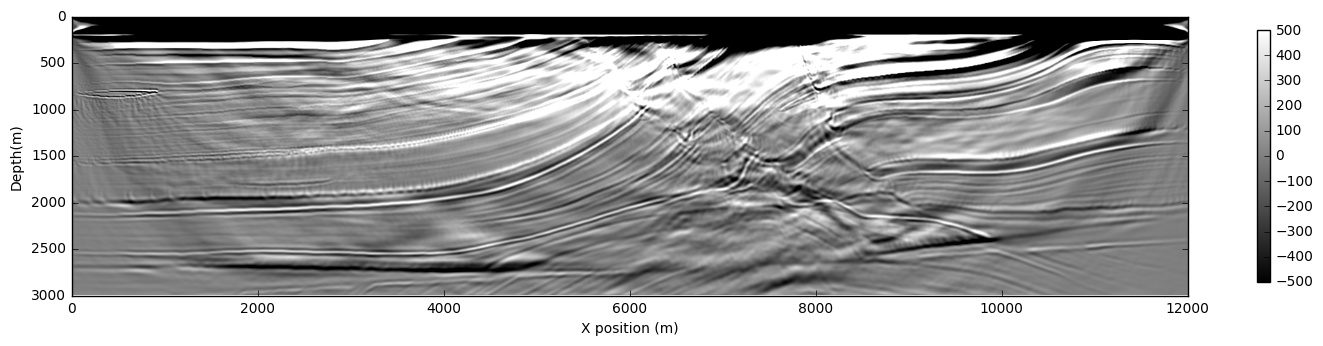

In [43]:
# RTM result
fig4 = plt.figure()
l = plt.imshow(np.transpose(Im[40:-40,40:-40]), vmin=-5*1e2, vmax=5*1e2, cmap=cm.gray, extent=[np.min(x_axis), np.max(x_axis), np.max(z_axis), np.min(z_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Depth(m)')
plt.axis('scaled')
plt.colorbar(l, shrink=.25)
plt.show()

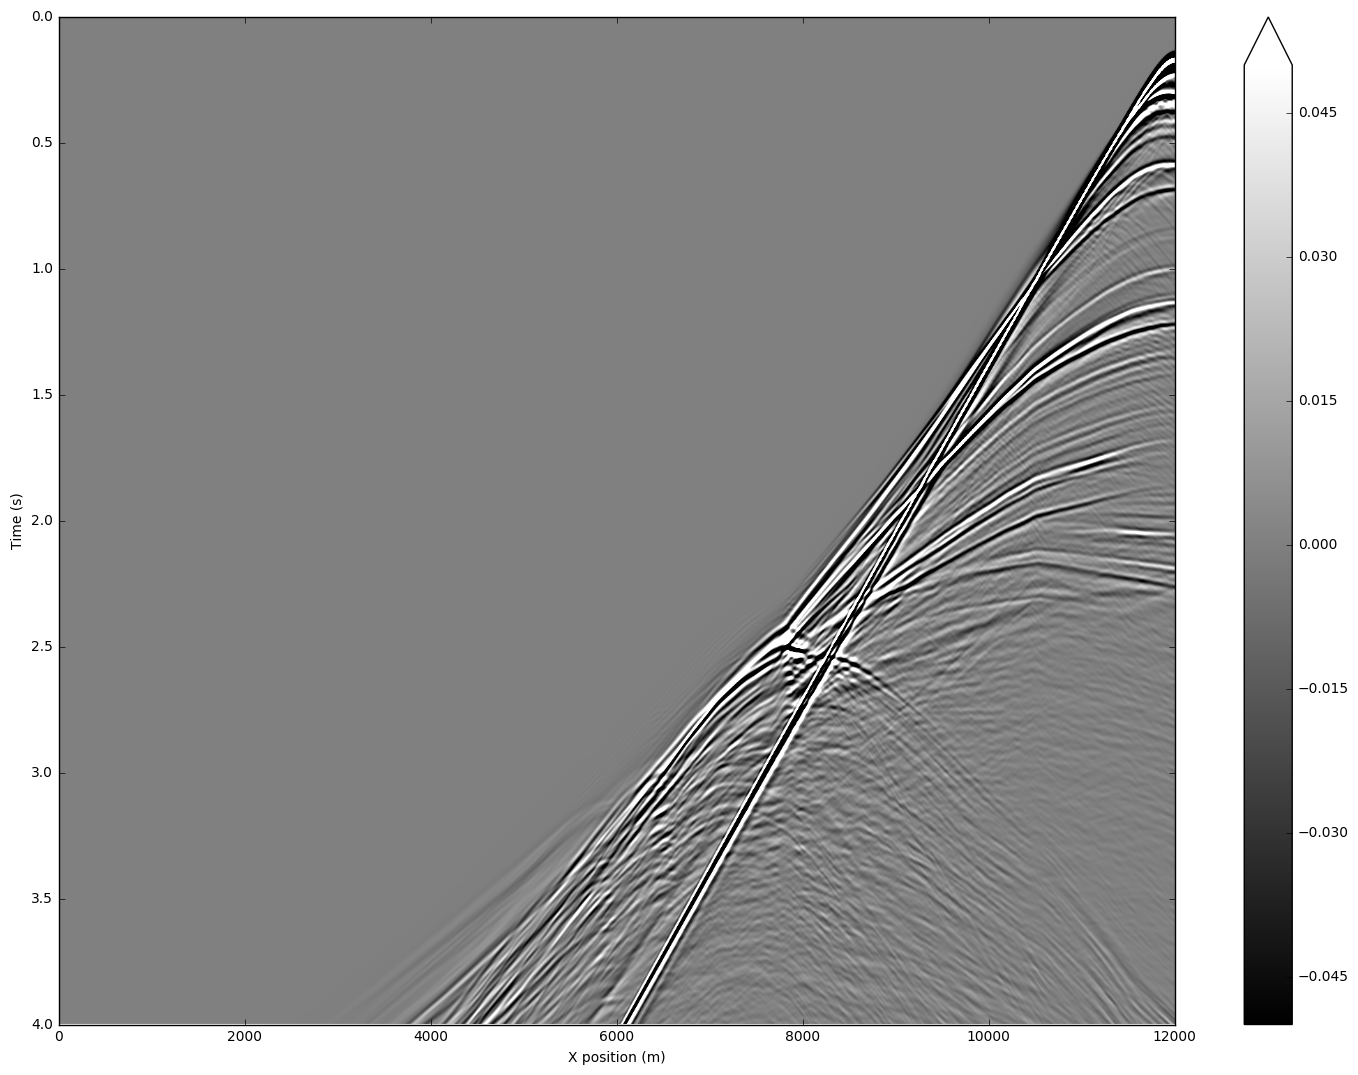

In [23]:
# True Shot record
fig5 = plt.figure()
l = plt.imshow(rec, vmin=-.05, vmax=0.05, cmap=cm.gray, extent=[np.min(x_axis), np.max(x_axis), np.max(t_axis), np.min(t_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Time (s)')
plt.axis('auto')
plt.colorbar(extend='max')
plt.show()

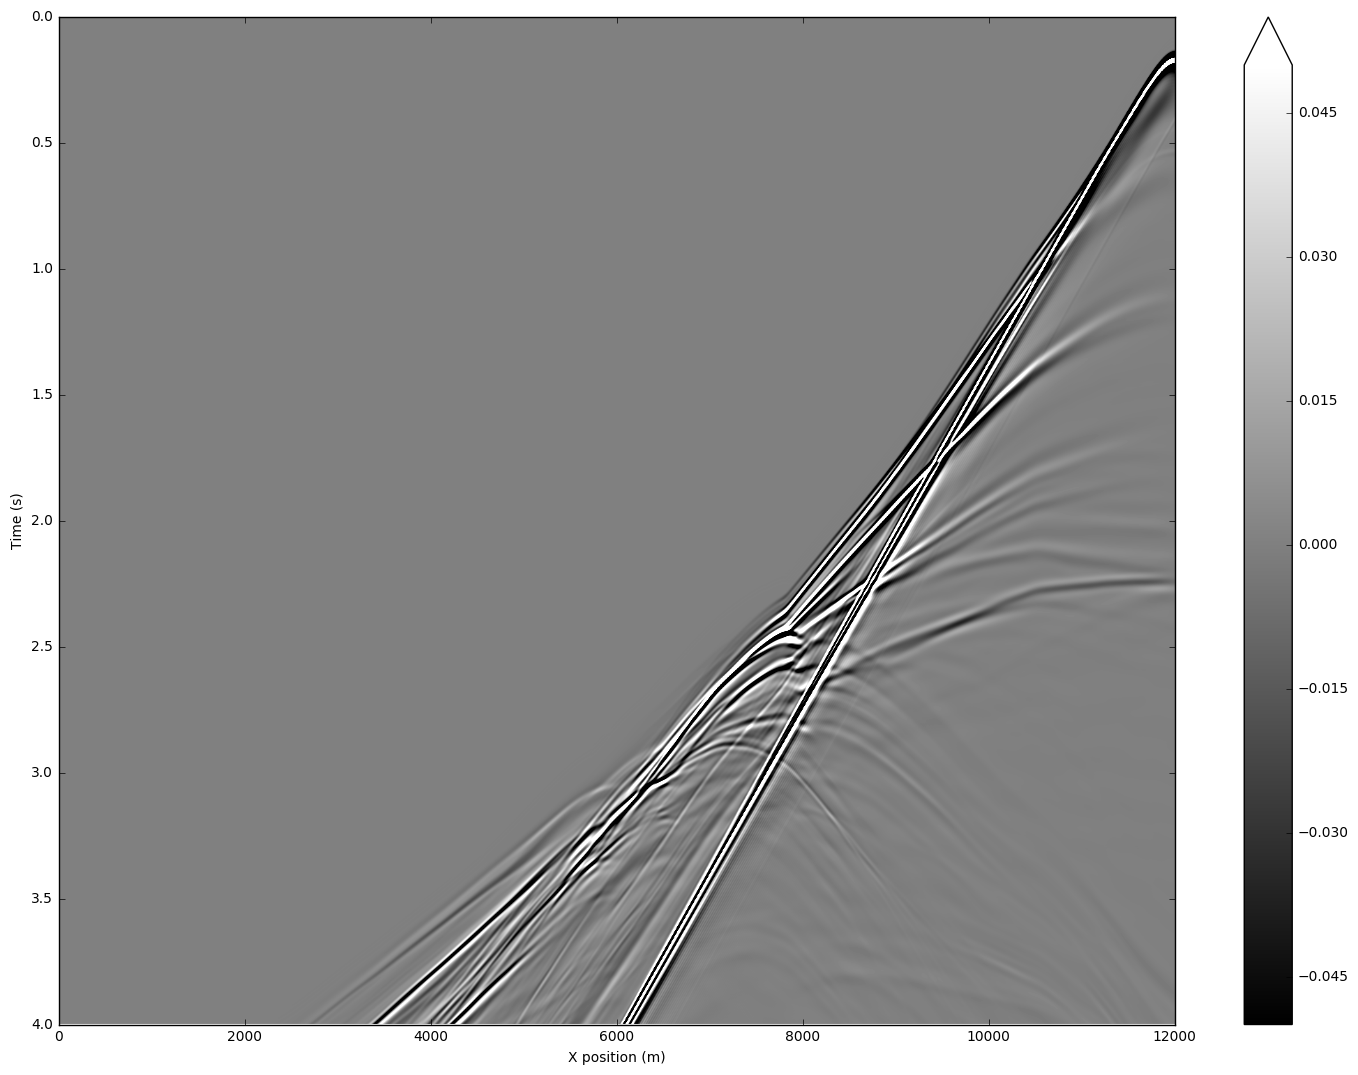

In [24]:
# Smooth velocity Shot record
fig6 = plt.figure()
l = plt.imshow(rec0, vmin=-.05, vmax=0.05, cmap=cm.gray, extent=[np.min(x_axis), np.max(x_axis), np.max(t_axis), np.min(t_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Time (s)')
plt.axis('auto')
plt.colorbar(extend='max')
plt.show()

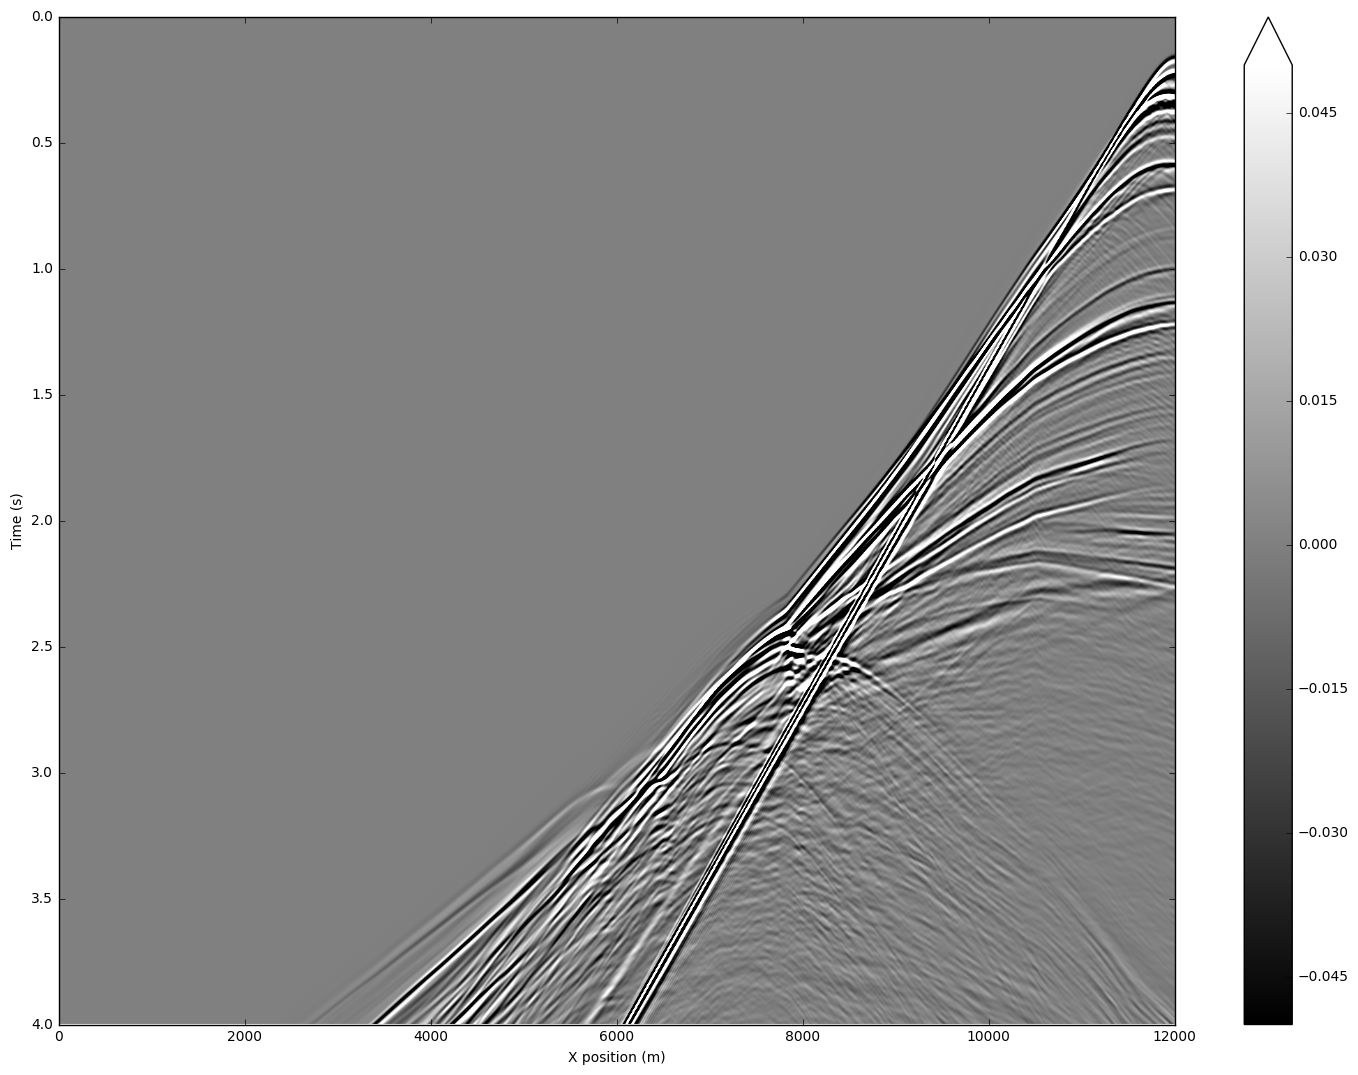

In [25]:
# Data difference (adjoint source for the gradient)
fig7 = plt.figure()
l = plt.imshow(rec0 - rec, vmin=-.05, vmax=0.05, cmap=cm.gray, extent=[np.min(x_axis), np.max(x_axis), np.max(t_axis), np.min(t_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Time (s)')
plt.axis('auto')
plt.colorbar(extend='max')
plt.show()